# Separate the scans

We scanned multiple fish in [a special sample holder](https://github.com/TomoGraphics/Hol3Drs/blob/master/STL/Stickleback.Multiple.stl).
This notebook is used to separate them into different bunch of reonstructions.

The cells below are used to set up the whole notebook.
They load needed libraries and set some default values.

In [1]:
# Load the modules we need
import platform
import os
import glob
import pandas
import imageio
import numpy
import matplotlib
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar
import seaborn
import dask
import dask_image.imread
from dask.distributed import Client, LocalCluster
import skimage
from tqdm.auto import tqdm, trange

In [2]:
# Load our own log file parsing code
# This is loaded as a submodule to alleviate excessive copy-pasting between *all* projects we do
# See https://github.com/habi/BrukerSkyScanLogfileRuminator for details on its inner workings
from BrukerSkyScanLogfileRuminator.parsing_functions import *

In [3]:
# Set dask temporary folder
# Do this before creating a client: https://stackoverflow.com/a/62804525/323100
# We use the fast internal SSD for speed reasons
import tempfile
if 'Linux' in platform.system():
    # Check if me mounted the FastSSD, otherwise go to standard tmp file
    if os.path.exists(os.path.join(os.sep, 'media', 'habi', 'Fast_SSD')):
        tmp = os.path.join(os.sep, 'media', 'habi', 'Fast_SSD', 'tmp')
    else:
        tmp = tempfile.gettempdir()
elif 'Darwin' in platform.system():
    tmp = tempfile.gettempdir()
else:
    if 'anaklin' in platform.node():
        tmp = os.path.join('F:\\tmp')
    else:
        tmp = os.path.join('D:\\tmp')
dask.config.set({'temporary_directory': tmp})
print('Dask temporary files go to %s' % dask.config.get('temporary_directory'))

Dask temporary files go to /media/habi/Fast_SSD/tmp


In [4]:
from dask.distributed import Client
client = Client()

/home/habi/anaconda3/envs/sticklebacks/lib/python3.12/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 42355 instead
  warnings.warn(


In [5]:
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:42355/status,
Dashboard: http://127.0.0.1:42355/status,Workers: 8
Total threads: 32,Total memory: 125.79 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:33471,Workers: 8
Dashboard: http://127.0.0.1:42355/status,Total threads: 32
Started: Just now,Total memory: 125.79 GiB
Comm: tcp://127.0.0.1:34417,Total threads: 4
Dashboard: http://127.0.0.1:41467/status,Memory: 15.72 GiB
Nanny: tcp://127.0.0.1:37419,


In [6]:
seaborn.set_context('notebook')

In [7]:
# Set up figure defaults
plt.rc('image', cmap='gray', interpolation='nearest')  # Display all images in b&w and with 'nearest' interpolation
# plt.rcParams['figure.figsize'] = (16, 9)  # Size up figures a bit
plt.rcParams['figure.dpi'] = 200

In [8]:
# Setup scale bar defaults
plt.rcParams['scalebar.location'] = 'lower right'
plt.rcParams['scalebar.frameon'] = False
plt.rcParams['scalebar.color'] = 'white'

In [9]:
# Display all plots identically
lines = 3
# And then do something like
# plt.subplot(lines, int(numpy.ceil(len(Data) / float(lines))), c + 1)

Since the (tomographic) data can reside on different drives we set a folder to use below

In [10]:
# Different locations if running either on Linux or Windows
FastSSD = True
if 'Linux' in platform.system():
    if FastSSD:
        BasePath = os.path.join(os.sep, 'media', 'habi', 'Fast_SSD')
    else:
        BasePath = os.path.join(os.path.sep, 'home', 'habi', '2214')
elif 'Windows' in platform.system():
    if FastSSD:
        BasePath = os.path.join('F:\\')
    else:
        BasePath = os.path.join('N:\\')
Root = os.path.join(BasePath, 'IEE Stickleback')
print('We are loading all the data from %s' % Root)

We are loading all the data from /media/habi/Fast_SSD/IEE Stickleback


Now that we are set up, actually start to load/ingest the data.

In [11]:
# Make us a dataframe for saving all that we need
Data = pandas.DataFrame()

In [12]:
# Get *all* log files
# Using os.walk is way faster than using recursive glob.glob, see DataWrangling.ipynb for details
# Not sorting the found logfiles is also making it quicker
Data['LogFile'] = [os.path.join(root, name)
                   for root, dirs, files in os.walk(Root)
                   for name in files
                   if name.endswith((".log"))]

In [13]:
# Get all folders
Data['Folder'] = [os.path.dirname(f) for f in Data['LogFile']]

In [14]:
# Show a (small) sampler of the loaded data as a first check
Data.sample(n=5)

,LogFile,Folder
29,/media/habi/Fast_SSD/IEE Stickleback/BucketOfF...,/media/habi/Fast_SSD/IEE Stickleback/BucketOfF...
28,/media/habi/Fast_SSD/IEE Stickleback/BucketOfF...,/media/habi/Fast_SSD/IEE Stickleback/BucketOfF...
32,/media/habi/Fast_SSD/IEE Stickleback/PilotScan...,/media/habi/Fast_SSD/IEE Stickleback/PilotScan...
17,/media/habi/Fast_SSD/IEE Stickleback/BucketOfF...,/media/habi/Fast_SSD/IEE Stickleback/BucketOfF...
1,/media/habi/Fast_SSD/IEE Stickleback/BucketOfF...,/media/habi/Fast_SSD/IEE Stickleback/BucketOfF...


In [15]:
# Get rid of all the logfiles from all the folders that might be on disk but that we don't want to load the data from
for c, row in Data.iterrows():
    # Since this notebook only deals with the 'BucketOfFish' scans, drop all others
    if 'Bucket' not in row.Folder:  # Only use the scans named Bucket* here
        Data.drop([c], inplace=True)    
    elif 'rec' not in row.Folder:  # Only look at logs in any rec folder
        Data.drop([c], inplace=True)
    elif '_regions' in row.Folder:  # Exclude all log files that we write in this notebook (to $scan$_region folders)
        Data.drop([c], inplace=True)
    elif 'SubScan' in row.Folder:  # Exclude any log files from rsyncing temporary data
        Data.drop([c], inplace=True)
    elif 'rectmp.log' in row.LogFile:  # Exclude any log files from rsyncing temporary data
        Data.drop([c], inplace=True)
# Reset dataframe to something that we would get if we only would have loaded the 'rec' files
Data = Data.reset_index(drop=True)

In [16]:
# Generate us some meaningful colums in the dataframe
Data['Sample'] = [os.path.basename(l).replace('_rec.log','') for l in Data['LogFile']]
Data['Scan'] = [os.path.basename(os.path.dirname(l)) for l in Data['LogFile']]

In [17]:
# Quickly show the data from the last loaded scans
Data.tail()

,LogFile,Folder,Sample,Scan
0,/media/habi/Fast_SSD/IEE Stickleback/BucketOfF...,/media/habi/Fast_SSD/IEE Stickleback/BucketOfF...,Sticklebucket,17.5um_rec
1,/media/habi/Fast_SSD/IEE Stickleback/BucketOfF...,/media/habi/Fast_SSD/IEE Stickleback/BucketOfF...,Sticklebucket_B,rec
2,/media/habi/Fast_SSD/IEE Stickleback/BucketOfF...,/media/habi/Fast_SSD/IEE Stickleback/BucketOfF...,Sticklebucket_C,rec


In [55]:
# Load the file names of all the reconstructions of all the scans
Data['Filenames Reconstructions'] = [sorted(glob.glob(os.path.join(f, '*rec0*.png'))) for f in Data['Folder']]
# How many reconstructions do we have?
Data['Number of reconstructions'] = [len(r) for r in Data['Filenames Reconstructions']]

In [19]:
# Drop samples which have either not been reconstructed yet or of which we deleted the reconstructions with
Data = Data[Data['Number of reconstructions'] > 0]
# Reset the dataframe count/index for easier indexing afterwards
Data.reset_index(drop=True, inplace=True)
print('We have %s folders with reconstructions' % (len(Data)))

We have 3 folders with reconstructions


In [20]:
# Get parameters to doublecheck from logfiles
Data['Voxelsize'] = [pixelsize(log) for log in Data['LogFile']]
Data['Filter'] = [whichfilter(log) for log in Data['LogFile']]
Data['Exposuretime'] = [exposuretime(log) for log in Data['LogFile']]
Data['Scanner'] = [scanner(log) for log in Data['LogFile']]
Data['Averaging'] = [averaging(log) for log in Data['LogFile']]
Data['ProjectionSize'] = [projection_size(log) for log in Data['LogFile']]
Data['RotationStep'] = [rotationstep(log) for log in Data['LogFile']]
Data['Grayvalue'] = [reconstruction_grayvalue(log) for log in Data['LogFile']]
Data['RingartefactCorrection'] = [ringremoval(log) for log in Data['LogFile']]
Data['BeamHardeningCorrection'] = [beamhardening(log) for log in Data['LogFile']]
Data['DefectPixelMasking'] = [defectpixelmasking(log) for log in Data['LogFile']]
Data['Scan date'] = [scandate(log) for log in Data['LogFile']]

In [21]:
# # Load all reconstructions DASK arrays
# Reconstructions = [dask_image.imread.imread(os.path.join(folder,'*rec*.png')) for folder in Data['Folder']]
# Load all reconstructions into ephemereal DASK arrays, with a nice progress bar...
Reconstructions = [None] * len(Data)
for c, row in tqdm(Data.iterrows(),
                   desc='Loading reconstructions',
                   total=len(Data)):
    Reconstructions[c] = dask_image.imread.imread(os.path.join(row['Folder'], '*rec*.png'))#[:,:,:,0]

Loading reconstructions:   0%|          | 0/3 [00:00<?, ?it/s]

In [22]:
# Extract bucket name
Data['Bucket'] = [(l).split(os.sep)[-3].split('_')[-1] for l in Data['LogFile']]

In [23]:
# The three cardinal directions
# Names adapted to fishes: https://en.wikipedia.org/wiki/Fish_anatomy#Body
directions = ['Anteroposterior',
              'Lateral',
              'Dorsoventral']

In [24]:
# Read or calculate the directional MIPs, put them into the dataframe and save them to disk
for d, direction in enumerate(directions):
    Data['MIP_' + direction] = ''
for c, row in tqdm(Data.iterrows(), desc='Working on MIPs', total=len(Data)):
    for d, direction in tqdm(enumerate(directions),
                             desc='%s/%s' % (row['Sample'], row['Scan']),
                             leave=False,
                             total=len(directions)):
        outfilepath = os.path.join(os.path.dirname(row['Folder']),
                                   '%s.%s.MIP.%s.png' % (row['Sample'], row['Scan'], direction))
        if os.path.exists(outfilepath):
            try:
                Data.at[c, 'MIP_' + direction] = dask_image.imread.imread(outfilepath).squeeze()
            except:
                print('Something went wrong with the %s image of %s/%s %s' % (direction, row['Sample'], row['Scan']))
                print('Try to delete %s and restart the notebook' % outfilepath[len(Root):])
        else:
            # Generate MIP
            # drop last axis, since dask.imread insists on reading reconstructions PNGs as RGB
            mip = Reconstructions[c][:,:,:,0].max(axis=d).compute()
            Data.at[c, 'MIP_' + direction] = mip
            # Save it out
            imageio.imwrite(outfilepath, mip.astype('uint8'))

Working on MIPs:   0%|          | 0/3 [00:00<?, ?it/s]

Sticklebucket/17.5um_rec:   0%|          | 0/3 [00:00<?, ?it/s]

Sticklebucket_B/rec:   0%|          | 0/3 [00:00<?, ?it/s]

Sticklebucket_C/rec:   0%|          | 0/3 [00:00<?, ?it/s]

In [25]:
def getLargestCC(segmentation):
    # Based on https://stackoverflow.com/a/55110923
    labels = skimage.measure.label(segmentation)
    assert( labels.max() != 0 ) # assume at least 1 CC
    largestCC = labels == numpy.argmax(numpy.bincount(labels.flat)[1:])+1
    return largestCC

In [26]:
def vial_label_extractor(whichscan, threshold=None, part=300, verbose=True):
    # Let's get out the numbers, they are 'hidden' in the lower part
    bottom_mip = Reconstructions[whichscan][:300].max(axis=0)[:,:,0].compute()
    if not threshold:
        threshold = skimage.filters.threshold_otsu(bottom_mip[bottom_mip>10])
    # remove largest component from thresholded bottom MIP
    # The largest component are the separation walls of the bucket
    numbers = numpy.bitwise_xor(bottom_mip>threshold, getLargestCC(bottom_mip>threshold))
    # Clean up the image by removing small objects
    numbers_cleaned = skimage.morphology.remove_small_objects(numbers, min_size=10000)
    # only labels should remain
    if verbose:
        plt.subplot(121)
        plt.imshow(Data['MIP_Dorsoventral'][whichscan])
        plt.gca().add_artist(ScaleBar(Data['Voxelsize'][whichscan], 'um'))
        plt.gca().add_artist(matplotlib.patches.Rectangle((0, 0), Data['MIP_Dorsoventral'][whichscan].shape[1], part, alpha=0.618))
        plt.title('Bucket %s' % Data['Bucket'][whichscan])
        plt.axis('off')
        plt.subplot(122)
        plt.imshow(numbers_cleaned)
        plt.title('MIP of marked region\n%s recs >%s - their largest CC' % (part, threshold))
        plt.gca().add_artist(ScaleBar(Data['Voxelsize'][whichscan], 'um'))
        plt.axis('off')
        plt.savefig('%s.%s.Labels.Extracted.png' % (os.path.join(os.path.dirname(Data['Folder'][whichscan]), Data.Sample[whichscan]), Data.Scan[whichscan]))
        plt.show()
    return(numbers_cleaned)

In [27]:
Data['VialLabels'] = [vial_label_extractor(i, verbose=False) for i in range(len(Data))]

In [28]:
def detect_fish_position(whichscan, threshold=None, verbose=False):
    import matplotlib.patches
    # Detect the fish positions based on blobs in the top-down MIP
    regions = None
    td_mip = Data['MIP_Anteroposterior'][whichscan].compute()
    if not threshold:
        threshold = skimage.filters.threshold_otsu(td_mip[td_mip>10])
    td_mip_thresholded = td_mip>threshold
    # Clean speckles, assuming all fish are larger than 1000 px
    cleaned = skimage.morphology.remove_small_objects(td_mip_thresholded,
                                                      min_size=1000)
    # Label imagedata:image/png;base64,iVBORw0KGgoAAAANSUhEUgAABCkAAAJNCAYAAAAcQy8RAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjguMSwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/SrBM8AAAACXBIWXMAAB7CAAAewgFu0HU+AAEAAElEQVR4nOydd3wURf/HP3uXS0ISkpAEQhIwoXdBpItCKIJgAx8L4AOIXXjs5ScqWB8fu48VfXwE9VGxd5AiKCpFqlTpASS0hPSeu/n9cdm52bmZvUsjUb/v58WTvd0p35mdXff7mWYwxhgIgiAIgiAIgiAIgiAaGEdDG0AQBEEQBEEQBEEQBAGQSEEQBEEQBEEQBEEQRCOBRAqCIAiCIAiCIAiCIBoFJFIQBEEQBEEQBEEQBNEoIJGCIAiCIAiCIAiCIIhGAYkUBEEQBEEQBEEQBEE0CkikIAiCIAiCIAiCIAiiUUAiBUEQBEEQBEEQBEEQjQISKQiCIAiCIAiCIAiCaBSQSEEQBEEQBEEQBEEQRKOARAqCIAiCIAiCIAiCIBoFJFIQBEEQBEEQBEEQBNEoIJGCIAiCIAiCIAiCIIhGAYkUBEEQBEEQBEEQBEE0CkikIAiCIAiCIAiCIAiiUUAiBUEQBEEQBEEQBEEQjQISKQiCIAiCIAiCIAiCaBSQSEEQBEEQBEEQBEEQRKOARAqCIAiCIAiCIAiCIBoFJFIQBEEQBEEQfyl27tyJ6dOno1u3bmjatCkMw+D/MjIyGtq8Pyzz5s3j9Th16tSGNqdWTJ06lZdl3rx5DW1Oo+X777/n9TR06NCGNof4k0AiBUEQBEEQRAMzdOhQi6NsGAa+/PLLaqVx5513+qXx4IMPasOL4b7//ntlGNEBUf0LDQ1F8+bN0adPH8yYMQMrV66sls0Nwddff41evXrhlVdewfbt21FYWNjQJhEEQRACIQ1tAEEQBEEQBOHPW2+9hQsvvDCosG63G++99149W+RPRUUFsrKykJWVhfXr1+Pll1/G6NGjMW/ePCQmJp5yewJRVFSEKVOmoLS0FACQlJSEwYMHo3nz5jAMAwAQHR3dkCYSBEH85SGRgiAIgiAIohHy9ddfIycnB82aNQsYdsmSJThy5Ei92zR9+nTL7/LycmRkZOCnn35CSUkJAODbb79Feno6Vq5cidjY2Hq3qTp89dVXOHnyJACgW7duWLt2LZo0adLAVhEEQRAiJFIQBEEQBEE0Irp27Yrt27ejvLwc8+fPx4033hgwzttvv+0Xvz546aWXlOezsrJw44034uOPPwYA7NixA/fddx9efvnlerGjpmzYsIEfT5gwgQQKgqglQ4cOBWOsoc0g/mTQmhQEQRAEQRCNiAkTJsDlcgGwig868vPz8fnnnwMAevXqhR49etSneUoSEhIwf/58DBgwgJ974403UFBQcMptsSMnJ4cfJyUlNaAlBEEQhA4SKQiCIAiCIBoRCQkJOO+88wAAq1evxu7du23Df/TRR3yqxZQpU+rdPh1OpxP/93//x3+Xl5fjxx9/bDB7VFRUVPBjh4M+gwmCIBoj9HYmCIIgCIJoZEyePJkfBxpNYV4PCQnBxIkT69WuQAwcONDye9++fXWS7sGDBzFr1iwMGDAAiYmJCA0NRWJiIgYMGIDZs2fj0KFD2rgPPvgg343krbfe4uevuuoqv91KdLucBCItLc1vC9Ndu3bhtttuQ9euXdG0aVNERkaiT58+eOGFFyxiickvv/yCv//97+jUqRMiIiKQkJCAUaNG4YsvvgjKhoqKCixatAh333030tPTkZycjPDwcDRp0gStWrXCmDFj8O9//zuo3UwyMjJ4edLS0vj5n376Cddccw06d+6MmJgYGIaBW2+9NSj7VHl06NCB5zNo0CDLSBeRHTt2YObMmejXrx+//82bN0f//v0xa9YsZGZmVivvJUuW4LLLLkPr1q0RHh6OlJQUDB8+HPPmzVPem7pAbGcmv/76K2655RZ0794dcXFxMAwDF198sTJ+dnY2nnnmGYwcOZLbHRsbi65du2L69OlYt25dtezZunUrbrzxRnTo0IG3tz59+uDxxx9HVlYWgOC2lK3JFqSLFi3CtGnT0LFjR0RHR6NJkyZITU3FuHHjMHfu3KDugWqL2KKiIrzyyisYPHgwEhMTERYWhtatW2PChAn4+eefg7KNaCQwgiAIgiAIokEZMmQIA8AAsFdffZWVlZWxuLg4BoClpaUxj8ejjLd//35mGAYDwMaOHcsYY+zyyy/nac2ePVubpxkGAFu+fLkyzPLlyy3hAlFeXm4J/9hjjwWME4jHHnuMhYeHW9KV/4WHh7PHH39cGX/27Nm2cYOph0CkpqbyNPbv38/mzp1ra/OIESNYaWkpY4yxyspKdu2119radeutt9rmf/DgQRYfHx9UGRMSEtjixYtt09u/fz8Pn5qaysrKytgNN9ygTO+WW27h8ebOncvPT5kyRZv+5s2bWXJyMg87evRoVlRU5BeutLSU3XDDDczpdNqWqUmTJuzFF1+0LRNj3vb597//3TatAQMGsMOHD7MpU6bwc3Pnzg2YdiDk52j27NnKcl100UV+cV966SUWExNja7dhGGzatGmsrKwsoC1PPPEEc7lc2rSSkpLYzz//HNT9FN8RQ4YMsc332LFjbPjw4QHbaIcOHdjatWtt05Lvz/bt21mXLl1s0501a1bAuiEaB7RwJkEQBEEQRCMjNDQUl112GebMmYOMjAysWLECQ4YM8Qv39ttv80XrxNEXDYXcEx4TE1Or9GbMmGFZfDMyMhLDhg1Dy5YtcfToUSxfvhyFhYUoLS3Fvffei2PHjuG5556zpNGvXz++K8l3332H3377DQAwfPhwdO7c2RI2JSWlVvYCwIIFCzBjxgwwxtClSxf06dMHLpcLa9euxZYtWwAAS5cuxT/+8Q+8/vrruOGGG/DGG2/A4XBgwIAB6Ny5M8rKyrB8+XI+QuD5559Hnz59MGnSJGWeRUVFyM7OBgA0a9YM3bp1Q2pqKqKiolBeXo79+/dj9erVKC0tRVZWFsaMGYMffvgBgwYNCqpMt912G+bMmQMA6NGjB3r27AmXy4Vdu3ZVe9rMzz//jPPPPx+5ubkAvGuwvPXWW3wdFrFMo0aNsvSAt2nTBn369EGzZs2Qk5ODlStX4vDhwygpKcE//vEP5OfnY+bMmdq8J02ahI8++oj/jo+PR3p6OmJjY7Fv3z6sWLECq1evxrhx49C+fftqlas6PPXUU3jooYcAAO3atUO/fv0QERGBjIwMv3q47bbb8Pzzz1tsHjBgAJKTk1FaWoqNGzdi69atYIzhzTffRGZmJr755hvtfXn22Wdxzz338N/h4eFIT09Hq1atkJWVheXLl+PIkSM4//zzazxKRsWxY8dw1llnYe/evfxcu3bt0L9/f4SFhWH79u1Ys2YNAGD37t1IT0/Ht99+i7POOitg2pmZmRgxYgQyMzMRGxuLs88+Gy1btkRWVhaWLVuGvLw8AMDDDz+Mrl274vLLL6+zchH1RAOLJARBEARBEH955JEUjDG2cuVKfm7atGnKeO3bt2cAWGxsLCspKWGMNexIik8//dQS/ptvvgkYR8cHH3xgSWvy5MksLy/PEiYvL49deeWVlnAff/yxNs267h03EUdShIaGsujoaPbFF1/4hfv3v//Nw4WEhLCnn36aAWA9evRg27Zts4QtLS1lEydO5OHbtGmjHVGTkZHB/vGPf7A1a9Ywt9utDJOXl8fuvPNOS2+1Lqw4ksLs7W/dujVbsWKFX1hzRAhjgUdSfP3116xJkyY8zIwZM7Rlmjx5Mg/Xrl07tmTJEr8wlZWV7JVXXmFhYWHc1pUrVyrTE20DwG6//XaL7YwxtmfPHnbmmWfy+1iXbUXMOyQkhMXExLDPPvvML5xo03//+18eJyoqio+yklm2bBlLSUnhYZ944gmlDVu3brWUa+zYsez48eOWMEVFRXzUjFmvuvvJWPAjKc477zweLiIigr377rt+YdauXcvatm3Lw7Vu3Zrl5OQo0xOfZdPOu+++229ETnZ2Nhs2bBgP27ZtW22bIxoPJFIQBEEQBEE0MCqRgjHGOnbsyACw6OhoVlxcbInz888/8zjXXXcdP99QIkVlZSUbMGCAxVnPz88PXHgFbrebtWnThqd1ySWXaB0Lj8fDLrroIotDq3O+T4VIYRgGW7ZsmTbsqFGjLHXasmVLP0fRpKCgwDKNY/Xq1bW2VZy2sWDBAmUYUaQwncqdO3cGTNtOpHjrrbdYSEgIv/7ggw9q01mxYgUP16pVK3bkyBHbfN98800efvTo0X7XKysrWatWrXiYa665RptWVlaWxeGvD5HCMAz2ww8/2IbPz89nsbGxXHwJFH779u18ilF8fLxy+szf/vY3bkOfPn1sp4ZceumlFptrI1IsW7bMkpZKwDPZv3+/ZWrLQw89pAwnPssA2L333qtN8+jRoywyMrJOnyOifqGFMwmCIAiCIBopf//73wFYtxk1ERfUbOipHllZWbjiiiuwevVqfu7qq69G06ZNa5Te4sWLsX//fgDeqS8vvviiZcFBEcMw8PLLL/Nh8nv37sWSJUtqlG9dcPHFFyM9PV17XR5qPnPmTDRv3lwZNioqCmPHjuW/165dW2v7rrrqKn68dOnSoOLMmDEDHTt2rHGezz77LKZOnYrKyko4HA68/PLLmD17tm14k8cffxwtW7a0TX/q1Kl86s6iRYv4wo8mixYtwu+//w4AiIiIwJNPPqlNKz4+Hg8//HDAMtWGSy+9FOecc45tmDfffJNPiZk6dWrA8F26dOG7+2RnZ+Pbb7+1XD958qRlEdYnn3wSoaGh2vSeeeaZOtsB57XXXuPHF1xwAS688EJt2LS0NMuUnTlz5vApbTqaN2+OWbNmaa8nJibW+XNE1C+0JgVBEARBEEQj5e9//ztmzZoFxhjefvttTJgwAQBQVlaGDz74AIB3Xncw87brghkzZlh+l5eX4+DBg/jxxx9RXFzMz3fq1AmPPvpojfNZtmwZPz7vvPOQlJRkGz4lJQWjR4/GV199BQBYvnw5Ro0aVeP8a8Mll1xie7179+6W3+PHjw86vCnc2FFRUYE1a9bg119/xdGjR1FQUIDKykp+vaCggB9v2rQpYHoAcMUVVwQVTsW9996Lf/3rXwAAl8uFt99+2za9yspKLjKFhIQErE/AK1Slp6fjt99+A2MMK1eutDjCy5cv58djx45Fs2bNbNO77LLLcNNNN6GsrCxg3jUhmPpcsGBBtcIDwLBhw7gg8NNPP1na1sqVK/muGUlJSQF34mjdujXOOeecGu94IyLW/7Rp0wKGv+qqq3DvvffC4/HgyJEj2Llzp9/6MSIXXHABwsPDbdM844wz8OGHHwIA34GHaLyQSEEQBEEQBNFISU1NxTnnnIMffvgBS5YswdGjR9GyZUt8+eWXvJfVHG1xKhAXsdQxcuRIzJs3D3FxcTXOZ+PGjfw4WAHmrLPO4iLFhg0bapx3benWrZvtddFBjomJCbhYpxg+Pz9fG66kpAT//Oc/MWfOHL+RBDqCCedyudCjR4+g0hNxu9245ppr8N///heAd9HTTz/9FOeee65tvM2bN6OoqAiAd1HHu+66K6j8xN5xeUtaUYzp379/wLSioqLQvXt3rF+/Pqi8q8uZZ54ZMMyqVav48dtvv+03kkqFOVoEsK+Dvn37akcmifTt27fWIsXhw4dx/Phx/juYxVqbN2+Ojh078kVuN2zYYCtSBNM+4+Pj+bG5kCbReCGRgiAIgiAIohEzefJk/PDDD3C73Xj33Xdxxx138KkehmGcUpFCJiQkBDExMUhLS0P//v0xceLEOhnVceLECX6cmpoaVJy0tDR+HKyTXh8E2tEkJMT3+R3M7idieLMnXCYnJwfDhg0LemSEiTiqQkezZs0sNgTL/Pnz+QiOmJgYLFq0KCiBwNzRBAAKCwuDEsZk5F1mxPZ02mmnBZVG69at602k0E3vMSksLLTcm3feeafaech1ID4TrVq1CiqNutjtRqz7Jk2aoEWLFkHFS0tL4yJFoOc5mOdI3DVF9xwRjQdak4IgCIIgCKIRc+mllyIiIgKAt0f1+PHjfL754MGD0bZt21NmC/Muus7/VVRUICsrC+vWrcPLL79cZ9NOCgsL+XFkZGRQccRwwTjf9UUwPdQ1CWvH9OnTuUARFhaG66+/Hl9++SV2797Np3uY90ycMuLxeAKm3aRJkxrZJDqFhYWFOHDgQFDx6qKXW5zeYuZvYj5LgQi23dWEQHX6Z6qDmjzLcthAz3NdPUdE44FGUhAEQRAEQTRimjZtiosvvhjvvfceNm/ejHvuuYc7IA29YGZ9ERUVxY/Nof+BEMPVdMHOPyKHDx/G/PnzAQBOpxOLFy+2XWTxVAk4prg2Z84cuN1uTJo0CYB3vQc7ROe0V69elqk/NUVsT+LaKXYE2+7qA9mZz83NDWq0QLBpnso6qMmzLIf9Kz3PhBcaSUEQBEEQBNHIEcWIefPmAfDO17/00ksbyKL6RRwOf/DgwaDiiD31CQkJdW5TY2XZsmV894MxY8YE3AUi2BENtcUwDLzyyiu44YYbAHh79idNmoSPPvrINl5iYiI/3rdvX1CjPQJRk/Ykr+lwKomNjUVYWBj/vXv37lqnKT4T4toVdhw+fLjW+Yp1X1JSEvRUrL/q80x4IZGCIAiCIAiikTNixAgkJydbzl100UW17l1trJxxxhn8eOXKlUHF+fnnn/lx796969ymxoq4hkOgRTsBYMWKFfVpjgVTqLj++usBeIWKiRMn4uOPP9bG6dWrF3fQ8/PzLQtI1pRevXrxY3GbXB2FhYXYunVrrfOtDf369ePHixYtqnV6Yh2sW7cu4LaeQN1s1ZmSkmJZhyKY5zk7Oxs7d+7kv/9KzzPhhUQKgviDMXXqVBiGAcMweG8aQRAE8efG6XRi4sSJlnN/1qkegHcrRZMFCxZYdgdQcfToUb5Ohxz/z47D4fucDzSMv7i4mC+6eqowDAOvvvqqRaiYMGGCVqho0qSJ5f4999xztbYhPT2dHy9YsAAnT560Df/BBx/U2/ajwXL++efz4zlz5qC0tLRW6Q0aNIivE5KZmRlw145Dhw7hxx9/rFWeJmL9B/Pt+tZbb/ERNMnJyejUqVOd2EH8cSCRgvjDMnToUO6sq/45HA40bdoUbdq0wcUXX4zXXnvNdusu4o/Jzp078eyzz2LMmDHo3Lkz4uPj4XK5EB8fj86dO+OKK67ACy+8gCNHjjS0qQRBELXivvvuw9q1a/m/UaNGNbRJ9ca5556LNm3aAADKyspw6623asMyxnDzzTejvLwcANCuXTuMGDHiVJjZKBAXTv3mm2/8FkwUueOOO3Ds2LFTYZYFU6i47rrrAPiEik8++UQZ/p577uHHn3zySbU6ZY4ePep3btSoUXyniuLiYkv6MtnZ2Zg9e3bQ+dUX119/PWJjYwF4p2fcdNNNQY1+ALy7Ybjdbsu5+Ph4XHjhhfz33XffzZ8ZFXfeeadfGjXFFKgA4LPPPrMIijKHDh3Co48+aolLC2P+9SCRgvjTwhhDYWEhMjIy8MUXX+CGG25A+/bt8dlnnzW0aX9a0tLSuEiUkZFRr3nt2LEDf/vb39ClSxfccccdWLhwIXbu3ImTJ0+isrISJ0+exM6dO/HBBx/glltuQevWrTF+/Hi+nRVBEMQfjdjYWPTp04f/czqdDW1SveFwOPCvf/2L/37//fdx7bXXWnYKALyLQF599dWWdQ6eeOIJy+iCPzvDhg3juzXs3bsXU6dORW5uriVMfn4+rrvuOsyZM6ded62wwzAMzJkzxyJUXHHFFUqhYsiQIZgyZQr/PW3aNNx1113Izs5Wpl1WVoYvvvgC48aNszjiJk6nEw8//DD//cYbb+Cuu+7yc9L37duHUaNG4fDhwwgNDa1ROeuKmJgYyyiSuXPn4oILLtB+xzDGsGrVKsyYMQOpqakoKSnxCzN79mw+mmLdunUYP368ZYtQwCvi3Hjjjfjwww8t62LUhvT0dJx33nn896WXXqpcm2Tjxo0YPnw43z61devWuPnmm+vEBuKPBe3uQfwp6Nu3r2XuHuDdVis3NxebN2/Gtm3bAHj3ar700kvxySef4KKLLmoIU4k6YP78+bjqqqssQx+dTid69+6N1NRUxMXFIScnB4cPH8a6detQXl4Ot9uNzz77DF999RUOHDjgN7ebIAiCaFxcdtllWLFiBV5++WUAXsfygw8+QHp6OhITE3H8+HEsW7bMslvFrbfeiksuuaShTG4QmjVrhjvvvJM74e+++y4WLlyI/v37IyUlBUeOHMH333+PoqIiOJ1OvPLKKxYB4FRiChWMMfznP//hQsUHH3yA8ePHW8K+9tprOHLkCBYvXgzGGJ5++mm88MIL6Nu3L9q1a4cmTZogLy8Pe/fuxZYtW/g3wZlnnqnMe9q0afjmm2/w6aefAgCefvppzJs3D+np6YiJicH+/fvxww8/oLKyEn379kWHDh3w3nvv1W+FBGDq1KnYt28fHnnkEQDekTILFixA9+7d0b17d0RHR6OoqAiHDx/Gxo0b/cQpmR49euCxxx7D3XffzdNLTU1Feno6UlJSkJ2djWXLliE3NxexsbG47bbb+KiS2gp/c+fOxVlnnYW9e/eisLAQl112GTp06ID+/fsjNDQUO3bswOrVq/lokcjISLz//vt8NAnx14JECuJPwZgxY/Dggw9qr69atQpXXHEFDh48CLfbjZtuugnnnXdeg6vkRPV59dVXMX36dP4fsfj4eNx3332YOnUqmjVr5he+oKAACxYswGOPPYYtW7agsrLSdngjQRAE0Xh46aWX0LJlSzz66KMoKytDQUEBvvzyS79w4eHhmDVrFu69994GsLLhmTVrFjIyMvh6EydPnsTChQstYWJjYzF37lzLAooNgWEYeO211wDAT6gYN24cDxcWFoYFCxbgoYcewjPPPIPi4mKUl5fj559/tiySKuJyuTBgwABt3u+//z6uuuoqLj5kZWX59ej369cPn376Ke67777aFrVOePjhh9G9e3fcdtttyMzMBGMMW7ZswZYtW7Rx+vXrx0dMyNx1112orKzErFmzUFlZiZKSEixYsMASJikpCR9//DHv5ANqvw1oYmIifv75Z0ycOBHLli0D4N21RLVzSfv27fHee++hb9++tcqT+OPy1xkLR/ylGThwoGWBpmAWDCIaH2vWrMEtt9zCBYpevXph69atuO2225QCBeD9j+rll1+OX3/9Fa+99hrCw8NPpckEQRBELbn//vuxc+dO3H///ejbty8SEhIQEhKChIQE9OvXDw888AB27tz5lxUoAO9owrfeegtfffUVLrjgArRo0QIulwstWrRAnz598Mgjj2Dbtm24+OKLG9pUAD6h4tprrwUAVFRU4PLLL/ebkmtO08jIyMDTTz+N0aNH47TTTkNERARff6p3796YMmUK5s2bh8OHD+Oll17S5hsaGop3330X3377LS655BIkJycjNDQUSUlJGDp0KF5//XX8+OOPfP2KxsJll12Gffv2Yd68eZgwYQLat2+PmJgYOJ1OREdHo0uXLhg/fjyee+457Ny5E2vWrLGdqnHvvfdiw4YNuO6669C2bVuEh4cjLi4OvXv3xmOPPYbNmzdj0KBBlgVG62JEQ2JiIr777jt8++23mDp1Ktq3b4+oqCiEhYWhdevWuPDCC/Hmm29i+/btJFD8xTFYsCuwEEQjY+jQofjhhx8AeOfY2Y2kMGnXrh327dsHAHj++edxyy231KeJ9cLUqVPx1ltvAfAOnZs6dWrDGiSQlpbG97Xev38/0tLS6ixtj8eDLl26YNeuXQC8W1pt2bJFK07o2LBhA1JTUxEfH19nthEEQRAEQfzZmDRpEh918v777+OKK65oYIuIvwo0koL4S9GyZUt+XFRUpAzz/fff88Ufhw4dGlS64q4iwZCfn48XX3wRF1xwAdLS0riKnJycjOHDh+Ohhx6yDLGrKYsWLUJUVBS37aabbuJbOsl89913uOGGG9CtWzfExcVxe0aNGoWXXnpJuQATAGRkZPD0TYECANq0aaPcdaWmI1g+/fRTLlAA3mkf1RUoAO9e2yRQEARBEARB6CkqKrJMA6GRDcSphNakIP5SiNtQioLFqWTOnDmYOXMmX7lY5MiRIzhy5AiWLVuGBx98EAsXLsTo0aNrlM/8+fMxefJkVFRUAAAeeOABy8rWJocOHcLkyZOV4oFpz+LFi/H4449j/vz5OPvss2tkT2159dVX+XGHDh0s+4cTBEEQBEEQdcf999/PF+I0FysliFMFiRTEX4ZffvkF+/fv578bwtm++eab8eKLL/LfTqeTryAdHh6OEydOYNOmTXz7TnH3iurw0ksv4eabbwZjDIZh4N///jf+8Y9/+IXbsWMHhg8fzsUbwzDQq1cvdOvWDRERETh8+DBWrFiBgoICZGZmYuTIkVi4cCHS09N5GtHR0Zg+fToA4O233+arrE+ePFm5yFJN5nmWlZVh5cqV/PeECRNoz2yCIAiCIIhq8vHHH2PNmjW4/vrr0b59e7/rWVlZmDVrlqVz6K677jqVJhIEiRTEX4PVq1fj8ssv57/HjRuHDh06nFIb5syZYxEoLrvsMjzzzDNo1aqVX9itW7fiP//5D9/3vDrMnj2bj5hwuVyYN28eJk6c6BeuuLgYl1xyCRcoRowYgZdffhkdO3a0hMvPz8c999yDOXPmoKysDJMmTcKOHTsQExMDAIiLi+OLVH399ddcpHjooYfqbE2KtWvXWgSb/v3710m6BEEQBEEQfyUKCwvx9NNP4+mnn0bHjh3Ro0cPxMfHo6ysDPv378eaNWtQVlbGw0+aNAmXXnppA1pM/BUhkYL4U7BgwQJkZWVZznk8HuTl5eHXX3+1rO8wbNgwzJ0795Tal5OTw/ekBoAbbrjBolDLdO/eHf/+97+rlYfH48H06dMxZ84cAEBERAQ+/vhjnHfeecrwzzzzDHbs2AEAGD16NL766iuEhPi/EqKjo/Hqq6+iuLgYb7/9No4cOYI5c+bgnnvuqZZ9tcEcWWLSrVu3U5Y3QRAEQRDEn5Fdu3ZZ1vsScTqdmD59Op599tlTbBVBkEhB/ElYu3Yt1q5daxumefPmePLJJxtkN4zXX3+djzBITU3F888/X6fpl5eX48orr+R7fTdr1gxff/01Bg0apAxfUVHBRz84HA7MmTNHKVCIPP7443jnnXfAGMO77757SkUKcQssoG62wSIIgiAIgvirMXHiRDRv3hzffvstNmzYgGPHjiErKwvFxcVo1qwZ0tLSMHToUEybNg2dOnVqaHOJvygkUhB/GU6cOIGrr74aS5cuxYsvvlijnSFqyrfffsuPr732Wtu9q6tLYWEhxo0bh6VLlwIAkpOTsWjRInTv3l0bZ926dTh+/DgAYODAgUhNTQ2YT3JyMjp37owdO3Zg69atyM3NPWVigSnwmERFRZ2SfAmCIAiCIP5MhIaGYuzYsRg7dmxDm0IQWkikIP4UzJ49Gw8++KDf+aKiImRkZGDhwoV48sknceLECbz77rvYtGkTfvzxx1MmVKxZs4Yfi4tO1pasrCykp6dj3bp1ALy7XixevDjgWhCrVq2ypDFjxoyg8jNXeWaM4fDhw6dMpJAX4CwsLORrYhAEQRAEQRAE8eeBRAriT01kZCS6deuGbt26YcKECejfvz8OHz6Mbdu24fbbbz8la1Pk5+ejpKSE/27btm2dpX3vvfeisrISAHD66adjyZIlaNGiRcB4mZmZ/Hjnzp3YuXNntfNWbaFaX8TFxVl+5+bmkkhBEARBEARBEH9CHA1tAEGcKlJSUjB79mz++3//+x+OHj1a7/nW51QFl8vFj805hcGQl5dX67xNceRUII8M2b59+ynLmyAIgiAIgiCIUweJFMRfilGjRvHjyspK/PDDD7VO0+Px2F5XTVWoKx5//HH069cPgFekGDZsGN+xw47IyEh+fOutt4IxVu1/Q4cOrbNyBKJv376WdTzE6TMEQRAEQRAEQfx5IJGC+EuRlJRk+X3gwAG/MOLohGBGCwQalRAdHY0mTZrw3/v37w+YZrDExMRg8eLFFqEiPT09oFCRmJjIj3fv3l1n9tQXYWFhlp1K3n///Qa0hiAIgiCI2pKRkQHDMGAYRsC1tBqSefPmcTsbYoc4k6FDh3I7vv/++wazgyBOBSRSEH8piouLLb8dDv9HQBz5kJ2dHTDNLVu2BAzTv39/frxs2bKA4auDKVT07dsXgG9ExW+//RaUPT/88APKysrqxBbDMOokHRU33ngjP961axe+/vrresuLIIjqcfLkSSxevBiPPfYYxo0bh969e+O0005DkyZNEBERgZSUFIwaNQqPP/44Dh8+XKM8vvvuO0yePBkdO3ZEZGQk4uLicPrpp+Ouu+6yfd/ZsWPHDtx11104/fTTERcXh8jISHTs2BFTpkzBd999V6M0iT8PBQUF+P777/H000/j8ssvR9++fZGWloaoqCiEh4ejZcuWGDp0KB544IFqCf5FRUX4+uuvcdttt2HIkCFISkpCWFgYIiMjkZqaiosvvhivvfYaioqK6rF0BEH8UdmwYQP++c9/YsSIEejQoQNiY2MRGhqK5s2bo0ePHpgyZQr+85//1Gj9uIMHD+LVV1/F+PHj0bVrVzRv3hwulwvNmjVD+/btMX78eDzxxBPYt29fPZRMgBHEH5QhQ4YwAAwAmz17dlBxli1bxuMAYO+9955fmLy8PGYYBgPAQkJCWEFBgW2a06dPt6Sp4oknnuDXU1NTWWlpaVD2qpgyZQpPa+7cufx8bm4u69u3L7/WsmVLtmPHDmUapaWlLDY2lod98cUXa2yPSOfOnXmau3btqpM0TdxuN+vQoQNPv3Xr1iwnJ6fa6axfv55lZWXVqW0E8Vdn7Nixlveg3b/Q0FA2e/Zs5na7g0o7Ly+PXX755bZpulwu9s9//rNaNj/22GPM5XLZpjthwgSWn59fkyoh/gTI/323++dwONhNN93ESkpKbNOcNGkSi4iICCrNhIQE9sknn5yi0taeQN9CMvv377d8GzVW5s6dy+2cMmVKg9khfvcuX768wewgrFS33deG1atXs+HDhwf9XgoLC2NXXXUVO3ToUMC0Dx48yK655hoWEhISdPrDhg1jq1evrpey0kgK4i/Fc889x48Nw1BuBxodHY1OnToB8E73ePfdd7Xpbdy4Ef/5z38C5nvttdfyBTMPHDiAW2+9tZqWByYmJgZLlizhIyqOHj2K9PR05c4dYWFhFhtmzpwZ1IgQk2PHjinPx8fH8+Oa9pbqcDgcmDdvHkJCvJsSHTp0CMOHD8fx48eDiu/xePDaa6/hrLPO8lvMlCCIuiMxMRFDhgzB3//+d9xwww2YPHkyBg4cyJ/d8vJyPPTQQ5g2bVrAtCoqKjB+/Hh88MEH/Fz37t0xZcoUXHbZZWjZsiUPN3PmTDz88MNB2Thr1izcd999qKioAAAkJyfjsssuw+TJk9GtWzce7v3338ff/va3U7pQMNE4iYuLw1lnnYWJEyfi+uuvx1VXXYWhQ4ciPDwcgPe/Ma+88grOP/982/by8ccfW0Z1NmvWDKNGjcJVV12FqVOnon///nxUYlZWFi655BLMmTOnfgtHEESj59lnn8WgQYMso/xCQ0MxePBgXH755bjuuuswfvx49O3bF06nEwBQVlaGuXPnomPHjrZpL1++HD179sQbb7zB31+GYaBnz54YP348rr32WlxxxRUYMmSIZV27ZcuWYcCAAfWzVly9SB8EcQqozkiKnJwcdt1111nUv0mTJmnDP/zwwzxcbGws+/HHH/3CLFiwgCUkJLCwsLCgVNSXX37ZEu6yyy7TKptbt25lN998M1u0aJHfNd1ICrGs4oiKpKQk9ttvv/mFKygoYN26dePhoqOj2euvv87KysqUNmVlZbH//Oc/rHfv3uyOO+5Qhrnhhht4ejfeeKO2LmrDiy++aKnH5s2bs+eff147qqKgoIDNnz+f9ejRg8fZv39/vdhGEH9VnnrqKfb666+zffv2acMcOXKEXXbZZZbn9+OPP7ZN94EHHuBhw8PD2fvvv2+5XlZWxu666y5Lmt9//71tmkuXLrWEv/vuu/3ee++99x4LDw/nYR566KEANUD8Gfnvf//Lnn/+ebZjxw7m8XiUYXJzc9k//vEPS5t6+umntWmGhYWxiIgIdvXVV7Off/5ZOaJoy5YtrFevXjw9p9PJNm/eXGflqi+C+RYS+aOMpGgs0EiKxkl1231NuOeeeyz5tG7dmr355pussLBQGd78Zm/Tpk1A27788kvLqMLIyEj2wAMPsKNHjyrDl5aWsq+//poNHjy4XtsjiRTEHxbxZd23b182ffp0v39XXXUVS09Pt3xsAmAdO3Zkx44d06adm5vLkpOTeXjDMNjgwYPZNddcw6688krLtAZxGGCgF9SNN95oCet0OtmAAQPY5MmT2XXXXcfGjRvH0tLS+PXPPvvML41AIgVjXqGiT58+AYWKvXv3Wl5gAFhMTAwbPXo0u/rqq9k111zDxo8fz7p06cIcDgcPoxMplixZYkmrf//+7MYbb2R33HEH/7dnzx7bOgqG//3vf37ikNPpZP3792eXXnopu+6669hll13GzjrrLBYaGmoJFxoayjIzM2ttA0EQ1cfj8bChQ4fy53HkyJHasMeOHWORkZE87Jw5c7RhxekgAwcOtLWhX79+POwVV1yhDffqq6/ycE2bNmUnTpwIXEDiL8vkyZN5e+nQoYM23J133qn9+Bc5efIkS01NDaqtNhZIpKhfSKRonNS3SPHJJ59Y8hgxYkTAqegm5eXl7JFHHmEOh0N5fe/evZbp36mpqUp/Qcdnn33GmjVrRiIFQYiIL+vq/LvwwgvZkSNHAqa/fv16lpCQoE0nNDSUvfzyy4yx6r2gnn/+eRYdHR3QTsMwajSSwkQlVOzcudMvXHZ2Nrv00kv5OhyB/sXGxrJ58+Zp873yyitt49fVi2zr1q1s3LhxQd93l8vFJk6cyPbu3Vsn+RMEUTPefvtt/lzGx8drwz355JMWYVnXk80YYwcOHLAIqRs2bFCG++WXXyzC5sGDB7Vpejweyzo4zz77bPCFJOqFbdu2sRdffLFRriu0YsUKy39zgnUi7HjllVd4etHR0XVgZf1CIkX9QiJF46Q+RYr8/HzWrFkznn6vXr20I57tUPkTjDHL+hZRUVE1+kbeu3dvnXRAytCaFMSfmrCwMLRo0QKDBg3C7bffjvXr1+OLL77g85jt6N27N3777TfMnDkTPXr0QFRUFCIiItCxY0dMnz4dGzduxE033VRtm2655Rbs27cPTz/9NEaOHImUlBSEhYUhLCwMKSkpGDFiBB555BHs3LkT5557bk2KDQCIjY3FkiVL0KdPHwDAkSNHkJ6ejl27dlnCxcXF4cMPP8TmzZsxc+ZMDBo0CElJSQgNDeWrlw8ePBg333wzvvzySxw5cgRTpkzR5vv222/j/fffx/nnn49WrVrx+bp1Tbdu3fDpp59i+/bteOqppzB69Gi+wnFISAji4uLQpUsXTJw4Ea+++iqOHDmCd999F23btq0XewiCCI4WLVrwY7v1YT7//HN+PHXqVNvdg0477TQMHz6c//7ss88Cpjl8+HC0bt1am6a83aAuzepglsMwDMybNw8AkJubi3//+98455xzkJKSgpCQEBiGgdzcXL/4jDF89tlnmDJlCjp27IiYmBiEh4ejdevWuPjii/HWW29Ve/2MY8eO4cknn8TIkSP5jixNmjTBaaedhvPOOw9PPvkkMjIytPELCwsxZ84cjB07FqeddhoiIiIQHh6OVq1aoVevXhg3bhxeeeUV7Nmzp1p2qTh+/Dj+8Y9/ICkpCePGjcNnn32G8vLyWqdbF4jtGrBv28Fy1lln8eP8/HycPHmy1mnWNd9//z1v0yLmOfmfXVsyWbduHa655hp07NgRERERaNasGfr164d//vOf1d7xJDs7G8888wxGjhyJ1q1bIzw8HLGxsejatSumT5+OdevWBUwjmC1IxXoYOnQoP79gwQJMmDABHTp0QFRUFAzDwPPPP1+tMlSXkpISfP7557j55psxePBgJCYmIjQ0FFFRUUhLS8P48ePx5ptvBvXs1LZcRUVFeOqppzBgwADEx8fzHZSmTZuGX375hYcT20gw1MV9Bbzv1M8//xwTJ05Ep06dEB0djdDQUCQmJqJbt24YOXIkHn30UaxduxYej0dZLyK1afcqXnvtNb5Dh/nfjdDQ0Gqno/In1q1bZ1nf4p///GeNvpHbtm2Ldu3aVTteQOpc9iAIgiAIgtDw3HPPBRwWX1JSYhkZsXLlyoDpPvbYYzz8WWedpQwzcOBAHiaY3UB+/vlny8iL2uzMxJj/SLiffvqJtW7dWjn6S15n59dff7WsU6D716lTJ7Zt27aAtrjdbvbQQw8FtdOEw+FQprly5UqWkpIS9Ii2ioqKWtXf8uXL/dKMj49n06dPZ2vWrKlV2rXls88+4zZFRETUuqyMMbZ582ZLWY8fP14HltYtqnti909cE0oeSeHxeNisWbMsz778r02bNkH39r700kssJibG1h7DMNi0adNse6eD2d1DrIchQ4aw3Nxc7WjP5557rho17COYkRSrV69mUVFRQd2LtLQ07aizuijXhg0bLFOYVXU/a9Ysxlj1RiPU1X09evSo5b8Jgf4tWbJEWS/VbffVoW3btjyNESNG1CgNHdOmTeNpx8TEsKKiojpNv7Z4l9omCIIgCIKoZzIzM/H000/z35dccoky3M6dO3mvlWEYOOOMMwKm3bt3b368Y8cOZRjxvBg+mDTdbjd27dqFHj16BIwXDHv27MGtt96KvLw8NG3aFOeccw6Sk5ORk5ODFStWWMKuWLECF1xwAfLz8wEAISEh6NOnDzp16gSXy4WMjAz89NNPKC0txc6dOzFo0CCsWrUKXbp0Uebtdrtx6aWXWkaHhIaGYuDAgUhLS0NISAiOHj2KDRs24MiRI/B4PH69rocOHcKoUaP4iAGXy4W+ffuiffv2iIiIQFFRETIyMvDrr79yu2tLly5dcOONN+LDDz9EdnY2AG+P6ssvv4yXX34ZnTt3xuTJk3HllVfajpKpa/Lz8zF79mz++8ILL+S72dQGcdetJk2aICEhodZp1jUpKSmYPn06AODll1/m581zMtHR0dq0HnroIb5DT69evdCjRw+4XC5s2rQJGzZsAADs378fF198MdavXw+Xy6VN67bbbrP07MfHx2PAgAFITk5GaWkpNm7ciK1bt4IxhjfffBOZmZn45ptv4HDUfpA5YwxXXnklvv76axiGgb59+6JLly5gjGHr1q1BjxaoCTk5OSgsLATgHd3TrVs3tGrVCpGRkSguLsaePXvwyy+/oLKyEhkZGRgyZAg2bNiA9u3b12m5du3ahZEjR/LnFADOOOMM9OzZE263G+vXr8f27dvx8MMPV6td19V9dbvdGDt2LNavX8/Pde/eHd27d0dsbCxKS0tx9OhR/Prrrzhy5IifHXXZ7nUcOHAA+/bt478nTpxY7TTsWLZsGT++6KKLEBERUafp15qGVEgIgiAIgvhzU1xczLZt28aefvpp1qJFC95z07FjR5abm6uM88EHH/BwiYmJQeWzbds2217nY8eOWa7v2LEjqHSbN2/O43z44YdBxdEhjqQw96KfPn263/oF5eXlfNeHI0eOsMTERB5vwoQJ7Pfff/dL++jRo5Yezh49erDKykqlHfJK8TNmzGDZ2dnKsGvWrGGTJ09mW7dutZy/5ZZbePyzzz6bHT58WBm/oqKCff/992zSpElae6pLeXk5+/zzz9kll1zit4gy4B35MXz4cPb2229rV7+vLaWlpWz37t1szpw5lt7OFi1asIyMjDrJY+TIkTzdsWPH1kma9Yl4D4JBHEkRGhrKDMNg7dq1U46K+fDDDy07ELz11lvadP/73//ycFFRUezVV19V9qgvW7bMMhLoiSeeUKZX3ZEU5rPdo0cP5a4sNR2RFexIipkzZ7ItW7Zo0zl27Bj7+9//ztMaPny4NmxNyuXxeCw7P7Ro0UJp7+eff86aNm0a9C55dXlfxZFPSUlJbPXq1dp8t27dyu655x7taK3qtvtgeeeddyxpBzNCLlgOHTpkSdtcY68xQSIFQRAEQRB1xo8//hhw6Ovo0aO1TjFj1gUDTz/99KDyzc7OtuQhr1C+fft2y/WTJ08Gla64fbHdDiPBIIoUANg111wTMI44JDdQ+MrKSpaens7Dz58/3y/Mzp07LcPpH3/88RqV5cwzz+Rp7N69u0Zp1AU5OTnstddeY4MHD1YuAB0VFcWmTJnCvvvuO9vFVwMhf9Sr/vXt25cdOHCgTsr19ddfW9JesGBBnaRbn9RGpAC8U3d0Yhdj3p1RxHeIivz8fL5bgdPpZD/88IOtDdu3b+c7wMXHxyuHvFdXpADAWrZsWec7AtX1wpnnnXceT2/79u3KMDUpl9h2nU4n++WXX7Rhv/nmG7/nSEVd39c77riD5/ef//zHNq1A1JdI8cgjj1iEV9V2xTVF/u90oK27GwJaOJMgCIIgiFNCbGws3n33XSxcuBBxcXHacOZwZcA7zD0Y5HBiGqrfNUlXTqM2hIeH48knn7QNc+LECbz77rsAgJiYGDz33HO24Z1OJ/75z3/y32Zckeeee45PpRkwYADuueee6poOAJYpHM2bN69RGnVBbGwsrrvuOvz444/Yt28fHnnkEXTq1IlfLywsxFtvvYXhw4cjLS0N9913H3bu3FmnNoSHh+PZZ5/FL7/8gtNOO63W6R05cgTXXnst/z1y5Eicd955tU63sTNz5kwkJydrr0+bNo0fr127VhnmzTff5IvOTp06Feecc45tnl26dOGLgWdnZ+Pbb7+tptVqZs2a1Sin54iIi4AuXbo0qDjBlGvu3Ln8eNKkSejbt6827JgxYzBy5MiA+db1fW0s7y87xIVyo6Oj62QqkiptwPsebWyQSEEQBEEQRJ2RnJyM6dOnY/r06bjpppvw97//Hf369UNISAhyc3MxadIkDBs2zG+nIZHS0lJ+HOxK5mFhYZbfJSUl2jRrmq6cZm0499xz0axZM9swS5cuRVlZGQDg/PPPR1RUVMB0+/fvz+cW//TTT37XxY/1GTNm1Hh+vOiMi3OyG5K0tDTcf//9+O2337BmzRrMmDHD4oAcPHgQ//znP9G5c2cMGDAAr7zyStA7ZkRFRfF2PX36dEyePBlnn302wsPDUVpaittvvx1nnHGG1nkOlvLycvztb3/j8+Dj4uIsTt+fmUsvvdT2eufOnblomJ2drRQNFyxYwI+vuOKKoPIdNmwYP1Y9M9XFMAxcfvnltU6nthQXF2PZsmX497//jfvvvx+33HILZsyYwf+9//77POymTZsCphdsuX744Qd+HMw6CpMmTQoYpq7vq/j+eu2116q9K9KpQNwhKJh3f03Tro/06wJaOJMgCIIgiDqjbdu2eOmll/zOZ2Zm4r777sO8efOwfPlyDBgwAMuXL0fPnj39wopbFwe7xaTpzJvIIyXk7ZDLy8uD2iJZTDfY0RfBcOaZZwYMs2rVKn68a9cuzJgxI6i0TeEhJycHRUVFiIyMBODdblTcCi89Pb0aFlu5/PLL+fZ19913HxYvXoxJkyZh5MiRSEtLq3G6dUW/fv3Qr18/PPfcc/j222/xzjvv4Msvv+Ri1Zo1a7BmzRr88ssvfDtYO2JjY5Xt+uTJk3jiiSfw1FNPYdOmTTj77LPx1VdfBdU7LMMYw5QpU7By5UoA3sVI33vvPaSkpFQ7rT8aMTExARc7NQwDzZo142JhXl6en3MlPjNvv/22ZdthHb///js/PnToUDWsVpOWlmY7Uqy+OXnyJGbNmoW333476K1ws7KyAoYJply///67JS27URTVCVPX9/Vvf/sbZs+eDY/Hg4ULF6Jr16646qqrcN555+H000+v01ELNaVp06b8uC5H8clp10f6dQGJFARBEARB1DvJycmYO3cuoqOj8cILLyAnJwcTJkzAli1b4HQ6LWFFxyPY0QtyONl5kX+XlJQEJVKI6dZlb1MwQ4wzMzP58dq1a2vUS5+Tk2MRKUzCwsJsh9YH4uqrr8bixYvx8ccfA/D2npo9qMnJyTj77LMxbNgwjBs3rkGHU4eEhOD888/H2LFj8c033+Daa6/F0aNH6yz9uLg4PPHEE2jZsiVuv/12lJWVYdKkSdizZ0+1V/SfMWMG5s+fDwBwOBx46623MGrUqDqx03Rc7RgwYACuvPLKOsmvusTExAQVTtzRo6KiwnKtsLDQ4pS/88471bYjJyen2nFkGrK9HzhwAOeccw4OHjxYrXjBiBnBlEsUKCIiIoISawKJcPVxXzt37oxnnnkGt99+Oxhj2L17N2bOnImZM2ciOjoaAwcOxNChQzFu3DjL9LFTiVh3+fn58Hg8dSaeyPfFnErTmGh4mYggCIIgiL8Mjz/+OHfeduzYgYULF/qFiY+P58eiY22H7HjKH2FimjVNty57R4MZlZGXl1frfMRhzHU5fNjhcODDDz/EvHnzcPrpp1uuZWZm4oMPPsD111+P5ORkXHPNNUFPq6hrtm/fjpkzZ6JNmza44IIL/NpJixYt6iSfW265BR06dADgXUvk7bffrlb8mTNn4pVXXuG/X375ZUyYMKFObAO8To65VavuX7DrEtQHdbEtZ10/LzWlLkdcVZdJkyZxgSI6Ohp33HEHFi1ahP3796OwsBButxvMu3ECli9fzuOZ69TYEUy5xB75YLe0NEVUHfV1X2+99VasWLECo0aNsjj/+fn5WLRoEe6991507twZw4cPt2wHfKoQR6R5PJ46XUtHHu22ffv2Oku7riCRgiAIgiCIU0ZERAQGDRrEf//8889+YcSeq+PHj/utJ6FC7DmMi4vz6/Vr0aKFZXGwAwcOBEyztLQUJ06c4L87d+4cME5dIn68P//889y5qM4/8WO0rocPG4aBKVOm4Ndff8WePXvw3//+F1OmTEHbtm15mMrKSvz3v/9Fv379LHVZnxw9ehTPPfccevfujW7duuHxxx+33O+UlBTcfffd2LZtW8DFS4PF4XBg+PDh/LeqXet47LHH8Pjjj/Pf//rXv3DDDTfUiV1/JWRnNzc3t9rPy/fff98wxtcBK1eu5O2uadOmWLNmDZ5++mmce+65SEtLQ2RkpMUZD3YqSHUQ70FxcXFQcYqKioJOE6jb+zp48GB8++23OHbsGD7++GPccsst6N27t6Weli1bhv79+1frma4LBg8ebPm9Zs2aOku7VatWSE1NrZe06woSKQiCIAiCOKWIC0ZmZ2f7Xe/UqRP/SGSMBbWo24YNG/hxly5dlGHE8xs3bqxWmk6nEx07dgwYpy5JTEzkx7t3767T9MrKyvjijHVBu3btMG3aNMybNw979+7Frl27cOeddyIkxDuzeO/evXjooYfqLD+ZwsJCvPPOOxg1ahRatWqF22+/3XKPIyIiMGnSJCxevBgHDx7EE088ga5du9apDYHatYrnn38e999/P/99//3313jHFTvS0tICOnLBrM3RmImNjbUsdFsXz8wfCXONGMC7A0YgUTUYoba6iDt/FBcXBzV95vDhw7bXT8V9TUhIwCWXXILnn38e69evx7Fjx/DCCy/w8pSUlOD666+v83ztSEtLQ5s2bfjv9957r07TFxcW/eKLL4IWlU4VJFIQBEEQBHFKEZ1j1RSK8PBwDBgwgP8OpndTXFFe/PgSEReKrG6agwYN8ttBpL7p378/P160aFGt00tMTLSMrFi2bFmt09TRoUMHPPXUU3j44Yf5uS+//LJO86isrMTChQsxadIkJCYmYvLkyVi8eDHcbjcA70iP9PR0zJ07F8eOHcP//vc/jBw5st4WxQvUrmVef/113Hbbbfz3LbfcgkceeaRebPur0K9fP35cF8/MHwlxDZtu3boFDL9ixYo6t6F169aWqXW//PJLwDjBrLVzqu9rQkIC/vGPf1jeWdu2bcO+ffvqPW+RG2+8kR8vXbq0TqediGnn5ubizTffrLO06wISKQiCIAiCOGVkZ2dbVmrXjXq4+OKL+XGgHt7ff//d0osoxtWluXTpUsvq7yreeuutgGnWJ6NGjeIjEfbs2YOvv/661mmed955/Pjll18GY6zWadpx/vnn8+Ng1wEJxNq1a3HLLbcgJSUFY8aMwXvvvWfpBezUqRMeffRRZGRkYNmyZZg6dWq9b7FXXl6OxYsX89+6dm3yv//9z+IkXH311Xjuuefqzb5TgbgQrbyo5alCbG9z5swJaqrYnwVRfAvUK56ZmVnnoqHJkCFD+HEwvf/vvvtuwDANdV8HDhxoERxV77D6bPfXX389n6bIGMPUqVNrlIf4bjLp27evRdCfOXOmZfenYNm3bx/27t1b7XiBIJGCIAiCIIgaU50FERljmDFjBt/WMywszPLxKTJlyhQ+F3nnzp144403tOnefffdvPd84MCB6N27tzJc3759+XZ3brcb//d//6dN8/XXX+cLlTVt2hSTJ08OULq6JyUlxbLbwg033BBwaLSJx+NRrgFx6623cmdm1apVeOKJJ2pkWzBbFgLWtUJqu+vBzp070blzZ/Tr1w8vvPACjh8/zq/FxcXhxhtvxOrVq/Hbb7/hvvvuw2mnnVbjvPLy8nibCoYHHnjA0pM9fvx4bdhPP/0UU6dO5YsVTpgwAa+//nqdLB7ZkIg96MG207pGdOp+//133HTTTUELcVlZWdW6540NcS2YL774QhvO7Xbjuuuu89u2ua646qqr+PG7775rO1JiwYIFWLJkScA06/q+Bvv+ysnJsazfo3qH1We7j46Oxuuvv85/b9iwARdccEHAdTxMysvL8cgjj1jEaZHXX3+dL2RdUFCAYcOGVWs6zaeffoo+ffrUyda9fjCCIAiCIIga8txzz7E+ffqwt956i+Xl5WnD/frrr2zUqFEMAP93//3326b9wAMP8LBNmjRhH3zwgeV6WVkZu+eeeyxpfv/997ZpLl261BL+//7v/1h5ebklzPz581mTJk14mIceeihALQTHlClTeJpz584NKk5mZiZLSkri8ZKSkthHH33E3G63Mvzvv//Onn/+edahQwf24osvKsPcddddljqYMWMGy87OVob95Zdf2JQpU9jWrVst55s0acKuvfZatnz5clZZWamMu2rVKpaWlsbzufbaa4Mqs47ly5db7Ha5XOzCCy9kn3zyCSsrK6tV2jKfffYZ69SpE3vllVfY8ePHteH27t3LrrzySotdV155pTb8woULWWhoKA970UUXsYqKijq1vaEYPXo0L9cTTzwRMPz+/ft5+NTU1KDySE1N5XH279+vDDN37lzL/Rg7dizbsWOHMqzH42ErV65k06dPZxEREaygoMA2vSlTpijTEdvmkCFDgipLdRkyZAjPY/ny5X7Xd+zYwQzD4GHuuOMOVlxcbAlz5MgRdtFFFzEALDIyMqDNNSmX2+1mAwcO5PFatGihtPfzzz9nTZs2ZWFhYZb7paMu72t6ejobM2YM+/DDD1lhYaEyjQMHDrBzzz2X59ehQwdluOq2+5pwxx13WMqemprK5s2bx4qKipThs7Oz2X/+8x/L+1fHZ599xkJCQni4qKgoNnv2bHb06FFl+NLSUvbNN9+wwYMH27bH2mIwVs/j/AiCIAiC+NPy/PPP83n1ISEh6Ny5Mzp16oRmzZrBMAxkZ2dj8+bN2LNnjyXeJZdcgvnz5/PpDCoqKiowevRoy9oJPXr0QO/evVFaWooVK1ZY1gF46KGHMGvWrIA2P/DAA3j00Uf57+TkZJxzzjkICwvD+vXrsXXrVn5t5MiRWLBgga2dwTJ16lQ+hWTu3LmYOnVqUPHWrl2LMWPGWHr/WrRogf79+yMxMREejwfZ2dnYunUr9u3bx3sYX3zxRcyYMcMvvcrKSowfPx5fffUVPxcaGopBgwYhLS0NISEhOHr0KNavX8/rd+PGjejVqxcPL/b6N23aFL169cJpp52GyMhIZGVl4bfffrNsa9e8eXNs2rQJycnJQZVZxffff4/09HT06dMHkydPxoQJEywL9dUln3/+OcaNGwfAO4y+ffv26Nq1K+Li4uByuZCTk4Nt27Zh27ZtlnhnnXUWFi5caNlJxSQrKwupqal8KL7T6cRVV10V9Fon4janjZE33ngD1157LQBv+xg6dCi6detmKd99993HFxjNyMjgCwOmpqYGNdQ8LS2NL/i4f/9+v60UTWbNmmVZ38MwDHTv3h3du3dHdHQ0ioqKcPjwYWzcuBG5ubk8XEFBgd/UoHnz5vHRAVOmTFFOPzPbJuCd7lAfu4QMHTqUr5OzfPlyDB061C/MlClTLNvfJiUloW/fvmjRogUyMjKwYsUKlJeXo2nTpnjqqaf4LjI6m2tart9++w1nnXWWZaRd7969cfrpp8Pj8WDdunX8/fDCCy/g5ptvBuC9T3bbodbVfRXr0uVyoXv37ujYsSNiYmJQUFCAAwcOYPXq1dwWp9OJr7/+GqNHj/azqbrtvqY8+eSTuPfeey31ExYWhn79+iElJQXR0dHIzs7GwYMHsWHDBsvokaioKNvdXJYuXYpLL73UUmeGYaBnz55o164d4uPjUVBQgCNHjmDt2rWWkRwOhwOrV6/moxTritr/F1ciYcyttU/EMGD+p09WUMSBcExxThXHL3kh3B97YF09YMBaMXIl16DSzLvJqhIzYFiOawMLeLetNgRKywyX0DxBvADDMCx5iWUQw5l/DLm+mKLqDIAx/3NiHJ6vecyYxRZVucwPR1F/LCouQlFRkTJ8MHWoLK8Owf4gEg4u3F8UsSpVj6auVQd6N6reo1BcU12XqetbXRdNotZp1IF2n7Xg+Vqn8UdB/BCrrKzE1q1bLU6+TNOmTfHggw/illtugdPptE3b5XLh008/xXXXXYcPP/wQALBlyxa/xcNcLhcefPBBzJw5MyibH374YYSFheHhhx9GRUUFMjMzMX/+fL9wV1xxBV577bU6EShqQ9++fbFu3TpcffXVfO2N48ePW0QGmcTERK1DGxISgs8//xwPPPAAnnnmGZSVlaG8vFzrgDidTsu8a8D70WsOgy4oKMCPP/6otaVnz56YP39+rQQKwLvWxPbt2wOu91AXiO3a4/Fg165d2LVrlzZ8aGgo7rjjDjzwwANo0qSJMkxhYaFlrQC32207jUnmb3/7W6MWKaZOnYr33nsPy5cvB2MMy5cvx/Llyy1hZsyYUWtnLRgefvhhdO/eHbfddhsyMzPBGFO+O0T69esHl8tV77bVJ6+++iqOHj3K1yA4cuSI39oTrVq1wvz58+t13ZDOnTtj8eLFGD9+PJ/ytWHDBsuOSYZh4P7778cNN9zARQqVuCdSV/dVzKeiogIbN27U7vjUokULvP7660qBAjh17f7uu+/G2Wefjfvuu4+nX1ZWZvvujYiIwNSpUwOK9yNGjMCmTZvw0EMP4e2334bb7eY7a+l213I4HDjvvPPw2GOPoWfPnjUul46G/a+uBruPcPGc7gM9WLe3UQoUdeW06dKRz8ueD2yOVb+DQHaoTTFAdnpFkSBYaixyKOqHp2VITrkBLhT4XRPS8IkIvvNMCmOpepVAIeZvMH8bEFhU4OKEYIdR9T9VHcv3RZmmQmBS/ZbLEdBbJoHCFvldZ/doytqQLEQYAeKIcWtzW3SvnmBeR3I4nVgtx5XToWZ1arnxxhsxfPhwLF26FGvWrMG2bdtw8OBB3iMTHR2NpKQk9OrVCyNGjMAll1xSrUUMY2Ji8MEHH+Daa6/FW2+9hVWrVuHIkSNwuVxo3bo1Ro0ahauvvrpajqv5cXzJJZfgjTfewOLFi3Ho0CFUVFQgKSkJAwcOxJQpUzBixIjqVke9kZqaiqVLl2LVqlX46KOPsGLFChw6dAg5OTkICQlBfHw8OnTogD59+uDcc8/F0KFDbcUVh8OBxx57DDfccAPmzZuHJUuWYM+ePcjKykJISAhatGiBbt26Yfjw4bj88suRkpJiiZ+dnY0VK1bghx9+wNq1a7F7924cO3YMpaWliIiIQKtWrXDmmWfikksuwYUXXlgnO2okJSUhKSmp1ukEw3nnnYdDhw5h8eLFWL16NbZs2YL9+/cjNzcXbrcbTZs2RYsWLdCzZ08MGTIEl19+uWVu+l+RkJAQLFq0CG+++SY++eQTbNmyBSdPnkR5eXmD2HPZZZfhoosuwvz587Fo0SKsXbsWJ06cQGFhISIjI5GSkoIuXbrg7LPPxpgxY075FsP1QUREBBYuXIj33nsPb731FjZu3Ij8/HwkJCSgbdu2uOSSSzB16lQ0a9asXkZ7iJx55pnYtm0bXnnlFXz88cfYvXs3ysrKkJKSgsGDB+OGG25A//79LYtRmutO2FEX9/XLL7/Exo0b8d1332HNmjXYsWMHfv/9dxQVFSEsLAzNmzfH6aefjjFjxmDixIl83QYVp7LdDxw4EMuWLcP69euxcOFCLFu2DAcOHEBWVhZKSkoQExOD5ORknHnmmRg6dCjGjx8f9H9vU1NT8eabb2L27Nn4+uuvsWTJEvz222/IyspCXl4eoqKikJCQgJ49e2LQoEG47LLL0KpVqzovo0mdT/eo65EUpwS7bsVAcey+noMRClTdpKpuU5FqjmaoVi94HaapcmiBmokRtYJrD/4jECxlEESI+IR4P3HBMNNi0jk5jPBbZYolnM39NuAbOeFL018s8atLwxfXJC8/H+V1tEBSjUZe2HmewQhzNOIiKGr6yghmNIVuJIdK89T9rinVScfu1Rw0NJKCIAiCIE4JS5YswbnnngvAu6PRt99+28AWEY2BRj2Sor4jKh1VqafcztG2zVMz3IOnp+oStes2VaUdJAF7voO4pktTdpBlp1k5HeHUSlB8qoQqb8Oo6tmR5l0Y3oYg/IbfD7tBJgwMDlV9MvhGWujut2Cv1zQm5Omb/sEM38gK3TQOXo56XnpGbjvKdqSrMJ2gV9uufTvP9k8qegT7ytANntIJD7qRCrJoYTcqojZUR6D4E95WgiAIgvjTYk7lA1Dn6xoQf1wapUihRdfrrOgmrM66B4Ec6bp2tE+5k16N/GtrW0OXTYe2LTB/xzrQtBSVMGOeD+Soc/HBsA8jjpgQ0zYFLnmUhUWoYP6/pQKoz1eDoESJ4BOz/pUFHF3XfBDvAS125gYaCfUnoDraaqABLyrBI5gpG9WtZt0opdpqWXIaBEEQBEGcGtatW8cXEwa86wARBADUfoLgqcDsyjOP5WHxhjnj3vc/b1DfsSWt6uRL/GkQ24LWqWYADAMexsA8DB6PB8zDLP88Ho/fP11Yyz8GeJgQn/nOMwZLGObxWmhe87Cq0RM8nNd+D6s6ZvDbL9q8Zv7j5VZ1eQv1Iq99waT/yfUXlDBV2+dOfgeoPFydZy3/ldOS85GHCejsCWRzI6cm0ydkMUJXPcHkUx1hwbwtOpGktpBAQRAEQRB1y6hRo7B48WLLLhMmHo8H77//PkaOHMkX8BwzZgy6det2qs0kGimNcyRFgK9ecSh8UOnoxjbD1yOsneoQlP9V92s+VAft/P9gvAfd6BQ5LV9mwU1Gl89VN91gu1mD6QIV8jbvtdKxtoxnZ35Ovx3m1AuejqrH35y2wa9XBfAI604wnxBgTdIbibdVwTaPMGqCVcX3jQYBYBiW6S66ESPyORldO69O2GCvS4HtzwcSEezCieeDHaGhGlpg1/b/BOhGR6jCBDPwRRXGroqZ4hpBEARBEI2XxYsXY/HixYiLi8OZZ56JVq1aweVy4fjx41i1apVlwczExES8/vrrDWgt0dhonCIF1M5UgAh+8YEqB8qwnlPlFXQ+2uzrtiu1ult0WsLxUf4+8UU5ikBw3szdJBQJW9K3rKcRTG+yYb2XgcLa/pUdRxUq57AqnjgKIJAopRIorM6/tA6EKk8pf4u3JYXX5af6bSsUCPfel1fVKA8b9041MiKQcGG3dovunK5sDYJd+9Udq4Q8MZxKEG0ERVVR3TeWTnBQpanTG1V52gkX1dEr64x6Xr+FIAiCIP5KnDx5EkuWLNFe79WrFz755BO/HYSIvzaNUqTQigaKL9yarDcRvCG+3m3LObuP2EDXg826DkQPXT0GEmvqw67qxNOJAcwQxAVBPPETV6SRMmY6sh1+a09UpRPidGrLII7E0O5SohNKAoVRjTwxtQdDcPhV3c5CfXjDWjP1eDx+Ntd2pINKoAi03ondIq41GZF0ykcxqbr75d86gUqMrzK5EQsaJjrtRkRsnoH0HDGOGF517ZRVTR29wwmCIAjir8zWrVvx+eef4+eff+bbZObk5CAiIgItWrTAgAEDcPHFF2PcuHHBj5In/jI0SpFC52TWyEHWfXBW52GQw5pp6tLgQ+vtZzWY2A2H1o08D2ZQQdCYZZH/qsKJyHUr/g7mWINu0dLqii7BhvEbOWDTNgzD8AkHMNSjPPwz4GHkRTH9HHW/tiYcS93Rhu/AApPvn2HweBaBhQnx5ZEd1RAz5GO7HV4CTq+SwunysxtVYhc/KHT3UjVKQhdeN6KiOib9AUQLFXYDT3QjLFTvswYrPgkUBEEQBFFrunXrRmtMEDWmUYoUKofS55CprgXomJTi6D6axWsB/RS+q4IinJCg33aTgHetAc1vry9pLZHKL/I7Z9O7bjkn2ykemPXkMDQVqho1oBBwzOyEY7N335DOa5EcbUuN1NaJUI2QqTpvAHCGqEdSWIMafMFKjs4s4V5Ydu1g4KM3/AQB1f2rjkYnlo0xREVGIb8g3yKOwBDyk28jM7iNqudRJUSo1vuwe5Ztn3PNdfma3XSSmqyvUXWx9ud15+QXjYldk1apl4HC1jZMHSG/r8S/gcRaXZFran7Q8WgkBUEQBEEQRIPSOEUKcZtGmy9U7igigP8gpyMLBFD42uIP4es5aL9R6O02pyloI6l8fzuPVOW0qJQM8TiYnv5A5zTohuzLSThMRzYYh0sjZIgih9zzGthQxQgDMV0zLa4T+I/eYcx/4Uo/A1VG2XUpm3kZijaiUs/gi6PKWzUVpaKyggsT2viiXQHuTyCB4VQRKE95XZZgFgkNZn2NYEeE+MUN9Azq3g2q66p3gGqIAqTr8nEDIb+mdKbK1FTPIdmBIAiCIAjij0HjFimAgA50oDlM4noDykUkpZ5sMZ7OhkA9tMGc80tbIyLohvRbhBwBeX0FMw3VopgW50njvGidNWY9p7RZgegoKxfqtMHQ+HmG/EOXrDjKQxHcFLTMKRk659YOU8Tw5SP8DuA12e4mYtedXHXMxRPD36n2eDyQR5D4rcnhTcSXn0oo+YN5en5TeQK1TcWxuPWq3Xoup3yRUHlYApPO6QgkWJ7ieyzqYvK56jQ9XfwAWrff7z9gMycIgiAIgvhT0ThFCofiC1oYpm5x5hRflKLT5YDD4ig64OBhvNE1Tgez+8o3sw6y51gjcgAKsUE3OsImT7EsojMm14MZVrnQoUYsUYk3co+8T+fwpem3JarC4Q2mji1wX99fQFCFs+Qt2WAI4QzRJhj8npgOv3ZXELlNKgQj8a/VRL1TG9ToALHuTHNMGwwDjHks6Xk8Hu8o9qrtTr0jRvyfAS5cGIpnTDUaSXVvxTiKurcN3wAEms4SSKTSiXSqZy0YwaJG62kEEh10wxbk+9QA90CnQ6vMBvTNSfU7WJjmmCAIgiAIgjj1NE6RwjD8P9RtHGc4oOzZ1/WeiuKFeV3r6AbRfSf2npvD9sUyWKd6mDbZ+HQGfGtZwNqzr8rfYqfKKVRlKCALCsooCoeWXzJHowiOs2W0icrjgPW3csqIxvbq9I7zS2JehiQ2cJ2mSshyOrz3tGo6EV+/gTG/tMD8R4RY1p0ArOUw40jCh1hGZgjxJQEl4BoMDGDwWOLz9BiqBAzesCDOvVeKFVCUWUTyIpVTG1Sepi7NYJ+7eiaY0UGBwqjap26UjSho1PnIi+rUv3ytLkypoQAVxGtDeU01oCTYptaAWhlBEARBEARRRaMUKZwO78KFZs+ww+GAw3AAhgGHPBWE+TvxssMrwsDg8TAwj4fnwViVa8BgcdpUveMq5CknYaFhMBdh9OYJOKQtJM1ceI+3VA7bNQ9Ul3Rf7qaAY6eKQLgm/LZsewnref6zqu5Mh555JFFCYaspAHgY8wZhTKqbqpECDt9v0wH2maFKWCqbXFb+017c4M5+1T3gTr6Qj6W9MZ9AYNom/pbtUwoToljApHSFPM3y+Ik4qnoQ/5pCjAEwXv5gNLia9Eur4wdcwyFYB9qbmP+IAPma6ncj8kBlgUI8H+x6F3VkiFoN0GUd4PnyoxZFqEnr08UJNMqCBAqCIAiCIIjGQaMUKRwOh/UEdzAY+HaKwtBk02EzeyHFbSI98Pg5Wg7DAJxOHlcUBcQtIg2H4XW6JVv8nAjBYeLOt9hJzRg8psMLzRBwqTffIgQIDryfw2XRbPx7ZS31p+np5mtWSOkrHSVxRIGQprcIBgyn4UtDtlP66xCdZ6ku/UafiOKRYBfzMC4meTwMMEUnQVgQRQ75fum8Ft1aEmJdWPIQRz/IdacovyWuJIZZ8pDcJjsxxCynw+GEx+O2tAcxD+vaoYZFNKsyyBcwmF0OpC1mvTYx63VAWFNEUel2eamuBdNFXoVl4VrDv06VnEJhQ/U+qGuhwm5kGkclLAZTBzpxMLBRp0QVUJmnOyYIgiAIgiAankYpUsgf0JbeWNW0AyY5HspOdkkUEK+ZDpwpdAjigpkcn88PA56q0Q+WJRUYuINsiixeJwO+LTf51AED1in/6h5V87fWwZIEE7m8clkDjiCwbB+qdpT4CAC/yNZji03mb9X6G5Zohnf7U/GSWUbByTdHGhgwwByMO7FOpyHcM0HYUXghjDF4mAcet8c3GsS8D0xRZrmsTEqTCX+FtiTXiyWcxSBNOPNUlXgmTzlhYHAYDsl+j6UOxK1SVe1ESM7MzGeDbjta0VY5BcMvRV+6dojb1EKqBlXcILeJDGbqhiKS37FWLKgDD9dOqDDP2dpgkx6PZyPKBWynOk9eebOCpI6UAV2x7Iqre3QJgiAIgiCIhqdRihS6nlYDgN32pH4f8gyWkRFir6DX/xKmVVRd5wsLsiqxosoBZlXiAjNHczAW0Eky15Uw/7IATposOOjmweuGh8txGBicDqd3Zwf4iyB251T58kIFcg5NEaYqrPeeWXvbIdajap0Os+7EujCdRdWOLGbdOgxvkoJAYpZKLK9hGDCYAafTqRQE5LZkyG2Fp2oVY2zFi2BRiWxynQs/PcxTVb1eUSTEEYJKT6UlnOEwYHjU7Uk3XcryrAXjpMrd04JYI9eRRUQS0pJ3cLHqgH43yj8NwRxb37m6o0Wgfh5F8c1WQAii2161doVOYAkkViivB9JmdBUnngPU9jeghx+E5KSMoypSTbQWomEJtMMXQRAEQfzZsd0h8A9KoxQpVI6zIpDlC1M5p1t0vqqcOGYw7gwxYaSEeGARIvg1oVeSWaeQWNYTkB0WuRiBhA1NuXWjLAI5K+6qYf+WXnXuL3r/J+9iwadSqAQMoeyyY+ubHsEsf7UPjhhOFIC8CXKbrGJEVR0x629xjQbxm5UPkjHXCGG+AAYXSfxNM6fnGFVls1ufRByJw20X7LUGVpwTrvHFOqV2pOtdt0z5qEq30l3JfxsOAx63B+Fh4Tw95cgQ0W7JU/NOYfL4plFJDiy3V7DfrBdeJYJQJo7sMEcuGbweJTHLm5CmusRn0qIc+a5Lt40JhvMjXtdiwOoLF3bvLOVuKbXwiO1GTlV7iogoMonn5ONGJk4Eg/y4yceqohMEQRAEQRANS6MUKdQjCOD/Jalw+PycMNPZlRxJv6iKOfTyebH3NxgngAsAGgKloRstwW0QRhRwoUGxA4W4U4W1aqSwZvEM/151+bqYtjY9M46f86NwlCXBQhlXsMHE4qhzn9YayLcApmG9t4CfI8yFLaGd6PLW2iXm4RHrXt3z7y0HLPfPch+F9uYB41XiEbxHhqpRCJJYwoQ7yNNgjC/kasCAx8N8u8kI8UXxR2zLfGFPeBc4NUUSM6xyJI6Qn6XnUyGMyA63Li0/oQRVYgrMkVD+z3xV5QrZM8v98MUzLNdrImD42S2UhclDRizpw++ZDDZt1QgM5SgZ8X1i56HrhJQ/wJADQzzQ2EriBEEQBEEQROOjUYoUWiSn1XSSzGPA35m3DNNXYQDwiA6qmTjzi+u3xoLoCAgCgDhqgVWlVZUBnE4nzN5k38gDWMOJRTbt8POUwH/zxUFFJ48ZfumIcWynfnDn1t9ZVKXtb7TNb6mOYLnkEwzMkQ+mw2lITqPoxFkEGNHR5n8NMTjEXnuLL1h1/5nb418nwnQj25E+QnsSE2dg3vMG1HENxSKtlkR8KKqTixwOh8MndJjtGl5hgrcxcWcVU/RQ1JtFjNKU2fKsaUQ1A16ByGD+cVQOpG6qAxdVmMcSVhR2xFFU/F45fG3ab2h4VXlVo3WsI0IEAYYJYgaqpttwjU165hV1oxINpMBK8cauzuzQjfbQjriQb7NOdJQfKjvsyiOel6/XhRhSzfh/AP2FIAiCIAjiT02jFSn8nNGqz+tAazZwx9pcDFG1hoUhfF9XObHeY6swIf42qtY6MJ08cc0FAJITbe2dB3w7logODXcGVWUXyuebliJ2+Vp/W8QMsR6Ev2JcwzDggc/Zk/OWEXdJUfXABpyeI+QNwGKrMn6VUMGkXn8+dcffs/XLwzytdTiq8oDZVpgg5kDsRVfXvyV7cQqJ9JeBWQwRRRdfGxDau9hOme9eijb47qngdBoGPB7rtAwuVDgMn/hiTq+RqoNrEgrHnT9zOuFOTEdqbzoBrrrIz70spJl1JwoRBvPVhQMOqARL+Z4bzFDuCmTWibzzjhNOXlCLIGK2VY+v/XiXsvHA7XZrRKkgqEMPWitUKn7zOvZPJJiMAp8ThQrdeZWQIYerJSRQEARBEARBNCyNUqRwe9y+xQv5FyOrEgWEHl7BETMcvvUVlA6s6F8yrktYOgMhOZhMjCsIFPKaCz4LTXHDI570uw4zCYWTIjqrVkfPuqWlauSIOB3FYo/iszuoBVYMhdOugU8LMAyLbWJaor18JInopBu+64ZZScIaDeJoEouYJDr4wu0xfSq+cKmwBgkT7qGlnsy6l9c4EBwkVQ+02NvuK7L92gB2ozH8pjsY6jiW+nb7HGi/+2uOLBBGkIghHIZv61xvXVUVXHhA+NoUkvilstVgQtk1bc0yHcrO+dSgGhXg1/6E6hKvW0YGSemY/1O2Y9FuU/gQnmsDBp8uxeM5rGkDTrhCXH75ezwelJaV8rSEDC3PvqWeLC8wVLsOZVRl1V0LBlmI1AodvkD25+W/wcb3GmMLiRMEQRAEQRCNg0YpUohOOAxYep35rApLr2/VR36VkyUP1Tb/8tEQ8KWjctrEnl9f+ConVNX7KTsGsuMAwQEWr0uLc1rCSHHND3yXK5Q77xXl5QCAEGcIDIeBEGcISkpL4HK5AAPwuD1we9w8TKW70uukeXzbpJo7f4hl8NaTwiESymdxMIXzolBi2YVDEk54WCY4P6IAVVU/vqpkvntvmPfDvIdVgcwea2EEjGy6n9MkrVtgxvdDqAuVeGRJE9LoFSGuODVF5wRzG4Qw5igAsX7EqQ+mc8w8Qnks7VA84SujaY/He5KXhq9RIYo/dsJE1b0zYAgjB+DXvnlbENuK4nnxIwjnWxxpoRKHVCMxxN+68KowltEaNo69+ayo0mZgcJgKBgBnSAiiQqJQXFxstZ4JduqcdEnUsBPHvGnaX64rdHVjNzpIOwIsWKxNvRq2klBBEARBEATRGGiUIoU55FrunbUMYJDXFPCIIgSzDkmvWjDRjOf78DV7nYUlCKvZoyv3ngOA03BanBPL0G9+bDpyhnfkBfNPV/WRXlHhEybMIrjdbsANVFZUwoCByspK67QD5g1jOojOkBB43G4YDgMul8sbHz5xwuwtNxy+/ENCvPlVVFYg1BVqGbES4gzxih1Vokt5lXgiChPmGgG82hWiju9e+0QjcRoN34zDrPIqEUIeQeK9JI2oUYgQqngWZDtloQXSb0HAsDjgYm++sHaJMj/z0OETdrjTqYknCgXiX4sIA6FNiTu0KEYF+QQq86EznfsqWzzMN6MJzHevqsqvEid4/Rj+opCu/i3OK7M+D34iiRBHdn7FOlIKLHJ8w9DaZIuYnOQo64QKcftd850R3iTcW1dV616Ii3ma7wpxTQzVu8Jghr9YJdulaf5cvJXwEwyq+a4UbVUJQHI5aixQ1Ng2EioIgiAIgiAaA41SpCgtLUV0dDQ8bk+V8+tz2ngPuSBQeD/whVESVb99oyGsn53ynGvLOdEhlL9aFSMIVA6NxcGU8vPvkQUMw+GXl+Wn0JNqiiJut9vaq2rVXdSjAarCeapECeZhqPRUWpwDh+GA0+EVMRgYnA4n3G43z89ZNSJDLE+5xytKuFwuMBhoEtEE5WXlcDqdqKys5PXMBZ0q0xwOh1W8EOrU28vsc1jMkQS+oIzfc9/UEF8all57oV78jhXiheqatRr9nWUx3UDXxXRkm/wEB02eljIqsBuVI/615F8l8JnPmbhWhzntRilqCH+1PeSWh9Nqj53QINtqpsUM/3LohAhdmVWChyiI+KES11RiiyBMaadI+O0y4zvko5sA3/PBRU+n5Vqg0SA8L3GqmmH4RsoIaXmLYBWG3W43fw+Lwp+8noZWEAQsbcVPTBHeafJIF236dsjvbUmQCRSVIAiCIAiCaHgapUgBAOVl5QgJCfFOS1AsRmgIToDvQ106F2gXiiBQ9bzaDkkWnHAxDRPth7jpm/L57IIgI4ThPaSG5dtf+gGf2KLqJoXVQXMYDu+uEGDwuD2o8hh8Dpu4zgHz+IsKVYlWVlTC4XSgstIDp9MrbvB7ZtaT3IsrlM8QrslOiQcei/PBr4rlFhcyhdlL7d/bbLkHBqxlFBNXCVVBYFlwVSM6+Eeq+mMoesVRtRaEuSaLWY9iPRm++2CWwTI1RLgPHmZdBNUUc8QRTOLIBYu4VJWvaktbM0150UkzDd0zI58TR4CIx6rtdeW6M3+bdeRXF3K96J5jzT2yOPE2wf3SE0ZMcN9ZaO+W+pKm7Ij3RciA52+gaqFP4R5b7Tbbozliy//dyAQRw9emDBiGA84QB5ySyGEpi/BMWlIV2qS5nom3bFVtz+NBZWUlX0xYXmNGFDiU90dX/9K71DynHQkipVXNx50gCIIgCIKoYxqlSGHAQGlZKVweF8JCw/g6E1UXLUKAyrHw+5gHrB+h0iKMgWwx44hOgeovz0vupfTzqgLn5zWZ+fL2BRAcRSEvYfSG3Ctqu42phMPp8IokDgcMw7uuBVP0mhuAb+0KwW7LNpAOq0BhqQfTATP9XKnn02/ECXziDCDcVjEYA4wqscXnuFYJPjDUdWB4E+H+l5mP5XqVkeZ9kAQhZb1KjmfQno9CoBGddF6XzOpcW3akUAlUfh5klVnmArWAJS3zms98b7rmGhh8LQzhBnBBQ1MnyhENstiCKhGh6hkXj8XwyikC0jPnt/ipdF45ysK0x8xXUWcq0VEKAFEk8Yka1hFgljoQf0qr+urykO2xOPnie0+oM51YxEcjifZ4FFu2VpUD8D1bYtUzQcQQ76thriFTtauMYXif1dDQUGuegr2+tuGvFxqGV8wxBTXmYd4dU6qmq4WFhcEV4kJoaCg8Hg9ycnMBj3U3I3HNHH6/CYIgCIIgiAanUYoUpsNRUVGBsNAwdY+X5PSphojrhm5rd7ZQOZKSKOIXTnKSLX812A3TlwLqkYWbqr+WIflC77Pdbh7y6AIGBnh863RYnVWrfUoxQT424BsBYpbLvCT2cBr+6SmMtTpWYt5iTzJ3EDUYvrLKO1tI2YGvkaGpQ+7kKOxgYNYdIOqgbajq2JyqIJZPmT6THE+FKCKGBaT7b3gFLL+RO3JcRUUaVYu1MuaB0+GdtlBRWaG2VXTQuc/rLy6oRp3IQoYlTWYVHFXXZRssaaOazy/XJzxcCOBtSiWC2CXr56n722c3GsQi3sEnKMnbyorvNsvUNnmdIF4Wqz2GbIIo7knrnPAsBV2FCxNW3chiGr+PMKoED+9aOzwxAG6PByWlpTAARDRpoqyLyspKmNNfysrKvHkHaNsEQRAEQRBE/dIoRQoAvl5vCXF4uiW85us+kDMh90b7OcCq71WmOfZGVPZy2k0VUY00UDriptMg9IrqHHad7cxqnC9d+HphzXUoRNFAvhdBOWmywOPnt/rvjBEMKsdU1UtvqU9xFw/Den9NMcPPNxF6hU3Hkp9X2KQaDm/+v0MQbIRI3J7wsHCUlpZasxdsMKTwKidVLLOdI+3xW3vD9AYNv988hao68/Xyq9qbVwCpdLthMPBec7HcBgDDcPBpPqZYEQzKZ5V5F3U17aqsqNQLiHI71NWjTuCB/6KPtgjtTBtHzF+uYzFf4Zw4UsJvhBkkEUZIGwze7VC5g6+wgQcX1oowrO8av2ePWd/J3D5e38y30KpqdyTBDF/ChvW3IJiJt1F8xXANVFxQuars8ggpM0SYM8xbMuZdANjtcaO0pJSECoIgCIIgiAak0YoUIuL89GBEB0DTwyqEsTipctefcM5vSLSIIaVr7opgCWJ18u3sV82Nlx0zSzklR4SXS+4RluyRh7abZTYxd/vgZZKdPUOwS1w7QLZfYYNcH0H3SmvS8ftrWJ0lPwGD++EKoUGsD64K+BWdO1CiI8R9PmH6BAz4nHXVlBsh+bKyMsVaH2LCUhzpnqsEH+U6GwAc0vQho2obTKYyTKwmy333KMMw5h2ZYllgRIFZS0wWwoSmI94CxgCn4YCHVS2oagAGE3b0qbqfTqfTmqs0hUFum5ZnX3DITRsVhls8Yku7C9SMhfTlUVBc5DLTErMUpk+Iz5rPJFVaineOef/k6WPCsd/7rqq8FidfEEPEkUJ+7VBVH5b8qnaaMRQjc6SdS3zhmUXAUOlR4npFosimxPCFYwYQ4ghBZGQkCgoKNBEIgiAIgiCI+qZRixT8o9cwh4n7HOLqIo8EsDj0inOyE23OfVYOlQ9gjjZvqHtaVeVTnpMcHtvRH2JPq5iW6PSqxA3DWgcWx1eIr7QjCGzDSvaIw9L9hqhXIQ9bZ4bVTn4eClFC7lGWHFHRg3aIzizTlMMMbq4pIVeuJKaIxzrxRnZOxTpXjZLhjr+qmgX7lGsP6MJLbd4y6snGgfXDMGBIOz+o2pO33XnTdji8ZbYsuAp/UYNrD5J4IG7NyQCev9j77zAcUN4r04k3FPdLECiNKhv93lWyICGNkjHgnXbk5+gzSQTxLshgKwJa6lMYciDWsZ9gCfg/X4ZQbsU703w3mzvAWOpdKLZvCprBf3vL7R1jxMTRR/K7SqgDUdRSFN6HonEEFJwNh1d8c6iTJwiCIAiCIE4NjVqkMAnoPkkftebQZLGnX/xQlz/IxfOWkRiicyn1gsqjMezNM7S/VdMo5BEAuo9yefi1bc9vABvlIfSWuPA5+7Lz6JeGzd3yEzJE50Mss8ZW6wKeonoBq1NjhlEsfuhzMmGJLztfYppiXPOaxV653eiEBqleVfdNJ/T4Oc1mfchOaJUza4pqvPiSfiE69L5mrC4Dt01eSLMqjixiMcnRtheifM6puOiiYbm9gsNeladHWgSR97Iz6zm+/oG8HoI5skVcx8QcmQHxPlQlKZjgLWuVqXyRUfjyFpxiZXkZ4/nL4ZjHA0eV42+ulSA/IwDgZtb7Ib6jzN9i+xTFFZ/YYPivi2ERIPTvLV/GTH0s1h3gt4iuw+GoEk2EbEVBQVcOYTSZalqM+Azw84b83jGstgrTnGoigBMEQRAEQRB1S6MUKfwdtCrnQPpw5ddV84dZ1cep4fvA9RMqDF9Y6xe1f5pib7HOOa/O1IVgespNu1QOqtdMa55+Q/7FUQ+6sgp5mU49DyJ+x1vMsgoE4g4RVgN9jh4Ev8AyGEUSFxyG4ec/2C50aqYjTdlRCVB+ow2kNKwJqE4JDrvN/VY652K9KwQVRSKWuHwai9ROlQ6m0GMuPze8KahEGCEPvsOHXAZYhQnfJenZYPCva8FOUxQQk/YKZb70RIdSzs/hcPiP6lFsOcxPyWtpWNYNEQwzLwnahtJ+RVsW69+vbYhijLjWh/ncmZUA+EZimHkZinuhMkshImkFML9pRD5HXXnevCY6+OIaLPJfX3G8VSncV29S0jsZggAhth3x+efZSu9iy/tCEKYBGIYDhnk/zGklcjlgfRy07ZYgCIIgCII4JTRKkULs0bWMVjCsH//msdJJNxTOlOnwy9/6pgMrbkMnOLWWERkKW2VnLRihwuIwy+IJoM5P6vU0P9D91tSQrvvFFZwonkbVecObufUzXVrEzuLfMm94s6dUjONnO/x9HEtPMWN+uyCK6Vnz9TlDfj2ghtnXXXVZ6EG27LShQCX8mOfFv/KxDnkahMVMVbtVG2VJx7K2hUJosLRZ0w5h6L7KFjG+eE215ojaROt5VR0HFBaleN7RIB6etywGeswpD4rnRN5hxdo+/MOZ5/2mNBiKeyikoRr1JPbc8zBcRzFFF1h7/PntFHr9NVNwLA43N0fffpTvKEl01LxCrKKF/PDyvIWqkZ5TPnAEiuYmiW6iMMHvm0p4gk/o4O1dnHJkCPXBfPdFLIcBeLdtFuzgI2SCeK4JgiAIgiCI+qNRihTyR6IB/w92lcNk50jJgoZ5zvxAVfWS+xx4SUyoOvaNPNB51v5OrrKsCvFEtbuJcscTSdzwy9PaRRgQ5s1IOMF8f6UeUjGOZatCc0E8+Ie3+KaG4V3tX1xfgq8R4CuL2evuEe6XX2KqTGQHyOyVNaCtC7vRMqrzdmnZ4RPOFKNQNLuHiGKLN6q/0MW3nDV85VSWWVd+UagTwvLyi1ut2jhzds+gabsOsY4dVQsEiIKOKTQ54PCfwuANjMSWiTh69KjaFqENyc+9RZiEoi58gatEPUm8MsDXvTDFBEPZNgUHWUxWHDFjvWBpFw6+YKhQFuE2878GACYIB8y3xg9PmgeEJZxf/uJf4bz4zhCvGlL5LHaJJ8WIVWUSp5eJkUXxzTwW75Mcz9I2AuzYYYjTgQiCIAiCIIgGo1GKFCJ+Uxhkp0BCDms3NQOwOnpcnFCNYpA+kC2XVOKBwh5LmoKDoxMygu7RM/zLzcuj2lWCm6BxwlRDuM3zfnl78/J4PN555vA5xbIDqMpGO8wc0r1ivp5ni906kcBOPKiBqGDa403aogjZ56sRiczeX3HxRHnNDeX0FKjvNT/lkJwx87yl115R19KQei1CvQcaRaQcZaA5tiuj5XzVCAL+l4seppjhbSeDBg7CV1995d0O1bwgO7qaBRK9Dq0oIALmlBO5DmRBwTIKoypelYH+x4ZvbQuv4CCM4pDXTZDrAIJeoB1+ZE2HqdQP0wChnRqWxBXCHI+nOIZ575jl2Hq//eMIkQU7rO9p0RbtM8CsaajuEWC2d8OnvXDBgyAIgiAIgmhoGrdIUQcdWuKHrvxXdgLlYcP8umE9Fj96tYtpVqMs8nB2iz0ap085VUBykPnoAUmM8BdurGbynlQbR8kbWHCyDe/OBGYafs4z/OtdNcRcN4LBMtdc7n1VoRBk+MKggN99CiSoiHbbIl/WCRbwiTmqwQuWvMQ4iilJ1vxEgcLag26H4fB57FwwkafYqPKQbFb9Nqp2cJDtdcgqgSIz5TNlOqxVp6OimqKwsIDH9TCGzz7/3BqrqtrM9Ql8zVN9r8UtiKsUMt/UAzGKoagfuShyfZmigSlUmOZo1ongrxuLcAA+VYopRC5vGMbzUjr1VeVUPavWshhV7zlr2WSNQn4szXanEpblETkW20XBQ1qLRdxiWMxIXovC/MvFQBGhbVvKKUzFIQiCIAiCIBqORitSyKvZWy/CtsdX5cyrnHvL52jVh7BuCoglrOxLyB/hAewLyhGD9aPe68z6f+zbiSJ+TgGzxvEJMOBOHAOs4oRuGLg0JYRJcfi2ltzPFupSXuQyCMdfXlzQLIfSuZG9KUU+4ugMPhXI4QCr2jUi0MgY1SgBLaLIpUlPxq+9iV6hv3elFg6q4XCJVSVOveFVKa1LIo+0Ma8bYmLCXwNeEUs03XwCeTCxjKhyjm3q1bxWWFhQlR4sNvHyCDbzLKR2qRsN5ZvyJeUtVJjFQqHMDrOt8HO+OuRb2ErN2lJ/wjnLaKgqYYvnbzrwDkOKZ31/gBlVC9Myn9OvemcJggAfiWXeO/5eYZakLfUg1otok0pUU2Ar9tqEUQmNwT6f/FBu5wRBEARBEMQpp3GKFAZ8Ti7Mb1zFlp+yM8RPG9q/ulEUvm91gwsUfsfwF0B8w/YF+xVOsuwwWD6oFYvDyfVh+WkYfr2mWgeWnzb8dxEQ64A7LYJQIRdDECEM+HqCBcN8ZogOjo2jYDeyQTeawDRKub2sNRFr+eU05XsrbGupG9Gim34kI4+wkduTRXTwRbL0fFvsFdunOkOLWKDEb90Q5nefzf8T0xCbFuNlgy+ukKef6FB1koH5HHMpbVOK0I1mCeS0mvVqSDaZceX0HA4HX8tAdS9lO5jBfIKD2B4dkNQF8HcBH5XlsS7EKZbCK4wJAoBcMYpyMoPxqSGWwHx1Sp+EwJ9RIYyHizhS4uJrgGtUzPKXizuqZ03MVLTfkpb5vvSVx5e9NUG7Zw6A3+gI3fQPBxxW0UXMRyoDFysDjDoiCIIgCIIg6pdGKVIYhqPqm9rrNDr8hkFLEYL4puQfoDYfvqIzKX/0yuctfxUf7H69/H5B1E6oeE3MRwyj2r5PDsuHaPsNNYefeCL36MpJczdHXjhTMR3A4hzZONbKkQWSk+47bTPNgkl/bZBH03ij+TurqnjysZ3TJN87uayi0yokIDme/vEDOu7iSAH4hCW/dqAa/l61EKM54EZMg4nRmLWqxZRkH1Xu/RdHUsjXAk23CXpUldDmGGNwVK3fIN4Tj8fje5bMZ1AQ1MT7ZfnNhGfAnA6iWQDUfFcYTp9oYakoMaydkGdY7z8Dg9vtsbYXywKyPuGJyeflY4XtljajKBerStcvpuI5NGB4F7s185JHVylGR1mTZKbuYmkrqneuLDzydE2BIsD72LSXp08QBEEQBEE0GI1SpADzbmkZ4nT5XVI5EiqH3c8RsHrzytELwTqq2jAaZ9qoWrOBX5EdcdlnVDgs2l5H8cNdNexf7p1XLYBQZYNhcTCsx3af95aeW1jvkXlS6WSKTh9stkGEovxiD7asrARIRzUaRjvCBjb3XsxTWABU3h4SgN85v/ow75GinSjLLyKOcDEER5xf9g8v58E8plMOy19LNL/7J6QjOsZVnqVlxxfJHxUdXcv0A8Nf0PEbjWI1yv+v4Suzpa1A7Rjz+y86z8J1D4SdaqS6tFyDdctM/x1vpAdMasN+U9yEZ4eXRfcaEhfI1DjjujanDqs+Z5otmm65LgTwyKkoRj+I994SWlwTxdRdBJHW8t6wlMn7x+VyoaKiIuB/K1TtycM8IAiCIAiCIBqORilSeB0GAxWVFQgNDbV8lAIap9GvZxr+X9IqDyyQBx4ojF/Hp+D0+n87VwWyignV7rmTFAS/Xn3uNEHtiEjlUQ1ztzgcZpbcmar6KyYpXLOIAIp1NLjjJTkdfg6HYSiFC4vYYndf5Gtir6qQl77+AsyNt7SnqsLz9RBMkabqXotTK7gjD+s50WQbsYnXgSCsmHEYs97HoMoRDLp1L8xrqmNRlBHLKaxnwduoKRCIvfxMamQwBQWz6tSLyDJhsUbzmIcT60d6P3ChQlFM3l6FW+crG4PP12Z+13l83w8LfEFX0bYqIdVvMUyP1Jb4hUAvMf92rw9oWO+TcN5/mpl1xIU4yEtlExPs9j73yttsFb3E6SlVYoW8A5NcroqKCu01852pEpSZ0BYJgiAIgiCIhsFggcbAVjdBzfDn6hAeHo6QkBC43W4kJSXB6XTC4XDwEQnmscfj8Zs3zeebi71t0pB381ju6TT/mttpejwe3ygIRT668sv5O51Ov55UOT3ZDlmYMTFtkuM6nU5L2qowdr3r5jW5jlRTRuT6sAhIVfWlqm/zr1x3cpktUyekNADrPRbjmX89Hg/at2+PPXv2+NWf7r6bx/K9D6YuACAkJMQvbcB7X8x2aqarq0uxfXs8Hrjdbr/6FNuWWJdyHajKqHomdPdBdV6uRxWqvOXyiWVQPYtyPPmZlu+ZaJNchmCvm3Up2xLM82mXlyofsV3pMG1R3Xe32w3A+i6Qy6CyTdfuReR2oSqbyk4xXVX9mc+W2J7F67r2q2ujqmNdm5bP6d4/5rPp8XiwadMmZXmrQx3/p5XQUBffHARBEATxR+bP+M3RKEdSmB+0pnMnftiaH8WygKD7KFc5Barz4ge/6VjqnEoZlfMnOxdy2eycOR0qkUEup1w2MayYv3zNr8dW4TzI9aCrW9MJUNWJ+c/j8cDpdNo60yqHVIxvtgdLr2lV3L179/qVVbbVTnRQlVUVxrxmCgqiHbLYoatLMQ4A3vZlp011b2UxpU+fPigvL0dISAjWr18fUJTQObFyONkhlutC1ZZV9Wzed9EhtEtPvi6WRc5TdV907VpltygKmfnqhAZVXenyEm22s19llxnWbEvieVmUEO3S3W9RjBTj6u5/ICFGbn+q9i4f6wQFuWyBnk/5mvi+lstkJ7wE8w4gCIIgCIIgTh2NUqQwR1GoRgfoRhLIH7Vyr6t5Xu75A/xHJ4gfsaLDLTqiYhjxg1jspdPZEEiMkMOpnC9dHmYYlfOgqjNV3ans0TkWujpXOWCyo2vngJoikZieyvE0w6kcRLleRFtU7UHl4Ml56xxNlWMjOpLiOdWxynZdvds5oGvXrvWzR2er3XmdPeJvu+dQtl+uX52oEcixF+Ob+bRv3x67d+/2qw/5dyBBRtW+VL9lm2VUz4EsQuhsldOUHW9dmVT1KTv7qnYll1H1fgu2zaraqapM5jMrx1eVTSVkyOd17dZODNaNODGFF4IgCIIgCKLhUM9ZaGAqKiosIyVMdB+9wTjPJroeUpVDaPZoiz2YorOhcnZ0DrvKFtku0bEQyyGmJzsW5m9RhNA5CyqnXa4z+VgUYeQ05V5cVblEex0OB3dOVI67yokSnQaVgyQLCipxwc5BlMuvK69ps5yW2FZUtqnykO2W48htQJWWXMdy+9EJBPI5ud0E46DJ907OQzUNS7ZVVRZVu5fDyeXweDzYtWuX5bpch7pj1fOkeo+oHHcVcro6wUPlNKuc8kCOunxObIsqUUKuYzGMeF28P/LIBFWZ5ZFZcruS37Vy/ajKKJZBVcequla9Q3V/de9bgiAIgiAIouFplCKF+dFqzr0G/B0D3ceryrnWzUEWR0mYUw/M0RtiXNMZF0d26BxjsWfezimWHTm591nlKMgf1XZ1onJK7AQXMZ7KEZfTlm0U7ZMdDLFMqjg6B03n0IvpOp1O3k5kh0cWKsRjncgk5yGnpXMOVSMy5LQA/X038xBHjwBWYUR2+GTMa7r1MVROsyo9+Zxss/lb7uGX75Hqn52zLB6rHF/ZRrt7o3JO5fwZY36jcOR8VM+LSuSQy6/qqZffO+J53XSaQKjqTvesqM7LachlUYkTgdqWql3I4oQcVyVEynmr7FCtpRNIRApUXoIgCIIgCKJhaZQihTndA1D3nDkcDr4YpSkwmGKCrjdc/q2ay61y2GQn10xLRPxt2m3XmyrGUZVPdijM6yoHSrRR/giXyyfaKzs3uvKo7NE5BLKwINuvEgZ06ZrH5j3VOb3yWhAqe8S07MplVweqeLLtsp3BONFynqIAIIs9dvfCPB8SEoLKykq/9mqXnxlfdDJ1TqhqFIX4T+WgymuU6I7t6keuW7Fugh3FIp4301OtWaITRFQihy4PXduyuxe6NOU6luOp7BTFLTMN1XoUqjzkOpDFBzlvOazq3SVek99VYlryNbEtqu6zLC7oRmCo4unENYIgCIIgCKJhaZQiBWPMsrge4O8Aqz6igxERVL3SKkFBjKNaaFL84LfrbTXPqZwM3ce8HEfn7OicVTkN+YNc9yGu6ik2fwf78W53D1T3TOUsiOd0Cyyq7pcZJywsjP/VOSAq+0zBS1Um0bGzq0PTORQdc5XDL6etylN1j+V/cjutrKz0y0M1ZF9uLypnUa4bU9QIDQ1VpqUT81R2M8YQGhrqd12sRzF/uV4COfOqcsjhRHSijvy+0NWR6t2ham/Vvd9mXNWzIduuExlkx18Up2REO+XRXKI9gUagiOd07V33XKhEQTtxRowvC2K6+6pLU1W/BEEQBEEQxKml0YoU8rB3ETsHxIxv/pWdFtVHqsoZCCR46PK2O6/rRVTlJX9Yi3FVIo1O4FClJealykdOV16LwU5csasL1UgGwLqQnq7+VY6frvymc1VWVqa9j7LTaaYhj8wQy2wnrMjhdc5oMA6niGpUg9xOdU657Dir2o3smKnaldyOysvLtQ64/Ns8pxId5Psjt29ZINCJIGYYcaqWnL9cNhlVOXX1Jzv8YrlU9ovX5GM7u+ycZV18VdllAUTV7nX5i9dUC9Sa4XTilu6cLg+V7fJ/C3T269JS2avCzMuunRAEQRAEQRD1T6MUKcweYTuHX+7p0/UgitfNj3X5r5imnIYIY975/mIYOT2VA6NyMnUOhOyAiSvUy46PGN50AuWPdrueV51wEsg5UjlxYtqi7WJ+ough2yGPmLBzXnSijBmmvLxcGV+s1+oi5qka9q5bTFLOU+dEyc6tOM1F5eCqnHvxfspOXbCOsOp+6urDrn2rwpuY9SeKCqoyqWwV/4k7uwTj0KsWa5UdaPmfPIVMjKN6LnXiqrhbjUrAkOtSJ9qZacn3NFC7VtW/Kp78PhLP6dIL9D6Qj1V/5fqVd/ZR5S3aqnqfBRJOVGFrujYIQRAEQRAEUXc0SpEC0DsqquuBPqJNRIfG/BAWe89UzrwYDgBfYFPMQ7fYoe6DV+WM6Zw01Ue6uEOGuTaH7HSpegTlj3U7MUYML5Y5ECoRQdfTK15X1YXqfgT6LTs2unahE1d0ce3qLlBvsyjMiOXVlUWsQ/P+6hZtVaWncoRVdaGqh2CuB1vHZhh5qoAZvrKyUunkqwQbsV5EO+xEPJVgY55XCQa6+hHTVj2X8uKmclqiqBIoP51jLhLMVKJg4svhdO8i8ZzdvdaJArp3uZhPsCKanK55LLYb85yqDNXNnyAIgiAIgjj1NEqRwvzgVA29lxcUlJ0YHaKzITtOqsUDxfNiz2N5eTkAf6dSXshP19tnxpUdDNlx0O2CYaJyQAOJNaqRJ7KNYtrmeXOdA51Tpbpm1wMd7LFss3ldrnvzvLxoo3hdVV7xt0q0kB2zQM6X6DTLopXd4o52YpJ5XbdooWyraa94rNopQ4yvW/tFlY9suy6cvA6GylFUPbeqrYd1W5aqbLZzTOX6VjmtuvYs3wPxmQm0A4jKTjk/8XogkS7QehIq+8X8xPIHGl0SSIAT60Bli53IpUK0za4e5Px07zbd2ibi70CiEEEQBEEQBHFqabQihUgwvaOquLoPXDtnU+Uki9fthgOLTobOIbHr1VPlb2eznRMtpy2HkYWIQL2KqnpUTdsQf+vKqTtnOhqqXVrk9FT3X3bidPUiOyV2Dp1cBrmMslMVqA7ktibWv5ifKDAE6gEW25ZhGBZxT3ZE7eyQ09aVXU5Trk9V3alEIVXZ7OpFlY7u3tmJgyqBR5Wm7pmT602uX8YY4uLilDap6g+wCjbye0InIqqEFNVv3f0QnX074UBV9mCcet17VRdXvud2Uz7kd4NYn6rtgFXvXvle6spPEARBEARBnFoapUhhrkehcq4A9agI8ZqJzhkVz7lcLoSGhvIdIVROis4xtltITudYBuNky/FkVMPGVb2k8oe57mNf5UzLjq9KXJCdTJ0TI+Yt15nsjIiOk+yE6pww+ZydQGTnkKrS1zmMqnoUbdKJTrp4doJBIAdPzNvuWRBRjfYxwwUSf+S0dQ6keSwPxRfTdLlcFrFLZYeuLsV2abYtOZ64boVobzAOv/wM6MLLaTscDr4uinhdnFYmi53y/RDTEsOI11WjF1TPqVyH8rQ3sbzBoqoPlRAl/javq+63zmbdfZDLJP4V05bFIV0bk20kCIIgCIIgGo5GKVIA1o9c+eNT52jbrcwufrCa8/wB73oLTqcTLpcLkZGRiIqKUvZeyjaZv1Ufz7JDrHLe5Tyq44CryqVyfFROrpy+ziGVHcBAttgJLmL9iGsIiOWWxRRdfF3dqPLVpS2mqRJoZHFGZ4eMSlTTOZJ290TMS94SVbZNLq/cI28eq9q0qjwqMcHOgbUTveQwKqdUFqR0TqMqTd0zJIbVLUApTuWyc3LFsKq8daO+ioqK/J4/MbyqnuQ0zGdaNWVBd+/E9iGHDfQc6Z4TVVixHnRlUNkHWEenqdpGIOFDladKdBOFq2DsI4GCIAiCIAiicRDS0AaoUPXymYs3qj6gzWPxmmpaBmMM4eHhlp5NAIiLi7OsdVFWVsavm8eq/OwWxrT74BePdUKMXC7ZqZfTllf8F9NVzWEPJBqo1lGQnT9dOVX1IeerW4xTLq+qjmRRJliHT0xHl3cw9ojlEutRdojsHDXVfZfrXlVuO+Q60ZVDTlPX9lTXZRtV7cC87na7LXXDmHWkh9g27e6Pqh2YDqjYFlRlkePI53TlVNWdLq5dPJUtqvwMw7A8c2K7ltuZ+Vd3j3XXxbx1tsrtRCVs6e6DSkhS2Si/q+WwYl3r3vGqNqJqp6Z98ntOTk/1fiUIgiAIgiAahkYpUoSGhqKyslLphMoflSrHXEYMW15ezsUKp9OJ1157Db1790ZxcTHmzp2L/Px8fPPNN/B4PHC73QgNDeW9ojpHT5WfbI8YT14wUOfIyuJGsD2fKqfRrl50PZMyKidAlYeYv1lW+V6aDqvs4LhcLr7rg87+QPWiKqeqTnWOi92aFrJjJN9TeWSA+NfpdHLH3YyvcnxlJ9FO9NI517IIJV/TOdvBPEOqcso9/nI5deKXynadkCLfb9U7wcxDriuVQ6u6l3bvFJVwIudjh8rRV5XTPCfvXKJKK1BeIoHs1LUVOYz8zAZ6JuzKqcpHFhxExLxV703VTk1yvZrnVCPP7PImCIIgCIIgTg2NUqSoqKjgx/IHutwTJy62aOd0iDidTpSVlSEmJobndeLECfTu3Rtz584FAIwdOxZhYWEoKSnBb7/9hk2bNgUtTsg2yHGq01un+8AWe9vltAOJNrqeTB2q3lM5nmibOUpCdLRkp5kxhjPPPBN9+vTBihUrcPDgQbjdbj5yxU6c0okO4jl5/r5cp3IeKudfVxdmGmL7kp1v2VkSRxao7NE55IHukey860SAQG1XLpPOCdQ58uLzp7sXYnsQyyrnpROfVMKPvJWo7q+ctrxWhWxvoLTkutCdlwUU8b7abX0s1qOqjdrdPzOu6vkR26HqHtrVu/hbtleuR93CqnJbDZZA7z6dcKISrOT2oBOiCIIgCIIgiIahUa5JYToeISEhlo9Q88NbdiLsnG7x41js7TY/drt3747S0lIcOnQIJSUlcLlciI+PR2FhIcLDwzFixAg88cQTSEtLU4oBKqdZ5aDIH8Kq3lEZuXdadFTcbrefUBOMoy07FHbOuM52uZwqJ1BEvgcxMTEYM2YM3nnnHdxyyy345JNPMGHCBERHR6Np06aW8svpyPnLYWWnWOWQqNqJ7GTq7FfVl24+vOgQi/FUzqOYj+jIy1ua2rVx+ViuA5X9clzZkZPrQ3de145E51guvyov2SHXCRri1BrRYQ30DhDDqoQD2T5duRwOB/+nqiOVw6wTLlT1qdsWWfdMi7bL90iVrpyWrr2p2pNcJpU95vQ5lc2qZySYtql6PsxrdiO/dO1CtEWMQ0IFQRAEQRBEw9IoRQr5A131Yaxy8mTEeOZHs9PphMPhgNPpxL/+9S8UFBQgJCQEWVlZKCgoQHFxMTp27IiQkBB07twZAwYMQHl5OT755BN06NABUVFRiI6O9nPidQu0qWyRnQA7R9F0qnQf7GZ4czFQ8UNe1VMpOyaqXly5vgOVQ74u2xYeHo6IiAiEh4cjISEBjz76KP71r38BAH799VcAwLBhwzBt2jQkJSUhLCxM6eCJ9umcZ7uyqs7L11QOn85Rls+J5VflLTvgsh3yGgsmosMn14mYlixomX9VYoZdfajykdNS3XsxnsvlUsZV1Z9ok8vlUsbROfWq67KNsgih2jJUNwVLFR+A5bnUjUAQy6WqA109y/mr6lcWHlR5686p8pGFHJ3wo0pDJy7IopIqrmpRULs6kO+76v6rhBq7d7OYX7BhCYIgCIIgiPqjUYoU4gen2FOpGlKucuRVTqgpTJi/u3fvjiZNmuDDDz/E2rVrUVBQgKysLISFhSEzMxMJCQno1q0blixZgt27d6OsrAwvvvgihgwZgptuusnvg1buNbT7cJdtUzm5qjAqRFFCdiJVznKgnlaV4yzHMxHzNP/JCz6ade/xeNCyZUs888wz6NGjB1avXo1bb70VhYWF+P777xEREYEePXrg/PPP5w6ubJPKCZXvuzzVQeWs2yGnp/qt6nmV75vsEItt2K5Oxfhi25AdNpVQZeYXERGhtUfnIKvK36pVK2U7AtQ9/eLf8vJyHk4lDqhsYIzx6Vcqe2VnVefA6xxos/7lNUdU8URbTQFQvu8qcUK8byr7VG1SJRrIv1XvBF2bVk33EdNRbXcqHgcSXAOhek+Y5027xXeH7hnSlUclbOiec1lMlEUn+X6QQEEQBEEQBNHwNGqRwu12+81hN68D+u0FxTRMzPRMoWPChAlgjGHw4MHIzc1FSUkJoqKikJ2djdjYWKSnp6O0tBSLFi3CaaedhtWrVyMvLw+9e/dGTEwMmjVrxvOxc5ZUDpz4T9WrK5ZB54zY9SLqtmKVnW6VQ6VywFXoHCTZiQgJCYHH40GbNm0wb948HDx4ECtWrMCKFSvQsWNHFBcXIysrCxkZGThw4ACKi4thGN6pPqI9qvLL13UOos5Bl8sj16kKlYOj64E1nTE5PVnckcOKealEKJ2jZaZRWlrqF062T7f7gxjn999/98vT5XL5iSbyvVA5f6KAJJdRvj+qofsy4qgT1T21ewbk8oo2mr/leyQ67vIzrZqSZR7Lz6bq/unsU4kYqjjylBOV+KJ67mV7ZVS2qd6x8nnVO8xcB0MnTsnhxTTlbVtVaZjxdKNaVP8NUb0/dXVBEARBEARBnDoapUhRWVmJsLAw5ce8+JFqOlryPHOVg2L+LisrQ5cuXZCSkoLIyEgkJSXh2LFj6NKlC/Lz8xEaGooLLrgARUVFyMvLQ58+fZCWloZDhw7h22+/xZlnnono6GhMnz4dPXv2tKQt2in/1jkogXaSkJ0UXS9hoJ5Eu3qU7bVzWuycJnGOflhYGEJCQuBwONCqVSvccccdWLhwIQzDwOLFi1FcXIz+/fsjMjISAwcORHR0NI4dO4ZWrVrh5ptvRmRkpLa8uvqQ60H+K9uucpB1zq2cn8ohlH+rHCaVDaItYh3LPdAqp1Aulyh26OpAZUug9mOekxe1lcsnIvd4iwKArl4CiT4muh1CVM6o6q+Yp8ppl++LOZrC/CsiiypyOVTIDrLqftmJZaJwoktLPqeqR7m+5DxUIoQsvKjKKdep7prde0+2V35/qtKVRUFVGDMdcWtS+T1AEARBEARBNByNUqQAgNLSUuWHrPwRqerlFD9CHQ4Hnz7gcrngcrlw9dVXIyEhAQcOHMCmTZsQHh7O4zRp0gTx8fEoLi7G6tWr0apVKz6KokePHmjTpg3WrVuHkpIS3HvvvWjRogXPV+7tNs+L6HpQRQdULqO8mJ2Yrsrp1TkcKjtUYo7OiRDzlKcxmHYCvuHioaGhCA0NxYMPPoidO3eic+fO2LFjB1wuF0aMGIGioiLExsaiZcuWGDBgAHr06IH09HRMnDgR3bp1Q1hYmJ+NotMk1ons0Mn2mzaJU0nkdOS6VtWPiOxsy3FUzrjs4NkJBzKqNUbkZ0IlRqmeGV0ewZRbrmdxVINKJJCP5XsiijJ2TnmgZyZQ3nJcVf2L03GcTif/Z7Z5c60XuQ7k/M1jUdRQiQ+qc/KzpXtG5XVKghHmVOWXnx1ZpJHjqPJUPXuyLaopQrKgpqsfOU/VPVe1dbnsct2p6lfXBgmCIAiCIIhTQ6MUKVwuV7V6oUVMh0L+YDe33uvbty9at26N4uJiFBYWIi8vDwUFBfj111/Rvn17dOnSBbt27cKvv/4Kxhj69OmDPXv2YPv27Rg1ahQefPBBdO/eHe3bt8e6devwxhtvYPz48ZZ8RHtldCMnZMdfJTzI6z2o/orhA3182zl9sjCic4hUvZDm4qShoaF45JFHsHbtWnTo0AE5OTnYtWsXRowYgcTERLRr1w5du3bFrl27UFhYiObNm2Pfvn0oLS3FzJkzER4e7rcegMpJkh0X0wbxt1km3fa2otMTEhLi5wjpHEXTJnHnGFlUE9egULUJlUOmaveqqU+i8ye2D/l+2ZVDRLVzgsr5luvWrm50YoFouxhWtk13/8X2qXNcdesrqOwWy2+2oU6dOuHOO+/EBRdcwAULWfzUOdgA+C48uukiuvslvg/EcsuOuK4cchyds6+KIz9TqvxlYUb3XKrSVe3aIwomqnjmsTz1wzzWCTGqNE1Uz6p5niAIgiAIgmg4GqVIIa4ur0L+6BQ/ikURwAxjrm3hdDoxdepU7Ny5E5s3b0bHjh3hdrtRVFSE6OhoMMbQo0cPlJaWIjo6Gtdeey3ef/99bN68GU8++ST++9//IjU1FR988AEqKysRHh6O7777DmPGjMGjjz5qWZRPZ7vKZlWZdOVWOXHyb5VDKOaps0fOw3SM7T705ftgjlZxOp24//77sXnzZsTHx6OyshIfffQRzjzzTHTt2hUpKSmIiorCnDlzsGPHDqxZswZutxv5+fnIz8+Hx+PBwIEDERkZ6dcLK9uoE65MsUHVQy3Gle9FRUWFJR3dtozisardiXUuO16qOhTFCNFewOfs6gQHnWMlC0jiOVkME/O0682W0xPtNp17seyqMovpyHVthyxGyfWhEqzksqrurWiP0+lEkyZNEB4ejgceeABXXHEFOnbsyEf3mGKFytkW0xH/yo52IGdfdLDF+ObaDqo2Lz8Tds+Gqu5V9STXo7z+haoNyfdcJZbIYkV13peiXXI9yfnJ13X1IaatGrFEEARBEARBnDoa7deY6WCKH8WqnlvZ4VQNlXa73TAMA82bN0d8fDy6dOmCX3/9FWvXrkVsbCxat26NpKQk7N27Fzt27MCuXbswceJELFy4EFu2bOG9qC6XC2eccQZatmyJXbt2ITQ0FM2aNUNmZibKy8txzz33aMujcqZMu+3EAxFVL6NcDyoHWU5Dla6MKLioyqGKxxhDSEgInE4nzjnnHCQkJIAxhu7du+P48eNISkrCpEmT4Ha7kZeXh61bt+KCCy5Au3bt0KJFC4SEhCAyMhK7d+9GaGgobr31VsuWlGIvt85RMm12u92orKz0c1RNu1UOmyx2yU6aru2p7FAJAro2LN8H08kXpxYE2hlDdr5k2wKt4SDbKQsAwTiz8rMqxwkLC0NYWBgiIyPRpEkThIaG8gVSxTQDiXF2DikAvpOP6pmQHVy5rsz3hdvtxtSpU5GSkgIAOHLkCJ+mlJ6ejosvvhhJSUkWQUYWdlTPidi2RNt0Io6MLM6IyO1CJaLotqkV0xbz0j0DKgFDjAeod4CRkc+r3l8q4cC8vzpRWCX8mOF0QoVsN0EQBEEQBNEwNFqRwuPx8J0EVM6Gic55kj9SDcPA2LFjsXbtWhw+fBixsbEIDQ1FQkICjh49ipKSEnTo0AGRkZG47bbbsH79eixduhSpqak499xzsWjRIhQUFODHH3+Ex+OB2+1GamoqHA4HCgsLUVJSguLiYsyePZs7LrKdKscvGBHBToCwcwDselGDqUddONkpZ8y7UGZUVBQAr8DUunVrrFixAs2aNUNxcTG2bt2Kiy++GCtXrsTx48cREhKCsrIy5OTkoGnTpiguLsaWLVvw/fffwzAM5OXlweFw8F1Y7OpGVY+B6lUn5sgOkezUqtIQHU5TWJBHJMgOkE4sEh0vUyhSOaSB0lC1f9lW1V8dsiOvcvzkMOJvcwRCeno6vvzyS3z66afo3r07QkNDERYW5jclRiX8mPbb7Yijs1E+rxKsTHHDMAzExcXhrLPOwr59+/Dzzz+jWbNmaNasGQ4fPowzzzwTw4YNwyeffIL4+Hi+yK9si04cE++FOE1IxLxmJ37Yld9MQ37fmIKt3OZNG8S0ddOL5L+qtmEn1unKIWP3nlTtmiNft3s36N4lduuiEARBEMFj931KEAQRiEYpUpgfn2ZPeCDHXeeMyA7DyJEjccYZZ2DDhg2IjY2FYRgoKytDy5YtUVxcjLy8PBQXFyMyMhJbtmxBfHw8xo0bh8cffxyMMezduxcnT55EbGwsysvLkZeXh6ioKOzevRshISEoLCxEUVERHnnkEa0TLJdRdroC9SzKDpaYlm6YsmH4huLLeavyVKGqb9EJAnyOQ69evTBo0CDEx8ejWbNmMAwDl156KTIzM1FSUoKOHTti8eLFWLlyJfbv34/du3cjISEBERERcLlciIiIwN69e7Fr1y5cfPHFfAFN0Q6xDCpnXFdnunLJTrccXz4GYHGsxTTEBVTt6lfVg62zQzeKRIxv/hNHEajylOfi67AT0WQ75PTEemnSpAlcLheuuuoqXHvttUhMTERqaioeeOABDBgwAC6XC2FhYWjSpIlfPnI9mL+DFWHEcqhEOzltc1rNrbfeykWC6Oho7Nu3DydOnIBhGBg6dCgSEhJw8OBB3HbbbQgLC0ObNm2U7xzZPjtxTCybKFbJ4e2eV1VeYjzVO0LV9kRxQHVv5TzFv/K7RlUvgdqdLPzJdSDaLdshHqvuhyqunC9BEARRM1TvfBIrCIKoLo1SpDCHW6vmP4uoeipFxA/t5s2bIzMzE3l5eYiOjkZ+fj5KS0tx9OhRJCUloU2bNjAMA9OmTcOGDRuQmJiIQYMGobCwEIDXIY2NjYXL5ULr1q1RWloKj8eDzMxMHDhwACdPnkR4eDhyc3Nx4sQJTJs2TWkTYF1zQ/4nOxHBCgmqepKFBZ2DKWMnYsjOoxzG4XAgKioK2dnZ2LlzJyorK1FQUIAVK1agT58+6NWrF15//XXs2bMHgwcPRm5uLncMjx49ii5duiA8PByjR4/GE088AYfDgS5duvjlLTpCqp5cVXlUTpudcyvXr5mvmJ5OgBLtlJ0nndOtsl/uTdYJRHKedoKVKVqZYVV2iwuP2tWPvEMHY8wyhSMsLAwulwsPPvggunbtiri4OKSnp2P48OFo3bo1zjjjDJx11lncJnEbWzE/3b2WbdKdsxOqxLKFhoZi+PDh6N69O9auXYsTJ07ghx9+QMeOHeFyuZCWlobc3Fw8++yzKC8vx8GDB3HRRRehb9++aNmypaUuVG1OVYfyvdGVWSyLXB47UUe8Lm9rax7L9lWn/nTvGbuy2r1/5Guq50E+1j2HunRkVHVKEARBBEb+jiUIgqgLGqVIIQ+XF+flyz10IuI1UeBwOBy4/vrrkZWVhdWrVyMpKQm///47kpOTkZubi4qKCmRmZsIwDBw4cAA5OTlwOp1o06YNFi1ahLKyMhQWFqKyshKVlZVo06YNwsLCUF5ejqioKOTl5SEjIwPh4eGIi4tDcXExEhIScOONN/oNSzZtM+0Vz7tcLu0CjLrefJVDIH+M63pKZXQf/HIeql7SiooKOBwOxMfHY/z48ejRowfWrl2Ldu3a4eTJk5gwYQIyMjLQtm1bPPjgg3jggQcQEhKC/Px8uN1u7NixA0lJSTh27Bh+/fVXLF26FJ07d8amTZtwxhlnWMph5q1y7FXnzN5YnbMDqOehy84X4Fs4UO7dFYfm69IJ1AMtXxPbsMoW8X6I5VEJYKrwMmLbk6cFqOreXH9E/BsaGsrzMY+joqLQtGlTFBQU4JVXXkF4eDj69euHXbt2wePxoH379oiIiODPvTntwqxvuR5lO+T6FK+J902HWH8OhwMXXXQRPv/8c7Rr1w49e/bE8ePH4XK50KxZM0ycOBG33347zj77bL5N8ZgxYzBw4EAkJiYiISHBz4mW61u1a4dcLt01XV3ohAJZXJIFCVWeunxVO6XYiXs6G3XoxA3d8xPMNbs2IoYz/9mNQiIIgiBqDokYBEFUh0YpUsi7G+h6IFVOlMqZ83g86Nq1K18gMzQ0FC1atEBqaioKCwtRXl6OiIgIJCQk4MCBA4iNjQVjDD/88INlIcbCwkLExcVh//79KCwsxIEDB5Cfnw+Hw4Fdu3YhKysLJSUliImJwcaNGxEWFoZhw4ZZ7BbnSstCRGVlpSVcIIdAJybo4tnN01aJIqp6V+2QAXh73isrK3HPPfegvLwcL7zwAp566ils3LgR6enpWLZsGUpLS/H666/jnXfewZ49e5CTkwMAOHHiBO9xX7t2LYYNG4b27dtj3LhxKCoq4j3tdojlUvVIq3qO5bLJyD21ds6OOQpANzJBTleVt9iezdE28nk5ntxDLucrC0+yTbptLu2Q20NlZaXFPlOsMOtv2rRp2LhxI1q2bIkuXbpgxowZSEtLw4EDBxAeHo6BAweiWbNmPK7dLjlyO63OIocqoUJuC7feeitKSkowbNgwlJWV4Z133gEAhIeH48orr8TatWvBGMM555yDgwcP4uqrr0arVq2wYcMGpKen429/+xsSExN5eqrnzc6xFsOo4ohlthMb7PIV48rtQjVCyTzW7bgUaISCGcdudI9cHp1YonoOgnk3yOHsBEvVmkIEQRAEQRDEqaNRihRmj1ZlZSXfcs9E5WTJH5zyR6zL5cKBAwewY8cOpKWlISYmBmeffTZKS0tx+PBhbNq0CQUFBXA6nXC73SgtLcWxY8dQWlrKe1EPHjyITp06IScnB9u3b0d8fDwSExOxc+dOdO7cGQUFBXxRztzcXPTv3x8bNmxAr169EB4eDpfLZbFX7tmUy2bX46nrJRXrz/yrcmh1vZ4qx0Du3dSNSHA6nRg3bhxatGiBHTt2YMuWLfjyyy+Rnp6OH3/8EdHR0cjOzkZycjLOOOMMbNy4EXv27EGrVq1w/PhxRERE8B09nnnmGZw8eRLNmzdHSEgIysvL0aJFC+19VpVbVS55G1M7B08ldukcR50tKuFMDi+HE0cQyX/lUQU6USmYOjKR1w+Q60cekSCmay4gK67NYRgGKioqUF5ezkdXdO3aFe3atUPr1q0xcuRIhIWFITk5GZ06dcJFF12ENm3aoGfPnha7zOdFzFMmmJ76QM+CeJyQkIA2bdogIyMD69atQ0hICH777Tc4nU4cOHAAkZGRWLp0KZ544gns2bMHa9euRWpqKp566ilERkaiqKgIp59+Oi666CKt3SqhTCWgqepcFUZ2qEXRQV74UpWeaYMsculGNajqV7z3ch3La6mo6kR3X6oriOji6d6lqrTNdk0QBEEQBEE0HI1SpAC8IxfMlfZVwkMwzof5e+DAgfj5559x4sQJuFwuHD16FOHh4di7dy8KCwuRmJiIiIgIbNy4EVlZWdi+fTsyMzNx8uRJdOnSBbGxsWjVqhXKysrgdrsxaNAgNG3aFDk5OUhMTER0dDSmTJmCXr16Yc+ePdi/fz+OHTuGsWPHYvPmzbjvvvv4KAnVbg1yGVUf8TqnVi63GFcURETnxa4X0YxnXtOJHKLNLpcLMTExuOGGG7Bjxw5kZGTAMAycfvrp2LhxIyIiItClSxeEhoYiOTkZxcXFcDgcaNu2LbZs2YKmTZvi4MGDCAkJwdKlS7F37158++23yM3Nxfbt25GRkYFLL720Wr3RoiMn92iLf+V6VMWXUeUtiwuq+pXzkx0ysbda5WjJa03YObpyuXQ906LtOhFFd80c7eFyueByufj0lJCQEDRp0gQVFRVo164dKisrMWTIEGRmZiIrKwsVFRUIDw9HeXk5fv31V6xatQp33XUXhgwZYnG8w8PD/fIUyyOXVZwmJtsspyE/T4wxPPLII9i4cSP69OmD/Px8FBcXo6KiApGRkejZsyfmz5+PGTNmYMuWLdi6dSvat2+PTZs2obS0FKWlpSgrK8OhQ4eQmpqKqVOnKp9zlfglY045kJ8zudx2zrcsxKmmI8nvA1mMM3+L0+xU9aoTuuT7pWtTst0yOpFQd15OL9CzrgpPEARBBKYm70t6xxIEEQyNUqSQ12ywm/pgHou9YLKT7Xa7kZ2djVGjRmH79u04dOgQwsPDUVRUhK5du6K4uBh79uzB3r17ceDAAYSEhOC0005D69atsW/fPgDA4cOHceLECbRt2xZFRUV8kcyCggIAQKtWrfg2pmeffTbi4uJw7NgxdOvWDceOHcPNN9/sZ7dYRvGlbderqfptxpE/xqvzQa9y4sTfcs+2Gcakd+/efN2O8vJyjB49GgsXLsT+/fvRvXt3VFRUoHfv3oiLi4PT6cTZZ5+N008/HYMGDULfvn1RUFCAwsJCdOjQAf369UN4eDg2bdoEAGjatCnfktTOBnHBRp0TKDp28nohuu1BVU6Oqq5UbVQ3fF4WQVT3VXSgdc6tyi45TzkNGVXPsU7UEJ1R0Zk2RQK3282nf4SEhOCss85CbGws9u7diy+//BL5+flYtWoVMjMzkZGRgR07diAnJwc//fQTxo0bh9DQUH6fTZFSVbdmfqYtstACWIUj3daS5rmLL74YK1asQFRUFN59912+rWi7du3Qtm1blJSUYPTo0di6dStCQkKwbt06jBgxAsXFxWjbti1iYmKQn5+PPXv2ICMjAydOnMDVV1+tvV/yvRHtldulzqlXtTuV6CBe070T5PTk9mTXFux+yyKhfE0Xvjqo6spEJx6qzpn5261fQhAEQZCgSxBE/dOov8ZE50meh203L1vujT7jjDNwzjnnYP/+/YiNjUW7du1w8OBBbNu2DatWrcLSpUuxatUqHDlyBGVlZSgpKUFGRga2bt0KwzBQXFyMlJQUtGzZErt27cKuXbsQEhKCZs2aoWXLlujQoQMKCwvRtWtXtG3bFox5dxNJS0tD79694XQ6ERERgQkTJgR0CHS9muJ1u15YnfMs56tC3k3FtCM8PJw7nqo4oaGhmDx5MuLj49G0aVNkZWVhzZo1SExMROfOnbFkyRI0bdqUC0O5ubk4duwYli1bhpycHGRmZuL48eMoKirC0aNHERMTg7CwMFRWVqJp06YwDAPx8fEYPHiwX/5iPYhresjlsHPWA/2H9pxzzrENI48wkevPzmm0Qx7KH8yIB3M0gZinbscYlV2qRWvFcphhTdHK6XRyJ1bcMpgxhqZNm+Kss87CkSNHLCMnKisr4XA4UFZWBsMwcPToUbRu3RpxcXGYOXMmFyDMKSOinfI9NZHXSxCFCVlwkUejGIaBwYMH4+TJk4iIiMCxY8dw6NAhMMbQsWNHPvojJycHycnJWLt2La666iosXLgQy5cvR1xcHI4fP47o6GgkJCRg7969yMvLQ2RkJM4//3y/ejdtl21TCQiynXaChflXFUa3MKwswNm1XzGMWMdiveqeE937TFUfumuqepHD6sQ1lQCpq2+a7kEQBEEQBNGwNEqRQt6GEPCfq63rdRbPAcCoUaPQrVs3pKSk8NERiYmJ2L9/P3r27AnDMFBaWorY2Fi0aNEChYWFWLNmDTweDyorK5Gbm4vc3Fzek9+nTx+EhYUhMjISzZo1g9vtRl5eHnJzc7kjXlpaipKSEixYsACff/45KioqcOTIEXTv3h1nn322xYnUfSjLgoTspOgWFhQdWPO3eE5Vf3Jcnegj17fZ29yyZUucfvrpWLt2LTIzM9G6dWs0bdoUycnJqKioQGJiItavX4/mzZvjt99+w4EDB5CRkcG3hS0uLsaJEyeQnZ2N7OxsAEBkZCRKSkrgcDiwc+dOuFwu9OnTx6+u7BwKVRnlNUzEOfN2wo9cj3Kd6XZskO+DaoSDnJbcnmWBRVcuU7wTh/YHus8q0c+0QdVWdCJhRUUFPB4PnE4nUlNTERsbi9TUVJSXl6OyspIvUPvbb7/htNNOQ1xcHCIiIlBWVoaKigpERERg27Zt6Nmzp2WnD3N7WrHsqmdfhdxGzLjmOjdmvAEDBuCDDz5AmzZt+Oiow4cP48CBAwgNDYXL5UK7du2QkZGBgwcPwuVy4eeff0ZlZSXCwsIQFhaGkpIS5OXlwePxoEOHDoiMjMR3332HNm3a4Mwzz1TeY1X7EMOo7puuDeicb7me5Phi/ananS4d3XU78URMQ36fmceq3ZBUwomZpm4EhZy/Ko6d3QRBEISa2r4v7f67TRAEYdIoRQrZKVb1kIrnVc6j+fuaa64BALRu3Rq7du3C0aNHERUVhbPPPhvh4eE477zz0L9/fxQVFSE7OxulpaWIjIxEWFgY+vTpg5CQEHTs2BFRUVEIDw/Hvn37kJKSgt9++w0ZGRnIzMzEp59+ivXr1+Ppp5/Gv//9b7z++uvYtm0bxo4di4SEBOzZsweJiYnIysrC6NGjceedd6JZs2ZKR0Uuh0qAEcPIH/O6+PJ/FHQ9q6o6lKefiM5iWFgYmjdvjtDQUERGRiI/Px9OpxOnn346+vTpgy5duiA/Px9JSUk8fmVlJQ4ePIjs7Gy0b98erVq1QvPmzZGfn4+TJ0+ioKAAlZWVfDvY5ORkJCcno6CgAN26dbPYqhrOLbcLsV6D2X3DvNasWTMwxvDjjz9awssCknjO7p6qxAsTeQSEvN2umIbqPonnXC4XL6uq7ajEEV3vs1gusc5Nh5Ix3/aroaGhGDlyJL788kssW7YMEyZMgMvlQkZGBkpKShASEoITJ07g6NGj/DnMyclBeXk5KioqUFlZiYyMDAwaNAiGYVjWpBFt1ZVbd2w3ksTj8aBdu3bIy8tDcXExkpOTERERgfDwcLRp0wb5+fno1KkTPv74Yxw5cgRHjx5F//79kZOTw20uLy+HYRgIDQ1FWFgYdu/ejc6dOyMlJQU7d+5Er169AgphqrajE2bltiWLWDIqB19uG2Jbk+sr2I9JcdtaVV3LbU4n0Jm/Ve8+WSxUHcuoRA8xLzkcTfcgCIJQUxfiAgkUBEEEQ6P8GjMdIHPOu9zbaNfLJqbBGMNHH32EjIwMtG/fHikpKejXrx8Mw0BycjJ27tyJL774Ah999BE2b97Me0Kjo6NRWlqKvLw8pKam4ujRozh48CCOHj2K1NRUtGzZEllZWWCMYcmSJaisrMT69etRWlqK8vJyFBcX44svvsB9992HvLw8DBw4EPv370eTJk2QmZmJJk2aYMKECTjjjDO4rWZ55DKY5+V1OnS99eKHvcrZEdMV61AVzqx/s+dZdlTdbjc8Hg8iIiKQnZ0Nt9uNhIQENG/eHJ06dcLPP/+M3bt3Y8+ePcjKysKxY8cQFhaGVq1aoXXr1nA6nXA4HFixYgUmT56MwsJCuFwuVFRUwOl0om3btnz6ze+//45Dhw5h2LBh2t5nnbijcgxVYoB4zel0Ii0tza9eVXWocxbt2q58n1VOo+xo2zlh4t/S0lLLbzkvu3LL5VOt8SLb7fF40Lt3b7z//vt4+OGHAQDl5eUYNGgQnE4ndu/eze+juGNOQUEB9u/fj8rKSuTn56OsrAwrV67EtGnTkJqayncOEae9qBbGlG2Xnw9x5ITs9IeHh2Pz5s1ISUlBYmIinE4nYmJikJaWBqfTCafTiV9++QUxMTE4ceIEAGDv3r1o2bIlwsPD0aRJE2RnZ6O4uBjZ2dnYunUrNm/ejN27d6NXr144cOAA8vLyuFgqi1Yq59ysV/m+2QlLdsKmfF/F8qtGdenqVRZC5PYtTzMSyyeLXSqbVeKIalSdHNcufZXQIY+eEsuo22aVIAiCqDt0gj1BEIRJoxQp5I9oQO+Emk6U/LFpsnz5cnTu3BmGYWDVqlUICQlBVlYWmjdvjhYtWmD48OEYO3YsevfujeLiYuTl5cHpdGLQoEFgjOHkyZPYtm0bsrKyEB8fD6fTiczMTHTo0AGdOnUCYww5OTncWTNtBYCKigp8/fXXeOONN9C5c2e43W507twZDocDaWlp6N69O3r16mWxV3SI5fMqEULV06xypFW/xXRViNtLymmbuzk4nU7ceuutWLJkCbZu3YqffvoJSUlJWLZsGY4dO4aCggJ4PB4kJCTgp59+QkREBABgw4YNyMjIQG5uLk6cOIFvv/0WI0eOREhICFq2bMnXwDBtyM/PR4sWLRAREYGWLVvyNqAri+ng6OpUbD9yWowxVFZWYtOmTRZHTnZsVHWrczrFPOV7oerZVTl58l95i0ldWLEOVM+Tzgk1bTCnXIiYveYOhwP/z957xkqWnvedv6o6lXOum2PfzmFCT0/UjDgjDkVaFGlFcmVjBdiWdrGCgIUNLLCr/WR/MLyAP6wBw0lewV7btC1YFCnKFiWS0lAkp2e6p6dzuDnUrZxz3A+N9+W5b5+6PfJqycb6/IGLqjrhPW94zrnn+T/ps5/9LL/1W79FIBBge3ubL3zhC2QyGQC63S6//Mu/zP7+Ptlslu3tbfb394nFYjQaDVqtliSrbDYbbrcbr9fLK6+8MlHpNdpmRA4Zrbk6dpfLRS6XY3V1Fb/fzze/+U0WFhaYm5uTVXr29/cpl8uEw2EajQbr6+usr6+TyWSw2WwcHh7i8/kIhUI0m000TaNYLPLo0SOee+453nvvParVKr/+67/+hNJvlPBz0lhVGdIfr66vGtZkJA/wpLfMcecYyam+v3piRSXZJq2Fun4qjNoxIh4E1D4YkT3ifKMcPGobJkyYMGHiLx8mGWzChImn4ZkkKfRu3mqMMjzpBm0UTy9+1+t1isUiv//7v8//+r/+r3z1q1/lBz/4AZlMhmg0SiaToV6vMxwOmZqakkSExWJhamqKqakpXn75ZS5evMjm5iaapuHz+fhn/+yfEY1G5Uu+8CoQ19e/lJfLZf7hP/yH0pI8HA45ODjgzTff5I033uDdd9+d+DKuh9Fv1fJ3XDZ7/XmTrLD6eYQfWqH18z4ej+l2uwwGA5LJJN1ul3w+z7179+h2uzgcDlwul/RGiEQiWK1WisUimqbJNXG5XGQyGRKJBF6vl69+9atUq1Xy+TydTodGo8H58+dptVoUCgVCoRCj0Yi/8lf+iuH4Jin2RgqfmlTRSMnXfz9uv74vk/KpqOcZ9V9VjozyXKiKu74P4rfwgFGvo45B7bse+jlT29eP45VXXuFv/I2/gdVq5dvf/ja/9Vu/xV/9q38Vm81Gq9UiFouxubnJuXPn+D/+j/+DCxcuUKlUyGQy5HI5eT8Mh0O2trb48z//c3Z2dojFYkxPT+NwOAzDv4ws5nroSRyV2NOvz4svvsiFCxeIRCI8ePCAQqHA6uoqdrudzc1N7ty5g8vlotFoUCgUSKfTzM7Oymo+MzMzNBoNisUig8GAWCzG2toac3NzPHr0CKfTyaVLl2g0GpRKJX75l3/5iX6q862ugZ4AVc9V50VV+PW/jwtjMCJ61O2qDKj3m/rdaJxGv4971hmdZ/Ryq8qp0f8CtY+T2jJhwoQJEyZMmDDx48UzSVIMBoMjFj71ZdKIlJj0stnv97l27Rr/+B//Y9LpND6fj1deeYV6vc6NGzfw+XwyQWMgECAUCjE9PU21WsXpdLK7u8twOOT+/fskEgnsdjtf+cpXaLfbNBoN4KhiKhQK0Wfxu9fr8du//dvkcjnG4zHtdpuNjQ3Onz/PiRMn+NznPvcE6XDcC7Re0VbnxojwOA7HXUdUbzBSaq1WKz/xEz8hk4qWSiVCoRB7e3v4/X5ZhjWZTErlOp/Po2kaV65cweVy0e128fl8uN1uxuMxL774oqwGcfbsWVwuF+fOneOFF14gm83S6/XQNA2Xy/VEf4RcGIUnTCIWjBQ9/RzrFSgxhuMsvvr2jvPkmLQO+v4alX6c1F/98WopVjEWo9/6sar9U63daj6PeDzO3/7bf5tMJsMf/uEf8i//5b/ki1/8In/9r/91fD4f3W6XhYUFVldXCYfD2O12/uk//acsLCxQr9e5ffs2a2trJBIJstksbrebqakpOp0O/X6fs2fPMhwOcTqdR+ZRndNJhIt6D6jr87/9b/8br7zyCmtrawCkUilOnjyJzWbjm9/8pgz5KhaLtNttRqMRMzMzHB4esr+/T7vdptfrMR6PcblcDIdD+v0+iUSCcrnM7OyszFNRr9fpdDqUy2USicSRPunlS10PvQyq3gpGazVJxtSx649VZcKIzFCfTeLYSeSJ/hjx3YiAmYRPQh4YkY/6feqx6j2vzq1+nCZMmDBh4kk87X3yR92OCRMm/v+LZ5KksFqtUtEyeuE9zltAr0xZLI9d1b/+9a/zxhtv8Du/8zs8evSIQCDAH/7hH7K3t8fNmzdpNBpUq1WZvV9Uonjw4AHRaBSv10uv1yMajZJOpzk4OMBisfDo0SMcDscT7vCiD6rFbjAY8C/+xb/A7/cTjUaxWq20221OnDjB5cuXmZ+fN1QQJinYany+0Uu3qpiolvXjrmU05+I6wkV/YWEBu91Op9NB0zSCwSDD4ZBms8ni4iKVSgWHw8HW1hanT5/m0aNH7O7uMhqN+NSnPsWFCxfw+XyMx2MWFhbodrucPn2afr+P1Wolk8nw53/+5xSLRV555RU2NzdJJpO89NJLR8anWlDhKJk1SSk6zltFVeL0smWk0KuK4nFWcqPr6cttivnWE1FqOVD9+fprd7vdJ/o1yRKun0M9jKzN6nX/4T/8h+zv71Or1bh9+za/8Au/wJe//GX+5E/+hNu3b/P+++/z3nvvkcvl2NzcpNPpsLm5yW/91m/RbreJRqO43W48Hg/tdhu328309DTNZpNsNks4HJYEn94DQl0jIwVYnVsxp/r59Xg8zM/PMzMzw/Xr11ldXWVtbY3xeEw0GqVcLuP3+2VYSigUIp/Py9AUi+Vxssxms4nL5WJ6eppUKsXMzAxnz55lamoKp9NJIBAgHA7j9XqJRCJ8+tOf/kRrYESwTEoUq8qakSKu3z8JKhllNI9P80AwWh8jkmTS81s9Rj829fl4XLiM0fzp9+vvLaPnhgkTJkyY+GRQ/w8/DZ+EiDZhwsR/23gmSQqbzXYkfAKOxm8fB/XFH2BmZobLly+zt7fH4eEhhUKB4XBIp9Oh2WzSbDZpNBp0u12KxSLRaBSHw0GtVkPTNP7gD/4Av9+P1+ul2WxKF/Xt7W1ZtWI8HstEe+JlWu92L0iLdrvNP//n/5xz585JC3K1WsVut/Pf//f/vbSyHmdhFfuPsyAbtaEnTyZ5DxjNpdPpfGL+NU3D6/UyGAz48MMPZeJDEaN/6dIlBoMB5XIZgHQ6zZ07d/B6vdjtdtLpNP/hP/wH9vb2WFhYIBwOEwwGaTabjMdjQqEQjUaDhw8f8tFHH/G1r32NP/3TP8VqtfJHf/RH/LW/9tekBVwfW64qNXolXR3zpHEbKVV6ouA4i63+uuo86tuZRKqI32qyR7FfbVO/X8icvlKImivluDGoMnWclfzdd9/lm9/8JvPz89y/f58zZ87w2c9+lq985Su4XC7C4TCLi4vUajX5u16v89WvfpVEIiHLfO7t7bG9vU0ul2N/fx+Px8NwOCSfzzM7O0ssFjtC2Og/jUgkdU70cquf39FoxLVr16jX69Jr6tGjRywvL9NqtdA0jXPnzrG0tES73SaZTJLP5yUBl0gk6Ha7NBoN3G43TqeTUChEp9NhY2NDhpBtb2/z3e9+l3Q6zf7+PoVCAYCf+ImfMCSb1PVQMWnsqlzo2/kkySCNvBJU+Tc6flI/1T5O8qKYRMyobYjvRr/VfqseH0ZzAsZVXywWC/1+33A8JkyYMGHi6LvVX5ScMGHChIlPimeSpBDVHcA4F8CkTz30CsvS0hKtVotkMonD4aDX62G1WnE6nVIp6nQ6uFwugsEgy8vLlEolxuMxt2/fJpVKkUgkaLVaPHr0SLa9u7vLc889x3g8RtM0Sa4YWcNtNpv0Djk4OOC73/0uLpcLl8uF3W4nmUwyHA75jd/4jScUWKOXfP13VdkxeiFXc3tMsmKq8ykSWIrtQsHtdrskk0nC4TCZTEaSEVarlXQ6zfb2NgcHB7z11lvE43HS6TSDwYDFxUXy+TwPHjygXC5TKBRoNpvY7Xbcbje3bt3i4OCAbrfLzZs3JTEk8l5YrVb8fj+3b9/mf//f/3fi8fixY9LPnxExYKTkGVnr1bnVX89IgTNqW9+XSSSJIFyMLOZPK0sqSCh9iI7RC4SRl486fpXY0F/T7Xbz7rvvcu7cOer1OqFQiC9/+ct0Oh0ikQipVIr79+8zGo2Ix+N0Oh25/iL84bOf/Sx2u514PE4qlaLf79Pr9Zibm6PZbEr5GY1GDAYDeX0jAkr8GVWHMDpHjOnatWssLS2xvr7O7du3icVipNNpTp48yTe/+U3+7//7/+bGjRt4vV729/exWCzEYjF8Ph+NRoPnnnuObDbLwsICmqbR6/X4wz/8Q/L5PNeuXePq1atEo1E+97nPybCQdrvN4eEh8Xic3/zN3zyypmp/1XH8RWRtEolpRLzpz59EzqnP4Un3iFGfj+urEUGmjnPSdT7JnBjd+2o/1HnQ5+ExYcKECROfHCZhYcKEib8sPJMkhd4aZmSVNrK+6V801VwNwlOi3+9Tq9WwWq1UKhXm5uaw2+1SKfT5fAyHQ+bn59nd3UXTNDqdDjabjWw2i9fr5erVq7LdXC7HpUuX0DRNWt/01ksRBiLGI36Px2N+53d+h0KhQDKZpFgs0uv1mJ6exu1289f+2l97Yk5URVJ9ERfXfprF1KgNVeFV57vX6z2xLiJXRCAQYDgcyph9i8XCmTNnSCQSpFIpWUoyEonQarX4yle+IgmJZDKJx+NheXmZ3d1d5ubmuHDhAn6/H7/fT7/fZzAY4PV66ff71Ot1aZG3WCxcvXqV3/iN3zgyP/rxq4q2kQJkNF/6+VAVX31ojxGBpr+ufk6PU9pUZXuSEicq2ejHY9T/wWDwicY4ifBQFVOVuPiN3/gNNjc3OXnyJI8ePeLtt99mc3OTb33rW5w9e5Zbt26RyWRkSV+/30+326XT6bC6uko2m2V2dpZkMkk8HmdpaYnBYEA4HKbZbLK/v0+pVKLdbvOpT30Kl8tlSEDov6t9VI8Va6kf85kzZ/j93/99fvVXf5XPfvazkkhcWVnh85//PD/5kz/J1NQUHo+H8XhMKpWi0Wiwv79PJpPB7/eTSqVoNpvMzMxw8+ZNWq0WH3zwAbdv32Z9fZ3/+B//Izs7O3zxi1/E7/cTDofp9Xr0ej0ePXrE5z//+SeIiklr9heBXm5Uous4Ek2cexxRetz5k+Ru0r1nJOtGY1D79TRi0ug5Nqmf+mPH46PhUiZMmDBhwoQJEyZ+9HgmSQqB46xmqtVR78GgvoBubGxQLpdxOBysrKzw8OFDFhYWZHWObrfLaDRieXmZRCJBqVQin8/zrW99C5fLxcrKCqdOneLmzZvSs8BisdBsNpmfn5e/hcVXT5I4HI4jll69lfvv//2/T6VSIR6PUyqV6Pf7VKtVfv7nfx6Hw3FkLows4uo8qYrAcYrOcZZKdd6NFB6r1Uo4HMbtdlOtVjk8POTChQs0m01OnTpFJpOhUqlw//59crkcpVKJhw8fynOj0Sh2u53d3V329/c5ffo0VquVYDBILBaTRIYIVxClKUWC04cPH+J0OllfX+dTn/qU4ZwYzZee/FLHftzcin4blXbUJ7g0UpLVtVOVLJUMsFqtR0rrfpJxqe1PkolJcqTKir7sqt6rw263Y7PZWFhY4ODggHA4TLFY5D/+x//I5z//eR4+fEilUiEQCEivI7GOw+EQn89HoVAglUpx6tQpAoEATqeTarWKz+fj8PCQcrmMx+Oh0WjI8rX6pKjiTz8uMW9q9ROjeRB/N2/eZGdnh6997Wuk02n+9b/+19y4cYM/+7M/YzAY0O/30TSNbrfLxYsXCQQCLCws8Oabb/LlL3+Z8Xgsy5Xu7+/z53/+50dkwWq10ul0+MY3vsE//sf/mEAgQK/Xw+l04vV6OXv2LJFIhNnZWcN77Lj710jpnvS8VNs8ThYFnpbA92mEgrrPaP8kmTUao/4+UY+ZJM/HHTtp/iwWC+12+4n2TJgwYcKECRMmTPzo8EySFHo3XX1iNPFiqVZZMHpR1ZMY7Xabzc1NYrEYfr+fq1evMjc3x2AwQNM0IpEI4/GYvb09Ll68iM/nIxgMSqXE4/GwtLTEn/zJnxxRQADpQSFyUYhKBHA0j4GmaUfyAwyHQwaDAR988AGrq6v0ej3a7TYej4fvf//7/K2/9beemBejkA11jozm42lWRP1c6edW/InQGz0cDgdWq5Xt7W3a7TatVguLxSKTX966dQuLxUImk5G5KUajEZ1Oh0ePHmGxPE46WK/XuXPnDt/+9rfJ5/Ncv36dQCBAuVwmGAzidDqJx+MEg0FsNhulUokzZ87g8Xjo9/uEw2HZln5saqJP/T4jhciItFEVfLUcq5HF2UhJnqQoq9/FGos+G3kTTbI+69uedD+ofdH3Xd9XfYUadfupU6dIp9MyvKff7/ONb3yD3/zN32R/f5+9vT00TcPpdJJMJnG73dRqNTqdDt/73vcol8vkcjlZfnRtbY2VlRVqtRrD4ZD9/X1isRhut5tYLMb8/DypVOqJcahJUfUeJvpj9fOkn5fRaEQ6neZnfuZnePjwIQ8fPqTZbHLmzBm+9a1vce/ePTY3N0mn07RaLYLBII8ePSKbzRKPx/k//8//k/fee49isYjf75dVe/R91K9BsVjk937v9zh9+jTT09MUCgV2dnbo9Xq88847nD59+gkiwcjDYtK6q7I0ydNEjF2VDVWGhBwbEWVCNo3kS9//SftVudNvM3pu6edBzT+j9mUSsaPOrREx+zTC0oQJEyZMmDBhwsSPBs8kSeF0OicqHvCkO72AkVICjxUpt9vNwsKCVIZSqRTpdBqLxUIikcDlcuHz+VheXqZYLPLgwQO8Xi+j0Yjt7W1ZclAoSIJk2NvbkyU2hWIsrM3qi77e0muxPK488p//83/m3r17eDwe9vf3cbvd2O12Lly4gN1uPzKWSdZQo8R4RuUr9XOkV1z0L/qqMgEcyQkgtsViMQKBAJubmwAsLi5Sr9dJJBLYbDY+//nPMx6P8Xq9wGMSx263MxqN6Pf7OJ1OOp0OV65codvtUq/XsdlsBINB8vk8DocDu91OJBIhFAoRjUYZj8fU63VJLglvg3g8jt/vPzI2PaGjjsdoPibJl6p4TVLwjMiB4xTLSQkQVUJFVTAnKVJ65dtI6TLql7pNyK8+tEJPVtjtdp5//nkuXLiA0+nE5XLx8ccf86UvfYnbt2+Ty+UYDAb0ej1yuRwulwtAft67d0+u2e7uLslkklgsxkcffcSJEycYDofs7e0Ri8W4cuUKU1NT2Gw2QqGQJMpUckg/bv2c6e9HdT7Fb0GS1et1mRtFPHsqlQrD4RBN09A0jUKhQKPRYGlpia997WvU63VGoxFTU1P8g3/wDwwJLBEaJPoxGAz45//8nxMMBgkGg9RqNVk55DOf+QwLCwsTyddJngYqiTtJSde3obalyqC+rUmJdo3kUN9XoySvRusgvhtdZ9KxKhkziUjR3/8qKXfc/HQ6HeMJNGHChAkTfykwSWETJkw8Dc8kSdHpdI68uB6n+KkwstL1ej2mpqbw+/3SQl+pVLBarZIUOH36NHfu3MHlcvHhhx+yvr4OPFYshsMh3W73iRfd8XjM/v4+a2trR6zt+hdkPSmhH4O+f7/927/N0tISi4uLbG1t4fF42N3d5e/+3b/7xJiNrLVGFv3jlHP1t1HJQaPzxTWdTienT5+WSQ4bjQaxWIzTp09z69YtarUa2WwWu91OJpPBYrHgdrsBJEk0HA5ptVr0+32CwSCZTIZMJsPq6ip//Md/jN1ux+l0sri4SCgUkqSIqKBgsVjQNE0mXzx37tyRdTdS0I8jYoyUI/2cq21PUhiNyKHjFDr9uUbbn0YuHEdaHKeI6mVYf4yRoiiOtdlseL1eWc2iXC7z9ttv0+v10DSNbDbL1tYW5XIZt9uN2+0mGo3K/BQej4eZmRkODg748MMPsVgeh0idPn2aV199lXq9zuLiIjabjQsXLlCtVqU3hb5vTyPa9OM8br6mp6c5PDyUIVwiV4TH46Hb7aJpGpVKBbvdzvz8PF6vlzt37lAqlfB6vSQSCf7Lf/kvskSqOq+q4m2z2ej3+/y7f/fvWF1dJZVK0Wq16HQ6bG9v8+Uvfxm73f6EdwEcJWE+CTFrRHQYbVNlxui30XUnwej5o7+mEZGi3lvquccRHGo7k+5nlawwGqeY41ar9dRxmjBhwoSJ/3o87V3ehAkTJp5JkkKEToBxDLXYrmKSNXE4HOJ0OnG73bTbbc6ePSut/r1eD7vdTqVSkbkQfD6ftN4Wi0X5XbjBCyspwPr6Oi+99JLsm+if6vavKhn6EpGiDGmpVCKRSFAsFqlWq8Tj8SPjUJVvo+2fRKEwsv6rRMQkZUNsO3v2rLSKt1otIpEIiUSCRCJBo9GQpRqFVdLhcNDtdmm323S7XZn3YzQa4fF4mJ6eZn9/H4CpqSn29vaYnZ3FZrMxPz+P3+9nf38fu91Ou91mdXWVSqVCr9ej1Wpx9uxZmf/DSPGeND+TvArU8arnqESYfo0nESCT5lSQG/pzjJRSozWdpHjpr6XKpTo2NVzIqO8ivOfixYtEIhFJQsXjcW7cuMHm5iZXr14lHo/T7/flul+7dg2bzcbc3Bw/8zM/w4MHD3jnnXfY3t4mn89zcHDAvXv30DSNRCKB1Wrl9u3bfOMb38BqtUqPGrXv6vietk6q54rF8tiDqlwuY7FYSKVSWCyPw7WGwyFutxuHw8FgMGBtbY2vfOUrPP/887z//vssLi7KEqvXrl2T6yWq96h9Gw6HR7zCKpUK3/72t7lw4QKRSIR2u43D4aDf7/M//U//0xPraHRv6semjl2VS5XQ1LdltNb68z7Jb6M1MPp+3DPb6Hn/tGe9gJEXxnEwej6o4zBhwoQJEyZMmDDx48MzSVKIF3419wQYu/uC8QumXjG5f/8+/X4fu91Ot9vl0aNHsgSp1WplamoKi+VxMkyL5bEreKlUolAo4Pf7qVar8jrwQ4Upn89z+vRpuW2S0qQqDfr+2Ww2KpWK9BLw+/3Mzs7ywQcf8KUvfenIOI0s+EYv56qSK44RypKmaROVcaPv+us4HA5GoxGZTEa2ZbPZePDgAQBer5dGo0E4HGY8HsvKH/pwmNFoRKvVotfrSQXN5/NRKpUYDAay7Oj29jZ+vx+r1cpgMJAJDYW3RrFYpFarUSgUOHnypKHF1sjCrK7LcQqYmE/Viq/K3KT1VmGkROr7PClB5yTrsCBIJlmo1fwSKvQEiaos6s956623GAwGfPWrX+X27dskEgkePnzIxsYGbrebe/fuyQo5oVCIUqnE6uoqLpeL4XCI3++n3W4fqYSzt7eH3W6nVCpx+vRpzp49S6FQkLlIbDYb9Xr9SK4X/byqnhRGzwExn+r8ifK2DodDEpGDwUB6ffj9flZWVmQY2Le+9S2i0aj0CLlz5468VqfTkX1UCS9BQgkPIovFwvXr17lz5w6zs7MkEgl8Ph/lchmXy8Wv//qvP7E+RuSDfo2NnguqzKiYRMypcqzKvV4+9GugPqfVMajXNPqtb3tSyJp6fxndh0b3jtF4jdoyYcKECRP/9fgkz1HzWWvChImn4ZkkKaxWK91u90i5R4FJyt8k65j4ns/nZZz8Cy+8ADzOfeHz+XC73dhsNhwOB9lslu3tbUajEU6nk8FgQKVSIZfLSUVHX060Xq/LMqZG19Uny4Qfvqzr2xiNRtTrdUKhENlslnv37skknqJyhZGC+UnJGlUJtlgsT5Sp1B+nb09tV9M0vF4v3W5XWtNFLL/D4aBWq5HL5djd3ZVVU4SyYbPZZHhNv9/H7/dzeHhIr9cjmUySTCYJhUJ0u13Zlsvlku7Xfr+fWCyGy+WS5VtF2crBYCCt4ZMUtuPwNCVHVRJFu0bKm/o3ac2M+qYnFYysvE8jliYpbEbW6eMIL5U00TSNd999l8PDQ2q1Gl/60pc4PDzE5/Phcrk4ODggHo9Tq9V48cUX8fv9NJtNWq0WLpcLu91ONpvl7NmzfOc73+H8+fOSmPJ6vVgsFjqdjsxpoWkat27dolwuk0gkAJ4IidETb3pFXg1fEl5Paq4Nn89Hr9ej3+/TbDaJxWLk83lqtZqsKHL69Gl+93d/l1gsxqNHj4jFYnQ6HaLRqCxHPB6PZZ4UVRb082iz2WT/LBYL//bf/ls0TcPtdrOzs0O1WqVarXLp0iVZ9tSImFCvocrHJ/VAMJIxo2eYCqN7YxLhp54ziSxQ+6geZ0Q0qmPVE4qTxix+q145ov9G1XlMmDBhwsQnw6T/G0bHmTBhwsRxeCZJCn05UUEM6F+gn2a5s1iOZqXXNI1Wq0Umk8Hn8/G1r30Nl8tFIBAgGo1SKpWk0jIYDHC73fT7fcbjsQwR2dnZeSI5HkCj0ZBhCmpfJpWjhMfeBMIDYTweMxwOpadHIBAgmUyyubmJ0+nks5/9rGEbRuM+7sGvJhI0mr9J1nhxzeFwyPnz5wEol8sMBgOWlpaIRqNYrVYuX77MxYsX6XQ6dLtdrly5gsPh4Pz585LgEF4VBwcH9Pt9stksmUyGdDpNvV4nHo9TqVQYj8eS0LDZbMzMzJDP52k0GmiaxunTp3nw4AEvv/wyZ8+eJRQKHVE4jPI8GK2T+l31LNArcZMg1tHIwmtkqVUt4UbtGyl9+rCBSdZv0RdV+TTytphEeqjn6svBvv766zx69Ij19XU5x2trayQSCaampuj3+zx48IBer4fNZmNnZ0cmru10OuRyOTY2Nuh0OoxGI+lZ0+v1+KM/+iOGw6FMZPu9732PZrNJv983DNkQ/RWJNY2UevXZIfrs9XrpdDo0Gg3y+Tzz8/NUq1VJOFitVobDIWfPnpVJdkXC0EgkwmAwkM+Zbrf7hLeHWC/Vk0PMY6/X4//6v/4vzpw5QzgcxuPxAPCd73yH//l//p+PPMeMyBf9HBiRC0aElTpv6rPESOZUImASuTWJUHuazBkRLp80IaiRl9BxY9L3TX0+mASFCRMmTPy/wyf1kDA9KUyYMPE0PJMkhT7UQy01+DSoBIE4ZzAY4Pf78Xg80nobCoVotVqyesTq6irRaFR6Bfh8Pux2O8lkklqtZvgiLJQun88nt+sVCvFdX9ZRKD96RSEajcpSh+FwmEqlgsPhIBAIcOHChSfGeJziPWm/0Uu4UZy/2G6kaFgsFl5++WXpTaFpGhaLhfX1dQaDATdv3mRra4tUKsVP/MRPUC6XcTgcXLt2TSp5nU5HVk44efIk6+vrpNNprFYr77//vpyrO3fu4PP55FyIvCCnTp1C0zRu377NysoKvV6PWq3GeDx+IsmiwHEKmx6qRXiSEq+2pyew1OsbWab1XgB6MkMlB9S1E/IzSdE0CnnQX2vSWNRj1d/Ly8sMh0NeeeUVHj16xD/5J/+E8XjMzMwMTqcTTdO4fPkygUCA6elp/H4/o9FIhufs7e1xcHBAOp3G6/XicDiIRqNomkYmk6Hb7dJqtYjH47IksNvtZnp6mnw+b1h6UvRP762jjlEdn8Xyw3wymqbJpJntdpt4PM709DQrKyuEQiHefPNNtra2aLVafPjhhwA0m03i8fiR58x4/NhLQpAUIqeOvlqKWDO9t4XFYiGXy3Hnzh05Zz6fTx4vZFmtXPI0JV8ds/htRGLolXWjuZs0j+q19ddQn5GTvCgmtTuJ9FDX8bj+GN1Hn5SYNWHChAkTJkyYMPHjxTNJUogwCH2mezC2fBsp0urL+GAwYDQaEQ6HcblcNJtN9vf3qVarJBIJWq0W1WpVlsB0Op1SMQgEArz88suMRiNprYUfKh4iHOT5558/Etohrq13Qxd/+jAWobiEQiHgMelRqVSo1WqUy2Xa7TbhcPgIUTFJmZhkCZ00N/p+qt4nRsq5zWbDZrPJ8p+j0QiXy4Xf7+e1116j0WjQ6XSYnp5mOByys7PDYDCg2+2ysLCApmm4XC5+4Rd+AYvFwqVLlwiFQjgcDtbW1rDZbITDYebn57l06RLj8ViGfggX+3a7TaFQoFQqkU6nyefzVCoVut0uoVCIlZUV2V/92FXlzojAMLISGylQ6noaWW6NFEZViYMfkhtGpIralqoYq2sofvf7fUMlzkgZ019HPUfImaZp/I2/8TdYWlri6tWreDwefu7nfo5KpcIHH3xAOBym3+8zPz+Pz+fj8PCQer1OMBiUhFSv1+PP/uzP2NraIhAIyESxP/jBD+h2uzI3xNraGqPRiFgshqZphMNhdnZ2ZD/0cyj6qubvmLQm6loLEkW02Ww2uXr1KisrK/T7fYbDoZS98fhx7pVGo0Gj0WBra0t6BIl7x+/3S4JVfIr9+mTA4h4SBMH6+jrPP/885XKZ4XBIIpFgc3OT3/iN3zCUR71nhrp/EulodIxefsR8GN0D+vaMnhtGMmV0rtF9YUQc6o+flCz1uOsbHa9uM8Ik4sOECRMmTHwyfFLS1ySHTZgw8TQ8kyQFIAkA9UVafalVX1SNFO3hcMhoNOLw8BCPx8PS0pI8d2dnh4sXLzIzM8Pe3h6RSIRwOAw8Vgbn5uZkycHBYCBd6YVyI0iKt956S15HfArCQiTM0+8TyuloNCIajcqkmY1GA7fbLZUQocCJkA8jRVdsN/quHqMqpWqbk9oVhIsIiXE6nYRCIYbDIW+//TbNZpMTJ06wtrbGePy4gsHh4SHlchmr1cre3h6hUAiPx8P3v/99lpeXKRQKRKNRYrEY3W6Xw8NDmWPi4cOHOBwOHA6HTKI5HA7pdDoUi0WuXLnC0tISFy5c4MGDB7hcLsbjMclkUvZdVWQnzckkpV+sj36O9HKlV3bVuRTXVJUpo3VSyQfxXW/hFgrbcddS2zdS1o0UPf0+lcix2WysrKwQj8dlWdhisUixWMTtdlOtVtnZ2WFvb4+1tTWZV2Q8fpwHRsi+3+8nEokQCARot9t0Oh00TeOtt96SFTby+fyR6hoin8WZM2dkn4WyfxzppA8R08+1frtIztvr9RgOhwwGA3Z2dmR+jXK5zO3bt/H5fFSrVdxuN6lUimAwSK1Wo9FoPHHdYDB4hOzTr4l6z+mfEXt7e2xvb+N2u7l79670PllfX2d5eVm2L+TDqDSzuubqva6utZFcqLI8iVA47vmhhmmI75MSwRqtof44o/LIRucYPbdUL4pJ5xvd2yZMmDBh4i+OT0r0moSwCRMmnoZnkqTQK2NPU7JU6F9q9S/Vw+GQ/f196SUhlO1oNEo4HJaKUaVSkaSE2+3m1q1bDIdDZmdnj7Svr46Rz+eZmZmRys5gMGA4HErPC0G26F/u9QqTiPEXlUVcLhder5dYLEY2myUajTI3NzdxzOp2o6z4k5RS8V186udMVTLG4zGpVAqAer0u83a0Wi329vYYjUayaoqwJKdSKQaDAe12m2q1isViIRKJ4PV6ZfWG0WjE0tIS6XSa4XDI5uYm6XRaJjVNJBKSzBiNRrTbbZkP49q1a9jtdjweD8vLy0SjUfx+/xPKhzoneqVM7yGjlxv9p3r+0yzA6jVVMkGVZb1cGFW10fdBvbaqZInxqG1M8pSZJFfj8RiHw8Err7zCzMwMV69e5cMPP8RqtRIOh8nn8zx48IBEIsG7775Lt9uViVGXlpaYnZ2VZJ7F8tgrKRAIMB6PWVxcxGKxUKlUKJfLsuSn8KaxWq2SvNKH0hhViVD7rq65xWKRpICA0+nEarXSbreP5PAQ6zM3N4fD4cDpdHLx4kUpUwC3b98+4tUB0Ov1CIVCT5BiRvedKgfpdJqDgwNGoxFer5etrS3cbjfZbJa/83f+zhPrIs57mqeAEZGhJ6OMyAbVS8GIuFSvpZ83o+ev/rpGzyWj/hlt/4uQCUZzYwQj8tCECRMmTPzXwSR6TZgw8ZeFZ5KkMLJii8+nveSK841evJ1OJ5VKhWKxyNzcHJlMhnA4zN7eHtVqlW63C0A4HMZut8vkff1+X1YYEBBKz3j82BtD5KzQ96fX60mLrYD6Em+32zl9+jTFYpFOp8PZs2ex2+3Mzs4Sj8cZDodkMhkCgQBf+MIXDF+qJ1nqjeb0uOOMlFXV8vypT32K8XhMNpvF5/Ph9/uJRqNEIhGuX79OtVqlWCwyGo2YmpqS5Iawwk9NTVGtVqlUKmxtbVGtVnE6nXS7XarVKrlcjng8TigUYmZmhkAggMvlkjH/drudTqdDoVCQFvbFxUVyuRyFQoH5+XlOnjx5ZMz6udcro/qx6ecAnkzYqs6bkfKmEgBGllwjmVaP1x+jz2eirqX+GKNxTuqnUX9VAkP/vdFo0O12WV1dJZlMkkgkZK4Wp9NJu91mf3+fjz/+GLfbzfe+9z3+0T/6R9y/f1+SdcJ7yG63EwwGsdvtMpzL5/PhdDqlHPl8PlkZxO12Mz8/j8fjwWKxHCFg1PlWlVsxn1ar9UieCIvFgt/vp9Pp0Ol0ZIiXkLtqtUo+n5e5J0KhEMFgEI/HQ7/f58yZM7hcriPhEcPhkGg0emSNjBR+sU9PYsLjXBc2m41AIMDy8jLtdhuAmzdvGsqRun5GRIURyWA0P5Oet+p3dd7Vdo5rW8VfxAPiuLEZHf80GN2nn/RcEyZMmDAxGZ/0OWqSGSZMmHgankmSQiiITqdTKm3qC7Ca60FsF1CVBOG2nkgkZLUOEQdvt9txu918/vOfx2Kx0Gg0ZBnUF154gVu3bjE7O4vX633CBd9isZDNZikWi8RiMakU6a3hQrkSn+LPYrHwV/7KX2F/f59arUan0+Hjjz8ml8uxt7cHQKvVot1u8/7777O6umqodKjWU9W1Wk20qM6zOO9p/zQ0TePMmTOMx2Op4IkwGaFkNptNqtUq4XCYUqkk4+/7/T5LS0t4PB6pNKZSKelS7/f7sVqtFAoFqbT6fD6GwyEej4dEIiEt+NFolIODAw4PD0mlUjJZo9PpJBKJsLa2JsekyoORYjvJ80BtQ/2tKjdqVRAja7AKI0VLf6wRQacqeMd5QqjnGa23kZVflOC12Wxsbm7y4Ycfks/n2dzcpFqtYrfb2d/f5+7du/zn//yf+d73vsf+/j7vvfceuVyOxcVFKXder1d61gwGA5rNJuFwmPF4LPOxjMdjDg4OKJVKnD9/nnq9LivtOJ1OZmdnjyjCx1nsVW8VowoQdruder0uvao8Ho8M6fB4PEQiEXK5HPPz8xQKBV544QUCgYAkWZLJ5JG1GQ6HBIPBIwSYfk305Yb1ZYhFn3w+H51Oh2azycHBgUxI2m63+YVf+AXZhn7MRmuonwcjjwQVx5EeKrFiJJ+q/Dwt+aYY+6RysvrrG41tEmE9iXQ9bvz6/UZEiwkTJkyY+Ivhk5IPk95bTJgwYULgmSQphMWz2+1OfFk2srYdp6gNh0NqtRqDwYBisUg4HCYej5NMJhkOh/h8Pu7fv086nSYWi0ml4fDwkFarhcPh4Jd/+ZePJMwU5RN7vR6NRoN33nnH0Dqtln4UfYrFYkxPT8v2k8kkp0+flokPb926Rb/fl0q7y+VieXn5CLkgxq9av40spKriq3oIGCnX4hhN06QLejqdpt/vo2ka7XYbp9PJ1atXsVqteDweWdGj0WjQarVkNZWHDx9SLBYJhUKsrq6yvLwsiSKXy0U4HKZcLtNsNgFIJBL0ej3a7bYMy+h0Ovj9fhqNBs1mkzNnzlAsFvH7/ZTLZTRNY3p6WlrpjUgbVcETlVb086N6Jxz3z/RpVmR9P9Q5F9AnYVT36aH3JlBLyk5SONXzjc5V5UfvIfDOO+/Q6XR4//33ef3117HZbFSrVTY2NnjnnXf4pV/6JRwOBzMzM/j9fplzYjAY4PV6cblcsrSu2F+r1bBarbhcLgBKpRKxWIzhcEir1eLkyZPU63VZ2WV5efkImaTO+9MIKfUZIkrhulwuHA4HoVCIpaUlbt68icvlIpFI8Pzzz7O3t0ev1+Pu3bvSE6RardJqtY7M62AwwOFwAD+UJz0ZoSdLVBmxWq0Eg0G63S6JRIJUKsX3v/998vm8zLti5C0xiQwzgjo/Rve+vj9GZKj+mEnXVJ914lmu74Ne3vTEmP4csW0ScacmKFYh2lbJrEljNl+WTZgwYeL/PUxPChMmTPxl4ZkkKfQv9JOUj6d5AIg2xAPT4XBIZVbkQ/B6vYzHYyKRCGfPnsVms5HNZnn55Zfp9/s4HA5qtRqxWIzbt28zGo344he/CCDj2EWIyJ07d3j11VeP9FO16Opf8D0eDz//8z9PuVym1+vhcDjw+/3SK6FarVIul+l2u1KBLRaLfPGLXzRUOPTXFVCtlccpNGofBcQ4bDabJA2sViuRSIRGo0G5XCYUCkn3ebvdTr/fx+Px0Ov16Ha7DAYDmWfD4/EAkM1mCYVCTE9PMxqN2N/fJxqNUq/XyWazaJomiY5gMMjh4SG1Wg1N02g2m4zHYwqFAtevXyeVSlEulxmNRmxtbZFMJlldXZX9V8Mf9OPSw0j5VefvadArevpt+k8j6BUyI88MI2XNKM+GvoqEOib1XBVGSQp9Ph/PPfccNpuNdrvNwcEBsViMvb098vk8N2/e5I//+I/RNA2v1yu9nxqNBna7XRJU1WqVwWBAOBzGYrHgdrsB6Ha77O7usr+/z2g0otlsYrfbqdVqzMzMUKvVZIlgQQIYJaZU84qoJJGqrIoQlGAwiKZp+Hw+6bUUjUaxWq1sbGzI8LDBYECpVMJqteLz+QgGgwSDQdlmt9s9cv/ok+bqt+mVc/FdVBhaW1uj2WxSq9WYnZ1laWmJw8NDmf9CXRu1reOgXtPo2aSXO/3cftJriPb0n/rvetL2uPvyaW2pz6dJ/VDvb/U8NYTqkxI+JkyYMGHCGH9R8sEkK0yYMDEJzyRJoX9JNrJIq1Zp1eImjhUYjx+HjrRaLansjEYjkskkm5ubdLtd7t+/TyAQ4MGDB2xubpJKpUgmk/T7fdxuNxsbGwyHQ6amplhaWnrixXl3d5d2u33kpV9falS1fP71v/7XGY/HtNttWT5T5HLo9XpUq1Wp1AcCAWKxGG63W3pvqHNjZIXXW3L1fT2O4DGyyAuS4syZMzQaDZxOJwDT09OUy2Wq1SrT09N0u11ZfrHX6+H1esnlckcqlXi9XkkoiOSlo9GIfr/PwsICrVZLlmHsdDr4fD5qtRper5darUar1aJer+P3+8nn83g8Hux2O3t7e/T7fex2O6lUSuar0MPIwm4EdV70hJmqTE1Ssj6JUqcqhpPaV63OeqjKtwgnmNQv1WvC6Bj4oTx5PB5yuRwPHjwgk8ng8XjY2dnhwYMHjEYj3G63rHxz+/Zttra2ZKiGpmkyjAIgnU7T6/Xw+/1yW7/fx2azSc+EVCpFLpfD6/XKpJaiNHAoFDoSumQkx3oleNKci2NFzgtxj2uaxpUrVwiFQoTDYaanp6nX65JYi8Vi2Gw26vU6hUKBlZUV2Q8xjsFgABzNWaNfQ71yLO6tM2fOyPCZ8XhMrVaTz4JQKMT+/j6/9mu/9sRYVO+fSeMVn6rsq7KjzqcqQ0bknSrnRuVgVRiFzBmtj/466ncjQtGoLXVsAmqVnEklXU2YMGHCxPEwMnB9Ukx6tzFhwoSJZ5Kk0FvZJr3w6l+cjZQS/Uv5eDym2WwSCoWw2+2Ew2EGgwGNRoNCoSDLZ05NTWG329nZ2WF2dpZWq4WmaeTzec6dO8c3vvENKpUKP/uzP8va2hoOh0PG7+/s7FCtVrl48eJEBRYev5j/2q/9GlarlWq1is1mY3FxEU3TCAaD1Ot1GdvucDjY29tjb29PKv7FYpFf/dVfPTJX6kNefZE3ihNXjzey1Kp/p0+fJpVK4XK5sFgsbG5usry8zL179xiPx1y+fFlWaPB4PLKqSSgUYmFhQVZE0TRNho8ABAIBZmdncTqdBAIBarUaCwsL1Ot1SqWSVNocDgdTU1M0Gg2ZeDCbzfLxxx/j9/tptVr0+33q9TrxePypcqaO/TgywEg50ltrVRLASNGa1L6+LbFfreShP0eEEwioYSSqN4X+Our3p415YWFBJoWdn59nMBiwu7srPSP6/T4nTpzg+vXrslxnsVhkPB7jdrtliI7dbmcwGFCv1+V9I3KQlMtlKpUKNpsNr9fLqVOnJBklSKjZ2VkWFhZk39TKKWIcguDUk3dG6+VyuWi323g8HkqlEi6Xi16vx40bNxgOhzQaDelp1el0cDqdsuJPOBwmnU7L/CyAJOgASVQYEUTqs8pms3H69GkZGmOz2Th//jyvvfYa/X6feDzOaDQiFos9sT5/EUxS6gUmeSdMegbrx6YSHGpuFrFPJW0mkR/6fqgEhdFvVa7121VSbtJ9qX43YcKECROT8f+GmFDb+ctsz4QJE///wTNJUoiXWeExAMYKv16BNnpR1X8XCvPe3h6hUIh6vS4T5V24cEHmqQiFQoxGIzY2Njh58qRM9Le3t8dLL73E17/+dYrFIp/97Gc5f/48gLQE37p1iy996UvSMmdEHvziL/4i8Xicq1evymoX7XYbi8VCp9NhZWWFTCZDPB6n1+sBj63NnU6HUChEPB7H5XIRi8WeUIzFeJ+WT8GI0DHart+naZos39put7Hb7SQSCTweDzabTVb3iEQidLtdPB6PtKQLrxBAJmMcjUY0Gg2SySRbW1uUy2UsFgvvvvsuL774oqwgUa/XicVi9Ho9yuUy4/FYWuJtNhu5XI5er0epVCKZTFKv18nlcoTD4SfGZqSoGXkv6L/rlV/9b7FfnxBRbduI/Jn0D1hPzMEPk1eq/7SNFC+9+7w492nrq7ah9lNc/+2335beMgsLC/LeEDkY/H4/uVyOfr8vFX2r1cr09DSxWEzmVwmHw7z44otMT0/T7/cplUo4nU55X87OzpJOp2VSTo/HI5Nr2mw24vE4MzMzR6p0qB4K6toYeRqI3+LZ4vP5aLfbMieEyKmyt7fHeDyW4xLhXSsrKzI8pN1uk0gksFgsMo+KIDaMqrGohJDVauXcuXPyePEcuH//PltbW3i9Xv74j/8Ym81Go9GQ3ldGVv9Pqmj/RRRx/bwaEQmTiA0j8kh8Tkqsqa6d/nx9v/XtqetvdH+rmOTpIdp8WuJPEyZMmPhvGT8KIsEkKkyYMAHPKEkhXiT7/b7cZvTy+jSrnP5BNxqN8Hq95PN5VldX2dvbo16vc/HiRZlRf3t7my9/+csyNGR7e5tz585JS2upVOKFF17g+9//PsVikZmZGX7mZ35Gehak02lpfRbXF2NxOp289tprnDp1ir29PdbW1ojFYhQKBVkdRORbOH/+PLFYTFqkV1dXsVgs9Ho9ZmdnqVQqfO5znzNkno2soEYWeaNt6jyOx2OZB8Dr9VKv1+n1eqyvr5PJZGSyyueee44bN24QiUTodDpSabPZbJJo0DQNl8tFq9WSVuz9/X02Nja4fPmyLHOZSqW4fPkyHo+H4XBIJBLBarXK0qPVahWPx0O73ZbJVWOxGA6Hg2AwiNVqpd1uk0wmjyh0ekxSYlRru152RDt6y7yejNJ7VBjJoH7e1Xh/o3UZDodH2lbXUV0v/bZ+v2+4Xd/vSUqhuJ6oyrK0tMTU1JT0WvmzP/szer0eLpdLXl/TNAKBABaLRRJ2c3NzzM/P0+12abVaVCoVBoMBNpuNbrcrK7243W5JXIjQkUqlwuzsrLxGr9fD6XSytLQkya7jXmKMiBx1nFarlVarxXg8lmTJYDCg1+vJZK4HBwe8/PLL0tOq0+nw6NEjGo0Gbreb3d1dfvInf1LKiCjTaiRfesVa/I7H47zyyit0Oh329vYIBAJy7oRnhvAY6vf7zMzMGBJm8ENvGn3FECP5M3pmTLpHJhF4x43J6NhJBIr63DIiQ1QiTnw3IuJUYsgo58ykMR03ThMmTJgwYcKECRM/WjyTJIV42dRn85/0Anzcfr0COBwOKRaLlMtl/H4/zWaTdDpNMplkd3cXr9fLxsYGDx48IBKJ0O/32dvb4+HDh4RCIdxuN+Px41KBp06d4g/+4A9ot9sUi0V++qd/msXFRW7dukU6neall16SJTWFNdzn8/H2229TKBRwOp2cP3+e0WjEwcEBly9fpt/v0+/36Xa7PHr0CLfbzdmzZ3nppZfY3Nyk0WgQCAS4du0akUiExcVFFhcXj4z/OMVbr4CqCskkpVWfsG9xcZFer8fm5iZWq5VGo0G1WmU4HEpSZ2FhgUwmQ7/fl14S4/FYVkkRiqHdbpcVIpxOJ7lcTq5DLBZjZmaGXC7H/v4+FouFfD5PJpMhm81Sq9Uol8syKaOmaZTLZWw2G5VKBb/f/4SXgVF+E1UZUokFvbXbyDKvP09cx0g5NFqLpylTqrVYyJBRMk4jOByOY5UtVVFUlUOhCAcCARqNBvDD9QfodDq0221efPFFarWaPHZ2dhafz0e5XCYYDMrcL7lcDrvdTjKZJJPJEAgEgMcVPcQ6drtdNE2T8tPtdnE4HAwGAyqVChaLhVOnTnHixIknPAlUgkdPNum36edb5HuxWq0yqa4oMSzu0U6nQzKZpNfrsbOzg8vlYjQa0Wq16HQ6NBoN6vU6P/VTPwVAJpM5Eu4l+qRfUz0J9NM//dMMBgNu3bqFz+eTRF0ul8PpdLK9vc2JEyeo1+vSM0iVEQF9dRgjckbvKaDOk1521WfpccSC/hh9n/ThHnqoFTnUEsjq2CZdW7/9aXJudE+r66Mf+3H3lQkTJkz8twzz+WjChIkfJZ5JksLIwixg5B2g36eeI45rNBrSfRweewZ0u13W19fZ399nbW2NUqlEtVrlF3/xF3G5XEQiESqVCq1WSya3vHfvHv1+n9OnT8tymZlMhlQqxfLyMltbW6RSKZ5//nmZ6G9+fp5f+ZVfkd4Yy8vLMs59aWmJGzdu0O12aTQa0nK8s7OD2+0mnU6ztLQEPFYO5+bmqNfrNJtNXn/99Sdewo2UcL0iPcnKr76gi3kTCsypU6eIxWL4/X4slsflU4PBILlcjo8//lgmyfT5fNjtdlmhodfroWka8DjUo9fr4fP5CAQCsjKKICm63S6RSIR0Os3Ozg5LS0usr69LT4qpqSmcTid+v59arUalUqHf70sySCiAHo9Hlrg0UmhEMsZPIodG3grqMfCkNdpI4dETHvr1MlLEVMVbrN+ktRXHTiofaQSja2iaJsmQeDxOvV7n0aNHuFwuvv/979Nut+n1eiwuLlKtVul2u/R6PelB4XA4CAQCxONxGQqj/10sFmWoh8gJEQgE0DSNer1OKpWi2WySzWZxuVzMzc0xHA7p9XrEYjGef/55mdNC33ejedMTQnqCYDx+XILU4XDIYyqVCuPxmEqlQrvdJhwOk8/nabfbxGIxGYIi+prP5zl9+jQPHjxgOBzy1ltvkc1mj+TNMFp3cU9duXJFEm6C4KnX61itVjqdDvV6nVarJb1PrFYrlUrliYSw6niN7mUjQkeVDdXTwuh5YESUqedNkk39tfTtTfJmUEkFlQhRiTz9eer8fBIC14QJEyZMmDBhwsSzA+3H3QEjjEYjmbdAfcE0egGe9DKsvrT6/X4ODg7Y2NiQySkzmQzlclnmO9jf32d7e5t2u43P5yOdTjMcDhkOhzgcDsLhsLTY12o1dnd3ZSZ/YWHVNE0qcVeuXGF+fp6VlRX29/e5cOEC6XSa/f19ZmdnOXPmDFevXiUajTIcDmWOh1wux8bGBtFoVCpKzWaTwWAgFb6FhQU5T/p5UF/o1e8qVCXPyLro9Xrx+/0sLi7ywQcf0O128fv9FItFfD4f58+fJxQKUa1WsVgsshRlr9fD7XZLjwuLxUKr1SIej7Ozs8PCwgLFYpFut8sXvvAFGo0GlUqFZDLJxsaGrGgiQmGazSaapsk5d7vdsvqCw+HAbrfLCilGCoxwoRfJJ1VlSU946OXPaP5E23q3fLVqgJEcqvuNyAwjZdHoflDDT0R1j0n3yXHWaX2bVquV8+fPY7fbWVxc5Nvf/jbVapVSqUQoFJIVXtxuN3a7HYfDQalUAmBtbY25uTny+bys4lKr1SiVSvLe2dvbAx7nhuj1eng8HvL5vKySEYvFZJhVv98nl8sRDAY5ceIEgUCAdrvNcDiUY5jkjTJpjlutFktLS+TzeaLRqJQrUXK42WwSj8c5PDzktdde49atWwAcHh7K/BTFYpGTJ09y584dlpaWcDgcTE9PT7yumPtXX31VhrUATE1NyTKnhUKBSCRCr9djOBySzWaxWCyS+Dtx4gT37t0zzDujekEYKd+TiEi93Ktkg5HsTCIxJv2etCbqd/UeM3pm6cOv1PYmha7A0VwtRqEgmqYdCTE0YcKECRM/ehznIWfChIn/dvBMelIIJUC86AqFVGCSwjjJKifKYjYaDVnaUlTXyGQyfOELX+C9995jYWEBh8PB+vo6v/qrv0omk+G5556jXq9zeHjI/v4+pVKJ8XjM/fv3CYfDvPrqqwSDQex2O5FIhHK5zHA4JJVK8dZbb/HWW2+xuLjI9evXiUaj3Lx5k48//phqtcq1a9f4+OOPuXjxIul0mng8TrfbJZ/PEw6HpXt8tVql1+tRr9ex2+2y0oXf7+dXfuVX5Jj1CrVeaVWhWiiNFFW90u1wOFhbW+PevXsyGaLD4eDb3/42J06coN1uE41GgR8q+eVymcPDQ+LxOFarlUwmg91ul/kjNE0jGo3KhKDCcr21tUW/36dQKPDyyy8zOzuL1+slHo/L8AHhhZLNZgGIRqOMx4/zZ5w4cYKZmRk2NjYMx2hE5BjJkZFHipFypZ+zSeSA/rdKEKiu8WplDvVaKilh1He9DBy31vo//RhEvwKBAC6XC6/Xy8cffyyTXM7MzEjvIpHPwel04nQ66Xa7nDp1SnoGDYdD6Q3QbrcZDAZ0u10CgQBOp1MSf2fOnMHtdlMsFun1erKiTaPRwGaz0Ww2OTw8JBKJ8MILLxxJqivGfpzlXngziPnudruy8gjA2bNnZcnbQCDAYDDA5XJx7949qtUq4/FY5qwoFAqSTMtms/K+LxQKVCoVVlZWniCLBN5++20Gg4Ek9+bm5mRoWTQa5Wd+5mfQNI3Dw0OmpqYkWVGr1UgkEkxNTRl6KxjJ+KS5MJKZSRWSJpHBx3kvGPVB318jjwvxXZ88VuxTS6Ue189J/TXyxNCTW2J9TZgwYcLEjxemd5sJEybgGSUp9LkchFUXjlrEVO8BmFxO7md/9mf5H/6H/4G9vT12dnYYjx+XxZyZmaFcLjMYDKjVaozHYxqNBplMho8//pif/Mmf5IMPPmBpaQmfz4fL5SIQCMj48Vu3blEul3njjTeYm5uTCnS9XqdQKJDP56nVamxsbBCJRNje3sZutxMIBFhdXWV1dZVOp0OpVMLtdtNut2m1WgSDQZk/I5lM8ujRI/r9voybj8ViuFwudnZ2iEQiJJPJJxRbNZGjHvoXfb1SoP8U3goWiwWPx0M6nWZlZYUPP/yQEydOkEql6Ha7Mkyj0Wjwgx/8QFq5hXI7HA5lGIDL5ZLVG8bjx7kqisUiCwsLkvzpdDoytObP//zPOTg4kKVJ/X4/s7OzBINBaZm/cOECKysrBAIBhsMhN2/e5P79+8zOzh6ZD1W5mUQiTNo3yQNBr+xMIoX066D/1JMOAiJEQiUVBPSkxnHeGar3hxE5oyqhoj/j8VgShel0mh/84Ae0Wi0AYrEY3W6Xd955h8985jOsra3JkBtBOpw+fVpWWTk4OCAcDnP79m1ZfrTb7bK2tnbE48ZieZws1G6343a7Zf8FURYKhSShdeXKFZmPRCVbJnmpqNZ0kURXhK9sbW3Jvno8Hg4PDyVRsbe3J0kR4THl9XppNBqUy2VSqRTD4ZCtrS2KxSIvvPACMzMzstKH6M+rr76K1WqlVqvxmc98hn6/z/Xr1+Watlot3n//fcLhMG+99RbJZJJOp8OJEyeoVqvs7e2xtLREJBI5IpdGMqbKhRERaSQDk4gI8WnUthFpYHR9I6JEJeEmEc1G56nXUq+p/z3pvhDeOEZzZ8KECRMmfogf1fPRfA6bMGECnlGSYjAYSAVEtbrBUYu1/tPIkj0ajfjWt74l48yj0ai0TjabTYLBIA8fPsTpdOLz+WTpw0wmg8/nYzwec3h4yPPPP4/dbmdnZ0fmNHC73Xz88cf8u3/375ifn+fzn/88Fy5c4O7du/R6Pebn5+l0OrhcLobDITMzMzIhYKvVYmpqipWVFRljXywWWV1dlcraeDymXq8TDAap1+t4PB4ePnyI2+2m2WzidDqxWq387M/+7JExT7KYH7dfhVAaLRYLi4uL2O12CoUCf/qnf0oymZRu/larlUQiwWg04rnnnpOlGMvlsqwM4na7CQQCMhHi7u4uVqsVn89HLBbj0aNHtNttDg8PmZ6elnMhEgnu7OzIagtCFs6cOcP/8r/8L/T7fb73ve9JUkQQUG63+8icGFlbVU8Ddb70249j9o08Fo7z3lA9HVRlUf85SQmdNBb1XFXpPM7bQE+y+P1+SqUSw+FQfoqEkw6Hg52dHer1ugzPELkp7HY7fr+fTqcjq7sIr59ut0u9XicajVKr1WR5z62tLfx+P5qmSW8ZgGw2K/NUCC+jWq3G3Nwcc3NzhmVaVUu5fuz6dfX7/bKqSKPRwGKxSNJMJAu12+3Mzc1RKpVkUs9sNovX65VeF4lEgvv37zMzM0MoFGJra4vl5WXC4TCLi4uSQPvUpz7F2toaXq+Xn//5n+dP/uRPJNkhEmWKnCwiRKZYLBKNRvF6vZw4cQKbzUY6neZzn/vcEXnQj1Fd20mEm3qckZwbHaeHmgjTqJ3jPBsmyfsk8kM9ZhJRoT7nJt1b+msYEYYmTJgwYeIojN4ZJ703qcdMOt+oDRMmTJh4Jt/KxuMfhngYKWVPs4rD0Qdis9mkXq/LBHT379+XbujD4ZB2u81rr73GRx99hMVikeUtt7a2uHDhArFYjB/84AecOnWKV199lf39fU6cOMF4/DgpoMfj4Tvf+Q4/+MEPGI1GzMzMsLu7SzableREs9nk9u3bVKtVotEopVKJYrFIpVJhd3eXSqVCLpfj2rVrDAYDFhcXyefzANKtfHp6mlKpxP3794+U4HS73bzxxhtPzKERwWP0wm40d+PxD8uPvvzyy7LKgdvtlu74Il9EMpnE6/XSarW4ffs2/X5fkiztdptut8v8/DwWy+Oyi/F4nMFggN1up1wuEw6HabVapFIpbDabrPAgqqfkcjm2tra4cuUKp06dYnV1FZ/Px9e//nXu3r1LtVql2WzKeRVhBpM8FowUfz2pJbYfZ5k2+iettqFec5L3ghEhonpBjMeTy0uKax33YqCHkZeNWmJ1enqa5eVlWTp2NBoRDoflXIsQJJGHYTgcsr6+LhNfCtJC5H3IZDIMBgMcDgcnT57E5/PhdDolUSHCiqxWqwwn6vV6lEol9vb26Pf7BAIBtra2CIVC/MRP/MSRShVi3lVZV4kdMV5N0/D7/dhsNpmc88yZM3S7XdLpNB6PB4vFgtfrlZ4i+Xye4XAoq85Eo1H29vakF8bq6ir37t3DZrMxPT3N7OwsP/3TP81v/uZv8tprr/Hmm2/S7Xb58MMPabVa2Gw2Ll68KMOb9vf3SafTdDodcrkcNpuNEydO0Ov1ZJhMNpslkUgYkgJPI8f08zIJRi+bRqSeuk98N8qbYiSPQtaM+mZEIBgdI7br5Vk93sgLz2gs8GSoiQkTJkyYMMYkUsHI4GP0bDbab8KECRN6PJMkhXhoiQoMquL4NKjKoIivH4/HMr7cZrMRj8c5e/YstVqNVqtFuVxmenpa5mCoVqv0+31GoxHD4ZB79+6xt7fH9PQ0mqaxtrbGiRMnOHfuHPPz8/T7fSqVCs1mk2KxyI0bN/D7/WxubnLjxg0ODg4YDoc0Gg1WV1fJ5/M8fPiQSqXCwsICnU6H0WhEJpPh7t27JBIJmcehVCrh9/sJBoPE43E6nQ69Xo9gMIjVapVEgpElVK/AGFlXjZRw8cIukhhmMhk8Hg9erxdN07h79y6nTp2i0+ng9XoplUoEAgFSqRRra2vSjV8kvRSkk6ha0Gq1cDqdnD17VpIhojSjUMicTifD4ZCpqSlSqZQkIDY2Nrhx44ZMuOlyuWQ+C4/HIxVoMXa9DKnx7ZOUO70SZJSYdNI/VyMrrpFsTzpHf4y6bippYXSs0dobEVVGVg1BVAiZ63a79Pt96dVkt9u5dOkS0WiUUChEuVwmn89js9lwuVwkEgnpTRAKhfD5fPR6Pa5du4bFYqFYLFKr1bDb7aTTaVnWt91us76+zvz8PL1ej4ODA1qtFhcvXiQejzMajchmsxweHuJ2u6lUKiwuLpJKpY7Mo3heGK2pfi4cDgezs7PcvXsXr9crk9qKsrpTU1N0Oh2GwyGapnHx4kXy+TwXL15kenoagM3NTQqFAqlUCrvdzv379/nOd77Diy++yPb2Nv1+n5WVFRYXF3G5XNy8eZPf/d3fJZlM4nQ6OXfuHMFgkG63K8fidDrJ5/Ncu3ZNkjQiH0i/35eeGxaLhWQyabieRl44Rt4Tqjzqz5sUAnYcuanKlCqfRtc9jhBQ7x2jRJf6Y9V+TXpx1lcB0h8zqWyqCRMmTJgwYcKEiR89nkmSQrh8H+cFoEK1mqrKWywW4+HDh0QiEeLxOA8fPmQ8fpwszePxUK/XZclRv9+Pw+HghRdekDHoJ0+exO1202q1ODw8pNlsSmuo1+vF5/Phdrtxu91YrVbi8TiRSIQHDx7gcrlYWlpiamqK+fl56UKeTCYZDAaybGGhUMDpdBIOh/F6vTidTkajEf1+n1QqRafTYXV1lXA4TDwex+12U61WpRv+f/ff/XdPKAqq8iL2TZpTPcEjFFbhxt/r9bh8+TKDwYBcLkehUKDVajEajRgMBlitVlmi1GazybALm81GrVZD0zRmZmakK7uwpNdqNSKRiExcZ7fbqdfreL1eqczV63UajYbcvrKywvLyMufPn0fTNC5fvkyr1aLRaDAYDPD7/U/IxtNILiMyQD9fkxQjI7nUkwOqF4Q636qXhWr9V9tV+6LuM3JbN1pjdW6EdXtxcVEq6gcHB3J9Wq2WPC8YDFKpVHA6nSwvLzM1NYXfDvF8+wABAABJREFU7+f27dsMBgO8Xi+hUIjBYIDFYiGfz9Pr9Xj++ecZDodUq1XK5TIWi0WGAY3Hj3OSTE1N0e12uX//PlarFYfDQb/fl8p5Op3G7/dz/vz5JxTNSQScOn673U6/35feFIlEglqtRrvdlgRbp9ORYR1iDROJBIlEAq/Xy82bN7Hb7bLU8GAw4Otf/zqNRoO5uTnm5+fZ2dnh+9//Ptlsln6/z8HBATs7OywvLzM7Oyu9VUTp11QqxczMDN/97nfp9Xo8fPhQVs1xOp3s7+/TbDZ58cUXn5AXvQwbyaiRTBy3Tz+Hk+bRSA7VJMdG7RoRC0bPcNGe3kNDJeNUYlCco5J56v0otus9ckxPChMmTJgwYcKEiR8/nskSpCIXgniZFBUPjF7IJ73k6jEajfB6vXS7XSyWxy7cgUCAYDAoc0NkMhmcTic3b97kjTfeYGdnh0AgwGg04uLFi2xvb+PxePB4PAwGAxlC0ul0ZFuLi4tEIhFSqRTVapVqtUokEuHw8FCOZWNjg2q1it/vx+12S8ursFCLMp3NZhOHw0GlUpE5KK5fv87y8rIkJiwWC36/n3q9LhP+vfHGG7z33nuG2fr1mDSH6jqEQiGSySS1Wg2Px8MHH3wgLdFra2uyfKPF8jhMplwu43K5SCaTlEol5ufnZWlKv98vk48eHBwQiURkFQ5BPrjdbk6dOoXFYqFcLpPL5eh0OrL06mAwkMSHKAfZ7/e5evUqZ8+elSE2LpdrojeBamHWK0XHzZuquB33G4zJAr2SNekctQSq/ly1L0Z9EMkA1faMCBB9H4QnRTQaxe12k0qlyGaz9Ho9GYJhsTzOVdLr9XjppZe4deuWzOXS6XQk8dDr9SQ58cILL+DxeGg2mywvL3Pnzh1ZrcJisTAYDBgMBjQaDZxOJ5lMhqmpKRlqMjU1RaPRYHNzk+3tbXK5HOVymbNnz7K+vs69e/cM51JVrvXz12g0WFxcpF6vy5Cp4XDI/Pw8+/v7OJ1O6Zkh8mtomkYsFmN+fp5bt24xHo/J5/MsLCywv79PPp9nMBjw0Ucf8eKLL/Lv//2/J5VKceLECfx+P+VymUwmw8zMDNvb27J6yGg0Ih6PEwqFsFgskgS9ffs2J0+elM8Zu90uy7JOTU0dK6fqc1J8qsr+JEJBXwb3OBk+jlgTv4+7p4ye50b3llEfje4NPdlmNCfq8eocTUp8a8KECRMmTJgwYeJHh2fSk0KQFMLKBZMT4oFxEjb1xdxms1EqlWi1WnQ6HcLhMN1ul06nQywWk94Qfr+fra0tgsEg+XyeUCiEw+Hg/PnzvPTSSyQSCRwOB2fPnuXy5cssLi7i8XjQNI1ut0ulUuHw8BC73U4qlaLX65FIJGQ1Ak3T6HQ6jMdj7t27x/r6Ona7nWazSblcZnt7WxIaIoGfw+Gg0+lQqVRkvgeHw4HD4ZB5Kx49ekS32+X5558HnozFfppF0wij0YhoNMr29rYM16hWq1y5coXTp09z9uxZAPL5vMwh4ff7qdVq7O/v4/F4aDQastyoiO3f39/n5MmTWK1W2u02tVpNWrFFOMDu7i7b29vUajU6nY4ca6FQ4OHDh2xubnL27FlsNhuVSoXRaES73eb8+fNyzYygWkyNvB30x+qP0buIG1maVcut2s6kuTfqg5GCbST3RnH9+rEfdy29BVn/J2SsUCjIee90Oly8eJFIJEIkEiGXy9Hv9/n0pz9Ns9mUOVX6/T7lcplarXYk+WYikWBxcVHmX4hGo7TbbdrtNpVKRZbYFYki8/m87GO73ZbVXxqNBmtrazx69IjBYMCrr75qOM/qOgmlW+yr1+u0223G47HMs1GpVJibm6Pb7ZLL5RiPx5KYjEQihMNhdnZ22NzcZG5uDrfbTaFQoFarceLECRwOh0yAubW1xdTUFIlEgnQ6LZNgBgIBAoEA29vbuN1uBoMBnU5Hzv3Vq1fRNI2pqSnsdjudTge320232+Wjjz5C0zTK5TKapnHq1Kkn5HvS/awSdUaeF5O8Up7mLaHKv16WJsnuJBj1ZdLYVM8hI/JvElGptvNJnocmTJgwYcKECRMmfjR4Jj0pxIuiKIMIR8uOTnopFvvEdr0VuVqtks/nCYfD7O3tSdd14ZqdSqUYjUYyTlwoAkLhs1gel0tcWVnh8uXLdDodnE4ngEzw12g0SKfT7O/vS4Xz0qVLFItFSqUSvV6P9fV1wuEwTqeTxcVFvvvd73L58mV6vR7nzp1jb29P5nBoNBoEg0FKpRL1ep2pqSlisRg3btxgcXGRra2tI6UvC4UCoVCIX/mVX+Ff/at/JefTyBJppDirSrHD4SCRSABId/QvfelL/P7v/z5nzpzh9u3buFwuGW6Sy+Ww2+34fD7q9TqlUolIJILP52MwGFCpVLBYLCwvL9NsNmk0Gly6dAm3283BwQHVapVKpUIikZDJFO12O9FolG63y3g8pt/vAxAOhzk8PJQWeb/fTzqdRtM0WRpSDyOLupHyZESG6a3KRt4YarvqdqFEqeVDn2YJN1o/db+aTFOQDCpUZU3fRzFGQJbIbTabjMdjut0uHo8HgPPnz/Pw4UNJ2t29e5dvfetbnD9/XoYETU1Nsbu7S6FQQNM03G439+/fJxQK8fzzz3Pnzh2p3GuaJnO+2O12mcQ2FouxsbHBcDhkOByysbEhSblcLsf09DThcJhisSjPFeEiYqxirsUzxCgXicPhIBwOs729TTKZJJ/PS28fgGazicvlwu/3s7q6yvXr12U4hniGXLhwgWKxSL1eZ2lpSVbsENVvXC4X5XKZ8fhx7o35+XmZZLbT6TA3N8fGxgatVotisSiJHZEzZ29vjzfffBOAdDrN9PQ0m5ubDIdD3nrrLe7fv28og5O8KVQ5MvqtyqeeODtO2dcTQarc6ds08pRQybNJHhVG4zEah0rSGhHe6r086X40YcKECRMmTJgw8aPFM0lSwOMXXlGhwch74jiLl0pQADJDfjQaJZ1O8/777xMKhZifn+f+/fsyl4TFYpH5HyqVCg6Hg1gsxu7uLrVajXA4LOPKfT4fNpuNTqdDo9HAZrMxMzMjX4jH48fu4B6Ph2AwyHg8xuv1MhwOKRaLspRptVplYWFBunVnMhl6vZ5UDjVNY3d3l1OnTuHz+Xjuuee4d+8e4/FYVsOYnZ3F4/GQy+V45ZVX+Ff/6l8ZWs+NLItGHgQiF8Dp06dlVYYHDx4A8LM/+7NkMhmq1SrBYJCDgwOZn2A0GtHpdGQ1BLEWNpsNj8cjFVGRp0KsdTQaJRwO4/f7+fDDD2V1CVGVBR6XNfV6vXJtG42GrLgQDodxOBysr6/zyiuv0Gw2icfj0tNEP3bhqaMqX3oYeUzof+u9K8RcqiSE0ffjZFa//2lhH+KaQgnXk3ji3jG6hnoti8Uiw6ngca4J4fXSarXkXInwmvH4cUWbe/fusbGxweLioiznm0qlODw8JBaL0el0KBQKMtdDJBLh3r17JJNJMpkMfr+f4XBIuVwmGAzicDikJ00sFmNlZYV+vy8TttZqNRYXF6nVatTrdQKBAPV6HZ/Px4ULF7h27doR5dZovvRj7vf7dDodWTVkaWkJm81Gr9eTiWotlsdlSUOhEKPRiKmpKdrtNo1Gg6WlJRYXF2k0Gpw/f17mUxFyLkKUer0eTqeTZDJJpVJhPB7z6NEjQqEQNpuNdruNxWIhl8vJBLqDwUB6oyQSCYLBIHNzczgcDprNJlarlV6vh8vlkt5KqqypsqvfN4lQ08uo/r5QvVA+qbeGvm2j++w4gtBo7YxIGKPzjdbbaD8cDck6jjg0YcKECRMmTJgw8aPDMxnuIRQzoxfjSZY0VcETirEgHur1OtPT09jtdkajEaurq7jdbhlKcPLkSVmd4969ezx69IhCocBoNGJ/f59cLsdwOKRQKNBsNpmeniYUCjE9PU0wGGRmZoalpSUikQiJRIKZmRlCoRAul0smBux0Ong8HpLJJBaLhUwmI6sXaNpjvigSibC4uEg8HmdpaYmtrS0CgQCvvfYab7zxBuvr61gsFpaWlkgkErLCQDqdluU+P/74Y371V391oiJynEVfr3CLspOiVGq/3ycUCvGnf/qnVCoVXnzxRalEZrNZyuUys7OzADidTjRNk0RFsVikXC5TrVY5PDyUFnqr1SrP39jY4IMPPsDj8WC322UYQCaTke7tTqeTubk5PB4PsVgMt9tNNBrFarXSaDTo9/sMBgNGoxFzc3NynCpZoFdk1e16OVRlUYWR27tePp9GguihJ+REwklVcdMrWkYeIarXgAq1bKfqMTI3N8f09LRU2B0OB/V6nRdffJFOp8PCwgKtVkt6yOzu7rK5ucni4iLhcJjRaITb7Zb3nMj54nA4mJqaolQq0e128fl80gMiEAhIQmRvb08SXdFoFL/fz2g0wuPxkE6nsdvtBINBnE4nPp+PfD7PaDQ6QtLo59HoedHv9+l2uzInTSgUYjwe43Q6ZYWfcrlMo9GQVYGsViuapsk2s9ksOzs7lEolbt++ze3bt6lUKmiaRjab5fvf/z79fp/Dw0M0TeP69es8evQIv98v5Xxra0uSoZlMhmg0ynA4JJVKMTc3J++94XBIq9WSpOXKyoos//ulL33JUJZUWdbPzdPIMqNz9J+TvHJUuTTqh3pfqH9CDoUcG13TCJPucfUY9drHkSYmTJgwYcKECRMmfjx4JkkK+GE5SjC2xh1nobPb7UfaEpbKU6dOMR6PaTabBINBUqkUfr+fTqfDzZs3KZfLUjES4QbpdJpyucxLL73EmTNnmJ+fJxKJEAqFpFVfhEJUKhX29/elp8X29rYsmxgIBDh9+jQPHjygXC7T6XSo1+sA/NRP/ZQsufhTP/VTUoHb2tpiOBxy7do10uk0v/u7v8ubb76J3++XlTFcLhfj8eNqBe12W1pZT506xTvvvCPHr//UW/+NlFsxn8JKHwqFqNVqBAIBCoUCV65cYTgc8u1vf5vhcHikykKv12M0GsnElf1+n2q1KnNa5PN5NjY2ePToEbFYTFbjEKRDr9cjn89z584dhsMhi4uLPPfcc1QqFdbX10mlUlgsj0NvIpEIyWSSVquF3W7HZrPJ7/A4JETASNmZRBQYfdfLkn6OjKDKp1ByjZQ49XhxjiBH9NvEMUYlIo2O049Tf67+mqJf4rcItYnH49Ljx+Px8OlPf1omfOz3+4zHY5LJJL/+678uK1y4XC7sdjvj8fhIXhmxDvfv32c0GhGJRKhWqwQCAQAGgwE7OzvAY3Kr0+kAUK1WpdIvcjhUq1W63a6sHPLd736Xdrt9ZK7UsAO9J4qYV03TuHfvnkzCqmkaHo+HVCrFeDzmueee49VXX8Xr9cp5isViLC8vyxw2gUBAejOIijXZbBZN07hy5Yr0ziqXy0QiETm2K1eukEwmWV1dpd/vMz09zfT0tCQuHQ4HNpsNt9tNMpmUVUbK5TJ2u51cLkcmk8Fut8twrKcRD+ozwEh2jLYbkWFGz16VEDG6j1RPCKNP/XoJsnkSwWgUFqIP6TC6hnqviTbFdYRHjAkTJkyYMGHChIkfH55ZkkJVmo2sceI49SVUhImIbRaLhYODA9bW1rDb7dy6dYurV69SqVRkrgShcNhsNur1OlarlZmZGbxeL2fPnqVcLuP3+2XyS+FpUK1W6fV6DIdDBoMBhUKBR48ekU6nZfLAxcVFlpaWZFlRr9fL/v6+DD+5du0aHo9HJscDZDZ/4T4vrNL/4T/8B1qtFt1uF4fDgcvlYmZmBpvNRqFQIJPJ0Gw22d3d5cyZM4bEziToFQLh4XB4eEir1WJra4vbt28zGo24d++ezKsxPz/P7/7u7+JyuXC5XNTrdSyWx+EBCwsLeL1eSXZUq1UZq+/z+djb2yMYDFIsFrlz5w6Hh4fE43FWVlZwOp0cHh5y/fp1KpUKFy9e5LXXXsNqtRIKhfD5fGxsbDA1NYXVapWkiNVqpVqt0ul0ZBJRVa6M3MfFPlXGjCzxRpZio3MtFotU1vXXNlKS1P6o3gCTLNVGCVJVck8lTCbNhyinOxwO6Xa7HBwcyMoXN27cwOVy0Wq1ePDgAaVSiZWVFaxWK2+++SbFYpFut0sgEJAeMl6vl5mZGcrlskxCKyqF+P1+GQrhcDiIRCJ0u128Xi/lclkmtWw0GozHj/M5CFKuVCrh8/kkcfBzP/dzsiqO0Zqp3jBiHkTeDRESNBgMqNfrNJtNisUi3//+93nw4IHsR71eZ39/Xz5fstksW1tbbG5uUq/XqVarFAoFDg8P2dzcpNVq4fP5AHC73aytrdFsNimVSrLiUDgcxu12S5Inn89zcHDAwcEB2WxWVlQ5ffo0MzMzxONxWV2n1+vR6/UIhUKGsqSXGSM8bfuk54bRPE/yWlGfw+o5euJUhf5/gH6bek+ohMik/hq1o/8u7lcTJkyYMGHChAkTP148kySFkfJo9PJpZPFT3b6FgnL37l1Z0rPRaJDJZNjZ2ZHJ8fb29mTYgfCuEJUHOp0OuVyOvb09KpUKpVKJ+/fvc+fOHdbX19nc3OTGjRvcuXOHTCZDOBzmzJkzvP3226yurlIqlajVarz//vs0Gg0ePnzIyy+/zOuvv87CwgLRaJRcLkc2m5Wx571ej3a7zcrKCg6Hg1arJd3oY7EYfr+ffD5PNBpla2sLt9vN22+/jcPhIJlMUq/XmZubIxAIHCnpOumFXbVGulwuaR0uFot85zvfYTweE4vFqFQqbG9vs7KywoMHD5idnSWdTjMYDMjlcthsNhkKMxgMcDqdlEqlIxbvS5cuyYoI4XCYRqNBpVKROT5EG6PRiMPDQ7773e+STqfx+XzMzc2xvr5OMBjEarXidrtlDgG/38+9e/dIJBLSqj/J20C1LhsRDmI+9Mfp2xHzZ5Q0UJw7SaFS5VhN7GdUuUO/X3+uXhnVEyPqfaRXBgUxIa4TCATo9/uyfOh4/Di55NLSEi+//DK/93u/RyKRwO12U6/X5b0gQn3sdjtzc3O4XC56vR6XLl1iMBiwu7srPRIGgwGf+9zn8Hg8jEYjUqmU9EgSOV6q1eoRQsNqtXLixAkAYrGYDO+wWB6HPXk8HuLx+BNeMupzQ79f5JZoNpvY7Xbq9bqsmuPxeLDZbAQCAXw+n1RcRYhSLpfj4OBAHhMMBiW5USqV2NnZ4e7du7LiidVqZXt7m83NTcbjMbVajWg0yuzsLOPxmNu3b/Pw4UNOnDjB9PS0JOKmp6cplUoyx4vT6ZQhTSJBZ6/X48qVK4aeC8d9nyTLRucc99ydtN+IyDvumEn91F/DqA39NYzuBXVs6r2utqW/d0yYMGHChAkTJkz8ePBMJs5UE+CpL5Oq5dnIcio+xXeRS6LVanHu3Dmy2SyNRkN6JYgyooVCQcapZzIZOp2OrC5Qr9ep1+tks1kymQw+n49MJkMqlWI4HOL3+0kmk5w7d47FxUWy2eyR+Pv5+XmZAyOVShGLxWi1WqTTaVwuF6urq+RyOR48eIDb7abdbjMYDAiFQiwsLBAIBGi322xvb6NpGpVKhXg8jtVqJZVKSUu0SDaZSqV44YUX+Pa3vy3nzsiSqW4XiuzU1BQ+n4/vfOc7fOYzn6FWq5HP5+l2u1y6dImrV68yOzvLaDTC7/fL0Jb5+Xk2NzcBpJeHUEoLhQKxWIwHDx7QbDap1WrMzMwQDodJJBI0Gg2cTic2m01a2wXRkk6npaJ29uxZNjc35f5ut0sikSCbzRKPx/nBD35ANBqdSAzoZUkvK0YKllEFDSMFST1PPWZSrohJ7el/i/4ajcFoPY3aUdtQFcxUKkU4HKbZbMpqMuLeEGV72+22zLEiZLvRaOD1eikUClJhF5VqXC4XTqeTwWDAwsICFouFr371q/j9fhneY7FYmJmZYTgc4nA4OHfuHOVymWw2i9vtlkSGy+WSXk/Cm+HEiROyPOjBwYHhWooSxPqxFotFYrEYh4eHsvyoIHE2NzdlKdHBYMD169ex2Wwy+a24P4TnVLVapd/vc+LECbLZLMvLy9y5cweHw8GZM2dot9sEg0Hu3btHNpvF6XRSLBbJZDIyXMpqtZLNZnG5XKTTaSwWiyRtUqkUmqZx+fJl3nvvPVnJxOl0kkgk6Pf7x8rIJJn5JDBS2CfJp/rdiJhTPT3UNo3a0rej/98waUzH3UtGbejbV+91EyZMmDBhwoQJEz96PJOeFHoXYFWJNFIm9S+9+iR6qkvvwcEBd+/e5fXXX6fX66FpGgcHB3g8HqkwizKiBwcHMqxDuHprmiYJAKFIO51OXC4Xr7/+Op/73Od44YUXiEajkuwQL8SVSoVqtcrp06c5efIkLpdLltUUStLm5iblcplisYjVaiUYDEovgUgkgt/vp16vc3h4KIkJUXFkc3OTu3fvUq/XcTqd9Ho9fvu3f5vl5WVDN2z1BV31RLFYLCwsLHDy5En+x//xfyQYDBKJRGSlgatXr7K6uspwOJSJD0Xp1PX1dQAcDgderxev18vKygrj8RhN09je3pbXEckLq9WqrHTQbrfp9Xp0Oh3G4zH1eh2PxyOTLDqdTvb395menqbZbGKz2ahUKtIqLtZpOBzKMJDj5Ex1+1YVKNX7QHyq+RwmXeNpipp6fX2f1O36ber9ILbrEzyq94pqbdZ7gCQSCUKhEIVCAYvFIpXyqakpfu/3fg+n00m73cbv99Ptdtne3pZERbPZpNvtygogohqI3W5nenqaer3O+++/z0cffYTf76fRaBzJXzIYDGQZW1FtRyRGFZUu/H4/oVBIJl+t1+uEw2HK5TKtVkt6hqhzpRI4o9GIzc1NotEo9Xqd7e1t7t+/z9bWFrdu3aJWq5FMJtna2uL+/ftks1n29/e5c+cOd+/e5fbt21I24XEeFrfbze7uLjMzM7IU782bN7lz5w6PHj2S4WbJZBK/38+nP/1pNE0jkUjIKh+3b9/G4XAwHA6pVqs8fPiQVqvF1772NZkjRISZiYoe3/rWt7BarZw/f/7Iuqqyosquum+SN4/+ePVYI2LkOA+JSddU5dfoHlSP0//W3wv6fZMISCOCQn/ecYlnTZgwYcKECRMmTPx/j2eSpBCKhHgp12838gBQLXbD4dDwZfvw8FCW/ux0OlgsFhlqkMvlSKfTvPrqq5w/f55wOCwradRqNSqViix/uLm5SSAQwOv1srS0xPPPP8/KyoqsQACPX/ZFzLuw+k5NTRGJRMjlcrhcLjRNo91us7a2RrVaxev1sri4yPPPP4/dbqff78vyjYVCgVwuRzgcZmNjg263i9PplB4KxWJREiPr6+uMx2MikQitVgu/33+sEi2USuBIVY/Z2VnW19dJp9NSmRSWyPPnz1OpVLh//z7379+Xiqrdbiefz8uqJl6vl62tLUajEQsLC3g8HsLhMNFoFIfDIUMy4vG4tMoLjw2hmPr9ftLpNIFAgPX1dUqlElarlYODA5kwdHFxEbvdjt/vZ2FhQYa9eL1eOU4R33+c3KlK/9M8McQxRjH1xxEY+vKnqpwK+dG3Y0TWiXZUxU0k/zO6V/TXU/tmt9tl2IVYy2g0KvOlVCoVDg4OaDQaNBoNSQo4HA4CgQDJZFJW5kin0ywuLsocIZqmYbFYqFarZLNZSWbt7u5SKpXwer3Ss2A4HFKpVOh2uxQKBTweDw6Hg3K5jMPhQNM0yuUyyWSSWq1Gt9uVZIuoiiLmUE+86de3Uqng9/vZ29vj4OCA7e1tNjY2sNvtJJNJSqUSmqbRaDQYjUbEYjHm5uZIJpO8+uqreDwe2Ybf78fhcBAKhRgOhwSDQd5++23efvttLl26RDAYxOVyEYlEuHTpkgwZSSaT2O12mWDz5MmT3L17l1wuh8ViodVqkUwmcTgc5HI5crkc7XYbj8fD/v4+H3zwAdlslunpaV5//fWJBJdaZvM4LwgjcszIc0Evs8eRIqq86jGJKNX/6ZNoqvfkcfeoEeGnkiH6PkwKrTJhwoQJEyZMmDDxo8czS1KIkpxGZIP6e5Iypr4cP3r0iFdeeYV8Pk8wGOTw8JCdnR02NjaIx+PSc2Jubk6GMAhviUajwebmJtlslosXL+JwOFhbW+PSpUskEglJUITDYRlLHwgEZKWJeDxOv98nm81KT4t2u43L5SKTyXDhwgVqtRo7OzvY7XaZGNNqtdLpdAgEAtL1PRwOk06nCYVC5PN57t+/LxMWtlotarUa9+/fZ39/X4ZPiHma9ClcyEejEU6nk9nZWQKBAL1eD6/Xi91ux+v1EgwGZV+EK7rH46FarTIej9nZ2ZGVUcR65PN5bt++zcbGBnNzc1y4cEHm1/B4PMzOztJqtXj48CHFYpFQKMTMzAzdblfmKBCVEESYQa/Xw+Px0Gg0ZA6PQCCAxWKhWCwyPz9PsVjE7XYbKlpGipUqP2I+9NZ5I0suHK0goW/T6Fpi26T+qPktVLlXlcfjFEGja+m32Wy2I3kpHj58iNVqpVAoUC6Xcbvdcr4tlsdVVWq1Gp1Oh2AwyO7uLgBra2s4nU5isRjNZlOugyAICoWCtP67XC4ajQYul4tkMilLdwaDQfr9PpqmyaSTYt2HwyG9Xk+GQgwGA27duoXb7cbhcMiKIPrnhSDc9CScfr2GwyGdTgen00k4HMZut0tC8eOPP+b8+fMkEglOnDjB6uoqZ86c4ZVXXpH3SDgcRtM0Lly4gN/vZ2ZmhuXlZd566y2azSb9fh+3280LL7wg86hcv35dlj5+9OgRoVBIekyVy2XpsdTpdIhEIrL8qiBMxbNxenqa+fl5ms0m6+vrRyrZGHkQqOtu5FmjJ3LEPiNvCSO51EOVUSMCYVI76j79eurJFjVPzCT5Vvuk/s/Qf7dYLFLOTZgwYcKECRMmTPz48MySFKp3hLpdYNJLqvDCsFh+mLFdeAS89957/NIv/RLlcll6JPh8PmmtrVarTE1NceHCBeBxWcTz58/zwgsv8IUvfIGlpSVef/11lpaWqFQqPHjwQGb9FxUu7HY7kUgEt9vNYDCg0+kQj8flttFoRL1el67qrVaLXC4nk0VGIhGmpqbweDzA4+oAxWJRxu0LBQxgenqacrks8zg0m03eeOMNmcRPH7Oun0f9b/082mw2mSBzYWGBarXKH/3RH9Hr9QiHwzKnh8ViIRQKyTGORiOSySQ2m43NzU263S6dTke++O/s7DAcDvnggw/o9/vYbDYymYws2zgzM0MwGJRJNE+ePClLn966dUuWazxx4gR+v59WqyVzhVitVgaDAXa7XY5FVKsQ6Ha7E+dAL08q6aVPPCrOVedNv12VS7WUqPhUSQyV8FCJE/V8ozUVZRv1MLpv1LHoQ288Hg9ra2tks1nsdjvXr1/H4/HI8wUJlclkWFxcZGpqSnojlUolnE6nDLsSSrWoRCMSc4okqqPRiF6vdyRhar1eZ3Z2lm63S7VaZXp6GpvNxmAwoNlsSk8dUQ3je9/7niTJ9POmzoF+zYT3kShxe/nyZX7u536OX/qlX5J5a+r1OtFoVIZfRKNR8vm8DLfwer3Mz8/LPDStVovhcEihUJAlgnd2drhz5468/+v1Op1Oh0wmw4MHD5iampJ9SSQSlEolAoGA9PQaj8e4XC52dnZoNBp0Oh1isRiJRIJqtUo4HJZkkCif+jQIAkfdZuTZMEnWJ3lWGIVGGREK6vNnUj/1fVLL5+qvoz7D9O3q+zXpf4f4rg/jMWHChAkTJkyYMPHjwTNJUqhx5eoLqVpOUBxj9OIsXN/F8fv7+ySTSdbX12VM+NraGolEgnK5TKlUYmNjA6/Xy9e+9jU0TSMWizEYDHC5XFSrVZn07s6dO7hcLumebrPZpNVXrXogQi7a7bYs09lut+l0OoRCIWq1GvPz87RaLfr9PpFIRCbjm5ubO2IxTiQSpFIpRqMRy8vL1Go1NE2jWq2yvb3NSy+9JN3lHzx4IJXzSV4A+pd8UcoxlUpRLpd56aWXeP/991ldXZWx8x6Ph2AwSCqVktbic+fOsbS0hNVqZX9/X+bsaLVaBINBut0uy8vLXL9+nTNnztDv9wFkGIGwlA+HwyNJTCORCBaLhXPnzhGNRimVSty6dYtisSjzT7jdbrLZrKzwEQwGZdiByFmhl6XjPA/UbUZhHOqxRu0YEROTMEnpEvvEtknEhf7c0WgkvZD07T/tuuPxmGAwiM1mo9vtSvLBarVy//59wuGwJMdqtRper5c333yTw8NDSRqIShi9Xk8mohRhIfF4nEwmg9PplBUxfD4fHo9HknaDwUCSc5lMhna7zf3792UVHqfTSTQaRdM0er0ec3NzMqmtkCcx7/pwGlUxFeO+d+8e09PThEIh5ubm6Pf7PHz4kOeffx6v18utW7dkWJcIX4pGo5w4cYKzZ8/i9/s5ODjgwYMHAPj9fobDIbVajUKhICvUNBoNSqUSe3t7WK1W+v0+iUQCr9dLv9+n0+lIAiYUCuHxeFheXpZeWKL0cTgcJhgM0ul0ZM6VZrNJNBrF7/dz+fLlIzKiV+r1a25EcBnJhpgvmFzhRt+mft71UEOS1HaO8wCaRNAZXV/9HyC8gyaRLfp9Yq704UImTJgwYcKECRMmfjx4Jqt76K3CT3MVnvTyO8mSurGxwdtvv02hUOAXf/EXuX37Nul0mmg0SqVSkRUFbty4wec//3l2dnYolUqEw2EymQzdbpdwOEytVpPJNiORiLTkV6tVmUiv1+vJ0I16vU4gECAajXL37l2Gw6G08osQDZvNxsLCglRkrFYrsViMXC5HvV5nMBhgtVqpVCrs7+9z5swZ7t69SzablS76J0+exOv1kk6nyeVyT4QFGL2si+/CCh8KhQiHw3i9Xv7wD/+QaDQqQ0tSqRSNRoPV1VXu3LnD3NycjNsPh8MsLi7y0ksvUavVWFpa4tq1a8TjcQqFAslkEpfLJUkLq9XK3NwclUqFSCRCIBDA5XIBSOu5UD4PDg4IBoOSROn1eiwtLfHee+9JJVgoxMKyHA6HJUGjWmSP80iY5HFgpNxMIsfEMXqPAlXp0rc7iZRT9x93PXGM8BxS9xkp66J/IoeKpmksLy+ztbVFu92m1WrRaDQol8v4fD4ZvvHmm29KZdtqtVIsFmVZXJG4VdM0qSj6fD4WFxepVqtUKpUj/bNarTgcDhkq0mw2cTgc+Hw+lpeXKRaLss1sNiv3pdNp+v0+S0tLRCIRDg4OZP+MlGr9M8ViscicKcILaWtri1KpJL2VFhcXZaUfh8NBs9mkWCxy7949RqORrGSzvr7O3t4ec3Nz0jsqlUpRr9cZjx8nfnW73czNzUniY3V1lY8++oi7d+9SLpexWCxomiZLImuaJj8XFxep1+sUi0V6vR7BYJATJ07wb/7Nv2FpaYlyuYymaXz72982lA+jdTeSifH4cViM6skDk8OZ9PeCPpHsJNmcJI96IsIo3Om4e1Qdp+pJ8Rfpk3jemDBhwoQJEyZMmPjx4Zn0pHiaa7GRFdzoRVR9GbdYLOzt7XHjxg1efvllWc4wGAzK8qSCeKjX69y+fZtkMsns7Ky8XrlcZnt7W1oy+/0+jUZDEhFCKRaJH3u9nlQG9a7q4/GYdDpNr9djZ2eHer1OrVbj4cOHtNttDg8PZdWDfr8vKwNomoamadjtdgaDAR6Ph36/L63MQlESyrBQWIV3iv5PzJG6/7XXXiMSibC4uMg3v/lNmWPD4/FweHjI1tYW8LgaRDweP+J2Lsqzulwu1tfX6fV6wOOQmUqlwhtvvIHFYpF5LsbjMaFQiG63KxNmimoOpVJJVlrx+XyMx2MKhYJMfrq1tcV4PKbX61Gr1ZiammJhYUHmDBB/ekVrkrzp//QWaNWSrD9HL4uTPHqMiDYjgmSSwqb/rZ5r5Amj77/+HJXomESKCG+Iw8NDbDYbDx8+pFqtEolEcLlc9Ho9zp8/LxOUCtkbj8cyT0m32yUej2O322k0GhQKBXmNlZUVYrEY4XBYhnD4fD5KpRIA2WwWv98vyYN+vy+Td5bLZfx+P4PBgHa7zdzcHF6vl7m5OVndQpVr/XwYzdn29rYskyqq+IiwE5ETplQqSfKkXC7j8XhkWJYI/fD7/RQKBVwuF0tLSwwGAzRNw2azyTAPkXy21WpRqVRYXFzk/fffZ25uTs6VSCYr8rTMzc1hs9mYmpqiXq/LUq8ff/wx6XRakihf+cpXcLlc+P1+Q5k5bs31smoUBnIcVKLCSCaNztHLoZ4kBeP7dNI9oB6jjlOF+v9A/V8iKi6ZMGHChAkTJkyY+PHhmSQpwNjSBU9amY8710gx6/f7nD9/nvH4sXv7lStX6Pf7tNttnE4nnU5HhhnUajWprAkCw263Uy6XpVLjcDgAqNfr9Ho9Wq2WLKUpvAu8Xi/5fF4mI7Tb7VSrVZm1fzAY0Gg0qFar1Gq1IzkAut0ugUCAZrNJIpGgUCjg9Xo5ODigXq+TSCSYnp4mGAxKRUeEm+gtokYu0/rt4liv18urr77K5uYmf/ZnfyYTVfp8PmKxmEzW1+12icVilEol/H4/pVKJaDQqk3w2m01u3LhBp9PB5XLJKgzFYpF+vy8rInQ6HXZ3d3E6nTLZYKPRoNVq0e12cbvd2O12nE6nTN4pFL979+4RDAbx+/243W4ODg5kudZer0ej0ZCkjhjzJ3F1N9quKl/6/SqpoVakmfSp/glCYxIhop6rJpVV11L/W7/2AiJhptVqlSSVy+WiUCgAEAgEePDgAcPhEE3TmJ+fl54LN27coFAosLOzQ7fbpdFoyKozbrebVqsliQiAZrPJ3Nwc8Lg0bbvdxmq10mq1jhBka2tr9Pt9udYWi0USH0KJ9nq9JJNJcrmcTHCbSCQMPVL0irKecBqPx8RiMZnzpd/vSwW13+9Tr9epVCrSC0KfDLdarUrZ2traYnV1lWKxSKfTwW63s7GxQT6flxVASqUSHo+HR48eSW8F4Vk1MzNDr9ejWq3KpJnJZFJWBtrY2GBjY0PmYNE0jQ8//JDr169LsqZarUpSSD9+I4+E4xRwo2fEcV44em8h/XlGpJyRd4PR/TgJx5Edkzwo1PP1JIz+XlKfiZ+kPyZMmDBhwoQJEyb+v8MzS1LorWtG5efgaOZ3IyVS//Kst6ZPTU1RLBZlNQhxHafTicPhwOl08vHHH0vlpFQqsbS0RCaTwefzHXl5F5bUTqcjcyDU63U0TcPpdLK3t8fOzg7j8VhaYC0Wi/SEEC7noVAIp9MpvwtFfmZmhng8TigUwm63MxqN2N3dxefzsbm5Ka3AmqZJK7OwEOvnSCh76su5cNEW7utvv/021WqVy5cvs7GxIWPxE4kE0WiUWq1GMBgEoNFosLi4yE/91E/h8XhYWFggGAzSbrelS3y/35deIb1ej7t375JKpWToRjgcJhQK0W63mZqawuFwUKvVqFarMr5fJMDUNE1W+Mjn84TDYVmO1GazEQwG6fV6jEYjyuWyzFfwSS2jkxQhVfE18oRQvS4mKciTFEWxBkaKkn4NVYJFJSb0iuOk8YjtQlYANE1jf39fhi3ZbDaZINNms1Gr1Tg4OKDT6eDxeMhms0xNTZFKpSgWi2xtbdHr9VhZWZEhGYBMJLu9vY3T6aRarRIKhUgkEkQiEcLhsLyeyO0iSpYK7yOLxSJL6YpQq263i6ZpLCwsAI/zNkwin4w8VkQ52kgkIj0oLBaLvJcHg4EM3RD5IjqdDtVqFZfLJUM/NE0jn88zHo/J5XIy1GhmZkYSMcIzyul0UiwWAWSIht1u5/DwkOXlZUqlEqdPn5b9dzgcDIdDWq0WBwcHaJrGrVu3aDabpNNp3G43+/v77O3tsb29Tb/fN5RVVTGf5MGjyolKAqjyqrY1SebV7fq+6K9zHMGk9k19pqvjM4L+nlBJxqcROCZMmDBhwoQJEyZ+dHgmSQqr1SqVlPF4PDHG3ugFV7UkGr18er1eHA4HrVYLi8XCiRMnGI8fhx2IJJnT09Ps7+9L636lUiGZTNJqtYhGoxweHuLz+SSJIbweRCLAdrst45v9fj/tdpvd3V2ZmE2Udtzd3SWXy5HL5aRCn8vlyOfzXLt2jQ8//BCbzUa5XGZ6eprz58/LdguFAhsbG9y5c0darD0eD1arlVwuJ5VbQfRYrVbi8fiR32IORQWGz33uc9jtdq5evUq5XJZKqiiRKOZ4d3dX5hDY2dnhxIkT7O7uyuoaIt+EyKUhLNG1Wg2Px0Mmk+HGjRtUq1UymQz5fF4mWxS5EEQFkGq1KsNxer0ePp9PJiidm5tjb2+P0WiEz+ejVqvh8/lwu90AhMPhT+w+bqSkTPKg0P82Sq6pWqH1x6tKotq2XraNXNpVq7ZYY/X6qreFkYVbnzMjEongcDg4PDxkcXFRyoTdbpcVYlZWVrh9+zbhcBiPx0OtVpOyK/JGxGIxuY7dblcmg9zY2JAlbcV1RDhUuVxmd3eXTqfD1NQUlUqFSqWCxWKRYTvCy0HkaLBYHueV2N/fP0Ie6ufFiEQCmJqaIp/PSxKgXq/LUInBYMBwOMRut+NwOEin0wyHQ/L5PIFAgEqlIsnBarUKIAnGarVKIBCQeS4cDof0TDk4OJAJRLvdrvQ0EuVDvV4v3W5XJup87rnnWF1dlWSfSMbpdrslaWSxWHj55ZfZ3Nyk1WoBj4khldAy8lpQZVKVMf3zQZVB9fsnPWbS+qjnGMm9EVE9CZM8P/RQPZ4sFossQWvChAkTJkyYMGHix4dnkqQYjUay7CMctaqpL7/6DO4wOZxB/+n3+6nX6zLWvNvtYrFYeO6550gmk0QiEXZ3d3G73VSrVer1OoVCAYfDQbfbpdvt4vf7ZRWDRCJBq9XCarVKpXw8Hku38Dt37si+CAvq7u4uo9GIeDzOcDg8Yrnt9/tSQRd9sdvtZDIZbt26JZXBXC7H7/3e71EsFgmHw0SjUZlcEH6YZ0JvQex2uySTSTnPAHa7Hbvdzi/8wi9w/fp1arUa5XKZYrHIaDSS3g0+n49QKITVasXv93Pr1i263S7pdJpIJMLs7KysuOHz+WTODGEV9vv9dLtdMpmMLMlYKpWkV4nVaiWdTksSolKp0G63ZeUSj8eD3++X4TmVSoWDgwNZcaJer8vcHoPBgKWlJebn5yd6LujlSGwzkiN9skVV0VG9FlQZnUROGMnocVbtSV4b6jVtNpv8E+7tYgxivx76qioWi4VkMkkwGJShRSLsSHgKCJmPRqM0m028Xi+j0YjFxUXp9aJpGuPx45wrIqGm3W6nXq/L0pvCc2lvb0+SAeJaw+EQm83G2bNncTqdzMzM4PP5GI1G7O/vy0S2ojqGkJdJ86haysfjMclkUianFffs1NQUly9fluElgmgUoUilUkleW+SfESRLLpeTJUSDwaDcFg6HmZmZod/vMxqNKBQKkkCz2+189NFHDIdDkskka2trkjgNBAKyH6LqiMj74nQ6WVxc5OTJkywuLpLP54+MW80/M8kb4Wm/1TAOIy+ep5EYehk16sMkkkP1klDbUAnAp13HaAzif4ceKiFuwoQJEyZMmDBh4kePZ5KkUBVrI7de1UvCyBpu9LIsFGG73S5DEAaDASdPnmRzc5P5+XlOnz7N3/ybf5N33nmHixcvSo+K0WhELBZD0zRp9QwGg+zv7zMej2XVgl6vJ+P06/U6DoeDUqlEo9Gg2WxitVrxer20221pHR0MBlQqFdxut6yKYLVaZWjF/v4+Ozs7MmeGSG4osv2PRiOq1apUqESWfjE3Yi46nQ4vvPCC/C2qabhcLs6fP4/b7ebRo0eSKInFYlQqFRki02q1ZOhFIBBgf3+faDTK5uYm3W6XmZkZ5ufnOXXqFJVK5YiLu+hXLBaj2+1Kq6VQMoWSK+L9BakhLNsiuaLdbqdWq+FwOLDZbHQ6HRqNBoeHhyQSCfr9Pvl8nlarRSKReKpVV5U9I4JrkiIkZFEcq4ZZ6OVSX4rRSKFWLdhqf40sv2rfxVyp19KX5lQhvClmZmbodDrMzMygaRovv/wyV65c4VOf+pQMcZieniYWi7GysiIt/PPz8wQCASKRCPfv35eJTRcXFwGkF0an05GVXXK5HKFQiLW1NTweD8lkUnocWSwW6UEj8kKINRaJI0WYUCaTAZDeUPp51/+poV+CGGm328TjcYLBoCQtPv3pT/Pmm28SiURkuU8RAiLua6/XS6PRYHp6moODA3q9Hvfu3UPTNK5fv04kEpHJXX0+H9FoVCbM7fV60gOrUqnwrW99i3a7LfPOACwsLPAnf/InPHz4kMFgwPnz52VFoeeee46lpSVmZmYIBoPs7OwYypH+bxIJoH5Xt01qQ91v1M4kkmTStY3uq+PankQIqustoCcb9f0zateECRMmTJgw8clheiGa+MvGM0lSHOdqLKBaCie5d6uKZjAYlEqwqOQxNzdHuVzm1KlTR2LPG40G4/GYV155hTNnztBoNGT8eSaTwe/3y/CFUqmEy+WSORLsdjtutxuPx0Oz2ZQWa9GXcrmM1+vF4/FIwsTj8UhFxuFwMBqN+OCDD/iDP/gD2f/z58+TSqVkeIMIjen3+0QiEQaDAV6vV45blOKMxWLy2sVikdXVVZnjwmKx8O6770rC46OPPpK5HTweD+12m1wuJ0Nk7HY7sViMWCwmk/ZlMhkZ5y+qErz77ruykkMkEpF/TqeTfr8vKyHYbDZZqjUcDuPz+QBkPolKpcLS0hKj0UjO/2g0olgsUqvVcLvdOJ1OqShvbm7KsBNN06SXgOoxMUm2jBQc/bF6AkC/z0jmJlmCjeTbyOtCVeKOUwT111Wt3Ebt6P+GwyGhUIhOp8OHH37Iv/gX/4KPP/5YJo6cnZ3lxRdflLK6uroqQyJEmFM4HJbXqdfr7O7uMh7/MFxrZmaGRCIhwyru378v87xsbm7KMp4ejwdN02ToiPBmcLlc5HI5mXi20+lw6tQpmS9FXQuj+RFrFw6HcblcuFwufD6fLDW8tLTE0tKSTKr78z//87zzzjsyP0Sj0ZCkSygUkqFGfr8fTdMIhUJUq1X29/fpdDp0u13u3r2L1+slFovJBLCDwYDBYCDv929+85vEYjFCoZAkAs+cOUM0GpXljwuFAul0WnoTCQ8wQZLq4XQ6j8jI0xTvScq6SthNwiQiRH+++qfek6qsqoSf0dqqn3qiQoX+XtSHRx3npWTChAkTJkz8t45J/8cneVSaMPGXgWeSpFCF/jjr8yQPCpW0EC+vDodDurPv7+9TKBS4ceMGDx48YDwe43Q6WVlZIZFIEAqFiEajDIdDWb0jFArx4osvyoSBQnEJBALSM0CQHM1mk0ajgdPpZDQa0Wq1pMu82+2W1n7hLdDpdGRehkajAcDVq1f54he/SDgcJhAI0Ol0SCaTTE1NcfHiRd544w1mZ2dxuVyyKoJQzi0WCz6fj8997nNUq1XpnZFOp3n11Veli7zFYuEnf/InsVqtMhSj0+kwHo8lkbO2tiZzUITDYel2/8ILL3D37l2pjO7t7Ulio9Vqcfr0aV577TVGoxG9Xo9AIEA2m8Xlcsk4/9nZWWmZFyUaRXnX5eVlpqamjiiHzWbziOfJ8vIyfr+feDxOPp/n4OBA5gEQ1RtUC6oqP/rtaqLKT6LgGVl21XaNrLhGsqxXoFQS7riEmIL4UKuZqNcWirr+fhJr0ev1WF5e5t1336XT6VAul/n617/Ow4cPOTw8ZDgcSg8Dj8eDx+Mhl8sRCATY3Nzk/PnzsupENBplfn6eRqOBy+UimUxK7x+Px8Pc3Jz0KhAVOnK5HJVKhU6nw8rKCuFwGKvVKkuQCg8KUTUmlUodyXUioPdGUfN1uFwuWUI0EonIaiQ+n4+NjQ2+8Y1v8L3vfQ+r1UoikWBubo7PfvazfOYzn+Gdd96ReSn6/T69Xg+73S6JGFGVQ5QcFblYbt26xe7uLoC818Vnp9Oh3+9z7do1RqMRqVSKe/fusbCwwHA4pFwuk0wmZUnjUCgkc3CUy2XpYSTWWIT6GMnoJEzylPgkSrsRwTDpmpOIP3hS7o2OOa6vxxEa6phUryQj0tGECRPPBsx70oSJHy3+awkIk7gw8ZeJZ5KkEC+haoJH8RIrXjDVkA/V7V5tEyCVSslQgkuXLlEqlfD5fOTzeT766CPq9TpWq1XmQ7BYLExPT2OxWJifnycWi9Fut/H5fMzPz/P6669z6dIlGdsuwhLq9Trj8VhaTEUlD1F5QvSv1WrR6XRk4shGo0GlUqFYLNJut6nVavzrf/2vSSaTMoRjfX0dv99PKBTihRde4I033iAWi7G0tCTDSIbDIYuLi/zar/0aFotF5h0QVt/FxUVmZmYYjUacPXsWt9vNeDzmP/2n/0S9XqfZbKJpmqx24PF42N7eptFocP36dRKJhKz6EAqFsNls7O7uEgwGyWQytNtt6SYv8gv4fD4ymQzZbFa6zheLRe7evUu73WZ5eVnm1hBeGSI/ydTUFIlEQlZIOTg4YHFxkWQyicPhOFKpotlsEggEiMfjMsnoX8Q6OskT4mkyO0lJUvNAGClVRq7oAqrnhpEnh/gTVTKM/kGIbXoSRj/OQCCA2+3mwYMHUvG9fPkyp0+fJhAI8OjRI2q1Gq1WS+ZXODg4IBKJyKorTqdTesI0m03W19cJhUIMh0Pu3bsn84mk02na7bbMcSGSncbjcVlNI5vNyvHY7XbC4bAsEyxylFSrVend4XQ6Db1RVG+WWCyGy+UiGAzicDgkeZZMJqlUKgQCAcbjMb/zO7/D3/t7f4/f/u3fptFoSM+HN954g1dffZW3336bS5cuyZAmQUQ6nU4Gg4EkKYTHktVqlR4gItxJhJNks1nOnz8vq4mEw2F2d3dlosxiscjNmzdxu91ks1l6vR6RSESGUh0XwqAf+ySZUOVRlQ1VLifJqv588Xw2Cts4ztPBiBgxIqqPIwWNEskaQSXyTJgw8exB9RQ0YcLE/zf4yyQXPqknpgkTk6D9uDswCUK5UF+gVWXNKPmZqizq/8GJhHlzc3O0Wi0+/PBD/h/2vqtJkvS67mSZLO+966723dMzPTM7Zi2wBruLhZYCiCAZFAUh6B4kvOhBbwrpQT9AD3wQpWCEEAqKQQIkGCBEEMSSMIv1s7vjTU/77ury3mV5k3ro+C6yc7J6ZmEHYJ6Iju6uykp7v6y85zv33GKxiKWlJYxGI5w6dQq3bt2iz7OyDI7jqM1hp9MhyXY6nUY0GqU2mtVqFalUCsPhEIPBgBQJJpMJHHfUqYC1emSvDwYDqokfj8doNpvodDqU6Njtdrzxxht47bXXUCqV8MQTTyCbzSKTyaBer5OhpdVqRbfbxUsvvYTLly/j/PnzSCaT+Na3vkXbY/J2APiN3/gNfPWrX8WXv/xllEollEolVKtVUkXo9XoUi0Xq7sBUIiaTiQwAGXEyGo0wNTVFhpaCICASiSCVSmFpaQk7OzsIhUIwm81IJBKkVmHlGqwbSaVSwdraGq5fvw6n00n7PBwO4fV6YTKZcPfuXczPzyOVSgEATCYT4vE4hsMhbDYbCoUCEokELly4QOtlJpKT4kT+2knKCyUFhLwFqJJyYVIMS3/Lk0I5pMcxafaaJYZKbDYzVZSaKwI4pgbQaDS4desWIpEIarUaLBYLNjc36bofHBxgenqatqvX63H16lW43W5Uq1V0Oh3yVnG5XKhWq9Q5RK/Xk9lkrVYjLxW3203dctj5bLVaMBqN0Gq1RJrlcjnqPFIoFODxeFAqlbC8vHyMqJJeGynpCeDYGDg4OEA0GsXp06fJhLNUKsFgMJCyQ0oULi0t4fz586SmiMVicDqd5I+xv7+PcrlM55b5xBQKBXS7XboG8jjo9/s4ODjAjRs3qMvQ9vY2rFYrdDodbt++jdFohM9+9rMoFoswGAwoFovY29t74LqPx2NS00ghvRfKY1RK6kjjRuneqkRmKLXxfBTSga1DuozSGJx0j5ePKWk3G6X35fsujQ21zEOFil8OTlJxSceumuyoUPHzw896fKnjVcVPi8eSpJAnlA+TugPKNehKX3Ys4WXLM0k1Ky+4ffs2gCPFRb/fR7FYxN///d/j7NmzcDqd8Pl8SKfT5AWxsLCAcrmM3d1dmM1mnDlzhmZkS6USqRoGgwHy+Tx4nodGo4HVaqVyEWbYxww1rVYrKpUKlT+sra1hMBjg7//+7/Hqq68CAJLJJBwOByqVCpaXl3Hq1Clsb28jmUzizJkzWF1dRSKRQC6Xw/LyMiW/jKCpVCoIBoNYXl5GuVxGKBTCn//5n9N5Zy0Zc7kcPv/5z5MKo9vtYm9vj5I6Ji2fmprCjRs38OSTT2I8HmM8HsNkMiGZTKJarcJgMMBsNkMQBCwuLtK1DIVCqFQqSCaTEEURFosFjUaDup6wbgqsFGE8HiMcDuPOnTuUNCcSCSwtLcFoNCKZTFKXkx/+8Id47733SNHCCBX5jIxUgSONFxZ7SomvfNmTZnpOSgblv5Vi+iTSTSn5Y+UbUvKELc9eHw6H9HmNRgOj0YhGo0Eqom63i83NTYRCIRiNRlLVRKNRAEfEEPNFMRqNVEaVTqfRbDapFMJms1G5lE6no84v3W4XTqeTus0cHh7CbrcfK//geR7NZhN6vR52ux3FYhGBQIBKTJgfxnA4pHIm6fVk50GqxgJA7Y11Oh3C4TB0Oh1mZmbw7rvvIhKJoFQqUbeZM2fOYH9/H6IoEtGQTCapDKTb7WI8HkMQBHg8Hup2wtqaplIpakfKPCQYQSS/5slkEtFoFA6HA0ajEbFYDIIgYHd3F41GAzqdDolEgtokl8vlY7HExp1cHSEnME6KbWmsKhnCTiIbHnUMKBEk0ja48v09ad3y1+XrYJhERiqNXZWoUKHi54tJ33fS9+V/qwSFChU/P/wixpbSZIUKFQ/DY0lSsGCWzjKzh0npDLF8BltueKj0oM5xHAaDAarVKnw+H3w+Hw4ODsjDodFo4OLFi0in07BarYhEItje3kYsFsP3vvc9SmiCwSC0Wi3W19cRCoWg0WjIO6FSqaDdbmN5eRmlUom8ExYWFlCtVlGv11GpVDAcDqHT6cjAz2KxkNeFTqdDt9vFa6+9hlwuR34MWq0W29vbCAaDeOqppxAKhbC3t4e3334b7XYbv/3bv43RaIR79+5RO9NQKIR2uw2PxwOz2UzkSLlcxm/8xm9Ar9fTfrHz1Ol0EAwG8dJLL8HlciGfzxOBwHEcrl27hs9//vMoFotUN3/hwgVsbGxgaWkJV65codlztg8fffQRXnzxRdy7dw9erxcWiwXtdhvz8/O0rwsLC2g0GlhaWkI6nUYul4Pb7UY+n6fWlGazmYw0LRYL7t69C4fDgWg0ilQqBZ1OB4PBQIoQadIjbzGoNKMs/S1fVhqfwPHESKkjjVJcT5rlPWk/5fGstG/s80ajEZ1O54EvBblPg3R/3G43OI7DvXv3SKFSLpeRTqfB8zyRe6x8od/vQ6vVkmrGZrMhHA5jc3OTSKJ+v492u42ZmRlSF7HuNiaTidrPJpNJ6p7DDCgZmCJjMBiQceve3h54niffFr1ef+w3ACoTUTIoNZlMMJlMVIZitVqRyWSINEun00gkEjQ2g8EgDg8Pidy02+1Ip9OoVCrgeZ5UPePxGH6/Hw6HA8ViEeFwGNPT02g2m/je976HarUK4LjqQHr/KpVKePXVV4nMmJmZwZ07dxCPx4+VuwQCAbzxxhuo1+vHWjVLY8DtdpM/hvx+elICrxT3SiSbEpTUEUrxKd+GvPxIui4pkcGWlZefsHVKr/ekfWSfVyJLpKoKtRWpChU/H/wkhMNJZKoKFSp+MqjEn4rHHY8tScEeFuUPkUptGNnyk2bY5BJfjUaDYrEIl8uFfr+ParWKbrcLvV6PaDSKZDKJTqdD/g4rKyu4efMmeJ5HNptFIBBAsVik2Wg2a1woFDAajWAwGODz+chkstVqUZ262+0mMqLT6cDpdKJYLMJkMsFutyOZTFLHg7m5OYiiSPXrly9fhtfrxfT0NNrtNnK5HN58800IgoCzZ8/i3Llz+NrXvgaNRoONjQ389m//Nv7xH/8R58+fp5aOoigiGAwin89jfn6eOpC8/fbbx87raDTC7OwsPB4P7t69i7m5OYxGI7TbbXDckU8H6+ih0WjQarWwv78Pu92ObDaL+fl5JBIJzMzMoFKpwGAwwOVy4eOPP8azzz6L27dvw2azwev1kqqDqSp8Ph/NlDM/DFYCwxJWRkbs7+/Tea3VatRR4oUXXsD//t//+1j8MH+KSTEnjxsppEmRvEUoi8tJCZKcjJDHufzzk3ww5GScdD3Sv5mXCgNL6thvJVPJeDyOQqGAa9eu4amnnkI6nUa9Xid/BK1WS2aQkUgEjUYDVqsVMzMz2N/fx+zsLI2Zer2OdruNubk52Gw2eDwe7OzsoFQqod1uAwCRVQ6HAxqNhkpBpAaUmUwGU1NTuHTpEvb29jAcDlGpVFCv1+HxeEgRwUgDVkah1J1Feg55nkepVILf70epVIJGo0Gj0cDa2hrsdjv8fj/u37+Pc+fOIZlMwmQyUZwzbxmmlLLZbKTKiMfjSCQSsFqtOHv2LLrdLtbX18HzPF5//XW43W7cu3cPGxsbx9rECoJAqqO/+qu/whe/+EUMBgMUCgWcP38e4/EY0WiUzGMTiQSRPAAwNzeH5557Dnfu3MH169cBAOFwGIPBgMgXeawokQ5KCh/5eZw0DuTLnTRLKiUalIhk+XYYlMaXEvEmXU5+nFJSR2l7AFSCQoWKnyN+VomRSlSoUPGT42cxDh/lO1+Fip8Gjw1JIQ92pf+VHpqVSkDkCaQ0GSyXy2QM2el0wPM8otEoEokEAoEA9vf34XA4sLi4iEqlgqmpKaRSKeTzeVo+l8uROebzzz+P27dv08w961rBZomr1SpMJhMsFgtyuRzm5+dx9+5dSpAGgwGi0SgODg6g1Wrx0ksvoVQqYX9/nxK9l19+Gbu7u0gmk9jd3aV2oLlcDrVaDc8//zxarRa+8Y1vkJ9AoVDAP/3TP2FzcxPXr18Hx3FwuVw4ffo0zYrv7u7i05/+NNrtNu7du0fncmlpCcvLy7BYLNja2oLX60U+n4fL5cKzzz6L69evo9Fo4KOPPsIrr7yCRqOBRqOBmZkZkqCzrgYej4fasgJHCcDXv/51fOYzn0GtVqMuKDqdDu+99x663S6+9KUvkRqAGXqurKzgnXfegd/vp+uXy+Wwu7sLjjtqLZtIJODxeBAOh7G1tXXM30ApRpQ6IEjfk8/An0Q2yJMseRxPWka+7oc9dMlnkaX7IlUPyP1cpMvJiT4AsNvtAIBYLEbKn36/j3A4DJ/PB6vVilgshqmpKYTDYSQSCQwGA7hcLgSDQUxPT1NJDgDYbDZsb2/DbDZDq9WC4zgqoXK73UgkEuj3+1RWwRQvgiDAarVS7BQKBXz44Yeo1+vHSk9Yq93xeEweMWw70usoPe/Md8BisaBcLlPnEJvNRl14Wq0WQqEQQqEQhsMhpqenUSqVqPSKlag4HA4kk0kAOOYlw0iOfr+PVCoFn88HvV4Pp9OJVCqFSCSCS5cuYWdnB71ej0gHvV6PYDCI4XBIBJBer8fm5iaq1SqcTifOnTuHjY0N2O12OJ1OxONxvPrqq9jZ2cHbb78NjUaDcDiMbrcLu92O+fl5ZDKZB671JNJBHtNKmBRTJ8XtJD8YORnN1i8nQuSqE+m+SNcrJ+Pk65Mfr9y/Qmlf1QcvFSp+eqjjSIWKxwM/q7H4qJNx8m2rxKKKT4LHhqRgkM/qsR9p0jiphln6efnsMkOj0YDb7Uav10MikSB/BgBwOBwwGAzQarUolUpIJpMYjUYIBoNUmuB0OqHT6SgBrlQqiEajuH79OvL5PNXPLy0tYTAYQKfTIRAIYDgcUptHr9dLx8K6bszPz6NcLuP69evkbRGJRLCxsYGvf/3r5IHh9/uRy+VgMBjgdDqxuLiIjY0NdDod9Ho9CIJAyc/169fh8/kgCAJEUUSlUsFbb70FAOB5Hi+++CJyuRy0Wi2sViuCwSD8fj9mZmbA8zzS6fQxwsViscBsNsNoNKJer1PLT4vFQt1NtFotjEYjSqUSdDodRFGkriesDGN5eRnXrl3D0tIS9Ho9DAYDJcQ2m426PRwcHMBqtWJ7exszMzPQaDSw2+24ceMGer0e9vb2KKF46623EIvFqBXsRx99BAATE3Z5EjOJQDjphipPiOWJm1IS9KhSeaXtTGKt2eusHEYUf9zlQ8nbRSkR1Ov14Hkev/M7v4MrV67g4OCAWvWKoojZ2VmK42aziWKxCJ/Ph3q9jn6/j6tXr8LlcqHdbqPf76PT6UCj0cDr9aJYLCIWiyGbzRKhYDKZsLi4CI7jsLm5CbPZDJ7nydCSfV4URWSzWXAch+3tbUpaeZ6Hz+dDtVpFtVqFzWYjQ86HlRTodDpaz9TUFFqtFiwWCwqFAtxuN8XozZs3EY/HyU+DKaBY2Qrz5WAGoNVqFRzHkcoiHo+D4zgq+WKeKPl8nkqVjEYjGdCmUqljJrLxeBzhcJjIm/39fWoFXKvVUKlUsLm5iWw2i0uXLqFYLKLZbKLRaCAajaJer8NoNJJ5rzy2TiIiHoVsk8enHIwwkI89JV+MSQqOh42dk8jsk4jBhylFVKhQ8bPDpHvETws16VGh4tHxiyALHzbW1TGr4pPgsSEppIkiAJoVBX48I/ooD6+TZgTZMp1OB4IgYDQaUSeKVqsFp9NJyc9gMDjmKcG6D7A2oIIgkDFkIpHA6uoq1auXSiWUy2UcHBxgOBzCbrcjHo/D5XLBYrHA6XRSW0+LxQKTyQSv1wuDwYBerweDwQCdTof19XUiLAwGA5rNJikbjEYjfD4ftFotCoUClaywYzUYDHj55Zfx3e9+F9lsFjabDY1Gg84Hxx0ZJy4sLIDjOPKFaLfbaLVaRKa0Wi0yJXQ4HGg0GhiPx9jf34fL5UKhUCBvCaYgcbvd2NraQiQSQb1eJ4Kk0+nQcWi1Wvh8Ply5cgXPP/88er0etFotnnrqKdy9e5eSMoPBgNFohFarhfv376Pf7yOTycDhcFCnBJbIvvPOO1haWsLZs2fJtJAlSfJYkCcv8sRG6beS1Pxhsfao70/yClBKupTWKz2m0WhEbTUnLSMFxx35nAQCAaTTaezs7MDtduO9997D8vIyVldXwfM8+aSYTCbUajXq+sF8IQKBAIxGI3WCcbvd8Pv9uHXrFjweD1KpFHmv8DwPnU6H3d1dan87NzeHQqFAbW1dLhdqtRoCgQBGoxEymQzcbjcZbjJzytFoBIvF8kBnD+kMvfRcjsdjIgt6vR50Oh22trYwNzcHj8eDfD6PeDyOWCyG/f19ZLNZtNttuv+YzWZwHAe73Q6O44hMkZYIHBwcYH9/H1euXMGZM2dw8eJFtNttUm1lMhloNBrEYjEUCgWIogiXy0WlM6FQiNqSsnvSrVu3qJsQKzuz2+3kV7O7uwuLxQJRFLGwsACz2QxRFImkkMfApBiSx6d8fEzCJNKCnXOpWmISMXGS0khp/fJyE+lyUqXEpP19VJWTChUqfnL8vBMjddyqUPFw/CLVTD8vUlLFvzw8NiSFFEw5wR6QAeWHa+lD9MNMMwFQMsFq68PhMCUZ4/EY6XSaOhAIggCLxULJmMlkgtvtJvJBp9PB5/Oh3W7j4OAAfr+fkgo2c8naKDLTQKmS4FOf+hQlHFqtFtPT0ygUCjQjHQ6HKeEPBoMIh8NERExNTYHjODSbTTLva7Va8Hq9OHfuHIrFIv7iL/6CPBisViv5UUjPbyAQQKPRQKlUQjgcRiqVgsfjoW4F7XabfDcymQyGwyHa7TZ0Oh2y2Sx4nsf29ja0Wi3sdjuq1SopMdiMutlsJiPAZrMJjUaDer0Op9OJUChEZBHr4vDEE0/gxo0b6Pf7tHy/30etVsP09DT6/T75WLDSBnb9mSqFdWNg10AaK9LYUaqplyazUiWPNLakkK9XaVk5WaJEQMg/O2lWWP6a/BjkrRSl40Np/QCIfGDlFx988AGef/55+Hw++P1+bG1tkT8L6+AxHA6xtbWFs2fPwmw2Y2Njg8oYWCtRpujZ3t7Gk08+CZPJRGVTrJyj3W5jcXGRyA5BENDpdKDVaqmkanp6GhcuXCASLZVKYXl5Gc1mE+VyGbOzs2i326SIYudB6VqKoojBYIDLly/je9/7HpaWlsibRhRF8jyxWq1wOBzI5/NUujQcDlEoFKDT6chDg/nFTIqJ27dv4+7duzh9+jSppURRhMfjIcJxYWEByWQSVqsVw+GQznO73YYgCLh69SoRSWx7VqsVh4eH4HkeyWQSHMfh6aefxvT0NCwWCxkB+/1+Muz8JKogpRg+6aFD6b4rf096fpTem6TGkMa+fD3ymJ70vpS0mDRm1WRHhQoVKlT8ukElDFT8quKxIimkD6LSZOukB0f5jJ10PXJCQ6vVYjgcUjvKwWAAo9GIQCCAarVKHRF0Oh3cbjcqlQqmp6dxeHiIWCyGUCiEXC5HngharRY6nQ61Wo3amOp0Omi1WlJcsESNJUfdbhcffvghUqkUfuu3fgvAkbrj9u3b0Gg0uHjxIrUfZTXvoihCr9fD6/Vib28PiUQCwWCQyikA0OzvRx99hGazieFwCI47qr+32WyYn5/H3t4erS8UClGnhVwuh6effhrVapVMLlm3BWZcOR6PkUqloNVqsbKygkQigUajAbPZjHw+D41Gg0gkQp/v9/tURmA2mxEIBHDz5k1MT08DOOocwfM86vU6dY/o9XrY3d3Fk08+iY8++giDwQAmkwnpdJrawUajUZTLZbjd7gdmZ1nXCOaLMSkZkv6vFFtyYkMp8ZKuR4k4U0qElAiRSZ89adlJJIcoiscMGeXHI92GdD0LCwvo9/vI5XKw2Wx49tln4Xa7MR6PsbGxAZvNhm63C6vVimq1SnF3/vx5AMD29jZ6vR7N2mu1Wni9Xuzv7+PcuXMwm83IZDLo9XpkgprJZMhsk+3L4uIicrkcOI5DtVrF1NQUDAYDNBoNKpUKdYzx+/04ODjAqVOnUK/XYbfbsb+//4AXAYO0VIy1+T04OKCEn3WIOXPmDNrtNpLJJJ588knMz8+j0Whgf38fXq8XDocDzWYTBoMB1WqVPi/3L5Hef9jvu3fvguOOysMYCZLL5QAAH3/8MZ588kn0+33wPI/9/X1YrVasr6/DZrORP0WtVgMAMjVtt9uk6ACAK1eu4OrVqzAYDFhdXcVv/uZvYnNzE/v7+3QPkpO2jxLrJyl8JsW19BxMUlkoQU5GyONbej3l77P/5QoKtj6m6FAiPB5l+ypUqHg8oRKMKlQo4+f1HaaOORW/CEzWw/6CIS3vYP4LzL1/0myyXGnBHk4nGZ9x3JEcvlarHUsUKpUKGo0GJR3j8Zjk4xx3VMPearVgtVpx7tw5VCoVOBwOdDodUjfU63UMBgOMRiN0u100Gg30+32qf9fr9cf2O5fL4e7du/T+aDRCMpkktQIz4iuVSsjn86jX66jX69BqtdBoNNjf36fykZmZGRiNRmxubsJoNMJqtSIQCIDjjqT8NpsNdrsd0WiUzlk8Hke1WkU2m4XJZKKkhyWILIHR6/XQaDRwu92w2WyIx+PI5/NUnmI0GkkO3+12qQPBeDwm0kYQBGxvbxOxU6/XcXh4iHA4TKTC1atXce3aNeh0Omxvb2Nubg5ra2sIBAJYW1tDNBqFTqdDJpPBaDSCw+GgWGFJC0uS2cy2PD7Yj1ICJU/Q5CoKaSzJf0uTIiUVw6OQJdJ9kG9XyTBw0qyz0nErJe7S10KhEJmfMt+PUqlEZpTMs4T5NthsNgBAu90mXwifz4dut4vFxUX4fD7kcjmEw2G0Wi1sbGzg4OAA9Xoder0ekUgEHo8HVqsVfr8fAFAqldBsNjE1NQW73Q6Xy0WlVgAoPhlh53K5qDNNoVDAxsaG4jWTJ9OMPNzb28PCwgIsFgsMBgOeeOIJKvsaj8f4h3/4BwSDQUSjUVitVoRCIbhcLnS7XSI6eZ4/1knlYUTY7u4uqSAikQhMJhORJB9//DGy2SyKxSLi8Ti0Wi2WlpZo+8xvpNfrUSkTK/eSdjVhvjQffvghbt++jfn5+WNk5iTySvqeUrzIl5HH2SSlg/y8POyBSTpO5efxpL+l+zBpnE7ah0nEiUpQqFDx00EdQypU/PpCHd8qft54bEiK8XhMD80s8VRK/pSSSvZbLuuWgr3OyhiY4oHnefA8D4/Hg7m5OWqDqNfrqe7dYrEAOEqkgsEgrFYrfD4fKSqYhJuRDcyvwmazwWQyHVOFsOPSarW4c+cO2u02dbJgJQ6tVgulUglarRaxWIwSR4PBQBJ4o9GIwWBAKpBEIoHRaIRoNAqLxYKLFy9Sq1LWHcDj8VDiGYvFEAgEEIvFEI/HkclkcObMGUrCRqMRfD4fhsMharUaOp0ObDYbKVZ2dnbw5JNPwuVykc8Gx3GwWq0ol8tEXtTrdTr2UCiE/f19AIDf7ycyCDiaHf7oo4/wne98B3a7nYwGXS4XKpUKmRs2m02YzeZjJTWMlBBFEalUCsVikcgtpXaek0guJVb4pARHaab4pHWx9x41UZNuR+kYJkE6YyzdZ6UkkuM4Ki3geZ62PRwOKek1Go2w2WzkmaLRaPDCCy8gGo3i/fffJz8HRgAyn4VOp4O9vT3UajU4HA60Wi0AoHIrnudRLBah0Whw7tw5aDQalMtlDAYD8n0BjgiKarWK0WiEUqmEVCqFarUKo9EIQRDw7rvvYn19/djxnzR7LwgCIpEI9Ho9Ld9oNNBut9Hr9eg+wrrrzMzMkIpEWi7W7/fhcrkwHo/h8/mOmXMqne92u03dajY2NlAul2E2mzEYDKDX60lZkU6nqSsKz/OIxWIYj8dwOp3UHYQRF2w/2DFLt/mtb32LCMefFpPIASWlgxST7sMnKSoeRioojS/5OJ60zCQFkvS3EtmlQoWKT4ZPmsDIJwc+6Rj8SRImNclS8euMTxLfJ00AqFDxy8JjQ1KwB2m9Xk8Jv1RdIYU86ZI/+J70GdbqEACVfWSzWfR6PWrD6PP5wHEc9Ho91aonk0n0ej3wPE8mm+12+9g62awzAOpywRIetgybCWZ148z4stVqged5ZDIZ6PV6ZLNZlMtlbGxsUNeQXq8Hl8uFfD6PXC5HpRqDwYC6j1y7dg2VSgWCICAej0On0yGfz0MQBCrB0Gg0mJ6eRi6XQ6fTQSKRwHA4RK/XQ6VSQa/Xo/IXdhw8z5MvQSqVwtmzZ+HxeCCKIvkM9Ho9mEwmOBwOmEwmWK1WaLValMtler/ZbKLb7R4jXHK5HBk9+nw+3L9/HxzHUQeDubk5Mk1kXSaq1SoWFxePzbyyTiFGo/HEWd5HnWGVv6b00KTUxlQpCXsYUSCP3Umz0pP2nb3GYpARFdJ9l48NKXGm1WrJ44GZurIkuFAooFqtYjwew2AwYDgcUhmQ0+kEcEQksK4slUqFOr4wAoT5RUiNHHO5HEajEXq9HpWM1Go1DIdDUlQIgkAlEMzTBQC8Xi91Grl9+zaVjSiRT9Jrp9Pp4HA4iGwQBAGtVgsHBwdYWVnB9vY2ACAcDuPatWvo9XoIBoMol8ukBGJEJ+tiAoBUHhzHTWxtC4CO3eFwQK/XY3d3lwiJWq1G95dKpYJQKARRFEnhYbPZ0Gq1kEgk0Gq16JjYmJYTt51OB++99x6Ri1KcRHwpJetK5PCkYzyJgGDLsnu80j48TKEhXc+ksfYwwlF+P3gUpZIKFSp+9SF9ZnjYvUqFil9VPGpcT/q+fVSiQh0/Kn6eeGxICuB4u0iWbD0sKXvY31KwQafT6dDtdo/NOLMyDUEQkEwmIQgCeS7o9XpqTZjP5+FwOKhLAOsQIH2IZ14VoiiSeaX0i5HneWg0GvA8j62tLWg0Gvj9fkpcKpUKPB4Put3uMUNDi8VCs7+sLp4ZT3o8Hng8HrRaLbTbbZTLZSwvL+OP/uiP8PTTT1MCarFY4PV6YbVa4Xa7MRgMwHEcnE4nms0mrFYrlVSwOvbxeIxyuYxer4d0Og2Hw4Fz584hmUyS/N/lctG+jUYjal86Go0QCAQo6X3yySdp1vjevXvY3d1FoVDAeDzGH/7hH2JtbQ0bGxswGAxoNBowGo1oNpuYnZ3FzMwMdUY5ffo0fvu3fxu///u/D4/Hg1dffRVOpxOxWAxOp1NRjSBP5CZBKeYmJWosXuXrlNf6T0oKH/ULQmlZJTBlCVP1TFKKSNfD2unyPE8tQweDATKZDFwuFxqNBjiOI6+TeDyOSCSCd999l5RGTLHDxgcj3VhpBtufdDoNjuNgs9mg0WjQarWoiwzzTpiZmSEPCLfbjeFwCKfTCYPBgFKphFwuh1arhWq1CovFgl6vp3gNpccuvUbdbpeUUt1uFzqdjowo/X4/meQuLS0hn89jamqKFBCsEw3rAuR2u6kl8czMDJnISs8vI4FYlxRG1OTzefJ0YWolVq7EyNrBYACDwYB2u439/X0yp2UeLvKYlcc3K8lRSsSlyz8svh8VSgTypPeVVBYnJQ4Pe2h6mIJJaZ+kY53d6x6m9FChQsXPFieN7Z/nrK46xlX8S8bDxpaqqFDxy8ZjQ1IwBQJ7OJSXe7D3pH9PStqUkkJpwtJsNmGz2VAoFOBwOGhm1Wq1gud5IiYAYG9vj/woGAEQDofBcRzJtJmqYjAYkAcES8x0Ot2xfWIJi9VqJWVGq9WCzWYjnwxWq85xHEqlEjQaDfL5PEwmE3ieh9VqpfIYg8FACRPP81hYWIDRaEQikcDHH38Mp9OJ1dVV/Ot//a/xwgsvYGVlBWtra7Db7ZRcsRIXp9OJubk5iOJRC1Bm1Gez2WhmttFo4Pd+7/eQTqextbVFx8RahTLJOkvqLBYL/Xi9Xty6dQu7u7sYDAZ0bmq1GlwuF77zne+g3W7D6/WSb0ixWIQoivD7/YjH4wgEAjCbzbh//z7W19dRKpXw2muvwefz4datW5ienqbOBuwBRG5sKDfPmxQr8hl5eYxJCQh5zD3soUu+7kmzO/KE6SQCTlpucJJahPmaMD8UVl6xurqK5eVlaDQaJJNJKsexWCxklGowGKDVarG7u4vTp09jamqKYt/v90On08HlclFJTqFQgNPpxNmzZyl+HQ4H6vU6lRWZzWYAoK4fjDgRBAFmsxmCIBCpMTc3h3g8DqfTieFwSGoe+bWcRPIwAkCv18Pv94PneVKMMLNOQRCQz+cBHJGBUoKr1+thOBySV0ulUqH1NhoNuN3uY6oOpgYzGAzweDzIZDIIBoPkE8PaxXIch3q9jr29PfLJYKUniUSC/DkMBgN8Ph9MJhPFuVJcyVU0U1NTExUD0liWx698LEwi3eSvK40J6etKkMbspHEnv7ZK6ohJhCD7LR9b0mUmdQNSoULFo+OXkfw/Cok5ab9UskKFCmWo34Mqfpl4bLp7sIfD0WhEde/yDh/SB2rpTJ8cJz3sctxRi1Cj0QiLxUKzp4PBAL1eD263G+l0GtFoFJVKBdFolLp3mM1mWCwWeDweSp55nofJZILJZEK1WqVSBlbjz8gXNkvH8zwMBgMdZ7fbxWAwoKTd4/Gg0WigXq+jVCpRzXqr1SLixO/3UxcENisrCAKZ6K2vr2N5eRn9fh9/8id/glAohNdeew3xeBxWqxUGgwHNZpMM+JhKpFwuw+fzwWg0Yjgcol6v00w1MwH9/Oc/j3K5TCaLPM+T/F+j0SAUCqFQKFAyyvaRGZEGAgGaIWeJ2NmzZ8kPQBAEvPLKKxiPxzg4OIAoitjb24NWq0Wr1cLi4iI6nQ6sVit1e2DmohqNBul0Gp/61KfIx4DFlDxxnxRXn3QGVR5jDNL1nxSj8vUovS7dT+n65eohKbnH1EIs5qWeBdKOFIyk8Pv9uH//PvL5PLRaLQwGAyXiZ86cwT//8z/j7NmziMfjEASBiIx+v0/kw8HBARlCsjIN1kGmWCxiZmYGrVaLyklMJtOxfbNYLGg0Gvjoo49w6dIlxGIx7OzsIBaLod/vw263UzvUUCgEnU5HHXmUkkr5uWP3k36/T8fIyo0sFgvcbjd15KnVavB4PJiZmSHPB3YPYLHKSAIW24IgYGVlhbw8WIccBlbSZDabiUhgRCcrp2HeE6PRCJVKhchEnU6HO3fuADgqiVtcXEStViMyheOO1CnNZhPA8ftiq9XCpUuXcHh4+IDSQXp+JsWyUuvOR1FBTLomSqTDpDE5iXxSIlYmrV8O+TiaRHqoUKHi8cCjfC//tMSiSkyq+HXBo3yPfZJYf9j4e9Sxo44vFZ8Ujw1JwYKcJfKsI4b0YVv6YCptNyp/8FaahZa+VywWUa/X4fV6MTc3R+0VpV08TCYTfD4fKpUKdcJwu91oNpsIhUKU6DUajWOKBovFQooKaUcPliSxUhBmGOn1etFoNDAzM0PKhNFohEwmg1KphFOnTsFkMpFJZiqVAsdxlOhsb29jY2MDwWCQyhxYeUWpVALHHcn0/9f/+l84e/YswuEwLl68iFKpBLvdjnv37tGMNJu5ZcSHyWSi/RyPx9jb28OpU6fg8XiwtbWFpaWlBzwQmGmi2WxGo9GAIAiYmZlBoVAAx3HU3YN1MYlEIlhYWKBrenh4SL4VrO0iz/Oo1WoQRRGVSoXKbD71qU+hWq3CbreTsabT6cQPfvAD6gpxEoEg//+kG/EkdYPSb7Y9aatEpe3KYxp4MCGUJ9rydUjbSLLPiaJILWjlY0M6wy6KIhnIzszMYGVlBV/96ldx9uxZFItFtNtt8jM4f/48kskkjRdmvtput0npkEgkUK/XYTabUavVYLfbqQypVCoR2RcOh2E0Go+pl0qlEvm0MPNWpmLY3d2F3W7H/Pw8gsEg+VdYLBZsbGwoXstJ142dQ6PRCFEUybiWkYorKyvweDzI5/NEvrHzxIw/2fLAEWEwHA7h8/mITLTZbKjVakRE6HQ6MtIdDAao1WoYj8dEyrC2rsyA9vDwEDabDbFYjEo6jEYj1tbWkMlkUKvVEAwGcerUKfLUEMWjDkNS1RA7F+VyGSsrK8fOj9I5kZK/J6kRJsWulFhQGhNKZIh0X+T/SwmERyU3lPZXSTGhdGwntbBWoUKFChUqVDwIlXxQ8fPCY1PuIZ0FlppmMmm6fFmlWTa5nE/+sMzW02w2KXmIRqNotVo0G9zr9ajuXKvVYnp6mhI+QRBIscCSaDaTyhz/2X4w80nWJYH9MK8HJjk3Go3Q6/UQBAE6nY62z0otdDodLBYLbVun05HnxFtvvQWNRoNPf/rTeOKJJxCLxaDVaqm1ot/vx9LSEgwGA0RRRC6XI9KB+UVITTz1ej14nsf09DT6/T6MRiMljf1+H6+88gp4nsdbb72FixcvkhkmM9b0eDyw2WzgeR4AwPM8gsEgHU82m0W1WoXBYIDD4cBwOMTe3h7ef/99XLlyBbu7u/jRj35E3Tyq1SrK5TIcDgeKxSIqlQqVgXi9Xty9e5faZQYCAXS7XfIpkMaDtIXnw26mSomOUoKjNGssfV9J6fCwbUn3edIMsXy7Us8A9hlpxxP2v3x77LguX76MZ555BqPRCFtbW+h0Orhz5w7m5+cxHA5pJj8SiWBubg7lcplIhVQqhfF4jPn5eTLBzGazSKfTqFQq6Pf7WFxchF6vh91up5ahzNi0VqvBYDCgWCxS9xqz2YxgMIhKpUJdRUKhEIxGIzKZDLrdLs6cOUNEQCaTUbxOUkjvH8znRkoiabVahMNh9Ho9dDodIhsFQUC1WkWxWCSSkpXAMBUIu1+Vy2U4nU70+31YLBZShnAcB5PJBL/fT8un02kAgMfjQb1eP+aNY7PZsL6+DlE88qOo1+tEVFy/fh3ZbBapVAo3b97Eyy+/jDNnzmB5eRlutxsmk4mOk5mMstaxchNiOVkhvadOikv5Z9nfk9Q+8mXl/z+MwGNjV2nsSJVBSmS00viRH6ccUtWbChUqfj0gfy5UoULFJ/ue+0nGj9LzpgoVnxSPjZJCTiQwokKupGB4mNx40kMv809gpRypVArRaBTNZhP1eh0OhwOHh4c0UxoOh0n6LQgCHA4HtUm0Wq3QaDTIZrPQaDTo9/vo9XoIhUKUtPR6vWPHxI6r3+9jdnYW7XabfjQaDflJMDKBeQA4HA40Gg0ARwnIzs4OOp0OXn/9derMwWZ8HQ4H/H4/DAYDbt26hXa7TTX4U1NTaDabGAwGGA6HqFQq0Ol0qFQqZMgXCoWwsbFxrN3ieDyGy+WCwWAgbw6j0UjeAE6nE51Oh86/xWKh5IuVtrAZZaZyqFQqpETJZDJ44YUXcPr0aUSjUWSzWezv71PtvdFoxD/+4z/ii1/8Ivx+P1KpFGZmZpDJZFCtVnF4eIhz587ROWMJIXC8owuLg5MUENJ4UiK5JhEGwI/bf0qXY9demoxKkyb5TLZ03Q+b+ZYnZTqd7ljpFHuPnQ/psTBzyHQ6jXA4TNei3+/TLL4oimg0GpiamkIkEkG1WiVDTbPZjHA4jEKhgHK5DJfLhUKhgFqthrNnz5KXCsdxiMfjCAaDaLfbGI1GWFpaIuKCmUDa7Xbs7++TrwMjEe/fv49Wq4V6vY4vfOELyGazZFDJWt9OOm/ya8I63DBykKmFjEYjddqZn58nI9nhcAi3203tWZmhKxufzHhTSlgGAgFsbm6SN0W/30e73YZWq4XT6UQul8MzzzyDvb09Ii1XVlZQr9epHbHFYsHHH3+MQqGATqcDo9EIl8sFt9uNRqMBvV6P//Jf/gueeuopBAIBvPzyy3jzzTfR6/XQbrepBEWr1RLJarfb6R6idD99mGRTSuxMUiMoJQRKxMGjKCCksSsfZ9KYlppdKq1PaR+ln2frlauMVKhQ8cnxk4ydh917gEcr+fhpP/co+6FCxa8DfhFxro4lFT8tHhslhTR5Yg+QD5PfymetlWaxpWaC0oSvXq9TyYfZbKbWiYFAAIIgIJFIIJ1OY29vj2ZOs9ksdcBYXl5Gt9tFo9GAzWaj5NBkMqFWq9HspdvtfiDBZP4Ts7OzsFqtcDqdVL/earUoubFYLHC5XBiPx5TgaTQa1Ot1tFotDAYD/Nmf/dkxc76VlRVKvJhBKDOdjEQiJDk3Go2oVqtkdlmv13F4eIi5uTmsrKzAaDRSVweW5DN1A+tEwMgNZngYCASoRSQz/GS+F8PhkAgdURRxeHiIbreLXq+HUqmEbreL3d1dfPTRR6hUKmi321hZWTmmZHnttdfQarVgNBrR7/eRyWTQarXgdrsRi8XQbDYpWWTXWe4HoZQcyYkAOZRUC3KSQR7H8vVK1RzyfZEmSkqM8yRCTg52ntk1k44leRkAx3H43d/9XZw5cwZutxuJRALNZhOXL1/G6dOn8fbbb8NsNkOn0yGTySCRSFAceDwe6HQ6BAIB7OzsIJlMkvnpZz/7WfzxH/8xKpUKzGYzDAYDXau3334bd+7cIUUPU/BoNBpYLBZks1m4XC4MBgNq88tKKPr9PlwuF/7hH/4Bc3NzmJubo9IRpfPGjlVJzTIYDNDpdCAIAgDQvs7Pz8PtdgMA0uk0BEFAp9NBOp3G4uIieeWwLjsOh4MID+DI+2E0GmF3dxfT09PgOI7KyNxuN6xWKziOQ6VSQSaTQaPRIGKPkTQWiwWtVgtmsxkOhwNnz57FE088gSeffBKXLl0Cx3GIxWJEzmxsbODevXt488038frrr+O5557D/Pw8HA4HGdP2+304nU4sLy8rnhulc6REisnvr9J1PMrDiHQ8TjJ5lY4ZJVJavq9K4/BRZ05PIijVhysVKn4yPG5jRyUcVaj4yaGOHxW/TDx2JAVLsNhr7AtPnmxOIijkM4JKD7WiKFJdOWsJ2Gg0yFWf53m0222Mx2MUi0WUy2Xs7OzA7/ej0+lQAt3r9cBxHLUOZK1CWXkFIw/sdjvtK/Pc+J3f+R202204HA4qq9BqtRAEgVp/Pv/889BoNHA4HLDb7dSy8ODggJLeXq+Hb3zjG/D5fNSpQ6PRkEleNBqF1+uFx+NBLpejOnaLxQK73U7+AkwVkU6nUa/X8dprrxHxwkiVQCCA+/fvw2azkaKCKSSSySRJ4r1eL/b29shA0WazYWlpCcBRcsK6QQBAr9dDpVIBz/MoFAqYnp6GxWKBz+ejNozM0JSdK6ZI8Xg8MBgMKBQKlKjZbDYMh0OSbivFGfstTdzlN2Lp/5PWJV2PErEgJcomzRYrJXlKiaIUk4w4WUwwo1CmIFAiQdbW1hAIBFCr1WA0GpFKpVAoFLCxsYHnnnsOo9EIfr8f+/v71IqXKSM0Gg18Ph96vR6Zq37xi1+E2WxGsVjEt7/9bXg8HgwGA1LcMOXOtWvXoNPp0Gg0UC6XyU9BahjJWuWysdnpdPDuu+/inXfegcvlwj/90z/h1q1b8Pl8NLakxy+9xvKEU6fTged5GjvBYBCNRgOHh4cIBoPUPpQRfS6XC6PRCD6fD/V6neJWr9ej2WySeafdbicTUZPJhMXFRdrexYsXyetFq9UiGAyiXC6j3W7D4/Hg0qVLMJlMVB4SiURwcHBAY81sNtP5Hw6H4Hkep06dIlKzWCzi3r17+Ou//mvcv38fly9fxsLCAmKxGPx+P9xuNziOw5kzZx44J0qJuVzZI40fefmFlEBWIhsmxbVchST/X+lz8mspJeEmjS+5KkP6W4mIkb6uQoWKnwy/LKJiEvn6qHjcCBYVKn5eeJTxoX4Xqvhl47Ep92BJ/WAwoCRfKclTephlCZnSbKp81pn9z5IVlmgVCgUYjUbk83lK3gRBwOnTp1EulzE9PU0zr7VaDYeHhzCbzdBqtWi327Db7WQ82Wq1oNPpYDabwfM8wuEwGVm6XC5cvnwZXq8X9XqdTCVLpRIlSwaDAUtLS3jqqadweHhIRpuj0Yh8GrRaLc1s5/N5momtVCrQaDRwOp3U9tDtdmN3dxc+n48+y8owNBoNSqUSKpUKnaPPfe5zNNPMkrJYLIbxeIxarQa32412uw1RFMkQ88yZM+B5Hp1OB36/H1arFaPRCA6HA7lcjtQPpVKJyj4KhQKazSY6nQ5d82QyiQ8//BB/8Ad/gHQ6jeFwSGqXXq8Hn88HjjvyKmHdVERRhM1mQ6lUIoJLaaaWxYQ0NuTkljSmWIImV0FMSq6UFDzSz7D1yOORldMwwkPJFFae+MnHgPR95rfS7/eJsJBL2b/85S9jb28Pe3t7mJqaopINj8eDw8NDXLhwAe+99x5mZmaQSCTI8DQej1MpAfOMaLfbeP/998HzPHK5HBqNBkwmE/R6PamTyuUybty4Ab1ejx/+8Id45ZVXyOi12WySUkhOEnIch0QigXK5DI7jsLe3h0ajgeXlZeTzefzmb/4mtra2sL+//8DDqZIXiSiKqFar4HkedrsdqVSKTD89Hg+pNzjuqOsN69ZTKpXIIFej0UAQBCLh2D43m030+32IoohUKoVXX30VRqMR5XIZsVgMPM9jb28PyWQSTqcTtVoNZ86cgdPpxP3792EwGKgc6sqVK+A4Dnfu3MHly5dhs9mwt7cHl8tF44iVgLHrn0gkkEqlUK1WEQqFEAwG4XK5YLFYUKlUjqm6pPEnhTz+5HErjT15vEvLauTjTb4tpXVM2i85yTbpc0rExKR9kY+HSQSJChUqfjJMGtu/SHzS7csVXCpUqHg41HGj4ueFx0pJwR6GWWs/9rrSbLe0vl5pZplB/mDNMB6PqSadzXKydp/hcBiiKCIUCpFbPyMeeJ6nVoKvvvoqhsMh/bDkmdWBt9ttSnYWFhZw4cIFXLhwAYuLixiNRjSLe+fOHezt7UEQBDidTqytreGZZ55BLpcjhUW/38ebb76JQqFAPhfS43r77bcRDofR7XapFKNcLuPtt99Gp9PB7OwsnnjiCQCgWd9sNgsA1GpxbW0Nly5dQiqVoqSKXQOv10tkCZsdH4/HZNaZy+UoUcvlcseUJKPRCFqtlroaAEA+nyfzTnYcNpsNjUaDupK4XC5EIhFotVqUy2XUajVsbGygWCzCZrOhWCzS+plJ6d7eHj788EMyG1SaYX0YOSFNhE6KLRaH0qRYGrPSGJQTFErbV0qS5EmfdJ3SdcvfYwQUi0cWmxzHIRAIEPkzMzNDnVPsdjs0Gg2+9rWvIRwOw+12w+l0wmq1YnV1Fa1WC8PhkK4Fi0Wz2UyteplpJ7vea2trEAQBOzs7aLVaEAQBn//85zEzMwOTyYRutwubzUZk2XA4RCQSQaPRIE+Xw8NDOratrS3U63V897vfRavVwrVr1/Dv/t2/O2ZaK72O8rHPfCEEQaBSpHA4jFgsRuOGebWMRiO43W5UKhUIgoDnn3+eSIzBYACLxQKz2QyXywVRFOH1eqlUw+l0UpedaDQKs9mM7e1tUol0u13Y7XYEAgE0Gg3Mzs7C7/cjk8lga2sLxWIRjUYDN27cQCQSQTabRblcRqlUOuYHIz1mj8dD546t58MPP0SxWEQ0Gn0gJpWILjkhoWTMqkT0KSmRlJQJcrJN6XopfUYKJZWFfN3sfyXVh/R/6ffISZ9VoULFJ8Ov4vh5HIgVFSp+UZgU6+r3n4rHBY8NScGSWjbDL5cGS9UU8odnqVGhdH1KSSdbT71ep5lPJqmuVqvweDwYDoewWq0ksWYzpRqNBq1WC5FIBBzHYX19nWYqB4MB+v0+OI5Dv98nooL5Luj1eqysrGBhYQFmsxkmkwntdht/+Zd/ib29PTICPHXqFE6dOgWz2UzH2ul08PWvf53aFzLpvPQcdDodauM4Ho/R6XSQSCRgMBiQSCSo40A+nwfP89Dr9Wi1WrDb7bDb7fD5fAgEAggGg4jH4yThZ6UgbLaf+REwH4pUKgWn0wm32w232w2z2Yx8Po/BYEAtSMvlMur1Ovx+Pxklzs/PU4tKdl1zuRzV+zOiqlQq4Stf+QqMRiP29vaOmXjWajXk83l0Oh1qS/rGG29gf3//xDiTx8ek95SWUYozdp0m/ZYnckqkG1te7nshr+GXYxKhx8gf6bZYAvqFL3wBqVQK7777LsrlMrrdLgqFAsbjMXQ6Hf7Vv/pXqNVqiMViKBaLmJqaQr1ep/Ifn8+HZDJJJpFmsxl+vx/z8/O4fPkyPvWpT2F2dpaMKJkiptvtotvtYmNjAzs7O9jb28P6+jrefvttGI1G8nbQ6XTUycZisdCYZSTL6uoq+Y/Y7XbqnDHpmkjPOVuHRqNBr9ej8QgAu7u7x9rpslITg8GAWCyGGzduYHl5mVqnDgYD6n5isVhgMpkQDAbhdrvJG4WRIm+++Sby+Tx5a8TjcZw5cwZGo5E6cNy6dQu7u7sYj8ek8GL3H+ZdodfrcXBwAKvVSiUljNA7e/YsXC4XhsMh+v0+jdHd3V0qZztJkSAlCOT3THncKxEK8hhXWk6JdJb+r/RgJB8Pkx6epOVbJ+2nlFhky0v3S/pZFSpU/GT4ZY6fnzTBUmeEVfw64JPEsPz79ycZO+qYUfHzwmNDUgCg2V/gx0Ev9w1QYrqlsu5JD78cx5FMnS07Go3Ig0Gn02EwGKBarVJbxUqlgsPDQ1SrVQiCgGKxSEkX84pYW1tDMBgk3wZWl85mWJ1OJ7VdZPXkoihib28PX/va16gbB9u/QqFAdfGsBOKv/uqv0G63odPpkEql6LhZAsE6NbDOCSwxeuKJJ2AymdDr9fCtb30L0WiUErBUKkWqFa/XC6fTCa/XS7PGrC0rI2p6vR7W19fJgyIYDMJkMiEajVK7Q7a+RqMBURQp0WTnx2q1olAo4ObNm3jzzTep7ejS0hLN+Gu1WoRCIVJacByHr3zlKxiPx7BarbBarfD7/ajX6/D5fGg2m7S9er2Og4MDRCKRY7Ehhzw+pOdTvsykdShB6fMsqZo0YyxdXpoQTlICyLfBCD35F4ySCoTFyrlz59Dr9bC4uAir1YrDw0PyjxiPx3A4HEgkEgAAh8NBCa/X6wUAWK1WUtYkk0n0ej00m034/X7s7e2B53m0Wi2cPXsWHMfhqaeewtzcHFZXV7G0tAS/3w+n04lQKIQXX3wRr732GnXTYW03jUYjSqUSyuUyZmdn6RhMJhOmp6dhs9lQr9cRDofJp2TSA6Z0nLCONQaDgQgTZl7L1BxsOdYFaDgcIpvNYmVlBdFolOIOOPJUyWQyqNVqSKfTKBaLyOVycDgcGI1GqNVq+Nu//VvylfD5fLBarQiFQrDb7UT8Xb16lXxkpMcwHo+RTqdhNBoRDodJbZXNZqn7CQBUq1Xq1DM9PQ2HwwGTyUTHm81mycxTHkfyBF1JCcSIYnl8y9chPd+TxtfDfisRHdIYnqSykJ87KfEnP6dKBIsKFSp+tvhZj6uf9zhV7wMqVDw6lJ5lVaj4WeKx8qSQ+wgozWYrJSKTkjjpuuUkBus84Pf7kUwmSa4eCATQbrdRLBbx6U9/GolEgmbrWRkIc9YHjmZ9f+u3fgt/+qd/CuAogWNSbJ/PR74Op06dQq/Xg9PpxBtvvIGDgwM4nU7o9XpK/tisMFMizMzM4H/+z/9JbROl5pzsWNmP1Wo9lkyUSiX0ej1sbGxAo9HgwoULJKtPJBJwOBzweDwYj8eIRCLo9/vw+/0YjUZot9vwer343d/9Xezs7GBjYwPtdhvZbBYWi4WO0efzwWQyQRRFxGIxOBwOSpRE8chrgJUDAEftGi9evIhvfvObaDab4HkePM8jkUhQl4dOp4NXX32VjpeZix4cHECr1cJms8Hn8yGdTlNXEo1Gg2KxiE6nA57nj7WUVYoPaTywZF6e3Ch1lplELLC/petn12HSduX7IE3omN+I0vaU1qGUELLty+X6oVAIh4eHqNfrcDqd6Pf72N7eJu8Rm82G+/fvo9vtwuVyodvtotVqIZlM4ty5cygUCjRuWELPTEyZISWL00ajAbfbDZPJhPPnzwMA5ufncevWLQQCASJGRqMRSqUS+cGEQiEy1mSqAOAoQWWk2dzcHPlBsFIruUEpOwfS1xihks/n4fV6kU6nMTc3R6oPFkPxeJy69zAzzHq9juFwiHA4jEwmQy09eZ5Ho9GgziSscw3zT2FtepkC6cKFCxiNRuh2u4hEIvjbv/1bpNNpxXKhp59+mmJcFEUEAgEcHh6C53l0u1189rOfpW4ph4eH5E/T7/dpfVqtFl/72tfw5S9/GSaTCZ1OZyLhKx0D0nMIPJjss8+zfZPH4UnkmnwdJ93DJ6k/pN8L0s9LW1fLl2dxJH1Pui9K61OhQsVPjkcZS49DojPpe16FChUqVPxy8NgoKdgXBDOtk74GnFyjrJSsKcmWmKkdx3HU5rJarWJxcRHlchnxeBydTgf9fh9erxeDwYBM/ex2O/R6PakBmA+FxWJBs9nE66+/jmeeeQZWqxWlUgm3b9/GzZs3kUwmcf/+fXz1q1/F1atX8c///M+IRqPU0rBSqeDg4ACpVAr379/Hxx9/jPF4jGq1im9/+9t48cUX6VhGoxF1/pAe+2g0Ion85uYmbt68iWazidnZWVy8eBGnT5/G0tISWq0WERiiKMLlcsFmsyGdTkOv19PsMSMb3G43/vAP/xAcx1HSWCwW4XK54HA4YLPZSPHBSmY4joPRaIRer0e9Xke73YYgCOj3++j1eohGo3j22WcRCASg0Wjg9/vJgJGdYyZTb7Va0Ov1aDQaMBgMiEajsFqtqNfrdI7MZjMKhQKKxSJ5BUxNTZGBphzyeJImO0qvSf+Xfk5JucP+P6n8SPpZ4MFuCczTQbpu+TbZZ+T7DfxYLcE6kkgTM47j8Morr5CxJsdxSKVS6HQ6GI1G6Pf7eOaZZxAMBqk1LSvlCIfD6HQ61NWCteStVCq4du0agsEgtFotTp8+jXa7jUqlgnA4DI7jKHHW6/XI5XJ44okncPXqVTI+ZW1tDQYDRqMRer0ejEYjlV4ZjUbE43F4PB6YTCYYDAYMBgNsbGxAFEXwPP+AokR63uWKEtY+1GazYWVlBfV6HdVq9RihwUqGms0mNBoNeJ7H/fv3qSRGq9UikUhAEAQEAgH0ej2IokjGtNlsFrdv38atW7fI7DObzWI0GuHrX/86rl27hkqlgj/90z9FJpN5IG7YfiwsLJASotVq4datWxiPxyiVSrhz5w6+/e1vY2lpCZVKBb/1W7+FL37xi1hdXcXc3Bx19WHqjdXVVVJeyEmBSYSZ/H9pnElVQvKxoaTGkK/rkyollD4jH6NKpCPDJKWGChUqfnn4JKTAz3PMqgSFChWPDnWsqPhF4LEhKaSznvIEUOnBWf5gzZZnUHpNOsNdLpeh0+kQDoexv7+PXq9HnUV0Oh263S5yuRx1rdDr9SRJX1hYwHA4RKfTQT6fp84g6XQau7u76PV6JLMul8s0Q3vt2jU0m01885vfxPnz51EoFKhLhk6nQ6FQwP379/H//t//w+3bt/GZz3yGFAaiKB4zQGTJF3sg/8EPfoCbN2/C5XLhzJkziMfjpNxwuVx46qmnUCqVkMlkcPbsWeTzeUqInU4ntFotGo0GtZdkRAVLePV6PXieh9FoBM/zNLtrt9tJKt/v90muz1QMoijSbHev10M2myW5u81mQz6fx+zsLLxeL7RaLcLhMPr9PlqtFs3Is3aXoijC4XCgXC6TsSEjidjssF6vRywWg9frVUyKJsnTJs0sS2dklZaXxpo8YVKKR6V1yderNMMrhTSZVpKys+sqJ0BEUcTS0hKRPqPRCAcHB/T+v/23/xabm5tIp9MUkwcHB+S30Gg0UK/XEYlEjo0Xs9mMW7duUQeOTCYDvV4Po9GISqWC5557DhcuXMDU1BS63S7u3r2LfD4Pu90Oi8UCr9cLk8lEhABT3vA8j0AggC984Qv4T//pP+EP/uAPSAnAVDcsTiZdP+m1Zz9ms5k6lrCSEtbhh3XwuXjxIjiOQzAYBMcdtSs1GAyo1WrodDoIBoPUUjSRSGBxcZG62JjNZoiiiGAwCI/HA6/XS0qKXq8Hq9WKzc1NvPXWW0SuSMtVpIqy73znO7h27RrtIzPhdDqdiMVisFqt+JM/+ROcOXMGX/3qV1Gv1/Hss8/iqaeeQjAYpFIyp9MJv9+PqakpunfIyQQlRY4U0mXlnVMeZaZ0UgcmOUmnFPvye770PenfSmNOek6lyzxs/1USQ4WKnw2UvncnfRc/bD0/L6hJl4pfJ/wk4+uTrFuFil8EHhuSgiXeABSl9gzSxFMpAZF+Rk56SBO7Xq+H4XBItfSiKGJxcRGlUgk8z1MSlUwmMRqNYDKZwPM8hsMhSqUSlYXk83lUq1U0m00sLy8jFotBo9HAYrGgWCxCFEV4PB4YDAY4nU40m00YjUakUino9XpoNBqk02l0Oh2Mx2OS2fd6PfzlX/4l2u02JT0s6ZR6d7Bjttvt6HQ6CIVCZOQJHJWQMNl+rVYjw0mNRoN2u00GhMwstF6vUy39aDSC3+/HzMwM5ubm4HK5qH4/EolQ21U2Ky+dfY/FYohEIkgkEtjf38fOzg52dnZQKBTg8/koyYrH47hx4way2SyCwSByuRxSqRR4nofD4cDMzAzG4zGcTidGoxESicSx68qWZeoAj8eDqakp+P3+BxQND0tw5PEFQDGGTkqE5TGtlJSdREBIX1NSeEjjXWk8aLVa6HTHq7ikxpPM/JKVw6TTaQDApz/9aVgsFoRCIZTLZZjNZmxubqJcLmNxcZESvdFoBEEQkMvlyKx1YWEByWQSOp0OGxsbuHjxItbW1qDRaOD1erG/v48PPvgAP/zhD2G1WvGDH/wAbrebumOw+GbdWVis6nQ67O7u4vvf/z7+5E/+BH/7t3+LSCRCHTj+8A//EBqN5pj6Sn4eL1269MBMPYt71sWjVquhWq2SjwPHcRAEgQgwvV6PTCaDwWCAe/fuodfrodvt4oUXXkA8HofVaqXWu8wwMxgMolgsotfrwWKxoNfroVarEdnAknb5PY+RTOzvbreLZ599FjMzMwiHwzh79iwWFhbgdDrJ+2M8HuP//J//g1gshqtXr+KHP/whEokEIpEI3G43Tp8+jeeeew5arfaY2aY0xqSxOcl7YhLJ9yhqh5PUC0qqC/k2lRQySgSkFNJOJfLvBxYL0uWk+yP9rUKFip8NlMjGxwGP2/6oUPG4Qh0rKn6ReGxICjajyJQDwIPyYaWHx5Nmx09ygmczo6urq/D5fLDZbKjVarDZbOB5HsViEfV6HVqtFqdOnYLb7Uan00Emk4HH40E+n4dWq4XBYECz2cRoNALP81heXsbnPvc5aLVaRCIRuFwuVCoV6PV6eDwe5HI5aLVafO9736OSD2ZA6Ha7sbq6ikajAbvdDqvViqmpKZw+ffqYaoIlOMARCRGNRhGNRsm4kEn+e70e/H4/Wq0WtFotKpUKeUFMTU1Bq9XCbDZDp9NRqcdwOMTNmzePzapqNBqsr6/jU5/6FLUEZR0NFhYWMDc3B7/fj2aziWq1imKxCJPJhFwuh2AwCFEUyWDw+9//Pm7evIm1tTWcPn0a9XqdjELX19fRbrcRi8VgMBjg8/lQr9cRDAZhsVhgsVjQbrfRaDSwsrKCubk5DAYD+P1+BINBhMNhar3KtvswgkEaZ1LIPzNphlbpMwCOzYxLEyl5lw55jEtfZ8TUpH2Uvs+u+Xg8PuZZwl4DALfbTQoip9OJe/fukbriqaeeQi6Xw/7+PgKBAGq1GpkzWiwW5PN5FItFlEol6iDhcDjg9XpRq9WwsLCAnZ0dMkG9fv066vU6rl+/jo8++ggffPABdnZ28N5772FlZQUajYbMaMvlMtrtNtrtNpWI9Pt91Go1IsOYsoG1AP7sZz+Lv/qrvyKCkJ0PeVJ69erVY9eA4478W2w2G6xWK7RaLXnAlMtlVKtV9Pt9rK2tIZfLoVar4c6dOygUCiiXy9Qit1gsYmtrCwsLC4hGo9BoNJifn0ez2aR45rgfm+EyXw1p5yI5OcC6G0lfY+M+GAzC7/eTumk0GpFPzuLiIuLxOA4PD6HVarGxsYHxeIzp6WkEAgG89NJLCIfDKBQK+IM/+IMTDTClyfxJY+VRE3mlMaIU85MUE5P2Q2m90rKeSUonpXEtV5CoCgoVKv7lQE26VPw642cZ3+pYUfGLxmNDUjAoPVwqtWWUJ3yTZuKUlBishIG1AWU+FAcHBxiPx2i329RulHktdDodOJ1OrKysoN1uI5VKodfrYWtrizpa3Lx5E41GAwDw1FNPUZnHzMwMLBYLlU3Mzs6iXq9jbW2NzAJdLhcEQUA6nYbX60W9Xkev18Pbb79NCag86XS5XDh37hzi8ThmZmYQjUYRDocxHo8RCASopp9J5PV6PUwmE7rdLgRBwGg0gl6vR6VSQa/XQ7Vaxfr6OqrVKkajEVqtFgaDAX73d38XoVAIrVYLly9fRr/fRyqVQjAYhMFgQDAYRK1Ww927d5HNZhEKhcBxHEajEWw2G0KhEERRJALovffew5/+6Z/i6tWr6Ha7cDqdsNlsiEQiZL4oiiI6nQ6RKIPBAHfu3EE2mwUA3LhxA6dOncLa2hrm5uZgs9lgNBqpxanT6TyWBE4CUx1MmkllxJC864w0mZqkrpCTDErJkDQZlca+kvpDKbYnzTJL95f5U7DrNR6PUS6XkU6nEY1G8Ud/9EdYX19HOp2GIAjIZDLodrvQ6/V47rnnMBgM4PP5iIhjioDhcEgEUrlcprIclvzr9XpUq1Vsb28jk8lgbW0NH374Ib7zne/g9OnTcDqd1E6X4zhcvHgRVqsVdrsdtVoNdrsd77//PjiOQyKRwOc//3lYrVacO3eO/CF6vR5u37498RoCP+4axGKy1WphOBwiHo+jVCqRUa7P50O328XMzAzK5TJ5z5RKJdRqNRiNRuh0OmSzWfR6PWxvb+PKlStwu92kHAmHw8jlclRO1ev1qExM6VpJX5cSkUajEWfPnsULL7yATCaDhYUFjEYjuN1uAEA4HMby8jJmZ2exvLyM06dPY3V1FfPz81hYWMDu7i7MZjNefvllCIKA9fV1aLVarK+vKyoV5DEN4FgMyd+bRNwpYdL2pONDKc4nxf6k6zxpP+TfHfJtSBUXSvusQoWKxwc/60RJHesqft3x04yZx1X9pOJfBh4bkkIpOZNL7qXLsvcnJYjydbNl5TOZbrcbGo0GU1NTsFgs4DgO7XabjPK63S5Jtp1OJ3XrsNvtNMvb6XSQTCbJmJP5LiwsLMDr9cLr9ZKh5tTUFG7dugW73Y5vfOMbeOaZZ6hrBSv1yGQysFgs1B1kYWEBL730EgCQD8PFixfx1FNPkTw9n88jk8mgWCxib28PsVgMg8EAxWIRZ8+eRTqdJqNCplgJBAJkeOhwOAAAZ8+eRa/Xw3vvvQeNRoNms4loNIpgMIi3334b//iP/4h+v08y+pmZGej1enzwwQfY2tpCpVIh8sflcsFkMlEXhlqtBlEUsby8DJ7nMR6PKbEtl8vY3d2FzWbD+++/D57nodPpqKSkWCwiEonA6XTio48+wr1798BxHPx+P8xmMzweD5XZMP8MeSwozeBKpfVKiRH7nFK3gElxJyXPJiV2SgTHJOm6dDuTZn3lpJ000WT7Pjs7S/Fcq9UQjUbxla98BT/4wQ8ocWc+KazkYnV1FcPhkLpqMMPZVqtFHiWDwYDa3rbbbezu7sLj8ZDPCfN5YD4tgUCADDJtNhv5jrCOF/v7+zCbzWi1WlSe5Pf7sbu7i5WVFWxsbFC7X1EUsbm5eexcSE1Dlc5Lt9uF2WyGIAh0LsbjMRGM0WgUvV4PrVYLgiBAq9Wi3++TyoKZ13Ich1wuh/feew9///d/j/feew+ZTIb2S369lBQU0liQXvdut4tbt27h9u3b6PV68Hq9yGazSCaT1MlHr9fDYDDAaDRiNBohGAxicXER7XYbZ86cwWAwoE4qTNX17LPPYmlp6Vh8yPdPGqvyDjVK8SmFEgEhJ0KUSGT5vVw+xiaNh4edV6V9k59rKUkkX1aFChW/nlCTLxX/kqDGuYpfRTw2LUilD4pyJYU8IVOaIWdfNvL6YvlD73A4JNJjZmYGkUgEm5ubWF5exvb2NkRRRLfbJXUFS8BarRbMZjNcLheq1SpMJhPK5TLK5TKy2SxsNhtsNhuKxSJarRY6nQ61WXzrrbfQ6XRgMBgAHJVonD9/HolEApcuXcL//b//F61WiwwJWWnD1tYWQqEQfvCDH2Bubo5m9DmOw+bmJjY3N6HX62GxWEgCXq1WEY1GqT2k3+9HKBTC3bt3qfUoMwYNhUI0U9xqtRAMBlEoFI4du9FopAd6n8+HUCiEUChEbVO1Wi3u3buHQqGAer2OJ554Ai6XC9lsFjzPw+Vy4c6dO9ThAABKpRIikQj0ej3MZjO1VY3H47DZbGQmymbtE4kEmSvu7++TD8Ubb7yB3/u936PEOBKJQKPRUFcRpiJQSpakSZFSAjVptlYpsZmU7MjjWAolIk1pTLD1T0qg5AQce421MB2Px6TE8Xq9REYMBgO8/PLLuH37NlwuF53X4XCIWq0Gi8UCt9uNwWBASTeL636/D6fTiWg0ikqlgkwmg7m5OVLgMJNUVnLEjuH73/8+KZTu3LlD6qFCoYCXXnqJ/E36/T4Zf87Pz+P+/fsIh8NotVrY2NhAKBRCPp+nfUokEhPHvNL5FsUj88yDgwO0Wi0iz9jy29vbcLvdZJLJcUd+K2yZkxJo+TWWz9bLZ+2V7mVS0iCTycBoNKJcLsNgMGB6epruT91uF1arFf1+H7lcDqJ4ZNY5MzNDnXbC4TBu3LiBCxcuIBaLATgiIjc3N4nAmpTcywk0+fE/DPKW0mw9cuJO/vckckHqWyQnn+Qkh3xcS8kWJZJFOmbk10OFChW/XlATNhX/EqE0ETBpGXWMqHgc8NgoKR7F+X1S0qGUHEofUKWDkdXrj8dj1Ot1iKIIp9OJSqWCwWCA0WhEjv+5XA7VahWdTodk7EzJkMlkcPPmTRQKBdjtduRyOdy9exeNRgOFQgHvvPMOrl+/jm9+85tYXl5Gp9PB2bNnaQb65s2bqFQq+Ju/+Rusrq6C4zjYbDbkcjlYLBY0Gg04nU7q0jEzM4Pz589DFEWa5e10OqhWq8jn86TkYORBv9+HTqeD2WxGNpvF7u4uRqMRdd04ffo0EokEBoMB3G43XC4XmU9Go1HyFeB5HoPBAF/60pdwcHCA7e1tFItFWCwWWK1W7O3tYXt7G/fu3QPP8+RfYDQaUSwWsbGxQbJ5KdLpNCqVCgDA6XQiFArB7/fD7/dTUsHzPBltbm5uotFowGg0Yjwew2q1otVq4caNG2g0GnC5XBDFI5PSbrdLyhCmnFGSectnkJUSNnm8TZoVl97Y5YmXnMiYRHpMIh/Y//KSEznYOqTKI1EUKbmzWq0wmUxwuVxYXl6GyWRCqVRCIpFAvV4nbxVWDhWLxVAul9HtdtFqtVCtVpHJZMhMNpVK0TkXRRHNZhPj8RihUAgOhwOCINAsv8PhIBUPKyUxmUyYn5+nsieO43Dv3j04HA4qTfF6vYjH4/B6vWTwms1mkcvl4HQ6yTtGOvPPElJG0MjPT71eh8ViQTabRalUwnA4pGsUDAZhtVpx/fp1aLVaCIKAVqv1QGIN4IHEV3rd2DWQ/y39LW+3KY1N9uP1esHzPHZ3d6mTSaVSQbFYpBKuXq9HxraVSoXaq47HYwwGA3i9Xvz1X/81lUr98R//sWJMy2NJiQSW76P88w8j+ZS2Kd+2tLxPvo2TCCj2mtzXQ0qwKBEb7LPy66E+pKlQoUKFil8nKOVH0h/2ugoVjwMeG5KCDRDWPlFpVu0kdk9uSChdr3yWktV+NxoNdDodTE9Pg+M46HQ61Go1pFIpSvpZXblWq4XL5YJOp6OyCkEQyKmfufuPRiNUKhXE43EcHBzA5XKhUChAq9UimUxib28PS0tLMJvNOHPmDHQ6Hfx+P3w+H8rlMhwOB0KhEOr1OlwuF65cuYKZmRl897vfhd/vP3ZcLAljM4DlchmHh4doNBqoVCrodrsYj8e4d+8ejEYjdRy5f/8+/uzP/gw8z2NrawvpdJraeI5GIxQKBSo76Xa7MBgMsNvt8Hq9OH36NJLJJGw2GwwGA7a3t5FMJmmmV6fTIRaLQRAENJtN6HQ6nDlz5gFZOZsFZx4JTKFRKBSoo0cmk4HBYIAoipifn4fH48H09DRd63q9jmvXriGXy+Hg4ADFYpGuhbzDxSSlgjT2lFhmpRlX+WsnqSJOmqWWf/akmepJBB3w43IoKTkhT7g0Gg11omHlNx9++CHFcLfbRTAYxHA4hMFgQLfbxcrKCobDIZU8sNak9Xqdypfq9TrG4zEZxaZSKTQaDbjdbphMJiLL7HY7zpw5g//8n/8z/s2/+TcwGo0IBoPQ6XTUxtTv91OLVIfDQUa2lUoF/X4fLpcLkUgE2WwWBoMBer0e5XL52LllY1t6LqQkJnuv1+uhUqmgVCrROe31ejCbzZiamkImk0Gj0UCj0aDyDnkMsHVJr9skzwM5wXQSicLGBzOBfemll8h8l/mudLtdHB4eIpPJAAARl3a7HfPz8xgMBrBYLKTuYqafgiBgZmaG9kt67qTJvTz2T1J+TCLYpOt6WBxPemiSr/+kfZKWbsnPq/S+8zCybxJ5okKFiscDSt/Dn+SzKlSoUKHi8cdjQ1LIZ7omPQxLl5W+L1VRSD8jTRoYGAliNBrR7XbBcRwGgwEEQUAymUSpVIIoilRLz4wDmXKh0+mgUCiQTDydTsNut8NisWA0GsFsNsPn86Hf72NlZQX7+/s4ffo0CoUC5ufnsb+/j2aziatXr8JqteJb3/oWPvWpTyGXyyESiWB9fR1TU1MAjowdW60WgKPuDE8//fQDM4TsPEj/ZnX3LNERBIEk/e12G6dPn0a5XIbL5YLH40G73UalUkGn04Hb7QbP8+j1erh27Rr0ej1qtRr+/b//99jd3YXdbse1a9coKWLqEdaScnd3l3wpqtUqqT6YzwRDv9+njgas9enc3BzG4zHNGnMcR7Pn9Xod8Xj8mJpEp9NhZ2eHrsXm5ia12DwpyZDHkBIpJp9llSdK8mRKHq9yyJMl+XtK+/Iwkk76mjTWWVtY6TaZeiGRSGBrawtmsxmNRgO9Xo9avAJHhIZerycvlbm5OYiiiHa7DafTiYWFBSqnsdvtMBgMaLfbyOVy1I6T+T1oNBqsrq4imUzi+vXr+O///b9jf38f9+7do+ueyWSoBImVL1itVvKKYGNpf38fpVIJy8vLpPpgpUHScy9v7cmSVtY5SBRFDAYDHB4ewmw2E8nX7/fJ04UZyUpNN+XXmClUpNuXkhXSz0jLPJjaQyle5MSKKIpIpVLUOcfj8eDOnTsol8vQaDS4efMmOp0OOp0OHA4HfD4fstksjEYjcrkcbt++DVEUEYlEkMlkUK1WH9hXeSzJ4+lhCcEkEkJeoqRE+MmXld+vGZnD3pOPjZPIETnpKF1G7rXBtvPTJD8qVKh4vKGObRUqVKj41cFjQ1IAoERKnoDLl5H+ls54y2e/J80GShMXQRBo1j6Xy2F7e/tYbT97MPb7/eh2u9SKkdWAA0ClUiEzwFwuh6mpKaRSKWi1WhSLRfK1aDabcDgc1PrU7XYTuXHlyhVcvHjxWM3/9vY2pqamsLGxgWAwiDfeeANmsxmiKNI+So8LAOLxOJWAdLtdaDQa7O/vw2KxwOVy4dKlS1hdXcXs7CycTiesVivG4zF1+eA4jvZbFEV4vV6Mx2PMzc1henoaOp2Ouo68/fbbyOVySKVS8Pl8KBaLCAaDsNvtaDabcLlcAEBydHl7zMFgAI1GQ0ntaDTC3t4eeJ7HaDSC0WgEAJjNZiwvLyORSKBUKuHUqVNoNBrw+XzweDzQ6/XUlWUwGFBZgxRK8SEnH+QzyHLCS06IKcnPH5bMTZohlq9DSmZI1RHybXDccS8K9pl+v3+s7EGr1cLv98PhcNC5bbValIzv7OxQxw6mICgUCtQl5vDwEN1uF1/4whfII8Tj8aBeryOXy9EYYMe5v78Ph8OB2dlZZDIZKt85c+YMdnZ2qMyEtQPV6/UAQDHZ7/dhNptRLBap3MTlcqHVauHw8BChUAgHBwcoFAoPjAGl68yuG8cddc5ot9ukmtDpdBiPx7DZbBgMBtjf30c2m0Wn05lIKkmTZxZD8qRYngxLPzvpniU9BjZWdnd3SankdrthtVoRCoVgs9kQj8fxwQcf4NatW+j3+9jb28P6+jreffddfPDBB7h69SqSySQcDgcKhQK63S6AI1+KSUSJPMaUSGGlz8nP1SR1m9K2lH5EUSQTVLackiJLvp/sR+n4pN8fcrXFcDicSFiqUKHi8cMnGaPqeFahQoWKXy08NiQFeyhlydVJkLbkZJ8F8MDDq1yKzbYxHA4xHA4xGo1oBtdkMuHw8JBM+9j6WJvOdrtNzv2svaB0nV6vl2bznU4ntRI9PDyEzWajVqWiKKLRaCCRSMDtduP69etkNGmxWFCr1SgpZHJts9mMbreL4XAIvV6PCxcuQKfTQafTkRLCarXC6/UimUwCAHieh0ajwXA4xNNPP43Z2VksLS0hGo1iamoKtVoNJpMJPM+TfwMzJ6zVajg4OKBEn3lMaDQaksdbrVbcuXMH6+vryOfz8Hg8ePHFF2E2m6kcQKvVwu12IxwOQ6vVkkSf53k6t4PBgJQWhUIB6+vrGI1G6Pf75AdQLBaRyWTgcDhQr9dht9sRjUaJ6LFarWRKqtFoYLVasba2NjF22LVT8quQxtFJHhUnKRqUYlsa43KiTbpNJbJDaXmlWXBpu1RpVw+2vNfrxf7+PnieB8/z5LkyGAxgNpuh1WqJONJoNIjFYuRPweLhv/23/wbgiHjqdDpoNpswGo1wu91IpVLQ6/VoNptoNpuwWq0oFAro9/ukomHEWTqdRjqdRiAQgNfrJXLOarXC5XIhn89TKQrrLpJIJGi7DocDDocDyWTyGIkjT/7lxBLzaXjvvfcQj8cRDAaPjWWv10uGmkrJufweIyey5NdEWromv9bydbC/mdkrI3YMBgNisRhMJhONqXg8juFwiH6/jwsXLuD8+fPguKOSr1OnTkGr1WJnZwfZbJaMUPf29ijpf+aZZx5Qe8jj+aTXlcg2+f9K52/SeGLXhsWxVHkiVV9NIq6l25dfc6Xl2bbk1/Uk4kaFChWPH1TyQYUKFSp+PfHYdPdQeuCfNIM36eFT+mUl7eogf18+yzkcDlGpVFAulx9YntXFDwYD8qOoVCoPJJVMiRAIBFAsFjEajTA7O4sPPvgAZ86cwUcffYTTp0/D4XCA4zhsbW3BaDRSYpZMJpFIJDA7O4ter4d79+5henoad+7cgc/nw87ODmKxGN555x2cO3cOoVAIHo+HDC8tFguAoxKKbrcLi8WCZrOJer1OLVOdTicAIJfLweVyYTQakWw8GAxiMBggn89Dq9VSd4UbN24gnU7jv/7X/wqfz4cvfelLZP75d3/3d3A4HHjttddI/WE0GmE0GmE2mxEMBtFoNJBOp2EymbC2toaNjQ3UajVoNBrY7XbyzpiZmSFfDJbsWiwWImyWl5dplt/lcuHixYv44Q9/iL29PbTbbVitVuj1elitVmo/Ku8uIL3ucvm9/HpKY0Aem0pkgzRBVoprueJH6T32mtJnlGJeaV/ZcUuVFBqNhjxJrFYrdnd3kc/nqZMKOxfMk4F19CiXy6hUKqQ4WlxcxOHhIc6cOQNBENBut+HxeGAymShGjUYjnE4ncrkcmTwykmJhYQGpVApGoxE8z8PtdlO7X9bZZW9vDxqNhrwgRqMR/H4/BEEgQuPGjRuIRCJYWlqisiulzg9KnhEcx6FQKIDjODLC5XmeSEuPxwOdTodbt24du07Scyn1PJDfl9g25D4U8ll/+TVn5JLdbofL5SLFFCMQjUYjOI5DKpVCNBolfwqr1UplVdPT07h79y5KpRLa7TZ1WjGZTGg0GhBFkZQUp06dOrZt6d9KcSr3eZhEBimNE/l4kL4nvz7sPelnh8PhA0SzfD+USJBJhJ+SSoLjjpRdUuJm0veMChUqHi8o3Wvk76tQoUKFil8tPDZKCgZWO84eYOWJghImJYfyB1jpbzajqtPp0Gw2cefOHQwGgwdIkUKhgGKxiPF4jM3NTepoABwnPZhXhcPhQLFYhF6vJ9VBrVajGdLhcIitrS2aLTYYDKhUKnC73QCAjY0Ncu3nuKM6eZZwtlotxGIxDIdDXLx4EXNzcySVF0URdrsdJpMJs7Oz4Hme1A8+nw8Oh4N8J1wuF82o2mw2Il/K5TJsNhv6/T4AwO/3Y2tri0o+eJ7H3Nwc2u02VldX4XK5KHE8deoUPB4P1tbWcOHCBQwGAzidTtRqNbTbbRgMBjQaDUQiEVJoeL1eKn9xuVxENHg8HkxNTSEajVLrzFKphHw+j9FoBEEQ8J3vfAevvPIKFhcX4fF40Gq1sLe3h1u3buHjjz/GRx99ROUi7BrJk0J5zJxkqCedeVWaTZZuY5LCRx6b0r/libRcBSBP4qT7JN0Xlmyx68tUESwuOY5DNBrFeDxGPp9Hq9WiBN9sNsNgMFDL0Xv37iEej6NcLqPdbqNcLiMcDqNSqcDj8VB3DFYeEolEYDQaUa/X0Wg0oNPpoNfraV/u3buHer2OdDoNm80Gu92OTCaDg4MD3Lt3D++88w58Ph/MZjPtdzqdpkQ2m83irbfeoji32WyYn5+fSNZISRs5qeDxeDAYDBCPx0mNw1rmxmIx6pIjv7fIW4jKt8f2lR2zdDm5MSVw5B3i8XiwurqKixcvYmFhAbFYDHa7HW63m8iIWq2G1dVVKo/KZrPgOI7UUDqdju4h6+vraDQamJ2dxdNPPw2/3w+n04lyuYxarYbRaESEpfQYlOJWHtvy1+WxLf/8pPekn5f+ViLwpMvK1R9KxqOT1BpKpIX0uNQWpCpU/OpiEhGhEhQqVKhQ8auJx0ZJARx3w5c/LEpn3JQePuXlF+z1STPgGo0GtVoNg8EAt2/fxubm5rF9kC6TTCaRyWSwublJNfByVKtViOKRvLvZbMLv9yOVSpFM3ePxYH19HcvLyyiXy4hGozg8PEQ4HEY2m4XdbkcqlYLb7UYmk4Hf78f+/j5cLhe63S5mZ2fhcDhgt9tJDj0cDuFyudDv9zEcDqnOnsnqBUFAOByG2WzG6uoqyuUykSXBYBCdTofMQ51OJ7RaLbWHZCUbTGWxs7OD06dPw2azYW5uDiaTCWfOnEGpVEKhUMAbb7yB559/Hs8//zw6nQ6SySSMRiO8Xi9cLhe2t7cRDodx+/ZtRKNR5HI5RKNRjEYjmEwmmM1m9Pt9xONx3Lx5Ey+88ALNbOr1emg0GthsNlSrVUxNTcFqteLw8BDPP/883n33XSKYWBtTt9sNs9mMWq320HhTSr5YvMh/y4mOhxEfJyU9cvWG/H856aGU0Ckly1KSjyV28XgcqVSK2tt2Oh0MBgPygqjX6zCbzXQM/X6fDDHz+TysVis4jsPZs2eh1Wop5gRBoA4zRqMRw+EQTqcTNpsNPM9Dq9WSiWev16PuIV6vFxaLhbq7MGNapq4IhUJUssCID6Z4Yp1eWDkT8OME86TryV7TaDTweDxwOBwIBAKIRCLo9XowmUzk3TI1NUWdQziOUzTQlBIW7DfbD6X7kfQ1h8MBj8dDXXLG4zH8fj+pQnQ6HYxGI6rVKnUZGo1GyGQypARhnVMqlQrMZjMcDgeq1SoMBgPi8ThOnTqF8XgMg8GAQqGAwWCATCZD65eeDyVCYRJOIgLk/8vv24zIUSo1UYrlSSQPW0ZOmEg/K99Xpfek44t5UqhQoeJXEyrJqEKFChW/PnisSAoAlEQ/igSf/a0ky5XPegM/ThJYUpVKpbCxsYH19XWYzWY0m036LNuP2dlZdLtd7O/vI5/PKyasAGhGutPpADhSCaTTaSwvL2NjYwPRaBSlUomSECYvZ7JuRj4AIILAarXCbDbD6/XCaDRiPB7TzKvFYkG9Xqdk0eFwkJ9Gu92mGViXywWHw0E+GqxzQ6vVgs1mg9PppDaj0uNhnhAejwfdbhff/va3sbKygkgkgvF4DLPZjEgkApfLhVAohMXFRRiNRuzu7uIHP/gBrYvJ1S9evIhEIoFoNIpqtYpgMIher0etEh0OB0RRxN27d6HX61GtVqkEBAB5JWi1Wuj1ety9exeNRgOXL19GKBSC2+3G7du3qaOExWKhmXpRFBGLxcivQ3r9lJIceRyx5aWQJkzyxEtOYEyq/ZcrIlgSLJ+tVyIulJQX0plg6XY5jsPKygoymQxsNhuy2Sx6vR6MRiMEQaD2nqIoUktRnudJybK9vY1arQafz0eqhEajAbvdjmKxSMqb6elpKsepVCrkLdLv9xEOh8mkVhRFnD9/nlrWut1uDIdDnD17lvxhDAYDMpkMXn/9ddjtdty6dYvG2HA4pPh46623jp1PaftR+Sy8FA6HA7lcDvPz89SRxGKxQBRF2Gw2RCIR7OzsoF6vA/hx+Zj0ukhLQERRJANO+TbZ/Ybto8PhgNVqhdFopHHncrnQ6XQQjUaxv79P6+F5HtVqFb1eD1tbW0T8+Hw+9Ho9CIKA4XCIVquFjY0NPPnkk0RCZLNZ9Pt9cNxRmUilUkEikQCgrBqYRHopjQElxZA89ifdK+UEjtLnH7aOScqPk4iPSfvKXmPnatJnVahQ8asBVT2hQoUKFb/6eKzKPdgDI1MKsNfkD7hSKEmSldQW8mS01+thY2MDb775Jj73uc/h9ddfp1lntozFYoFer8fa2hpefPFFrKysEKkg306v14Ner6eEv9frAQDVgLOWmO12m1ovOhwOShY5jkOlUkGhUIDFYoFOp0MgEEAwGITb7YbP54PRaESn06HEW6/XYzAYwOFwIJFIgOM4eDweSmTMZjOq1Sp8Pt+xbh/sPLMuGqPRCOvr67h//z4ODg5w//59dLtdJJNJ7O3twWAwwOFwoFKpAAAZL7pcLrTbbbz55psYjUY4c+YMVldXsbKygtFohFqthnA4TG1UR6MRDAYDut0ubDYbqSzi8ThyuRx4nicTzFqthkgkAq/Xi1arBb1ej06nQ7Pa6XQa+/v7yOVyODw8JIWF1+uFKIpUmsLighEU8ll2pZKJSTEj/388HpPEXho37PekBIu9Jl0vi/tHTYzks8psPVqt9oFZa47j0G63MRwOodFoKBY7nQ663S7sdjt0Oh0ajQaRLVqtloxKBUGgsh0WZ8lkkjpOjMdjeDweAEfeCdlsFmazmVQazHsFACXQm5ubqNfr0Gq1aLVaWFlZQSAQQDwex9TUFIxGI06fPo1SqUTmtYIg0PEJgoBKpUKdXeRjX0kZIL22brebyoFMJhOcTicRNRqNBvF4nMpO2PWVxoe0nIOpLBgRIb13Sbet1Wphs9moTOrcuXNYWFggwo7neRQKBRiNRiISWanU2toadcCxWq1IpVLI5XJUVuN2u1Gv15FIJFCr1dDpdGj/WRcXo9GITCYD4MdtmJWIhknKnkn3VOn5VlI3TCL6pJ+TLsf+lntgnLQepdcnHZeSmkLp+NRER4UKFSpUqFCh4peDx0ZJIZ0NZv9Lf0+a7ZN+/qQZaPm6OO6o5VytVkMsFoPH48HMzAwODg4AHCXiZrMZNpsNvV4PLpcLzz77LARBwI0bNwAcl3t3u13wPE+tN6vVKjiOQ7fbhVarRaVSodaKPM+jXq+D4zgUi0WaYWadL1i7TubP4XA4YDabwfM8er0e+v0+qtUqeJ6HIAgwmUyIRCLw+XzodrvkLVAqlRAKhciToFKp0KyrwWDA+vo6VlZW4PV68e6778JoNKJcLqNUKiEWi2F3dxdmsxnlchkmkwlXrlzB9PQ0dRvxer343ve+h5dffhnnz59Hs9nE+++/D7fbja985SsQBAG3bt2iUhjmRcHMQ9m+cxxHhovnzp0jM89er4dkMkkKEZfLRT4HzIcjlUphenoarVaLyhq8Xi/cbjeWlpbwne985wHJOEuApMoaeWIpnSGflPyIoohqtfpAfDEozUrLP8+2fxKppkR2TEoKR6PRsVl/FsusFIOZqjKljM1moxIlRgRYLBbytWAz9S6XC8PhEHNzc9QZhK2XtdbNZrMIBoPw+XzgeR6lUglOpxP1eh0GgwEejwcrKysIBoPw+/2w2+0YDoeIx+O03wCQSCRw8+ZNrK6uYnV1lcwzu90u3G73sWTe6XQ+oKySnye5lw0jIK1WK4rFIpxOJwaDAdxuNxEygiDA5XKh0Wig1Wo9cO+QKzaYuaPUrFMaQzabDR6PB/F4nNoOa7VaMqoVBAGDwYBMd3O5HDqdDlwuF3w+H8rlMsbjMTqdDl0zi8VCxF4ikcD09DTq9TqazSaVSmk0GpTLZfLVabfb1IVIGmdyEmCSakIaj0r35EmvKakd5OuVKxvkxJB8nEivrfRcS5c9SQUivV5s7EhJLhUqVKhQoUKFChW/HDw2JAV7yJQbZyola9IHT3mbRSmUZs6k/7fbbSwvL5Py4ZlnnkG5XIbf74coHjnrR6NRbG9v48knn4TL5cKnP/1pZDIZFIvFY4liu92mmnC/308tRZkPBKvVFwQBOp0O7XYbbrcbjUaDfCSYiR+bLWaqAmYyWCqVYLVaqQ5fr9fD5/PBYDAcSyz7/T70ej28Xi84jiNDT1E8avF6eHhIs+LPP/88fvSjH+H8+fO4efMmtTplpSuvvPIKBoMB5ubmqFuIw+EgU9DTp0/jG9/4Bmq1Gl599VUEAgFEo1HcuXMH7733Hra3t+FwOBCPx8FxR0Z/+XwelUoFOp0Os7OzsFgs0Gg06Ha7dMzj8Rh7e3sYj8fo9/twu92oVCo4deoUDg8PcXBwQOctGAyC53l0Oh2EQiFMT08jHA5TRwOl2JG/Lo01afI/aTZViSxQirlJyh6lsgCl9U3a5knkivy47HY77HY7kT3z8/P44IMPyKiUEWmdToc6XjCVAeu+YjKZSC3AkrperwebzYbFxUU0m02YzeZjpJbT6cTMzAwpK8xmM9xuN9xuN+bn54kk3NjYwPT0ND744AMsLCzA7XajUCggHo/DYDBgOBwiHA6jWq2iXq/j8uXL2N3dhdfrfeBeISUpJhntMqIjEomgXC7D4/FQNwy9Xo+dnR3MzMwgnU6j0+kgkUg8cB3lpKi07auUBGNjdHZ2FqFQCHa7HfV6HZlMBqVSCYIgoNFoUJkNIyMDgQCVSrndbto+I02BI5VWt9tFo9GAw+FAs9lEsVjEysoKBoMBBoMBvVYoFIiUyWazxxJypVhXSu7l5IH8fXmsyjuhyHHS/VppDEhjT76f8n1mHYqk6ztpm6IoUlcg4HiJjgoVKlSoUKFChYpfLB4bkgL4sfR+OBzSTLn8wVX+UHqS9PckybcoiiiXy+SlcHBwgOnpaQDA0tISlUGw9pYWiwWdTgeRSASnTp3CO++8c0ziPxwOwfM8xuMxzWSy2Wur1Ypms4lWqwVRFEnKrdPpYDabEQgEYLVaEQwGYbVa0Wq1EIlEwHEcdDodDAYDms0mQqEQtra2qOTEaDTCbrfTcfn9fhQKBSIpTCYTgsEgOI5DJpPB4uIifvSjH2Fra4tk46yzx/Xr1/HMM8+gWCxCq9ViMBiQCebCwgJ1ASmVSnA4HOh0OqjVanA6nTAYDOA4DvV6HXNzc6jX6+j1etBqtXjiiSdotp1J/Vl7UbfbjXw+D57nsbS0BJ7n0W630e12IYoiJXkcxyGbzSIUCoHneej1erz++usIBAIwmUzUOjKdTiOXy8FsNiMUCtFnH0UqrkQ0KMWYkpxdPvurlDArrV8aP3I5unzGWQ45ecf+ZyUWOp0Ow+EQw+EQfr8fJpMJU1NT1Jp2MBigVCrROWJxOhgMyMyRKXUajQY4jsOTTz6J0WhELUzZuGi32+j1ejh16hQqlQqVSbFypRs3bmBvbw9ra2uYmppCq9XCwcEBFhcXyfvC5XLh6aefpmP68pe/jG63i729PTidTqyvr8NqtSIcDgMAwuEwmbxKCQP5OFe6hrVaDSaTCZ1OB8FgEPV6ncgznU4HQRCQz+cRCASQy+UUr5+cGGHxKn3fbrfD7/fD5/NhOBzi6tWrKBQKVPrE9o3neVJ2MD8OrVZLhCQr3eA4DqFQCLVaDYlEAg6HA4IgoNlswul0Ynp6GhqNBt/97ndpDLGSnpWVFdy/fx/j8Ri5XO7YeTnpt1ytoHRu5a8xyEug5PErjXnpOGTeO5Ouqfwer0Q8SNuWstekf0uVMNJ1qSoKFSpUqFChQoWKXz4eG5Ji0gwX8OgGZkpSY2miKH2Prd9oNEIUj4zr6vU6JVFTU1O4d+8edYu4f/8+1tbW0G63ce7cOdy5c4fUBGy9bHaSzUyzhJEpH1jiPhgMMDMzQy0bRVEk88dGo0FJPet2sLu7i2AwiHw+T/X6jGSJRCKo1+uoVqvk5D8cDvGjH/0I1WoV//E//ke0Wi3qEuL1evG5z30OmUwGjUYD2WwWn/nMZ/Dnf/7nuH79OpxOJ4LBIDweD7RaLZ577jkUCgUiD1gtu9lsRqVSAc/z8Hg82N7exuLiIux2O5VxdLtd9Pt9OBwODAYDqqX3er3I5/Pkd+H1epHL5agtKyN7hsMhmQuaTCa89tprSCaTaLVa8Hg8NKM8PT1NJSszMzM4ffo0OI6jJLjX6x1LcKSqiZOIiUllGPJZdOl65ctKy0omqR3kSbZcJSHHJPKCzR6zsgm2LGu3yciyTCZD22TbGAwGx1p/MoXClStX4Ha7MTMzg3a7TaVOtVoNdrudyLJms4lkMgmv1wur1YpKpUIz/PV6HadPn0az2aS2u3Nzc8hms7h06RLFmhTMR4V1vRmPxygUCqhWqxgOhzh16hQymQyNLSnxI/WLYLPqcjKh3+8jmUwiEolQmVUwGMR4PIbX68VwOITdbofP54PX60WlUnngekg7frBrzbqXMJIon8+TaS0z/mRlGqxrjV6vJ1KIlZmFQiEYDAZks1k4nU60221otVqUSiUyNi0Wi0ilUkilUtSpxGAwIJlMPhBjwWAQe3t7aLVaODw8JEJWHkdKLT4njQG2fva+1L9Djkmk2yQlhJzgkH9W2i5Yvj/ysXmSAkb6PvNNke+XChUqVKhQoUKFil8sHhuSQvqgeZIUHlBWSSglmXKJNktQpO+ZTCY0m02Mx2O4XC5MT0/DbrdjMBjg8uXLVGKRTCYpAXS73YhGoyiXy8fWy+rAh8MhJSXSWVi73Y5QKASn04lQKASXy0U+FTqdDvv7+xgOh0RWsOSFeVQAR8mh1WqlxI75RmQyGbz//vuo1+toNBoYj8dYWFggk06mrAgEAtje3qZ2nul0Gs8++yxWV1fR7XaRyWRgMplgt9vh9XpRq9WofWU0GoVOp0OtVkMgEECxWESz2UQkEkGj0QAAImESiQQGgwEEQcD8/DwEQUAymSRFis1mQ7fbRafToQStWCyi2+2i1WrBarXSMs1mk1om2u12LC4uolQq0Wy4wWCARqPB2toannvuOSqRYf4d7BqxZPWk2JPGErt2Sp0dpMtKW33KSTHpb6V9UCLTpDEzKVlSUnNIt8USaFEUqSSIJf2zs7M4PDxEr9dDr9ejzzO/hEKhAI/Hg0KhgGAwSCUIxWIRN27cIEXDaDSCz+dDNpvFqVOnkM1mwfM8lYgAQKPRICLAYrFQq82/+Zu/gdVqhcvlAgBS/EixsbFB3W3G4zH29/exs7ODc+fOQRAEmM1mWK3WY+ddmigzokVJxcJUSkwNMh6PUa/X4Xa7MR6PyUclFouRQSWLJWkJA7uHsHHNSrPa7TYymQzq9TpGoxGKxSL8fj+CwSC0Wi3FrLQ8KxKJQBRFDAYD9Ho9tNttOJ1OUrKwdY9GIxwcHGA8HqPRaIDneQwGAzidTvzd3/0dPB4PSqXSMdKsUChgamoK1WqVuuxIY0dJlSBN6JVIPiX1hbzEQk7SSZVGk8aefDk5+SfvqiIfB9IfJYKFrU++3na7fWw/VKJChQoVKlSoUKHil4PHhqRgkCZp0gdcQLkNnfRzcvJCOiMnf9BmyzqdTuj1epjNZoxGIwQCAXS7XbTbbXg8Huj1ekrGK5UKjEYjrFYrlpaWcOfOHVJPaDQaeshls7s8z6Pf76PX62F+fh7RaJS2J4oi9vf3wXEcvF4vGWmORiOMx2OaaU4kEhiPx1hcXKTPsGUrlQoqlQpMJhN5XvA8j1AoBJ1Oh3PnzmEwGJByAThKBhOJBAwGA06fPo1Op4NisQiPx4PhcIhoNAqTyUTmk6zrg9frRaFQQCQSwfXr1/GZz3yGjEKZl4HBYKDrwcoJRqMRvv/97+MLX/gCeJ7H5uYm2u02+v0+/H4/0uk0XC4XmYuytql+vx+1Wg13794Fx3H4D//hP5AahKkxWMnK7u4u9vb28Pu///tk5jgYDGAwGBCJRJBOpwEcJ7+ksaIkVZcuJy/LYAkUK0+SGnBOIhikBJwSgfZJIE/M5OUlNpuNzBFFUaQuKjqdDhzHIRgMAjhK0kwmE3ieh0ajwd27d0lNYbPZsLGxgbW1NbRaLXz/+99HNBql7dVqNfJzsVgs+PDDDxGLxSCKIvb29hAMBqlziM/nw/7+PuLxOHQ6Hd588000Gg088cQT2NvbQzQapRIvKVjXm06nA0EQqDyJKR/YvsqTXHnizM6TlHBiRBkjOwwGA/R6PZUJGI1G9Ho9eL1eLC4uolqtPuDlMDs7i7W1NbjdbioPa7VaaLVaSKVSEAQBvV4P5XIZoigin8+jUChQOU0oFILH46GOPM1mk4i1fr8Pm80GrVYLnuepBGxnZwc2mw0ajQZmsxmXLl2iji0ejwehUIjKfKSeLJ1OBy+//DJ++MMfYmNjAy+++OKxcz3pPiu/Z05K/KVKsklKCbY+eUmUdB1sPJ1EZLDxqOSNIf+s9HgmkdfsuNh9W4UKFSpUqFChQsUvF48NSSGd/WL/S4kK6TJKiZ1SUqg0y8beY789Hg8Z1tXrdZKXLy8vQxRFFItFGAwGmM1mFAoFxGIxdLtdzMzMwOfzHatZZw/p7OG50+kAOEoGt7e3sbOzA+CIvGAEyWAwQCgUQjweRyAQQKPRQLFYxOHhIfr9PrrdLgaDAa5cuUItIpkcn+d5+P1+OBwOkt6z2na9Xo8LFy5Ap9OhUCiQb4RGo0E4HKZEZjgcIpvNYmpqCtlsljpwcBxHyhCHw4H9/X2SoLPXdTod/H4/er0emfsBR2Uty8vLqNfreOuttzAzM4NKpQK73Y65uTm0Wi3qNHH58mXE43GMx2Mkk0kiKbLZLIAjY86ZmRlqNSmKIrW7tNvt4DgOf/Znf4aVlRXcvn0bFy9eRKvVgtfrhcFgQLFYfCBWlMo9WIxIX1OaZZYSFfJl5XEpn/GVx+AnJSiUEm/p+piHR6vVove1Wi2pITQaDRqNBux2O5VveL1eMrY0Go2wWCyo1WoYj8d46aWXYDab8dFHH0Gj0SCRSAD4sWHraDRCtVpFKBQicqTdbsNkMmF3dxfhcBiVSgW9Xo88H/R6PZ599llwHIdqtYpwOIxsNguXywWn03nseHO5HMLhMARBIGNUpkpYWFigcg3pPUKe0CpdU2bS6na7SUkl7c7B2tjmcjmK70QigWazCbvdjqmpKSwsLKDdbtN+sTGxu7uLer1OxESr1SLFhNFopLhkZUxSfwpmYsrzPEwmE+r1OqmshsMh0uk0zGYzWq0WlaYw4s7j8aBcLuP8+fNIp9Ow2WxUGuVyuYjQ2NvbI/NOaVzJY0x67qSeFCedW6WYlL4mX15JQTHpnq1EJsr3T74+pfXIId3mYDB44DUVKlSoUKFChQoVv3g8NiSF/OFUaTZUvhzwoAmh9KFWvpw0wZQuV6lUqI3lcDhEIBCgGnj2t8FgoGTE6XSi3+9jeXmZFApSCTjbfzZzzRIg6cN/v99Hp9OBz+dDs9nElStXiDRghEKv1yN1QiAQoPaP0tp1lhwy2fhwOKS2njabDRzHkUrEYDCgVquh0WhQWQaTxFerVTLonJ6exvLyMgqFAu0fk6Kn02lqkdhqtSAIAvr9PlqtFrnjj8djZDIZeDwePPvss5ibm8Ph4SGazSbK5TJ6vR4ZZzLDxs3NTVitVjLkZO1fLRYLeVYwYqbX60Gj0YDneRgMBiwuLqJWqyGTyaDb7ZIvB1OXFAqFB2JFKitXSpA+CZkgl55L1y1dRp4oyWNVnmzLl5mk/JDvNyOxWMkHKylipTM2m40IAbvdjmw2S51hRFGk2Dp16hTa7Tba7TY47qhlLFMZiKKIubk5zMzM4Pvf/z4WFhZw7do1zM7Ogud5uN1uWK1W9Ho9NBoNTE1N4c0338TCwgKKxSLsdjt1EOl0Ouj1ekin04hEInQszMMkEongypUrcDqd0Ol0SCaTWFhYQDwepzKKQqHwwMy7lGSSXktRFLG+vo75+XlwHEctRtk5yGazmJubQ6fTofHo9Xrx9NNPk5nocDjE/fv3iXRj9whGQvA8T11RYrEYqTasViu1J67X67BYLGi1WrDb7cfW0+/3IYpHJrudTgd6vZ7albKSqXA4TGRnp9PB/v4+3G43daZYWFggpQtThM3MzND4ZTiplEkeX/JYl55vJUKBxZQ0nieRBtJ1yselXC0k3Uf2wzxBTrr20s9Ityn1FvlpVE4qVKhQoUKFChUqfno8NiSF0kPrJJkugzRxY1ByhJcnd9KH7HK5DK/XS/XmPM/D4XCgWCzC4XDQrCVTEDB/BL1ej2AwiNXVVdy9e5f2hxnhDQYDkg+bTCZotVp6YB+Px9Q5hJV8sORUo9EcU2AEAgEsLCzA4XAQoTAcDjEajcDzPKxWKyXmWq0WzWaTPDZ2dnawsLBApAjHHZl6+nw+Kq0YDAZU167RaBCJRBCJRHD//n2cOnWKavU5jkMsFgPP86jX67h69SopK6xWK3w+H51Dp9NJ1+HixYuoVqvY3Nykdqt6vR69Xg+FQgGnTp2CyWSCyWSifQmHw7DZbLDZbAiFQhAEAeFwGDzPk9cFAAiCgNFohLW1Nbz77rsIBAIAjpQcjMBhJQPyRIn9fpSZ2kmxJO/mIP1brnCYtF62PpZYKs1ky7chhVwWz/6XqnrG4zFqtRp2dnbAcRxqtRpWV1exv7+PWq1Gqh+73U4x88wzz6DdblMS3Gg0IAjCMYNLr9cLj8eDy5cvUxlCtVpFpVKBx+NBp9NBtVqFXq+nEh3mj2Gz2eg8jUYj1Go18qdgEAQBNpsN2WyWWqPOz8+TMkGj0aBarZIySXqupOdLOrbY64IgkNLE5XLhzp07cLlcEEWRyqcYyWKxWLC6ukpqkI2NDej1eszPz1OJCIu3ZrNJJVeMsGm326hUKohEIjCZTNRydHt7G/l8ntq7Go1G2Gw2agHrdDqp/Euv11M5Gmsvmkwm4fP5iNxjJSoOhwOhUAgmk4nazup0OiQSCfj9frRaLSoHkse3Uoyyc8bMcCfhJFJOaYwobXPSGHwUwkB63aXbeNQWqNK2pSepL1SoUKFChQoVKlT8fPHYkBTSh1bp7JsSMSFXQ0hnyNmDptIDq5IUmSXHo9GIOhywhH4wGKDT6aBcLpPngvRBls2uarVabG9vQ6fTIRAIYGZmBh6Ph0o1WClGs9lEu91Gs9mERqPBjRs3jvlXGAwG2O12RCIRFItFZLNZasNoMBioVWm73cZoNKL2idJZQ5aYa7Vaas/Z7/dp35nUndWss9KQaDSKdDqNUqkEl8sFr9dLM8w2m43ME/v9PnlWjEYjmM1mmmFnCezNmzexvLxMSdudO3fQbDYhiiKZAJrNZrhcLhgMBlQqFdRqNdRqNZqBdrvd1NEgEolAq9ViY2ODErFWq0XXJx6P40tf+hKy2SwODg4wOztLRI60s4M83qQxpxRPkxIm+fvymV5pnCpB+jrb7kkdCaTLyRM/qT8GU9Ow/WH70W63USgUUC6XwXEcKUt8Ph/K5TI6nQ7q9TqVM3Ach7Nnz6JUKlGnG6YqKBQKMBqNCAaD1AVDo9HA6XTC5/Ph1q1b0Gg0FEdMxaHRaODz+VCr1eD1eokc2Nrags1mw1tvvYUvfvGLx84T269isQiO46DX62E0GmEymTA7O4tWq4Vz587h+vXritdIOi7k3hWFQgGDwQButxs8z1N7VqZkaLfbsNvtRLCw9fp8PphMJmQyGVSrVQAgUtJsNlPpUq/Xw2AwQKFQIPNati+NRgPpdJruLVL1itfrhdlshslkgiAI0Ov11BaVlaZ0u10yPBUEAZ1OB7FYjFRdOp2OykYcDgf5YAiCQCak/+N//I8H1ARypYFcmdLtdolUkndMmfRZucJNaSwo3ZelCgqlcSi937HXpIQf8GCZipIiQzrGpASF9LcKFSpUqFChQoWKXyweG5JC+iAqb6Eo/Vv6MMxmn6UPnlLjtIc9bDJVg0ajoXICJqs2m83Q6XSw2+0IBoNot9vw+XwYDofo9XpU+1+r1bC4uIhnnnkGACh59vv9GAwG6Ha7JLe22WyoVCrQaDTo9Xp48skn4fF46H29Xg+O43B4eIhyuYzV1VVYrVY4HA5oNBoqx2DHxxIRpvCQzvyyRIYd52AwoKSFEQ6snSEjaJjXACsRYNtttVpkLsqMOPV6Pfb29lCv12mGlT3kW61WKstgs9UOh4O6ebDz6Xa7YTab0ev1EI1GqURgOByi1WphdnaWpPFmsxmRSATvvfce7t+/j2AwSDP2hUIBgiCQ2SYrh2FlD+wcTErwpckLS/iVWi/KY1DpNaUZYvmyUlJC+lmtVjvRvE9JYi89DvkxsvPOzt3e3h6VRHAch5s3bwI4MlLt9/uYnZ0l80hm5Mhai3a7XSwsLJBBJEvgmdIol8tBEARcvnwZyWSSOlU0m03yOMlms9BoNHA4HOB5HuVymbrIiOJRaZS8DanJZMLm5ibi8TipagKBAGKxGIbDIbxeL3Q6HZ555hns7e09cD3kCaz8GkxPT8PhcFCS3+/3wfM8dDodNBoNCoUCcrkcLBYLnQdWZrSwsAAAMBgMGI1GqNfrGAwGtJ1KpUKkSqfToXsMI1xGoxFMJhMcDgcajQZ1GmGkUr1eJyLAYrHA5XKB4zjy/BAEgcx6u90utYStVquw2+1EJjJj3UqlgmQyiXPnzqHZbMJsNpNia1LMKsWwXJGmpCaSQqm0SrpupVa+SiSgfH8mEY/y8TyJNGT3flUtoUKFChUqVKhQ8fjhsSEppA+RrA5c+h7wYH2+fBZaCrncV+5DwR5ii8UilpeXUalUEAwGsbOzQzXu1WoVbreb6r85jqNOBax+fXFxEYIgAAAl2QBoBnM4HJLPgtFoRCgUwsLCAmq1GiVD5XIZ+/v7MBqNcDgc8Pl8cLlcyGQyGI/HaLfblAyxLhxMEcHIGqZ2sNvtSKfT8Pv96Ha70Gq1pEhgbSBzuRz0ej3K5TLefPNNzMzMIBgMgud52Gw2+Hw+ACAChJnvsVaJrHSFzaQbDAasr68jEAggHA4jHA7TMqPRCE6nE1qtFplMBk6nk1qwAqC2j6VSiWrvLRYLPB4P6vU6PB4PTCYTeSxUKhXYbDYMh0MyFASOZt07nQ4lujqdDhaLhXwylMguOSEhT26ly8tjUU4YKCVDk5Qacjk6AyN55JDPVCsdh5zAY8vxPI9wOExlRfLtejwe+P1+ACCjyEuXLqFcLpPKQqPRYH9/n8qeRFGk0prt7W0674VCAdPT0xiPxxAEAePxGG63mwxnWcvQWq2GTqdD7Ujr9Tp1kXG73bRvpVIJp0+fRr/fJ4XB1tYWNjc3cfnyZbTbbVy/fh3nz5/HX/zFXzwg65cSUdLzzl4rl8tYWVmB3+9HKpWi2Gbmszqdjq4bI1dyuRxcLhcGgwH6/T7a7Tb0ej0ajQZ1AykWi7DZbACO2loKgkDnjREIBoMB1WoV4/EYVqsVgiCgUCgcKydj45ldS0bqMQJJp9PRfWY8HiMWi1H8nz9/HrlcDvV6nboOzc7Owmazged5+Hw+HBwcKCb+SuoIeczJiR/pclLVmnR5JfJhEkmgNKak65z0Gek+yvdb+rdcsaF0DCpUqFChQoUKFSp+OXhsSAopRqPRAw+OJz2AAg/WUEtfO2kGjyX6zOSyVqshHA6TqoDNRmezWXL9r9VqpEhgM/0ulwudTgeHh4dEDNjtdpJqs1lyvV5PnhHsf6fTScnIeDxGq9WCwWAg8qTT6dBxFwoFaLVa6HS6Y7JuAEilUjAYDDAYDMjn83jyySdhsViozMNgMKDb7SKfz5OUfXV1FfF4nIxBi8UidDodyuUylpaWABwluhzHUTkAk7Iz881Wq4VwOIx6vY5utwuz2UyyeY7jSO5vsVjIVFAQBDrnPM8jEonQsdntdpTLZfx/9v40SK7rPA/Hn9v7vvd0z75jGQAkAAIESJAUAYqkl1iyFBWluFypOKmUXZGrUvni2B+yVaUqiZMPceI4tmzFlhzJlmRam0lQ4r4AxD4DYAAMMPve+75v9/dh6rw6febcgfLBJOr/v08Varpv33v2c3He593u37+Pl156iaxRGNlTqVRQrVYRDAYpiKPdbofVaiXhGNghKvg4BzKCQaZ1F3+7e/cuzpw5g0wms+s+0ZScQbTm0RKKWBl7ZbGRPcuvfyZ0y8iUcDiMer2OTCYj3UMmkwm9vb1EQnQ6HRw8eJDaEI/HKZtKq9VCX18fXC4XnE4n2u02vF4vQqEQCoUCisUipcwMBoMoFApYW1ujrBWMGGPzrSgKnE4nms0m6vU6Zdlg1i8s3kIul8PExARKpRJSqRQOHDhAbfqVX/kVXL58GX6/n1yf+PHhx0VG5Ny5cweRSAROpxNvvPEGotEoHn/8cZhMJoTDYTgcDnLbYhlq2P5m+69cLlNa0WKxCLPZTK4arD5mVVQoFLqye3i9XgqgaTQayd2MBX612WxklTE1NUXjt7CwAK/Xi48++ghOp5Pmbnp6GtlsFm+99Ra+8pWvkFXYY489BoPBgAcPHqBer3fFahHfpeL7UsuCQVzzPGSuFuLafBgpqNUGHg8jJrSIENHqgl2T/T+iQ4cOHTp06NCh45PFI0NS8AdCJqSIEDVyvGaN19iJgQr5e/nPqqpibW0NZ8+epQB84XCY/MArlQparRb5e7MgeeFwmIJAMmsBlo5wcnKSsoQsLCwgGo3C7XbTQTiTycDpdFKGCiaom81m0rAy64u1tTUkEgkSdsrlMqrVKmlUmTDEAmcytFotNBoNvPzyy+h0OrDZbHRvvV5HOBxGPp9HNBqF1+vFwMAA1R0IBGA0GvH444/DYDBgc3OTMgLwgq3VaoXJZILb7absDI1Gg/z0a7UaaY2Xl5fR399P8TGYhUej0cDAwADFyLDZbOjp6UE6nUYikSDBjZ/7cDgMm81Griosu4jJZILdbke9Xqf1wKwveGFF5gYgszBgvwPA1NSUJpHBr19e4GGCHiMfeC2+TPgRzeLFtS62i7cO4q2KWIpatgdYalmWVpS5ELByLBYLWaewOWMpZxm5xkiharVKKS+ZEB0MBlGpVJBKpTA4OEhrzGazwWAwoLe3l7JWdDodqgcAuYI4HA4Ui0UsLi5iamqqq59Op5MshwDgzJkzGBoa6hqPeDyO8fFxXL9+fRd5w8aEnyNF2XG3uHbtGj7/+c/DZDKRy9H09DTu3LmDr371q+RKVqvVaB8pyk7sFavVikKhQPFhms0mxX1pNBrweDxkweB2u1EoFOi9kkqlYLFYMDIygnw+D7fbTWmQK5UKWSylUilks1kUi0UiBpPJJK5cuYJ6vY6xsTFEIhHE43EYDAa89957mJ+fh6LsWHy9/fbbOHbsGBGjjUYDo6Oj6O3txQ9/+EMaE34N8+PEC/Li+pPtmb32h1ZZWlYaouWEjJzbizCRESMysoPtN9EaSasfOnTo0KFDhw4dOv7+8ciQFPyBU/RNF7XW/GeZ8Cc7PPMmyvxhOR6Po91uUxrLUCiETCYDr9cLv99PpITNZkOj0aCAlCzYJovqzywjCoUCCYmDg4OYn59HJBKh6PqBQACDg4Ow2WxIJBLIZDJot9uUTYBZAjA/dY/Hg1wuh7W1NYr0H4/HSQhl5ulerxdGo5HMwMPhMLUrHA4jFouhWq3C4XAQoZHJZCg4ZzQaxdjYGFZXV+FyubC+vg5FUTA6OgpgJ1UlCwKYTqcxNDQEu90OVVXh9XqRzWbRarWwvb2N4eFh1Ov1ruB6KysrFJODxT5gKVF7enowPT0Nh8OBWCxGsRAURaHAi8xFgLkaqKpKrh7tdhtms5n6qmWFIyMoGHhiS4xxIq5D2RoTrxmNRinZoKWdFQU8XqDi1y5PZMj2gdi3iYkJvPHGG0TW8EFlGTnGgmJWq1V4vV5UKhWK7WEymeBwODA3Nwe73U4kEgDKgFOv1ynGwvb2NrWj2WzSujCZTLDZbNjc3ITNZoPNZiOrgUajgf7+fiwtLXWNaTqdht/vh9FoxB//8R/jt37rtxCNRneN3cTEBHw+3y6yUvzOsoKwMTh58iSy2Sz27dtHgS+Hh4cxOTmJ9fV1ZDIZpNNp/OEf/iEcDgd+7dd+DadPn6YglmzNsTgq+XweAGCz2VAul8m6h7lpOZ1OercoikJWRSwgbbvdhtPpRDabRSgUwhNPPEHWI61WiwiRvr4+zM7O4vbt2zhx4gQqlQocDgeuX79OGYF6e3tx8uRJVCoVlMtl1Go1sph6/PHHsb29LRXy+bUjptXVWm88tKwZ+HUprm3ZfmLt4csSSQhZ3eJvYmwK2fOyvaxDhw4dOnTo0KHj08MjQ1IA2gHSGLRMeflDsPiM7NDMa60ZcaAoO+4MPT09KJVKREoEAgGEw2FyX/B4PGi32/B4PIjH43TwZmkQFWXHvcHn86HVamF8fJyEmGq1imKxSCbfzEWiUChQukDmq8+EUIfDQbEqcrkcCoUCuX+43W4K7Mn7ujMNcCQSoUB6gUAAd+/eJaKCuWmEQiHSNq+ursJqtcLv91MwT5YGkhEgzWYTLpeLLE96e3uxsbFB1hG5XA5DQ0M05sxVhJm4l8tlACDzfpPJhFwuR8+rqop33nkHnU4Hjz32GKxWK8XcuHnzJur1Ora2thAMBkl7zaxS2u02ZUNhsQ2YNluLuNISXkSyYK81JbtPjEHBP6dFbvACtJa1htY1UUvMvnu9XsRiMemeYkRPrVZDo9GAw+Eg8om5U9RqNRQKBfh8PvT19aHVasHr9VIKz0ajQfEYKpUKPvzwQwwNDSGfz6PT6aCvr4+sbMrlMq1nto/K5TK5K7HYLgws7oOiKLh48SJeeuklGAwGiqHBkEqlKOgsL2DLSCbeqqVQKODEiRNkxbRv3z6YzWZYLBbs378fFy9exNGjR/Hiiy/izJkz6HQ6WF1dhdFoRLVapXgUzIrHZrPRPmfWEXz2Hj6mC3MfYZlAWJpRq9VKmXNWV1fhdDoRCATIaqi/vx/RaBQjIyOUrWVsbAyBQADHjh1DuVyGzWbD/v37yQql3W6jp6cHCwsLFKj2S1/6Er7+9a93rRcxmKu45nmrJtn6FSF7H/PWRbK9JXuev08kS8R7eSKDtzASyRWehJRZUbB6dejQoUOHDh06dHzyeKRICkCekk520BTvl5Wxl5ky+769vU0xHjweD5rNJkZGRpDJZGCxWOB0OrG8vIyJiQk6pPt8PmQyGdLeMk00c1mwWCxkHVEul1Gv1+HxeCi4JXN5UBQFdrud7q/VauSiUCqVYLFYKPuGxWLBwMAAqtUqGo0Gms0mkQnMl71Wq5HgWCqV4HQ64XA4SDg8fPgw4vE4nE4n8vk8+vr6UCqVKJZAtVrFwMAAhoaG0Ol0sLW1hWQyiePHj6PZbKKvr4/iaZjNZhLMNjc34XK5SFhl/WCae0aEsACgLDMK88dXFIWCFJbLZRw+fBiqqqK3txd2ux2FQgFOpxOLi4uUhaTdbqNYLGJ9fR2FQgFerxc+n48yiLA5ZlkQREsbRgaI64atC631+DCtLPsu0zzzbgd8PVqm8GL9sr+iNQgbR1ZuLpcjFxzZ+meWFMwihwntPp+P0sICIKuZer0On8+HW7du0RzF43H09vZSSlOWgeLUqVN48OABRkZGYLFY4PF4yGqHBZ1k7Uin09ja2uoSMgcHB2EwGMithJF1bD2zfrBYEbymnree4N8hwM8IjM3NTbjdbiwuLlJMhyNHjpALEUtP+qUvfQlvvfUW3n33XWxtbdFYizENDAYDWWP09fXB7/fD4/Gg0+kglUohk8lQhhBGXrRaLQwMDHS5jbhcLkrZywi+SqWCer1Oli3NZhMTExPkKsOI1mazie3tbcoyFAwGUS6X4fF4cOjQIXJz2dzc7BLs+VS2/D7h17uMWHgYwSB7B2tZY/D1sr/i3hH3BgNvBSKWw6/9vcqQtV+HDh06dOjQoUPHJ49HjqSQWUcw7RsfF4EdSHlhk9eO8Qdcpill9/CB0liMBwBkeg6ACIfV1VXYbDZsb2+jv7+fNPu8NpWlGWS+94ywYNH5AVBwPNa2ZrNJmuJ6vY56vU7CRKVSgcvlQrvdRrvdhslk6hJYGMnAj1G73cbW1hZUVaWgmhaLhSwzWKwGFkuDtdtisSASiXQJZbdv30YwGKR0i2trazh58iQAkCZYURRkMhm4XC5MTEzg/v37ZB2Rz+dJG+z3+ym9JBOwVFUlt4Genh6y0GApWwFgbm4OTz75ZFcGg+XlZSJJ2u02pY1kgp/T6QSwk+6SgaVZlJFb/JoRP/88KUhlpAa/jvn4FOL6FsGvWb5svk4ZGcLvDwbeImNhYYHIAJn5PrCz1lm8ina7TaRapVKB3+/H8vIy+vr6kMlkkEgkUC6XkUwmidR78OABzGYznn/+eZqLSCQCu91OAS9ZPIdCoUAkBYs9wyxwgsEgSqUS7Rmn00kBVm02Gz7++GM89thjJIAz6yOWSUZLIOYJCz4j0NraGqxWK8bHxyloZ71eRyAQQDKZhMPhgNPphMFgwLlz53Dw4EEsLi7i448/xtzc3C5BnBFnd+7cwezs7C5tPQAiJVmAW5fLhUwmQ3vRbDZTTA9mHeVyuWA2mxGNRlEul7G+vg6fzwebzUauXyw2DHtvsYC+AwMDGBsbQywWQygUwsDAADweD/7Nv/k3eOONN7qsTWQCvux9Kq5T/n2817oVyThxT+5FPvNzqPW7SMCJ/dBqn3i/lsWTDh06dOjQoUOHjk8GjwxJwR8KeV9+Bj7zAf8MIA+Kxh86GfHA388feM+fP49z586RDz3TaDJrBSZgb2xsYGRkBLFYDJlMBqlUCqFQCKFQiISPZrOJfD5PwgKr02w2o9lsUvR/dvBPpVJkfcCC9DFLAGaNEA6H0Ww20Wq1iIRgVgnMsiCRSMDr9VKMgHq9TpkAmNY2n89TfI1AIIBisUhtMhqNRNaoqkrpU/v6+rBv3z5cunQJJ0+epGdzuRwcDgdKpRIRESwDx+bmJqUhtVqt6HQ6yOfzcLlcMBqNyOfzKJfL8Pl8dN1iscDlcsHj8SCZTMJgMCAajaLdbsNoNCKZTFLA0OXlZUrbeuTIEcRiMcRiMTz++OOo1WpYXV2lcU+n07SeZKkoH2YVsdc13nVgr/W8l4WGlnAlW8cy6yD2HHPxYQIx6ysjgPh1LwqbjUaD3JXsdjsFVTUajUin04hEIqjVaiQsr6+vw2g0kkXR6uoqEUwul4uEbzZ3LLtMvV5HNBpFtVqF3W6H1+sl6xmDwQCXy4WNjQ0KnsmsDJrNJn79138di4uLSKVScLlc5KLSarUoRa34DhAFa/69wmKrGAwG2uv8ODGrnHa7jVgshlqthmQyiY2NDU3ii58zvk7gZ++vSqWCSqXStXbYWHi9XuoH2zeBQADZbBa1Wg09PT2IxWKUNahQKKDVanWROoqiYGRkhOJ+3L17F7VaDalUCvv378fY2BgcDkdXW3niQCQVZCTew8gEcT/wRJrs2b3e6WIZolWFuJZFyxat/cLmRCsrjnivDh06dOjQoUOHjk8OjwxJIZoZa5nGyzRd4iGbv+9hQh4A9Pf3I5fLodlsIhQKkYDOC28TExNYX18nq4CDBw/i4sWLaLVaKJVKcDgcFNiSaV+ZP321WiX3CLvdjlKpRFpPl8uFYDBI9TBtLgBK28hbR7DAnUajkSL2b21twWKxUNDMVqsFp9NJmm6LxUIpEFnKR2DHysBgMMBut1N/C4UCnnnmGXIBMJvN8Pv9iEaj+Oijj9Df349ms0kpKM1mM/L5PKampigtYrlcJj99ZlXSbDaxtrZGgTAtFgtlLTCbzcjlcujt7UWtVsPU1BTW19cpwKDZbMaFCxeQz+dx8OBBlMtlBINBspKx2WxIJpOkdU8mk0TMMMsM3u+cJyjE1J/8euGD7mlpfMXAfA8Tstg/JqSKvz/MYkLU/or7gbW73W4DAJaXlxGJRCigpahZZhZBjMxi2nwA2NzcxNDQEJaXl+FyuTA3N4ehoSF4vV489thjUFUVCwsLSCaT+MxnPgNVVREMBonAaDabFLdBVVVypcrlcrBarVDVHfcRv9+PQqGAdDqNe/fuEUnRbrdx69YtymRjMpmQSCQoRozb7UYymaQ0oPx7hLdiYXMkxglZX1+nNWM2m3fdZ7VaKX1uvV5HqVRCpVKheBz8WIsafnG+RDKAtYG525TLZWxsbMBiscBut8Pn86FYLCKZTMLv96PT6SAWi9G+AUBxc1j2ETYmt27dwtjYGL3btra2cP/+fXi9XoTDYQSDQbjd7l17QSaUa1nfiGtTth+0CDz2HD834trmCUX2nd+rbO3KCGot1xV+3NmzvAWRCN2SQocOHTp06NCh49OBPMn9pwCZ5lm8JhPIxEOwqC3nywO6M4cw4WFgYAA2mw29vb2UiaPZbNKBPhQKoV6vIxKJoKenB4FAAHa7nYSpYrGItbU1xONxVCoV0kizmBKMKGDm7UywdjqdpJ1m7h5Me8viS9TrdeTzeeRyOaRSKWxubiIej1PAQbPZjOHhYfT29pJfvtlspqB8zL2i2WxCVVWKG9Fut8nXnZnPp9NpIjB6enrg8XhgtVpRrVYxNjaGoaEh9PT0YHZ2FrOzs4jH43A4HCTculwu+Hw+8sM3m83UN35+mIWFoigUW6C3t5eEWn68WPyJjY0NeDwerKyswGQyYWBgAL29vVBVFcePH4fX68X9+/eRyWSQy+W66mRzLUtNy4QTmQAvs+jh1xgrV1xjMjJBi+QQ2yiuzb0IErF+3qqCXVtfX8fp06fJRYfvn6IoFFiRrVNVVZHJZCg2SjgchtvthtvtprgfzGXAYDDg7Nmz+I3f+A1Ky3vo0CGcOHECfr8fIyMjqNVqpOH3er1IpVKUMpetg0wmg0wmA1VVMTs7S33b2NjA6uoqlpaWyOpnYWGhq982mw35fB7z8/PS8dMaI/adWTU0Gg2oqoqtrS1Ko8pct9g+YOQaIwtF4kl8X8l+5+tnVhysjcyqpVAoYHl5GUajEXfu3MHHH3+MmZkZDA4OEpmZSCQo9WggECBiSVVV9Pf3k/sKC8zLrJGKxSJWVla6xoO1iScARMiIs71IBa21KyPzGGSWSTy5KJbN70+tfcH/LrOYEMkU3XpChw4dOnTo0KHj08cjRVJoHRR57aaWZkymweQPwuxQKmrNDQYD5ufn4fV66aBvtVrhdrtRq9XIbFpVVdJ4MpcKZqbNXDaYQJ3P51EsFiml49DQEGmTLRYLjEYjarUaWq0WmcMDIG0uc+tg7WeCPcsOUKlUkEgkKKhhKpUiNxM+yCizymBWG7wbQLFYJIKCZWZgZvOlUomybSiKQkLswYMHYTQaMTo6Cr/fD4vFgnQ6DavViu3tbYTDYYqZMT8/T2MdCoUwODiIwcFBhMNhilcQiUQQDAaxtbUFp9OJer0Op9OJzc1NRCIR8ttfW1sjE/dqtUpWIu12G9FoFL29vRgeHibBcWpqCul0GuVyWSqc8AKNlgZZ/E1LABYhE4j49ar1O5tnse69tNj8vfx9LFsGAAwNDVF8Ef5efv2zddvX1wez2UwpOUdHR7G2tobh4WEsLS1hZGSEXJV4lyhGXiwtLSEUCsHtdiMUCqFYLFKwVbbOc7kcGo0GxQ9hwSA9Hg+Gh4cxMjJCbZ+bm8PVq1exvLyMarWKUCgEg8GASqVCz6uqinw+j7t37+4aazamvEm/OG+bm5sUcFRRFGSzWbhcLgA/SyML7BAm9+/fx1tvvYVYLNYV24KfV9n8yQR2cc55iwKz2YxQKISZmRkAO3Es2u02pYb96KOPcPPmTVQqFczMzCCfz+PKlSuYn5+ngKZGoxHxeBxXrlxBIpHAU089BafTiQ8++AB2ux2dTgdnzpzpareMxBKtHPayptAiMmTPyEiFvQgJcbz2qkNGcsh+E/8v0YkKHTp06NChQ4eORwOPjLsHf1BmwSLZd9k94jXZIXmvrCA8Njc3AYAyerBMB4qikMuDoigk8OdyOUoj6HA4MDY2RkE3meA2PT2NarWKZrMJo9GIbDaLl19+GcFgEE6nE263GwBQLpcpPkMul4OqqpSpg5EDLCCfxWIhE/dms0km3iyQZqvVIq0py/jBgiYy9wxF2TFRZ9pgj8dDQT6ZywpzVWHxMYAdUmN4eBilUgl2ux3lchmFQgGVSgVTU1NQVZVSSjLrilqtBovFgmg0ilQqBYvFAoPBQJkLWq0WstksTCYTarUaPB4P7HY7ms0maYkVRcGFCxfg8Xgoo0pPT88ulxyr1UrC3OjoKO7fv4++vr5d884LloDcVUj8q7XWtNIoilYU7NpemlyeiNvLgkIm+PKCJCOzmHD+z//5P8e1a9dI4Gb3sc/MYoelFvV4PLDZbKjX6+RClEgkcODAAZoDRrixNLAmkwnBYJAIErPZTNY1xWKRMswEAgHk83mMjo5SAFpWns/ng8FgQKlUolgWhw4dwuHDh5HJZLC1tUWxFFhaW7Z/kslkF6HAxos3+WfzzEz72ZilUikcOXKE1hGLl8LckhhpaLfb4XK5uohDNmdsXtg7h/2+V0pPPhAwv6YGBgawsbGBdDoNVd1xz0qlUujv78f169cxNDSEwcFBrK2todFoYGRkBK+//jplyVFVFffv30dvby/F+2AkZT6fJ7cZg8FAaVb59orrlyd3ZK4cMmJCXL97EXP8c2KMGJmFgyyrioxE4bN98ODv4dvJrI+0+qVDhw4dOnTo0KHjk8MjQ1KIpsNapILsOu9/vtehmj3P/rLPsViM4ivU63W43W4YjUbU63WyJrBYLHA4HMhms6Q9ZkIAs4RgrhQzMzN4//33SSBi7bh16xbcbjeOHTuGI0eOwO/3w2azwefzoVKpkK+9oihEODCzbUbaZDIZZLNZWCwWrKyskCDDTPWZ+8iJEydIaGXuIyyNJBNMWdYPj8cDi8WCWq2GSqXSpd212+2YnZ3FyMgIpUnsdDrw+XzIZrOU4cPv92Nubg7RaJTIllwuh76+PoRCIWpzo9GAw+EggajRaKCnp6dL2H3w4AH8fj/sdjuq1SqNIQvs6Xa7kUgk6Bl+bQQCATQaDcTjcUqzKAolD7OskD0jrjeZabxMWy8TiESNtdZ9MkFLRowwIZyBkQhGoxHDw8O4fv06+vr6sLGxQcQWe54RSSxwK7MoYO3gLYw2NzeJuOADNgIgKxZVVSnzRrVapQw3m5ubiEajmJychM1m6xo/g8GAfD6PoaEh1Ot1zM/P48CBA0QUFotFRKNR+P1+JBKJLpKCpVdl6182xvw8s99Ye5eWlnDu3Dnqo91ux4MHD3D69GkiKUwmEz7++GO8//77XfPA18NiG/DrSlxjYlv43xVFQX9/P1l2sHuZ28mzzz5LrigDAwMolUoAQMFn+TLL5TLm5+ep/y6Xi7IT+Xw+itfCB9CUETyM1JQRZntZR/AEAv9dHIeHWTho1Scj7GT7hi9PJBXFdSISRjp06NChQ4cOHTo+PTwyJAUg93tm0DpAippxWZm8VlWG6elpitFgNpvJuqFeryMWi2FiYgLtdpt801kgSHYQZ9k0jEYjfvzjH2N5eXlXukPWjnw+j/feew8fffQRpc0MBoPwer1wuVxoNpuU7YPFuGDWJUwQY/1iFh+MZLDb7XR93759qNVq5L6xvb2Nffv2kWWE1WpFu90m4qDT6cBisaBQKKDdblN2BkVR8Oyzz6LRaKDdblMKSpZuFQAuXLiAV155BRMTE2i1Wnj77bdhMpkQCATQ19cHq9VKmU4Y0cMsO5hbByNEMpkMZTmwWq2Ix+OUnpHF7GBB/5i7DQsgWCwW4ff74XK5sLq6iitXrnQJJKLgJBOW/l/WpAyyengBUqZh5tvDC0/8upEFXRTLA0Dr0mw24/Tp07h69SppzVVVJeKGPVMqlcjiIZfLURwG3vKApSLt6+ujLBxra2vY3t4mMm94eJgILmZJw8Yhl8tRVgmj0YhQKAQAlJLW7XZTG1qtFqanp3HgwAFUKhVYLBaylGEWDblcDn6/H8BOYFQWd0U2P4ykYyQCP6adTodiYXQ6HdjtdqyuriKTyVDKXeZmwQv0/Pjz8yZaAmhZvcgQDAZ3kWpDQ0PY3NzE2NgYlpeXaQ8Wi0W0222sr6+j2Wzi5MmTuHz5sjRLR6fTQbVaRTqdRigUwvb2NpEUYvBWsW+yoJkyAoG/Lq5dHuJ48OAtJPj7xf8DtILZyvaljGjUspLgY7aIfdOhQ4cOHTp06NDxyeKRIikAeXA7nmQQTY21DreAPDiaTIv94Ycfksa00WjAbrejUqmQGwSzNhBjR+RyORgMBvh8PorrwLJoiH0SrTyYoNBoNJDJZHbdD2AX0eH3++F2u0mod7lclDGEuZ9EIhGUy2WEw2Go6k4QTYvFglQqhWg0Co/Hg1KpBKfTiUajQabfTqeTYhPE4/GuYHwss0gikUA2m0W1Wu2y4GDZNZgrylNPPYUPPvgAt2/fxpEjRyjIotvtRrFYhNvtRm9vL7LZLAnUbEyZi4rb7YbJZMK1a9egKArS6TSAHUuSixcvYnR0FJ1OB0tLS2i322i32zhx4gSlb61Wq7h79+6uuRDJAJnApKUlFgmxvax6ZNYZYl388zISgl+3WgKTWCafBeHEiRM0Px6PBwsLC1198Hg82N7eRiAQoPXLgki2221ao8PDwxTckpU/PDyMxcVFskByOBxYWFiAwWCA1+vF8PAwgB3hL5PJIJlMYmlpCU888QQAUIpNlrmCWem0222ymGFpNo1GI1ZWVjAyMkKEIAOz4uH3Fk8Ssf0jC5jL3E3K5TL1dXBwEK+99hr+1b/6V9R+1j/RekUkkmREk0ga8G1g5ZjNZqRSqS5Ca3BwEKurqwAAv9+PUChE6UszmQwGBgZQLpdx+/ZtjIyM4Omnn8bHH3+8K9sMACI+2b5g48dcSlg7+Hbxa1SEFgmhBZmFy8Mge4fvZXkhWqqIe0Jsj1iGSGDrBIUOHTp06NChQ8enh0eGpJAd9MVDvUgwyCwkZAdWWR1MaGG/b21tYWhoiDJyKIoCu92OWq2GhYUFHD16lAQWABSPQlEU5HI5zM3N4cqVK9ja2qK6ZKkJ+b7IBAL+Oos34fF4iJxwuVxwOBwwmUxwu92w2WyUApUFlmRxL5h1h6ru+Fyvrq7iscceg9FoRKvVIusGVhfThGez2a4xYm1uNBpENJhMJty9exdWqxVHjx4lbbff7ycNeSaTQaVSgc1mw/Xr1+H1erF//36YTCaKS8HcAljgUfZ5dHQU7XYbs7OzFDhUUXZiKCwvL2NsbIy04HNzczCZTBgaGsLQ0BBWVla6YomIwqUWOSHOk5bgy4Q0LWsGmTAqE5T20mJrESXi+hH3BKuHuXpcvXoVfX19yOfzCIVCqNVq5N5kt9uRz+cpIGupVILL5UI0GkUmkyGiiLmEWK1WyjbjcDhgs9mQSqWwvr6Oo0ePUswWh8OBZDJJ65/FuhgbGyNLJZfLRRYBZrMZRqMRJpMJ5XIZpVIJ6+vr8Hg8aDQaZGFgs9lQq9W6xoZZ03g8HooVI+5/Nm78ema/LS4uwm63I5lMknURc+niyY1Lly7tGmN+PtgcP8ySQAYxUC4LFutwOGC1WjE9PY39+/fDbrdjcHAQbrcb8/PzyOfzGBkZwdLSEuLxOE6cOIFr167t6iPbNywFMOvT3NzcQ9ea2P69rCxkLh1aZI1snWvtS5nbE7tPTGEq6wMjsnnrIL48k8lE5LIWEaJDhw4dOnTo0KHjk8Mjk91Di5zgwX7jI7aLvtSi4MAO5FoHbCZwvPfee+SvzywomAn67du3ySqBZb1gwQHb7TYymQzeeOMNOvQz4oSl2ZT1Q+vQzh/Ue3p6MDExgWAwCL/fj/7+fnJvcLlcsFqtKJVKSCaTWFhYoJgYsVgMVquVLCBYthKHwwGz2Uwm88lksitzSDAYJEKjVCpRO5hWPZ1O0/hvb28jk8mgUCjA7/djeHgYoVAITqcTVqsVvb29qNfreP/992GxWDA0NIS1tTXU63X88Ic/RK1WQ6fTQalUwubmJlqtForFIuLxONrtNrxeL27fvo1gMEgxCG7duoV6vY5UKoXXX38dMzMzOHfuHMXhGBwcpBgh9Xq9K7YJL8yLFjWydSjOFw8x04x4j1ifeI9snf88mlz+GXGd81p4AGR1AIDcZNg4MSGtVqsBAAXN5NNushgsJpOJ3JtYvIrNzU0YDAaMjIxQkFaPx4NCoYBGowFFUWAymdDpdDA4OIi+vj6Mj4/D4/EgEAiQ6wRzRahUKrBarbBYLGT5sbGxgY2NDbLYYUFQ19fX0Wg0usaEZaMR3R34PS5mzWHjnc1myYpHVXdS9KqqSllr2Bj19PQQacELxwzMlYSP+cEguv+wdmvNYa1WQ39/P+r1OrLZLGw2G7lhNZtN1Go1hEIh5PN5LC8v0xzPzc2Rm4q4Dg0GA5aWlhCLxSgzys2bNzUJNdn65vsre++KQUTFNSu2S/Zu3IuQkI0pTxbyxLUWCSIjFNmaF8dhLzdCHTp06NChQ4cOHX9/eGRICgYm4ItCFzsEMyGa3csEBkAu/PEB0Xjw5auqSlHuecGckRJer5fM0dkhmGlaZ2dn8e///b9HKpUi4Y8JKXwWAa36WbvFw7miKIhEIvB4PHRYzufz2NrawtbWFqUgbTQaMBqNsFqtFI+ACZQsS0g+n6fAlSxoJksHOTMzQwECWTnRaJQEMpYmFfhZQL52u43h4WHYbDY0m0386Ec/QqvVwoULF6icyclJTExMUOaUaDSKZDKJer1O2uHXX3+dXAYcDge2t7eRz+eRSCTgdrtx8eJFislRr9cxMTGB0dFRTE1NwWw24/DhwwiFQggEAvD7/ZQVwuFwYGtrCz6fr0tokVkv7CWIiGtEBplFDCtXRpqJ12TC1F4kCn+P7DOwsy+eeuopbG1twWQyYXl5Ga1WC263G4qikLsQ20fAjvZeVVXEYjGygGFlMWsKlrK2VCpRytp8Pk+CfCqVolgjLAMNc4li5JXRaEQ4HEZPTw/C4TAajQby+Ty1x2QykfDdaDQoZkar1UK5XIbBYMDi4iK1u1gs0roXtfe89pxp09nc8ARWp9OBx+OhPasoCpaWlki73mw2yQWGzRe7j31vtVpd8yYLrsqeYRl7tOZzeHgYGxsbcDgc5MqVyWSQTqcxPz+PlZUVmEwmTE5Odj1fKpVon/PryGAwIBaLYWNjA7FYDHa7nZ4T1y5P4Gi9N/nPIvEm9kV8RkaKiPfuZRXByhDHTyR/xPaI1h1iW9j88dAtKXTo0KFDhw4dOj4dPFIkBU9AMGhpotn9ALoEEFEIlB14RY2foih4//33Sahh2txKpYKlpSUiBhRFodSfwI6pOdP2yrTkIlkh9ou/T0bI3L17F7du3UIsFsPS0hJ6e3u7tLssIF69XofX66W2s9gSbrcbrVYLV65cIbN5polmbhXVahVmsxl+vx9bW1uwWCyo1+solUpQlJ+lqFxdXYXH48HMzAwWFxeRSCRw+PBhEogbjQZWVlZobCKRCFRVpewb4XAYIyMjmJ+fp+wb5XIZfr8fpVIJpVIJa2traDabSCaTcDqdyGazcLlcyGQy1G+Xy4VDhw7h5MmTsFgsuHHjBp599lk4nU6k02lYLBaYTCY8/fTTXUKpuM7YHMhiSMh+5wVSLWKCf17URotafn4NPIzI4Ne7TBvMr2dGCPT29sJut8NsNpObBiOQmEUEc1liBAFbV8xagFlJsGCrvKWA2WzGzZs3MTIygiNHjqBQKGBoaAgmk6mLJAgEAlBVleI6MGQyGTSbTSQSCcru4XK50N/fj7GxMXIdYoTb1tYWFhYWaB0zFAoFssYQx5C1mSckRNJKURRKjwuA4nLMzc2RS4uiKFhcXKR54N83smCsWvMjI1PFOR8bG8Pq6iqNHwuUOTY2RmRNqVRCLpfD4OBg13pQFAULCwt48sknd733WKDbjY0NeL3ervaK6022J1j7+bpEaxJ+HERyT2aVoUUC8M/K9o24B7Ssi8S6ZP1h9/P/72hZeejQoUOHDh06dOj4ZPDIkRQiZCbEMoGS1/6Jmm/x0MofQrWet9lscDgc6O/vJ0GGCXmMDGg0Grh8+TIRDYxsED/zWl7+s5bmjh2emQlyT08P7HY71tbWEAqFSBPKsn0wLXez2UQ2m0U4HCayolKpIJlMIp/PUzaQQCBAQS8HBgaQSCTIvaOnpwff+MY3yCScCX/5fB63b9+mDBzz8/MYGxvD7/zO7+DgwYNwu904fvw4pR8Nh8NIp9MoFAp4++230dfXh/3792P//v04ffo0pqamcOLECarz1q1b2NzcxE9/+lNyPejv70ej0UAoFEK5XEYoFCLypFqtIhqNQlV33AGi0SjK5TIURcHKygpl+ZCtMVHw4dcYLzxqkQIPg3g/r1WXWfuI2l+ZVlrUCvNli2RXb28vFGUn2KjBYEA6nYbNZkO5XCZrBTb/jLRgLgT1eh0ul4vIHoPBgFKphFarRalwXS4XKpUKuTw1m03Mz8+TawdrE8sWw8phxEihUECtViNyzel0YnJyEqFQqCsNr9PphM1mQygUIqsCq9WKiYkJ6v/GxgZWVlZoXMSgmWwO+fEX9/rKygql52UWUqurq2T1wWJVyN4xPAEm7m32WRa0U/ZeC4VCWFpaAgBYLBYYDAbU63W89NJLWF9fh9VqxejoKJEVTLAWiYqPPvoI/f390ncgSw+7vb29a82KbZQRdPx3cUxl71lZ/I6HWTXwZYjxhsR9w38X476I9YrPsPHjiWTZ/x86dOjQoUOHDh06Plk8UiQFf7DV0kqKB3JRUyZqv0VoaeGAHcsEJvgzYW5hYQFerxfxeJwsFMxmM/nq81pPsf2sLtlhfi+ighcSSqUSEQ6qumOOb7FYuoJfMjcN5koxNTXVlQGBCV5MsGRtKBQKlA40n8/j4MGDXab5nU4HNpsN7XYbPp8PKysrlKXD5XLhu9/9Lm7dugWHw4FqtYpDhw7BZDKRefpzzz0Hv9+PRCIBl8uFbDaLcrmMSqUCr9cLn88HAERAPPHEEzh58iSi0SjeffddpFIplMtlZDIZCvRYr9dhsVjgcrlQLpdhMpkQi8Xg8XgwOjoKs9mMnp4eynQiamwZYSAjDngBUhSixDkSfxOtHXjIXEr4OkRhTtRAs89i8E5xHTOrlfHxccr6UqvVsG/fPqRSKeTzeRoPFnclEAigWq3C5/Oh3W7jxo0bMJvNNM6MnLDb7TCZTBRclcVu6O3tJVcbZnXjdDphMBhgsVjg9XqJVLNYLAgGg9TeZDIJj8eD/v5+DAwMIBKJUKrQoaEh1Go19PX1IZVKYWxsDPV6HVtbW10WGc1mE5ubm3sKvWwvae25mZkZWCwWIsyAncwXjJRh8VpkVhM8cSmzjGB7XpwrUXj3er2U5cdkMnWlTW02m2g2m8jn86hWq+jr60O9XkexWMT4+HhXX1h5GxsbtBcBkCuUx+MBAPzgBz+Qkm9iH/i+it/5PSOOqbiOtcgIGbEgIyPE/vF1iOPL/64152J57B2pQ4cOHTp06NCh49PHI0VSiNjLnJfXfjGBk93HDvfi4VZmxssfpBOJBAn6LDOEwWDAoUOH6BDMzMJVVe0K4CcjJPjr7JooXO4l0DKyZGFhAclkEuVymawFWOBKYMfiIpvNolQqYXFxET09PZSyU1EUFItFFAoF9Pf3UxpDm80Gt9sNVVXhcrngdrvh8Xjw5ptvYnNzk0zC3W43SqUSjEYj8vk8ZV5YXV0lAbFarcLj8SAWi2FxcRHxeBwOh4PIgkajgUQiQQE4GcFjt9vhdrsRCoUQjUYxOjqKY8eOYWxsjAL8WSwW9Pf3IxKJoFKpwGKxUMBPFmzR5XJhYGCAhPRDhw7BYrHAZrPtivUhExhlwpTWnIhzKT6nle5QfJb/jVne8ODXsliWTBjm192BAwco60u9Xsfm5iY6nQ4cDgf8fj9ljSgWi6hUKkQqmEwmeDweIsWAHeFtbW2NSAeHw0FBIsPhMKrVKrXf4/GgVqvBbrcjEonAaDR2pZlVFIXm3GKxIJFIIBwOo6+vj4K8jo2NwefzoVQqYWhoCG63G06nk/py7NixrjHd2trC/v37aSxE4Vk2D/yeNBgMFI/GZDIhFApBURQUCoUuK6K+vr6u9w1fJrN4kqVD5gV8WXtYexnpwywo2u02ZauZn5/H3Nwcbt++jUuXLmF9fR1GoxE3btzAK6+8IhXoResG1q6+vj4AwN/+7d/uWk/8Xy2IhMVekJHBYvmiqxtfj4ws4ctikBEdfDnis/w60SIcdcJChw4dOnTo0KHj08MjR1IwgYvFhxAhConiZ/ZdND9mZcuEBaYFXV5eJnNolhWD+dUzIY6VzQQvHryvutg+9rt4+JZZUojtBXYEpVgsRkEw3W43DAYDkskk0uk0VldXcffuXSSTSQqQyOqMx+NotVpwuVyo1+vI5XLodDrY3t5GtVpFKpUi0uLu3buYmJigbAhGoxHtdhtLS0tIJpPY3t5GvV5HpVKhVJSMrKnX67h//z7ee+89NJtNCjhar9fx2muvUXYRg8EAl8uFarWKZDIJYEfTywgYlnoSAAXoBHYsXVwuF/r6+sgSw+fzUdpYYEdgDIfDmJqa2mWRwP7KBBYRsnXC1qZYrmgW//NaWmgJcDKrAF5jzf9l+6TT6ZBbhdPphNFopJSddrsdw8PDaDQaFLTRZrPh2Wefxf79+2GxWOi3crlMhAIjfZj1hKIoZDXAYl3wKUobjQbFO2FkFLM6Ys+yfyyzx3e+8x2kUikap0uXLkFVf+ZuFQqFMD4+DoPBgGAwiEAggGKxSPd7PB6EQiEpGcDGRmYlw5OKa2tr1AdmUcFcUoAdoub69etd5AQ/T8xagSdLxXeY7H0lxkxh7a7X6zCZTLQvz507h8OHD+OZZ55BJBKhgJ4HDhzAH/zBH+Af/+N/LBXo+fXH6hgZGQEArKysdK1t3npNi4DgCSAZASGrd6/3mzguD7v+8xAHMusJcaz59cCPObtXRpro0KFDhw4dOnTo+ORg+rQbwCAeLmUCJgMTAth9ojuF6G7BC+yiBpwXPO7cuYPHH3+chAtmEl8sFrvaxrJ4GI1G+P1+smjg+yEjQvj6ZRH0RQGXd01QVRWZTAaK8rP4GOxg7fV6kcvlSMB3uVwIBAIAdjIuxGIx7N+/H3a7HcViEdVqlYSx8fFxSlHJ+szcMBqNBiwWC8xmM7797W/j+vXr8Hg8RA6MjIwgn89DURTK5MACb25tbcHv9+PUqVO4cuUKAFDQP+auUqlU0N/fT7ERVFVFsVjE9PQ0pW9laU99Ph96e3uJvGAa/VQqhVKpREEiR0ZGEIlE4HQ6ceXKFangLyMMZNpo2drj50yca56kkq1jsUx+jYp1iQQFWwt8XeJ9zKTf6XSSy4DRaMTAwAAePHiAYDCISqWCX/7lX4bD4UAqlcLKygqazSb6+vooJazBYIDdboeiKGS9w66zTBosFS8A+Hw+CoBpsVhQrVZht9vRbDYRDocBgNLIsiwKlUoFTz31FCKRCO2Hmzdv4vz58+h0Ovjyl78Mp9OJRCKBarUKq9WKSCRCFg4s4KvD4ehy/xCJItGtRmsdJJNJ9Pb20riyPcH2ASNW+PkR6+DnRyRGeHcTAET+MTDip9FoYHx8HIuLi9je3obL5aJ0yC6XCwcPHkQ6nUaxWMTq6ioA4Pz58zh58iSuXr1KdYtrEQBqtRqef/75rsCjDHtl9NCCFonAkx7id758kRgR50RrP4iQEY1iP0QXLpYil9XdaDR0YkKHDh06dOjQoeMRwSNlSSHTdgPoOvwD3Yde0U+cP/iKB2PxEM0fbA0GAy5dugSbzQZVVcmKglkgZLNZagtzJVlYWCBzdrF97C+rgw9y9/Ok+BM1lrzml7lQMP/yXC7Xpc31+/0Ih8Oo1QLQD7cAAQAASURBVGq4cuUKIpEIXC4XwuEw6vU6otEomf/HYjEMDQ3BbrcjkUggEomQ+TwzsWcm/w6HA4VCgawprFYrNjY2aKwqlQri8TjW19fxta99Da1WC5OTk7h+/TouXbqEdruN6elpXL16FbFYDD6fD4qiYH5+Hul0mspRlJ10iixzCXNZKBaLyGazUBQFmUyGAikyzb/b7aY0lSz2hmjFIq4pfh3ILBz4Mvg55deeuMZELbBobSGbczZ/MoKLtVdWpozkarVaaDQasNlsGBgYQDqdxtjYGGw2G06fPg1FUZDNZslNx2q1YmlpCaVSCfPz811CbrvdRrvdRiaTgaqqcDgcUFUVbrebApu63W6k02ncvXsXpVIJbrebrF6uXbtG61JVVbJUqlar6OnpwZkzZxCJRGAwGHDs2DH82q/9Gv7lv/yXFAMimUyiVquRVU+j0YDdbsfHH3+Mra0tjI+Po9FoaArI7DqzChEtUtg9sVgMJpOJiEBmVQKAXFocDgeNu0h48HWxPc6Tp+I7gU9HCoBIOq/Xi+XlZSiKgoMHD2J+fp7Wdbvdxvz8PA4fPtwVcyaRSKBYLNJ+0rKIUFUVp0+fxsWLF3etUZ7ME/sj9lP8zPdR9u7TIv3E/Sb+Llqh8AFI+et7tVm8j30Xs3nI/k/QoUOHDh06dOjQ8engkSEpxEO17ODJgxfaefAEgCjYset8mXw9MzMzsNvtXbEmWMaDXC7X9bzZbMbW1hYdzMUI/qxs1gZRsygjKETBgQdPvrBYC6KFB4stwDTLrVYLMzMzSKVSFOwyGAyiVCqhVqshl8t1WV7kcjncvn2b/NZZBoilpSU4HA7SLDOXgVarRc8bjUasr6+jXq+jVquh0WgglUrB5/Ph1KlTmJ6exvnz53HhwgVUKhXkcjk0m02Uy2UkEgm88847uHr1KrLZLDY3N+F2u+Hz+eBwOChoJjPLj8ViCAQCSKVS6OnpwejoKGw2G5nHp9NpzM3NYXp6Wiq08GOtJUyxeRLv4Z8X16sWIaIoCnp7e7vqEOtl65a3thEtAEQyRCY0ii4OiqIQuWQwGJBIJJDJZGjurFYrnnrqKQQCAezbt48sahgxYLFYKJAqs9CwWq1oNpsoFovY3t5GoVDAyMgIxsfHEY1GUa1WYbPZUK1WKRgtIzsYbt26BQBdVhAAcODAAYTDYZjNZpRKJYpPwdydPB4P8vk8arUaFhYWKGCnzEqJD47K4kaIAW7Z/XNzcwB+RhYoioJ8Pg9gJ80pACIttMhFfq+LAi8/X6xNbDzYmDYaDXrPHD58GPfu3QMA2r8XL17ExsYGSqUS+vv7u8p+8OABzpw5QxZIorDPvvf29uLtt9+WrkHxfnHdy4gN/q/4m4xA4+sQn92LzFBVtYvoFdsgI41YPeI+ls1fq9WSkk06dOjQoUOHDh06Pnk8MiQFD5lACHTHlJBZSADYpUUVD9JacS6YhQJDvV5Hp9PB0NAQKpUKCSo84RAMBqkOphll97DPYqYSLQGUQdYnVgeLOVCv17tS5jHNIMvGwZBIJDAzM4NarYbbt293ZStoNBoYGRkhwsPr9SKVSlEaSGAnaGa73carr76Ks2fPdhFArVYLa2trZObf6XRgtVoRjUZht9sxNjaG119/HQDwi7/4izAYDFhZWYGqqsjlcrBarVDVHRebzc1NrK+v45133sFHH32ElZUV3Lx5kwKBVqtVLCwsoNVqoVKpwOFwUErVfD6PcrlMMS76+vrg8/nQ19eHV155RUokiEKOLM6ECN46R1yP/GfRpYj9ZSb2e9XBX9ci02QCJLuXCeJsPezfvx9utxterxedTgeRSATBYBButxuxWIzaWq1WcezYMQwPD8PtdtNeYHW4XC6o6o5JfL1ep+CXsVgMfX19qFarGBsbQ7PZpDXW6XSwurpK2UGYCwmzaGBZaWTY3NzE+++/j5mZGXz00UcUKNLlctF+arVaWF5epnXHkzh8nA7ZnhPnzmAwYHp6GsCO1QQri+35YrG4S8jWIlTFd5PsXv6zoiiwWq2UWtfv96Onpwe3b98GADz//POYn5+Hy+XC+Pg4FEUhiyfR+uH111/HCy+8IG0HT+a+/fbb0owze1lKyMbsYQQwD9ma5feHzKqCvVNl70yx7L3aLO5FrUwsYhlae1SHDh06dOjQoUPH3y8eSZJC9CMXD/0yDTODeBDWupc/UPPCUrvdRqPRoAwHzWaTXA4AkAk8cwNhYAdfWUwCPrYE3zemteUhahhZ31n6U14Qkx3WeZKi0WjQM4yYYBkYarUaEokEacoVRcH6+jp8Ph+5kQA7Qluj0cC3v/1tfOUrXyEhsVwuIxaLwe/307jlcjnk83lEo1Gsra2RoDU0NIRDhw5haGgIFosFzWaT3AeY9QTTui8sLODChQuYn58HsKNlZhk9FhYWUK/XkclkkM1mkc1m4XA4sG/fPvh8PnzlK19BKBSCw+GAz+eD2+3uGh8tAkgGmaC5FznGrwF+jth9WgIW3y7+d3Fd8wSRbH3zgVydTiecTidCoRBlUent7YWq/iyuSX9/P0wmE2w2G5rNJu7evYv5+Xk8++yzRFo1m0243W5MTU1BUXbiSDD3mkQiAbvdTnERDAYDwuEwVFVFqVRCu93Gvn374Ha7YbVaKWBmo9FAuVyG1+sllxwRMzMzWF5ext27d9HX14dEIoHt7W2srq4iHo/TfiiVSuh0OggEArsETd6dZy/hm32fnZ1Fu93uStPKMuSweBwyLbwotPPvAJ5EEOeRJx6ZhVJvby+y2Szi8TgFKO10OjCbzSiXy5Qxx2KxwOfzwW63d/VZURS8/fbbGB0dpfcaaw8T+FOpVJfQL1vLP49FgWzeePw8RAUbJ/Gdx/dHi2QU95PsmoxEkc2h7H0gzpsOHTp06NChQ4eOTw6PDEmhJUCKAc/Ydd6Um7+fL0/UoPHaO/7Ay6cQZJkJmP+5z+dDvV4n4Z8JD0ajEefPn9fUoPLCCCMKmKDA7hHNl1l/ZeBdUGTEjdVqRafTIVcNACTEATsZCprNJoaHh5FMJlGpVBAOhynlpKIo2NzcRG9vL5EUnU4Hm5ubuHjxIlRVxXe/+12cPXuWYg6YTCbEYjHqCxNqHQ4H+vv7EQqFsL6+DmAnS8f4+DiefPJJGAwGxONxuN1umM1m1Ov1rv61Wi0cPnwYqVQKlUoF165dQ7PZxPr6OlwuF5aXl9FutymLyX/+z/8Z+Xwe9XodxWIRRqMRtVqN0qjKBH9+zEUSQSaU7UUy8GtJtt746wxaZMdeWncxGwQDT4x1Oh04nU7K5jE5OUkxG7xeL8V/yGQyiMViaDQa8Hq9OHLkCE6ePIlEIkEkALCzrnw+H/r7+6EoOwFSbTYbAoEA8vk89u/fT24KlUoFqrqT0patBYNhJ1Us64PL5cLs7Cyi0SgMBgOq1WpXX+r1Oj788ENcuHCB1sLg4CCKxSKWlpbgdrtRr9fhdDrR398Pt9tN8SrEsd8rMKOIfD6PTCZD7haKspPth/3GYkywsvgYIiJhyFsAsHpFty9V3Yk/0Wq1KJ3r1tYWAMDlchGJc/v2baysrGBraws3b95EtVrF4uIiLl26hN/+7d/e9Y6r1+vY2NggaxZWN3vHLSws/FzCuki2ioSG1piKlmoyElZmQcHXL9uPe82hjIwSoWUpofWM2DYdOnTo0KFDhw4dnxweGZKCJyL4gz3Q7afPwAsMDPzBUgxUKB56easE9qyiKFhbWyPtvcFgQKlUgtFoRH9/PwknLNo/M+EX2yb7ztetpYkXNa9aZYjX2LMA0NPTA2BHUPrpT39KFhy1Wo36XC6X4ff74XK50Ol0yMqi3W4T6QDspJ784Q9/2OVGcPHiRfT398PpdKJQKFAbOp0O8vk8xagwmUxwOp34zne+AwAIBoNwuVyIRCI4efIkpQiNRqMAgEAggEAgQNlD3G43UqkUOp0ORkdHMTU1hWAwSG44pVIJ2WwWX//613H//n3Mzs6iVquRcGY2m3fNrUxA2UsQkWltZYKVOKcyQkIUtkQt8s+jtdUiNZgAzTJneDweytLi9XoxNjaGdruNUqkEm80Gp9OJkZERtNttCgoZjUaRy+VgMBhQKBRgNpspXWylUoHX68Xo6CiGh4e7srs0Gg0MDAxAURQiMlg6UhbHwm63kyBvNpuxtrZG1haiULu1tYVCoYATJ06gWCzi4sWLZC3jdDoxMTGBQCCARqMBh8OBarWKTCbTFe8C+JmVEhsfWbBLUfBdWFigLB6KolBMiEqlQnPFW1SIGYZk60m2fgyGnRS8LJVqT08PkskklR2NRuF2u/HUU0/hySefxIEDBzAyMoK+vj64XC4cP34cjUYD//W//lf8k3/yT3bVyWKA8G1g/1599dU915LYdn4Pyd6pMnJOLF9G3sr2i+y9uVd5srZrkYli2bL+i2S4Dh06dOjQoUOHjk8HjwxJIQqUDztUyg6SWlpsGZjVgnjgvXbtWhdJwdwYmIVCIBCg+A8nT56UtlM8kPO/8VpXLcFUJlzzZIDYDwCUgpOlD00mk/jJT36y6zC/tbWFarWKfD6P1dVVlEol+P1+1Go15PN5TExM0L2NRgOrq6uUPhLYEYDu37+Pnp4e5HI5xONxACDSZmVlhdKCptNpCoz41FNPYXR0FGNjY+jt7cUTTzwBo9GIw4cP4+mnn8ZLL72E5557DidPnsRzzz1H6U+NRiPNxdNPPw2z2YxkMolEIoG1tTVMTU3BbDZjcXERjUYDnU6HNPqyjA78+MoEGdl9/y/pGWVaYpGg4OuTBdmUtU2ElkDXbrcpTkg2myWCaXBwEFarFdlsliwDGKHE4k+Uy2UYjUZKZ8vWKrOKMJlMCIfDsNvtiEQisNls6O3thdPpBLBjdTE0NASn04menh44nU6Ew2EiOhhZEI/HkcvlUC6XycqCIZFI4HOf+xy8Xi/6+vqwtraGmZkZWK1WHDlyBGtra6jX61heXiYXLJZ5g9fS85ZMbF7YvlUUpcsSguGDDz6Az+ejcuLxOIrFIvL5vNQNSzYngJx44ttktVqJoPD7/bSHbDYbXC4XFhYWkMvlcOXKFQwPD8NmsxFxV6/Xce3aNWrTN77xDXzlK1956Fph+MEPftD12/+LhYHWe02sQyxL3E+yuECytoikLbvGyCItokVGJIr1aJGJ4jUdOnTo0KFDhw4dnzweGZIC6D6UikKeeNgV/f1/XgsErUMv++3u3btdFhxOp1N66M1ms7Db7VQGAztAi+1g38W0mDLSRfR/58uRHfCdTify+TzFygB2yASmGWeWBSw4H9O0AzuCUaVSgcVigcvlIpID2HEXSSaT8Pv9pPVmY3Pnzh1Eo1HKFNFqtSh2R71eJ2Ijn89jaWkJg4ODCAaD6O3tRV9fH9V/8OBBPPHEEwgEAgiFQmThYTabEQqFKKZBpVJBPp/HwYMHKYMIsyD41V/9VfT29iKXy8Fms6FUKhHJoUUAiETWw6wqxHmUEQ7iGpTdxwt4ImnFYy8hWKu9bH2NjIyg1WqhUChgc3OTyAGLxQKLxYJIJIJCoYBSqYRKpYJkMol0Og2bzQaLxYLt7W1aM1arFbFYDKq648ZhtVoRCoXg8Xgo1a3T6YTf74fFYkG9XofBYMDAwAAMBgMGBwdhNBqJrMrn85TylJFPDMxdp9Vqwel0Ynt7G6dPn8bjjz+OaDQKh8MBv98Pt9tNrkoAMDAwQPFhxPeElvDNfuP32uXLl8lFSFV3XCdSqRQymUxXSlFe2O7v78fg4OAuQko2Z8zKpFKpUL9ZamMW+JVl7mABYS0WC7xeL7LZLGq1GkKhUFf7O50Ozp8/jwMHDmgSuCJhI75PHrbuxfUps6jQIhb4usWx4OuVWXHw/RTf2aIVi6yd4v8hfH9kbRD7okOHDh06dOjQoePTwSNDUvBCnSzgILD7ICv7TRT6tLR/MiFSVVV8/PHHXQdblhnB5XKRCXWr1UK73caf/dmfScvk2yJqD8XDskxwYAdoMdYAf+hmn51OJ8rlMlRVJUsCABS3wWAwUPyAlZUVshJRVRV2ux09PT2w2WzI5/MwmUwYHh6mOt977z18+ctfxvb2NpnBMxLGaDRiZWUFpVIJ5XIZ5XIZR44cQSQSIRcSVd3JkPDNb34TkUgExWIR2WwWzWYTJpMJqqoSwcGE3ZGREQwMDFAwRIPBgLW1NVy+fBkLCwtYWlrCCy+8QH76ZrMZPT09iEQi2NzcJM0/C0goE474sZetF14w2svaRSb0ioKX+F2rPH7tyO7RIttE4s5sNtO6jUQisNvtaDabsFgsAHZIqVarRYJ+vV7H6OgozGYzqtUqrFYr8vk8BY41m83Y3t5GJpOhgJksy4fVaoXJZCI3E4vFAo/HA7vdjmg0itu3b8Pv9xMxZrPZsLy83BVIlscbb7wBq9VKFj5HjhzBqVOnyGqAkV6FQgEnT57Ek08+CbvdDpfLRSQFE1r5PcxbWPCfxTnZ2toi6xvWttnZWaTTaeleHRwcRD6fp2CUPHHAf2f18q5irG5gh2RklhVer5dSnxoMBszPz6NWq+GDDz7A0tISEUf82isUCl0Bb7XiQsiEbzFNs7hHZNf4/snetVqCP/9PrFfca2JMDL4dYj0iOSMjJMTf+P0m/ttr3+vQoUOHDh06dOj4+8cjQ1LwB0+mZdeCePAUNdU8MSBLScoflNlnFhAzkUiQEMH82llMB/4wzNIhsu9M0yr6gouftTR6/KGZ19rKyBsGFvWfgZEnAPDuu+8C2EkjyjJpxONx1Go1ZDIZJJNJFAoFCqDpdDqRTCYxNDRE5V29ehXvvPMO/tk/+2cwmUxwOBzUR6ZpbzQaqFQq2N7ehqqqRJiwAKTMZaZeryOZTGJ7exvr6+vIZDKIx+PY2tpCq9VCKpWC0WhEtVrF5uYm4vE4CUS9vb14+eWXMTIygtu3b8NkMsHtdiObzSKXy2F1dRVOp5NICo/HA5PJ1DUX4tzz64WfIxnxICMIZGuSh4xsEIUhVr+oDdZ6Vmyj2D5VVck9ic0Xs7JhhAMLVsoCqYbDYUQiEQp42m63KRsHsLMHjhw5Ap/PB7PZDL/fj4sXL8Lj8eDb3/42Zmdn4XA4YDabYbfbYbFYUKvVUCgUoKoqHA4HTCYTTCYTzGYzrl27BmDHPYnPRAOAgnlWq1X09vbC7/ejWCzC4/EgFouh1WrB7/ejv7+fgmYeO3YMm5ubCAQCNH4iocD2ML8H+ZTB/BizODNsPt56661dgTDZvWtraygWi6hUKkS68WtBXE98gF4Gp9NJMS/cbjdyuRwJ8C+88AJZuIyNjdGenZiY2EUEXLp0CWfPniXXm72E8r0EcBkJoHWP1j542DuObxd/j/ieBnaTFVokysPaIfZJrE9GWuvQoUOHDh06dOj4dPDIkBTigVd2mBVNk7U0b8BujTi7X6a9Y1YC7BoTbpn5e6fT6QoSqSgKBXAU6+cP0rLDPn8w5s3H2T+mcRX7wX9WFIWEcC3N3+bmJqxWK3K5HFRVRbFYRLvdRqFQQK1WQzKZpH5aLBYsLCygVqshEokA2BEYU6kU2u02vvWtb+E3f/M34fF48JWvfIWsMRhhUSqVsLi4iHg8DofDAVVVMTc3h3v37mF7exuJRALf//73EYvFsLi4iGKxiHq9TmlM19bWEIvFsLKygtnZWZRKJYTDYRKmWUaIO3fuYG5uDm+88QbOnj2LYrGIra0tqKpK1iFGoxFmsxkmkwn1en1PgUsUtPbS7PL3axFODxMEtYRDrbrEZ/i+iIEg2d8jR47gD/7gD1Cv14nMAYBcLodarQZV3XFj4LX12WyWrG7q9TpWV1fJogAARkdHyQUnEAjgs5/9LOx2O86ePQufz4dcLkfuPp1OB2NjY4jH43A6nRRXhBFXpVKJLAFke77RaGBkZIRSbbJ4DH19fWTVlEwmu54bHByEy+Xq2kOycZSRm6L2/LXXXusq+/Lly3QvTyKK88L2EiMTmaUIT0axdw275na7iWRk1hTs3XLq1Clym6pWq+QO1Wg0yLVDFKp/8IMfUNBavu98RhHeEoIfAxlka1q8Vxxf/lnxs2xvaH3W+s5f08qEJOsPPxeyNmv1S4cOHTp06NChQ8cnD9PDb/lkwQ75ovYTgKaZMfuNPc8fqEWBhRfyWcBAUehIp9NwuVwwGo1EGLDUhABgMpmQTCa76uIzkPBlyoRNvr18mx+mweTv5YUidr/FYqE0hpcvXyYzfGAnRgWw4wOfzWZRr9cxNjYGh8MBi8WCBw8eYGxsjITaGzduYGtrC6VSCaqq4r//9/+Oz33uc5ifn8fv/u7v4g//8A8pBgYLXDk3N4fx8XGo6o7ryfb2Npn3f/zxx3C73bDb7Wi322g0GlheXsbKygr2799PwRXL5TLm5+fx4osvolwuIxgMIplMYmpqCp1OB6+//jo6nQ7++q//Gl/+8pfxk5/8BEajERsbG6hWq1DVHTcWZtUhs6SRCf5MsOQFM1GY4+eJv1+mlRXnULzGyuXL4a9rrQX2u8wPX1VV3L59G6dOnYKqqkRk9fb2Ip1Oo91uI5VKUaaM7e1tOJ1OZDIZKMqOBUq9Xu8iv4Cd9c6IBavVSiQHa1utVgOwY3XBLIzq9TpZJzHB+/r16xRXgo99Auy4WjidTmxsbGBwcJDiwWQyGezbtw9+vx8AMD09jfX1dXz2s58FsBPjggX/ZGCEy15zIHMBUVUVpVKp614x1bFoESDT7Pf19WFjY4OudTodIieYVYYYPDOdTlN5qqriwYMH6HQ6RMwsLCwAAFZWVtBoNPD444/j5s2bXfX39vaiVCpRSmFgJ/UvSwMsW188qSISBuK61hpL2TjLfpe9t8XyecJor9/4a6ILjyxuD99GGaG9V/906NChQ4cOHTp0fLJ45EgKAHSo57WRMgFD6xDLfuddP0RhggnwPHHB7l1ZWaHYDMyHXDywJhKJXUKnSJDw9YlCALsuHp5l7REP5zJTdUXZicWQyWRoDHlBi8UquH79OrWnVqtRPAmLxUICGgBcuHABZrO5y6rjxz/+MV544QXcu3cPv/Ebv4FvfOMblGrywYMHaDabyOfzFIyTgSdyEokEOp0O1tfXsbS0hAMHDuDixYvwer0wGAyUCpUJuvF4HNvb26jX63j22WehKDtxCRRFwfT0NFmHGAwGEnyZpQcLeCjT1oprR+b2wQtDfEpL/n6eCJMRETLtLX+PbJ3sBS3BiV8zN2/ehNPppPY3Gg3YbDZYrVbYbDbcuHEDw8PDiEajKJVK1P5isQhVVREOh5FIJMiqhrntsECSzKXD6XRiaWkJq6ursNvtmJychM1mIxeI/v5+KttqteLjjz+GoigolUo4duxYV/vdbjfy+Tzq9ToKhQIajQb8fj8cDgcURUG1WqVYF8ePH6fnvF4vAoFA19rlx1EknEThln3m1yg/pqK1E/9u0ip/a2tL833F6q1Wq9RvFjyzv78fkUiEgoNub2/DarWi0WigWq0iFAqhVqthaWkJX/rSl7C4uEjuVcCOC80TTzyBtbU13L17F319fRgcHMTi4qJ07e215lh/RAsEdk3mAsPvM613FF+O+J7c6zNfhuy9r2Upwc+lmKFFRlZqfdehQ4cOHTp06NDxyeGRcfdg4IVK/nCvpbUGuoUMpq2UBcrcS/jny71x4wY9z7JUtFqtroPr0tKSplaVPzTzbeP7JQbVFAUrMVWpSGAwyAiWu3fv7nqOZSlhKUjb7TYqlQpqtRpu3LgBg8FA/uyNRgO3bt3C6dOnKb0j86d/9913cfPmTeTzeXz+85+H2WwGsKMNHhoaQr1eR6PRwPDwMGmMWVsqlQoURUE6nUa5XEZvby/u378P4GcWHuVyGSaTCfl8Hq1WC6FQCIcPH0Y6ncb8/HyXoHH//n08++yzcDgcKBaLMJvNNPfMhYVfJyIeJtTwf8VYJ+x+LUFH1K7LhCAtja6WcMf/JgqIjExiViosPonVaiUSyuVywe12Q1VVfPDBB3jnnXcQj8dRLpfh9/vRarVQqVRw//59TE9PU/0s/sjW1hYRhyzVazQaxZNPPonh4WFyy1heXsarr76KUChE899qtTA6Ogqv1wur1dql3QeAe/fuwel0otFoYHNzE+l0GplMBr29vVRXtVrFk08+icHBwa5n/X4/vF6v5vzJ5pD/bS9LFtn7QiQ8xP3J18Piy4hrTFEUBINBIoYYETM7O4u33noLmUwGDocDNpsNo6OjOHLkCGKxGJExf/M3f4Nf+ZVf6SJRlpaWcPPmTZw+fRqvvPIKnE4nXC4XpWqVWRNoCeNaZB5bY/zz/LtKdr+sbNn7mJ8XrUDDWuQFX6/4XlaU3SlnGenIyF3+WR06dOjQoUOHDh2fLh45koJP4ckg04SLwprsHtkzWgQHX9YHH3xA7hQmk4kEDdYuo9HYZe4uavLEusU28gEdAe00ffyBXMzuwYNdc7vdKBaL+PVf//Wu68COSX6xWKRUkCzFZ7PZxPnz52EwGFAoFAAAf/zHf4xwOIzV1VWEw2Hym2ca1K2tLbz//vtYXFzE2bNnsbm5CZ/PhzNnzmB4eBi1Wg1WqxUnTpyAzWbrEtwMBgN6e3spxoco+APAuXPnUCqVyPojn8/j+eefx8bGRpeA0263sbCwgGazie3tbczOzpLVCAAsLi5qklNaaWLFMZX9LhIYPMT5E9cWfx+/psR6ZAKYVt28S4KqqhQUs16vw2w2E8nU6XQoToXf74fJZMKdO3ewsrKCd999F/V6HS6XC36/H/fu3aPy3W43LBYLpqamKFtIPp9Ho9FAIpHAjRs3YDQaEQqFUC6Xcfv2bbRaLbhcLurXvXv3YLPZMDIyAofDgaWlpa7+Xrp0Cevr69je3sbKygoWFhZgt9tRLBaRSqUwPz+PH/3oR8hkMqjVal3Bda1WK7mo8PtGfJeYTKZd7ht8DBiRbGTCN1+OWCa/tsW55vcvP/+dTgc+n4+yghiNRlitVmQyGYqjcvXqVRgMBkSjUSwuLsJisaCnp4faoCgKvvvd7+K5557rKnt9fR0/+clPkMlkcPz4cfT09EjfkTLSZC+CRnS1k1lkiN/Z2MnuEYkfHrJYHrI4I+Kc8SSReB8/R1pEk249oUOHDh06dOjQ8WjgkXP3EDWfosaYfdb6rgV2HzPVlmmt2eF1bm6ODrpOpxNGoxF2u71LyGBpCfl2i4d48fDNm0hrBa+TaRVlGkSxbKfTSSQDS//J32+1WmEwGCg9J8vEkE6nkcvlsLKyArvdDgD46U9/CkVRcPjwYfT39+O9997D2NgYRkZG8ODBA2xsbGBxcRGxWAzPPPMMfvzjH6NUKmFgYAButxvBYBCtVgsffvghxfZgRM+hQ4dw69YtWK1Wai9PVAwNDaHZbMJgMCAcDmNtbQ2hUAgrKyvw+/1oNBoUQwEA5ufnYbfbySrEbDZT1ghe0ObXwF4EgcxShUHUHovrTkZoiOSI7JpIcGmtIdn8s77wYIQEc01g1hXVapXGdX19HYqioLe3F263G0ajkYKsms1mSmcJAC6XC7VaDc1mk6wtWJBMNiahUAgWiwVLS0soFAoUzJLhm9/8Jq5cuYJz587h4MGDu4hIFq/E7XajUqnA4XDA6/WiXC4jFArh0qVLyOfzFESSHxeWPpWHzBKJF3j5seStQ3grJ36O+bnnXX9kQr5sjvjvbKwVZcfSqFqtIhwOY3t7m54/ffo0VlZWMD8/j1KphEKhgNOnT2NtbY36wd4njDxkWF1dpXKfe+65rv2l9Z6SrXOxX1pEsOxdyu8z/tpeEN+N4rufJ4/2IoTF8RfbzK9bntQQ+/kw1ysdOnTo0KFDhw4dfz94ZCwpREFdRiDIyIi9gtqJh1z+PrFeXiPKrgM77h4Gg4HM1lmds7Oz0rbz7RevybSKWpp2Wfu17mFpDNlvBoOhK8K/3W5HqVSCw+HAY489hlKphGAwiEgkgo2NDQSDQXouHo/j0KFDcDgc2NzcRF9fH5ET77zzDtbW1qg9lUoFiUQCjUYDHo8HS0tLiMfjMBqNuH//PlqtFgqFAiwWC6LRKAYGBnDr1i2YTCb4fD4Kysn6waw5pqensbKygjt37mBzcxMffPABCoUCPvOZz+Dpp5+GyWTqElYWFhbI2oOlugRAQUTFtcMETX5u+Hnj54fXpvNtla2VvYQwmQC1lzAkW7OiYCzbDwaDgWJGsMCMFosFsVgMTqezSyBrtVq4desWrl27hnq9jvHxcTQaDWSz2V3WBiywqcViIQsNFgCTBcM0m82Ynp5GPp/HkSNHyGoH2CHo7HY7PvzwQ3zta1/rsqRYWlpCrVZDrVYjVwKfz0fPlMtlBAIBTE9P4/bt2+h0OkTEsfbduXOnq60y4o//K3P9EMeYF2B5TbwsgK9oYcHWjUzIZmUNDAygXq9jYGAAsViMnj158iTF9JiamkKtVoPD4UCz2aS9ysr64IMP8NRTT+1aNw8ePICqql2uX2I79hof2RoUx0v8jSd/ZSQO+6tFfPCEkIzwY9dlBLXW3hLnie1lvg+M4BH7LQvAqUOHDh06dOjQoePvH4+UJYV4MOUDYMo0aFpWBuLv/MFWzALC180fbguFAmw2G8xmM1qtVldKRlVVyd1DNEOWHa5lh38t8kSrDK3+GI1G0iLzh27eSsBkMlEGhr6+Pty/fx+KosDn82F+fh6BQAAWiwXZbBa/8zu/g6WlJTgcDrKwOHPmDFqtFlZXV7vGsNPpIJvNIhKJQFF2gnIePXoUnU4HqVSKtPkTExNYX18nIoVZcPDjfvjwYUxOTqJQKKC3txcOhwP5fJ5SVppMJrzzzjv4/Oc/jwsXLlC2lXa7jWKxiE6nQ5lFWNu0NL9srB5GXjGBUjbHYowQXmAS7+fnm/0mEhPsN14AE9eFrB88eGsB5i7D4howF4lcLkead5fLhUOHDiEcDsPj8eD+/fvYt28fEokETCYTcrkcBSPtdDpotVpwOBxkHfP1r38djUYDR44cgdvtxtbWFsrlMo4cOYLx8XFq18zMDPr7+xGLxfDYY4+hVqthdHSUfp+bm8PGxgaOHDlC6Wnj8Tg2NjbQ09MDh8OB/v5+PPvss7hx4wZ+4Rd+gayZQqEQgJ2gkY1Gg8aSH3s+8C0fjFc27vzz/DuB1/Czd5JsnkXrL35N8HXa7XZyX+IzgQAgtxlFUWC32xEKhdBqtWA0GnHq1CmcP3++q/xEIgGn00nPMCwtLWFhYWFX9g7+u9a6kpEQsiDGMiJir8/iO5f9lRENImTXRWuXvd6dsucAedBc2ftBhw4dOnTo0KFDxyeDR0ZVJB5qtUyttbRwgDwtoxi0TvwHdJvxs39MMwvspO/kLSlYEE0toZKVJVpOiO4F4qFa5kvN38cf5mUafn6M2F+Xy0XB+Ww2G+bm5uB0OnH69Gn88R//MXK5HIrFIqVktdvtcDqdGBwcxIkTJ2A2m/Hee+8hm83iy1/+8q45i8fjlPKwWq0in8+jVqtRCsnR0VE8ePCAYgYAO64pfEwBs9mMcrmMN998kwJ6smwPVqsVzz//PEqlEtbX1/Gd73wH/+gf/SNpsD5mCg/sZF/hLRX4mBjiGPPjJQq4/DXZOhEFPdHKQRRweTcMfh2L2UP4NorX+LJla8pgMCAWi5EFEKtTURR4vV4Ui0UiilZXVzE/P49sNovh4WHcuHEDFosFTqezK3gmI+qYW83MzAwAwGazoa+vDyaTCffu3SPygych3nzzTUxOTuLYsWOIRqPw+/1de+NrX/sa4vE4AKBUKqHRaODSpUtYWlrCxsYGVlZWUCwW8fTTT+Po0aO4f/8+zGYzuSfxYyjuA5kQy3/mv4vvm4cJ13w9DKwNsjlisNvtFMySuZEFg0EEAgE4HA689957uHXrFhYWFjAzM4NKpYJ4PI4PP/wQrVYLR44c6WrLgwcPYLPZdrWrUChgcXFxF5EgWp+J4ONviHuD/8v+iYFktd6JWsSb1phrtZHvj4zs03qebytPUPDpnPnf9iIEdejQoUOHDh06dPz94ZEhKcSDJ39QFDVd4iFS/MsLB1pm11plsu/nz5+n7waDoUsgYikvGWRCrqiNk/lR73WglrVNFKDtdvuuIJz880wgZfWn02ksLS3hzJkz+OY3v4lwOIxAIICDBw/CbrdjcHAQfr8fL774Ivx+P+bn55HL5SjOw7e//W186Utf6moLM8kvFAo4cuQIGo0GWU90Oh0sLy9DVVXU63U4nU6YTCYKGAjsaI0VRcHy8jKKxSLef/990tSrqgqPx4MPP/wQk5OTaDabiMfj+Na3voVf/dVf3TXnrJ8AcPv2bela4cdPS6ASfxOvi3MnCj6yeeXXIRs3UcCSmZdrCcdiX3jNfqfTwYMHD+ByuWCxWCi9azqdhtFohNlsJqsYs9kMp9MJv9+PcrkMt9sNr9cLm82Gv/qrv6J6Go0GBcK0Wq1IJpNwOp1E4K2srGB5eRlWqxXNZhN+v5+eDYVCWF9fp7gpL730UleK2rGxMZw4cQJGoxEGgwGpVArRaBRzc3PIZDK4c+cOFhYWkMvl0G638aMf/QgAuvZkNpuVmu3L5lckkmRWAeJcyPax+D7h50EkxHgihLmqeL1eVKtVqKqKJ598EmfOnMHx48dx7tw5HDp0COPj4+h0OgiHw+TC9Oabb+LAgQOYnJzsIroymUzXWmEBa8V1IiPSZGuKrSN+vPi/fBky9xctAV/2LubrEtsgfmZlyPaFOJ8yiOQxsyra6xkdOnTo0KFDhw4dnyweGZJirwOwKOAxiFpMvhz+Hv46r0UV7+fr+9GPfkTafvEAy2f2kP3Om0Wzf3sdhLVcRmR95vvJMgHw11jdLpeLXCJYGblcDuPj43jrrbdw9OhRzM7O4sSJE9je3obH40GxWES1WsXq6iqazSaOHj0Kg8GAer2ORCIBg8GA733ve3j++eepzV6vtytOgdPpRDweh6qqOHr0KPx+P1wuF1RVpVSYrM2HDh1CPp8nrTITPu7fv4/NzU0YjUY8ePAA5XKZ6gGAYrGImZkZBAKBrv6XSiXq67e+9S3pGIruPjKNrszSRRxnLWKK/8s/xwtQTLiUCVci0SYjT7Q0+czNx2g0IpFIwOPxoNVqwWq10noplUpotVqUCcZms6FSqSCVSqFarVKcBKvVSq4UAGh+6/U6Wd+4XC5Kc7mwsIB4PI5UKoVEItEVhDWdTsNiscBms8Hn89EzAPDBBx8gHA4jHo9TsMdQKIRqtYqjR4+iXq9jcHAQrVYLW1tbUBSFyubHgVkkiCShOMY8echbAvDkAiNGxfXAypFZS/DtkdXDr69OpwOPx4N8Pk/kw/nz5/GjH/0I09PTmJqagqIo6OnpIReoUqlEa/fVV1/FiRMncOrUKQwMDEgJNYfDgYMHD3a1RyvYq8yKQVzjsvUM7A6yKf4uIwf58vmxexipxJcrfhbv4yHrg1aZfDk6caFDhw4dOnTo0PHp4JEhKYCfmeWzgzyw23WDh3goFgVHmSbwYRo+3nJjbW2N6uUtFjKZjLQ89ll025AJlzxEYYa/rtVGsXy+HIvFQgI7P0bMfPzixYv4/ve/j06ng//7f/8vLly4gGAwCJfLhVgshlKpRBkWANBfVu8HH3yAxx57DGazGeFwGM1mE9VqFUNDQwgGg+jv74fBYMDHH38MVd2xorBYLETWDA0Nwe12I5lMotVq7RKyotEoKpUKkRNLS0v44IMPMDAwgGazCQBYWVnB2bNnu8Yb+JnQdOnSpV1jKRPm+H7tJdjKyuLXqZarjgj2jCjc7kV0iPfIhCzW73a7jWaziYWFBVitVopl0NfXh1arhVqtRulfc7kc0uk0MpkMHA4HWTKYTCaKA8LGu1wuw2g0Ih6PI5lMolwuo1QqIRAIwOPxYG5uDuVyGZVKpcs16r333kNvby+KxSLa7Taq1Sqmp6eJpJienobH44HVakUsFoPNZoPf70c0GsXExATOnj0Lt9sNq9WKRqNB60UcI941QUuA5i2r2JzJ9iR/Hz9XbO5kz7HvR48e3VUW/5m1jRGdjUYDkUiE2l2tVrG2tkbZPu7du4ehoSGaG9bu8+fPo1Ao4HOf+xxefPFFRKNR9Pf3w+fzwePxwOl0YmxsTPq+4N8j/HjJCDU2BjyBwyALlCkjhbXGQxw72Xua35Oyd62M4NX6f4EH/11rHWi9r3Xo0KFDhw4dOnT8/eKRIinYAZOl1mPXfh6tnUyzze6TRfJnf7WESkVRyO9eLJNluNjr+Z/nMC6CL0vmHsKeFX9jmnl2nWW/YGWy35LJJFZWVui61WqFqu6YnefzeRQKhS5LinQ6jYGBAXQ6HYyOjnaN282bNymDA0upmEgkiBxhVg+5XA6tVoviVgwPD2Ntba1rjvn+ulwuEqwHBgZQKBTwwgsvoN1uw+FwdM0FcxkQhZrNzU2pxpgX5vlr4viL12TaYS2iQWsdyp6TtU+LqNL6y8aO/WVjwdxsmLUEmw+Xy0VCp8vlwuDgIA4dOkSBYVk8kGaziUqlQiQFAFSrVTSbTYppUS6X0Ww2ibAAdtYi0+DHYjF4PB6USiXkcjnk83m0223Mzs5SINdOp4NkMknxGMrlMtLpNOLxOPL5PFwuF1ZWVrC2toZqtYpOp0MpZsWxFYVw2dzyaYC1XLba7Ta54/AuG51Oh8aJkVI8mQGA3hliVhBWNwB4PJ4uooDF4zAYDDh48CDy+TwsFgtWVlZQrVZhMpnQ39/ftT6y2Syy2Sy+9rWv4Rd/8RfxzDPPwOl0IhKJwOfzwev1ore3V/P9pEWKiUSoOLb8Ndk9WgQqu0fm1iHbB1rvdplrldgWsTz+r6z9fGBVrX2oQ4cOHTp06NCh45PDI0NSyIQuBvEwLB6aZYEl2b17abZFjSJfnqqq+N73vgcAJCAz3Lp1S6rVE7VzWvXt1RYGUYjn2ylG5ufTIzocDvJzF8fOZrPRvSxGhN/vx2c+8xncv38fLpcLU1NTMJlMiMfjcDqdeOyxx1Aul7GyskJtiEQi2L9/P5LJJPr6+uD3+xEMBnHv3j3YbDYYDAasrKzQ4Z9lSRkaGsLCwgLMZjOsVisKhUJX/wwGA5599lnKSBGPxzE4OIjV1VX4/X7UarUu7S6z1ODH3mAw4Jvf/OYu4kJLkHnYfMiEG0Z2yIgG1gZxTvm/4rO8Gb5WjBFR4BbXOK/5NhgMqNVqRDRZrVa43W50Oh1sbW3BYDCg2WzC5XLh+vXruH37NmZmZuD1emE0GtFut1Gr1eDz+aget9uNcrmMy5cvY2VlBXa7nSyKLly4gEQigWKxiFKphFOnTgEA/st/+S8oFotYX1/H5uYmcrkcUqkUVFXF0NAQFhcXsbGxgXK5jCtXruCv//qvcfXqVbz55pvY2NjA/Pw83nnnHZw8eZKIA5vNRlk8eNRqtV0WEGyseJKAH2stslIUhkUBFtgRbHnCQlwrPHHEX2NxOVh5vOvPgQMHEAgEkM/n4XA4EAqFUKlUsLa2hoGBgV3rYHt7G2azGf/u3/07GI1GnDt3DlarFcFgEFarFdFodNc4ieuKX1MPu0dGDPNjJAskLK51cT1r7RGxDSLBxz8nCwTK/87vDRl5wsf2kP2uQ4cOHTp06NCh45PFI0NSyA7EvHmzTJstCulAdzwI9n0vLRovUIqCC8tuYLVau4SNxcXFXc+xZ7QO2oxckGl3+bq12iMbG5kQ3Wg0pH2ORCKoVqskGKmqimazSWblZrMZjUYD7XYbzz77LMUJGB4exrPPPgtVVdHT04OjR49SAM6enh4AO/EKXC4XMpkMMpkMSqUS+dAryk4KVJvNhpWVFaiqirGxMVSr1S4ypdPpkIDGtMTVahWbm5vo6enBM888g2PHjnWNGxOS+XE0mUz4zne+IxV+WD2y9cCvBb5MUavKtOti3BHxGX4OZeBN6GVCrkybLCPfxPJ5K4BarYZEIkFpalkKWKPRiGw2i3Q6jUgkgmg0ihdeeIHcPpirz8GDBykui9/vRyaTwd/93d9R5pStrS14vV5sbm5iYWEBq6urCAaDGBkZAQDMzs5ieXkZ8/PzSKfTKBaLiMViWF5eRjwex+///u/D6XSi0+ng+PHj+OIXv4hf+qVfwhe/+EU888wzaDabMBgMuH37NrkwFYtFbG1tdRFcrN8yolNLoOVJCHH+ZUSROJeqqnbFrOHnkW8DP09GoxHlcpnu57PcsHawTDyFQgGBQACBQABerxculwsnT57c9X6oVqsoFAp44403cO/ePbz44ovYv38/ACAYDNK9Muy1XsV1xaeBlkEcZ3G8xTbI3Ef4dslIlL2IFdk88nWxvslIEhYTR9YPHTp06NChQ4cOHZ88HhmSQjwUs0O/aHLNC+8yIVTU6IlZPERXCT79nFY9Nputy8RcdPeQCY+i8KrlOy3+zgfs4w/XYj946wlWn8Ph6MoawX4fGBjA9va2dIybzSYajQbS6TRSqRTW1tbw4x//GGtra0gkEvg//+f/YGtrC7/927+NdruNGzduUAYPpnn3eDyw2Ww4efIkqtUq7HY7RkdHoSgK9u3bR7EKAMBisWBhYQH1eh0TExOUrvLEiRPYv38/DAYDwuEw6vU6kRTr6+t44403MDg4iEAgIBUkmKY1m81SClT+On8fsJucEgVKXqgRtbcsRolM4OHHVktbz69NVqZW8MK9NLsywY1vYzKZJNcCZp3CrCh6e3tRq9Vgs9nQbrcRCoUolkGr1UKn08Hk5CQUZSd2hc1mQzKZRKFQwK1bt8iypaenBw8ePECz2YTX6yV3hz/7sz9DMpnE+vo6zGYznnrqKZw8eRKHDh3C008/jUwmg0gkgsXFRVitVpjNZjSbTbTbbRiNRlitVhiNRqyvrxP5kc/nicSqVqvUZ0a+ieBjhoh7kJED4riz+7S08Pxng8GA3/u93wMAisMhEhrsr8Vi6XKdCQQC5CITCAQQDofhdruxvb2NGzdu4O2338ZHH32EcrmM6elpvPnmm6hUKnj66aelBGahUMCdO3fw3nvvYWpqCqdOndqV7URcJ+w3ZkkgWhuIYykj1Pj+7kXAyrKiaBGxbP2Ke0EcWxlxJ3tXyvYhfz+bFxkxqEOHDh06dOjQoeOTxyNDUmgdCJnWX6bNBPbWusk0bXsF5pTdf+PGDYTDYXg8HgDoSp0oauZkh3Txu0xoBeQp+MSAkFpaeUXZiQHB2iZmL9nc3NxlXcE++3w+9Pf3Y2xsDD6fD8PDw5iYmMDk5CQOHDiAWq2G5eVl/M//+T8xPDyML37xi9TeYrGIQCCAQqGAbDYLp9MJr9dLcSiGhoawtLSETqdDcSZGR0eJYFlZWUG5XEatVoPdbsfQ0BACgQAsFguMRiOGh4dx8OBBjI6OIpPJ4H//7/+NL3/5yxRoUMzUAQD/+l//611CiAhRiysTfMQyZPOrJfztRR5ogXfh0XIlEb+zdrDPbK+wvwsLCxgdHYXRaITb7YbL5YLX60WtVkOlUsHIyAicTif27duH+/fvQ1V3NPPtdhvlcpk08UyQf++99wAAyWQSxWIRZrMZc3NzKBQK6O3tBbCTThQA/uIv/gKhUAiDg4O4e/cuvvOd72BtbQ2PP/44IpEIKpUKYrEYVldX8eabb5JrVblcRqPRwMbGBsxmMyKRCNrtNh48eIBoNIpSqYRkMtlFGjKLHJGM6nQ6lIlDUZRdLlSqqnaRevzcs/lgArzsvdHpdPCf/tN/ogw4vPUAvw6MRiNZOLH5yWazGB8fx7Fjx2gtDQ0N4eDBg3jxxRdx9uxZTE1NUQphVVVx9+5dzMzM4Pnnn8fExMQuMqRcLmN7exsfffQR3G53l7WJjEjj15VIvojrTLYOtSwbZO8ZnnQQ17JWnAnZHmPfZZYwWvXz9bL1wN/HE9X8szKXPR06dOjQoUOHDh1//3hkSArxgMlrhPnfZfeIwr6o+RYPulrm9axM/rB8/vx52O12WK1W5PN5zM7OdpmMi64mooUE317+M69dFNvLCzN8m/nn+T6o6u5gmaxMj8ez69BvMBgwOTmJ/v5+0q63222YzWa0220cOXIExWIRFy9epPSVFosFly9fxsWLF/H5z38ewI6bB0tn2Wg0EAqFYLFYYDAY4PV60dPTg8HBwa52LS0tdfXb7/dje3sbm5ubeO211xAKhRAMBlGtVin1aSKRQLPZRKfTwd/8zd/gy1/+clcGCX4Op6enNckAfuxEoVa2DthfcZ1orS0tIkF8VnRF4OeHX/Oy+mT9YWPJMl8wgfrKlStUn8Vigd/vh8lkgtFoRL1ex8bGBmq1GmZmZmC1WmGxWJDNZuFyubC8vAy3293Vn2Qy2TXORqMRb775Jmq1GjY3NzE+Po7PfOYzuHXrFiqVCiYnJ3H37l1aq8vLyxRn4fLly9i/fz8sFgtZTTCCS1EUJBIJpNNpeL1eKIqC+fl5vPvuu9jc3MT29ja8Xi+1iw+GyY8Hvz958kZrXvl9zOaAt0ZgZbL1y1sXuN3uXeWweWDtY0Rnu92Gx+OhNLCZTAapVAoA0Gw24XA44HK54PF4uqwvVFVFpVLBtWvX0NPTgy9+8YsIBoO0dhqNBkwmE8xmM44dO0aZRrQIMvE9xa5pZbvg16PsuYftO/4ZGaHL7zlZG8X3vHi/rF38vPHPsXsNBgMajcYuQlKHDh06dOjQoUPHp4dHhqRgEAVHrdgL/GGaP1Typsvi/bJre92jKAq+9a1vweFwkFD3xhtvdLWN1zoy9xSGvbR84kFcPFjzgikTNEWigX22Wq3k687XBeykOuTrM5vNOHPmDE6cOIFf/dVfxY0bNyhbA8uesLGxgX379iEUCpGv/8TEBB577DHE43H88Ic/xOOPPw6DwUCpIcfGxrC5uQmHwwGn04nTp0+TtQQbE5/PR0LjwMAAWWGw+0wmE2ZmZrCysoJoNAqj0QibzYaJiQnqQzwex1/8xV+QRYeqqhgcHNScU35MRdN/WXBELWjFIBHnUEZSydrBk1EA8B//43+E2Wzu6gNPaPBtlGmXebKKBb+8dOkSFEWB2WyGzWYjVxiDwUB1mc1mPPHEE2i320RIDQ0NIZlMwmw2U3nb29u4cuUKtWN5eRmFQgHFYpEydayuruLIkSP46le/itOnT+PixYsAdrJZRCIRrK2tIZVKIR6PI5FI4OLFixgdHUWpVCJXDpPJhPn5eUxNTZGAvr6+DqPRiEqlAqPRCJ/PR64SAFAsFneRf/x7Q4xJIGrseWsL1j8WFFN8jq1fu91ORIPRaITL5UIoFOoiohhBoaoqgsEgcrkctTkYDGJgYIDIFra2zWYzBQ+tVCp44okn6Hf2ziuVSrh27RpmZmbwxS9+EYcPH4bJZEKr1cLq6ioCgQDeeOMN5PN59PX1ab4L+TUlIwbEZ/hnZWtPVo8sCw7/7P/Le1Ek63gySAsyFz7+GfbOFsvQeo/o0KFDhw4dOnTo+PvHI0NS7HWIFQ/AvKUALxiKgpyoDecPqbIDq3jgZv9sNhvsdju+973v4e233+56TkZCaH3m72OfxSBvvDZXDAYoEiCsXF7byp4FQIIo/4zD4cCHH36I5eVl/Omf/imcTicymQxMJhOsViuWlpZQq9Wwvb2NEydOoNVqwev14siRI/iFX/gF/O7v/i5GRkYwMzODcrmMbDaLhYUFNJtNzM/PE5nzZ3/2Z7h27VqXhUehUIDL5YLVakW1WkU6ne4yo7fb7ejv70ej0cC9e/dgNBpx8+ZNxGIxilkAAMPDw0ilUrDb7QCAyclJqkc06RfnnxdyRPcAmfAvG3v+fpkwo0UmiC47rMzJyUk4nc6uLAPsebFdIlkl1s/SvZpMJho3AJSdRlVVClbp8XjgcDiwtbWF5eVlJJNJpNNpahMjoRwOB+bn52E2m7vcnli2FaPRiAMHDsDpdOJ//a//hXq9juvXr0NRFIyMjKBSqcBut+Nzn/scLly4AJPJhDNnzqBWq1FQ2ldeeQXAzprdt28ftra2KCUpI7UURcGlS5eQTCaxvLxMfU4kEtJ9tpdmXCR/mEBtNBp3Ca6ioMzIs3w+TwRfrVYjSxM2t+x5l8uFdDrdRYYsLy/j7/7u73D9+nUYDAYMDQ2hVCqhv78fTqcTuVwOCwsL0nUJ7FhcLC4u4nvf+x7GxsYwOTmJSCQCg8FAe/I//If/gK9+9atdz/H9lZG/WgTYXlZHsvcS/6ysXBnp8TCyUDanYh9k/3/I9gv/HO/uIWu7Dh06dOjQoUOHjk8WjwxJoaWd5s1y99KY7RXTQWbhIB50ec06X6+i7MSlqFar+OEPf4hCobDr4C3TRvL1iH1k/ZE9y2cYkB2axUM5b8LO12mz2dBsNne1tdFoQFVV3Lt3D0ePHkU4HIbdbsfGxgaMRiNarRalCb169SosFgvK5TI++OADXLp0Caqq4qtf/Sp+4Rd+AclkEvl8HrFYDJVKhVJfjo2NdZEPbGx7e3spewEz6+dJGY/HA4PBAJvNhsnJSaytreHMmTNYW1tDMBgkv/6enh643W7YbDaYTCaEQiEiLBjxIyOv2G8yrbpMgysKN6JgJSPW+N9lBJRMiJqfn6e0kVrt2GsdiIQbEyo7nQ4ROzabDa1WC4FAAKFQCGtraygUCkilUtje3qZgpY1GA6VSCUePHoXFYqF6ZmZmUKlUyPKFJ3oMBgOKxSJWVlZw9epVnDp1Co1GAwcPHsTq6iq8Xi/GxsaQTqeRz+dx/PhxeL1eytYxNjYGm82Ger0Om80Gh8OBgYEBnD59Gs888wwAIJvNQlV34i4oitIVb4FljZGNEz/fYpBMkbjk94k4vvznRqPRNQ52u50sL8R3iMvlojbLSE0AGBwcRH9/P5EyBw4cwMTEBHw+HwBgaGioa03wz+fzeVy6dAn79+9HMBjEZz7zGczOzmJmZgZXrlyhMsQ1J8bNkK1PcUz4z7I9IVvv4n08tPaP+H+ADDILI5Hw4MvTIonFsvaqU4cOHTp06NChQ8cnA9On3QAGmbDAhFz+gK+lWWRliPcCIO2oeAjVOtSy39gzr732Gr7whS/s0ijy2lfR6kEELyC3Wi3pIZpvH5/VhF1jdbC+MesCUbDi6+DHwel0UnDNXC6Ha9euIRqNUryHQqGAo0ePYnp6Gq1WC8ePH0e5XMb777+PjY0Nih3R09ODX/qlX8LIyAhu3bqFSCSCWCyGI0eOYH19HaFQCH19fVhbW4OiKKThXV9fB7CTzYC5E7B+7d+/H6Ojo/B6vajX68jlcggGg0in0+jt7aXsJIzEcDgcsFqtcLlcMBgMsNvtRIBorRlWl3iNJ7TEOdOaS/4zLwCLcygjRMR1Buy4e7C4J2I5MsJFLIOVYzabqS2NRgPr6+vw+/2wWCz03PT0NKampnDr1i0YjUbY7Xa4XC6KLbKxsYGTJ09CURRaL2+99dauMTAajWg2mzh48CBmZ2dprj/++GMEAgHcvXsXTqcTPT09uHHjBlwuF4AdS5hbt25h37591N8LFy4A+JnAeP/+fezbtw+qqmJkZITcgZgwzAfOXFhYoHcF2+uMvOPJCtm8icKrzMKCJzn49xL7nslkdu01VVXhcrlQKpW6XLNk6ycejyMWi6Gvrw8GgwGpVAqrq6soFApYXl7G1NQUvvjFL+L73/8+gO7AnJ1OB4lEAgsLCxgZGYHf78d7771H6Wb/7u/+rmud8P3gr4lzy66z8WTg38my8ZMRHnuRH+J7T+s5keiQxc3Yizjkx0DrGf6aDh06dOjQoUOHjk8Pj4wlBbBbY6kl3Glp5bQ03DIrC9nBVOuAPD8/j3g8rqkRlLkYaJEe7XZ7l8DEkwu8FQDfJlk2Et7Ng28by6bBj4PVakWlUumqt9VqYd++fRgcHCSXlkajgcnJSZRKJUxPT+OJJ55AJBKBy+WCqu4EvpydncWrr76KjY0NKIqC5557DqFQCF6vF263G6lUCi6XCzabDYqyk/4yHo8D2HE7YL75zWYTwWAQNpsNLpcL+XweiUQCiqKgXC6j0+nAbDbjySefxOHDh2kcarUaxsfHUalUEAwGoaoqCa2i0MOPD29R8TBBRBSORA2yTOMue1YmmIqWHgaDAffv30cymeyac76dIskmq1dVVSKnGo0GAGBmZgb1ep2ypTSbTfT391N8B6/XC4/Hg3Q6jWKxiIGBASwtLcHr9aLdbqPRaCCTyWB1dZXqZxYfbH6Yu0Wn00EkEoHVaqU4EaFQCD6fD8899xyOHz+Op556CisrK7DZbHC73fB4PDh06BBGRkZw8OBB9PX1IRgM4ujRozCZTNjY2MArr7yCTqeDYDCITqcDq9WKQCBA/Wb7QBTCRcsFfgzFNSFa2LB54WMq8HtRVVVyExBTliqKApPJhFKptGu98fPr8/nI+uHQoUNotVqYnZ3F3Nxc116+c+cO3n//fbz00ku71h/rayKRgM/n2/UuOn/+/K56Ze9VcS2xPmm5mIn7Qous4J8V951sHYvWGOI8aZE9/H2y5/n7xTbIgnCK2ZB06NChQ4cOHTp0fHJ4ZCwpRIJAPBCL2kf+ALmXxlvr0MofWHnSQBRGgR1T89nZ2S5rib0OvrI6tX4X+yZzSxGFK17IEDW/TGCv1Wpd97AI9gwGgwEmkwmXL1+mjBzpdBrVahXxeBxDQ0Ow2Wz4gz/4Axw/fhz9/f04f/48KpUKaYfn5uZw9OhRDA8Pk8Y8FovB5/NBVVVKGcnM8U0mE5xOJxERJpMJ5XIZU1NT6OnpQTabhaIouHXrFvL5PCqVCiwWC0qlEp599lm89dZbaLfbuHXrFs6ePYvjx48jnU6jVqtRdgVxfEWtMS+UiOSPjICQzaEWeSbOmzhfrEwx4KtIRGmRLLK28J+ZYMUE1U6ng/feew+vvPIKjEYjenp6UC6XUa/XyQWh1WrB5XKht7cX9XodbrebSA1F2XFl+PDDD7vqZgQIsOOKsL6+DkVRMDk5idu3bwPYsdoJhUKo1Wool8twuVyIRqMk2B86dAh3797F448/jnK5jGq1CrfbDZPJBI/Hg0qlgmKxiB/96EeYnZ3F8ePHUSwWEY/Hu9xYAODOnTtd88vvC358eRKQH1c2ZmIQXDaeZrO5KwME/6zBYMDExAQCgQAuXbpEv/FWTzxBoCg71iZmsxmquhMjJpVK0XiZzWaUy2W88847XfOeSqXw9ttv4+zZs7h79y5isVhX+c1mEwaDAZubm3jllVfwF3/xF7v6z7dhL5KOX0N8GWI2Itka34skZH9F8pV/TkYsinMr/i6+i/l2ioQgXxY/1zLiQocOHTp06NChQ8eng0fGkkI8kLKDJZ+OUxQk+cPlXpo2UWiVCf3iZ7497XYbd+/elf7GCz+iNo4vU/SHZ+DjZohtEceCr09Lm8gICR5er7dLMAAAv9+Pnp4enD59GidOnMChQ4cwODiIyclJPP744/B4PFhdXYWiKLhy5Qq+//3v4x/8g3+AsbExnDt3Dnfv3oXf74fD4UAymcTGxgYJmZ1OB9vb27BYLOQuwLT2yWQSirKTjtFiseCZZ55BT08PFEVBOByGx+NBKBTCiRMncPToUUxNTWF9fR1/+Zd/iZdffpm0xhcvXqS4CfV6HQ6HQ6oFFcdHNJVn98vmSFxLe2mexXu0CAZxnh9GbskgCln8+uP7pSgK7t+/T/c5nU60220EAgGKWeF0OuHz+WC1WrFv3z40Gg2Mjo4ScQUADx486EqHy9pptVqxubkJYCc4JMvswixySqUS+vr6YLPZ8NFHH+HQoUOo1WokmJ8+fRozMzOYnp6Gx+OB3+9HqVRCPB5HOp3G8vIyjEYjuQZVq1VaX1tbW9SeWCxGYysK0LJ5lQnM/PP8b3a7vWvP9fb27lpf9+/fh6LsWCvx+1kkJwAgHA7DaDTCaDRic3MTi4uLsNvtqNVqCIfDiMfjqNVqGB0d3fV8q9XCu+++i8HBQXzmM5/pikeTy+XQarWwvr4uJWH4fmtZlPDzK5IJouuZViBZkWgQIe4P0U1K9rw4T1p1ift2r9/4+lh2Gv53HTp06NChQ4cOHZ8eHhmSgj8Y80EsmYaTP/SLB3+tA65Mc8YLLVoHYv4zu79er3dZUjABQUsLKJIWojZT1kbxObEdTDiQCcusHXzqRPaXT0NqMplw6NAhTE1Nwe/3U0pDloHB6XR2CSYs2GJfXx+uX7+OTqeDcDiMcDiMnp4edDodzM/P48UXX8Tg4CAmJiZQKBSwf/9+jI+PY2pqStpuFgfj/fffx8WLF3H58mV4PB5ks1kAO64ohUKB0lIyl4NIJAJFUfDhhx/i3r17mJycRCAQoIwVopAujqUYIJVfB+L6YpAJalqZH2Rzp0Ve8feIcVT2gowIYe3myQRgJ7Ais15wOp1otVpEUPh8PhSLRZRKJWxtbaGvr48CWwI7e291dRXf+MY3aNxZvaqqol6vw+PxwGw2Y3BwEIuLiygWiyiXyzAYDHA6nZidncXVq1cRj8fRbrfhdrtx7949atuhQ4fI3SWTyUBRFESjUdy6dQuDg4MYGhqCouxk9RgdHSUXlLfffpv6WC6XAcjTxGoJ6LxFBW81wf8zGAyoVqtd8V22t7dhtVqpDLYOPv74413Crvh+UpQdF4/x8XE4HA4YjUY4nU6YzWYUi0W8/vrrWF1dxd27dxGNRne5XLByrl69inw+jy984QtE8KnqjitWPB7H0tISgsFg17oQ2yESE+K4sfHca83y4PsrWgrxdYskAd8eLWJR630n3iN7x/JzLHtWDMj88+w/HTp06NChQ4cOHX+/eGRICkDbjJ4JWcDPBBFeEJUJGKw8BtnBWevQKn4H0JXVgy9btObgBQAtaweZAMXfy7dV60DP94tvAxOo2HeWelJRduIDnD59Gvv374fX68X8/DzefPNN9Pb2UgDKWq2G+fl5RCIRsl5Jp9M4ePAgpqamsLW1hXfffRdjY2OUKSKXy+HVV19FJpPBSy+9hFqthgsXLuCtt94iYsPhcCCbzcJkMiEajcJisaDVaqFarcLr9aLT6SCTyVBsC2aBwbT+iqJgdnYWTz31FEwmEwqFAur1Ogl5uVxOU3hnc8gICi0hSkY6iRpYce3IIFsn/PoQ51xRFCIXfh6BjG+P6NbAzPTZ7+12G5lMhtaK2+1GsViE2+1GuVyGw+GAw+FAKBSCqqpYX1/H5OQkFGUni8V3v/tdGAwGbG1tddUVCARgNpuRTCbRarWQz+fJSsJiseDAgQNoNpuUwnRychILCwuo1+tIJpNkWbOxsYFqtYp2u00uCxcvXsT+/fsp2CYbt8uXL+OFF16Aqu5kRBHHg82XFuHDzy2fdlIcZ/E5FuAVAFlBqKqKnp4ezbmXEZMejwfhcBgffvghHjx4AI/Hg6GhIdRqNdjtdkxNTQHYcS9rtVro6+uTtl9RFNy8eROXLl3Ck08+ieHhYUxOTuL69evIZrPY2NigIKWyNvHXxfeUjJyTvYdkYL/zLhZ8/fwciftK3A9sHsVsKVr7kG+3WDZP8Ir90uqD+FmHDh06dOjQoUPHJ4dHiqTYS8PH/sq0gVrCptZhVjyY85o00eSbWU8w4V8W2I0vn5Up9old1yIm+HLFOsS+ippC9lmMvwAA1Wq1q58bGxvIZDIYGhpCsVikflWrVczMzODOnTs4d+4c5ubm8Pjjj9N4XL16FZlMBp/73OfQ19eHTqeD06dPIxgMwm63IxqN4tVXX4XBYMDLL7+McDiMVqvVNa5WqxV2ux3lchmFQoHG3Ww2o9VqwWazYWlpCWtra6hWq5ifn4fT6eyyDvjJT36CJ598EsDPNOjpdBrZbFYawJQfw3a73UV4iYQEGydR67vX/PLXZOt2r/WsZTXD/vJEGKtjL6Fa1gdFUTA9PU312Ww2tNttygzDrCH8fj/y+Ty2t7dJ+O50Orh48WJX/W63G3a7HdlsltyKjhw5glqtRsJ/b28vWq0WWq0W6vU6BgcH8dnPfhYPHjzAxsYGnnnmGTx48ABmsxmVSgXlchnj4+O0Jnp7eynlrKqqZPHTaDSwtrYGVd2x4pCNP09A8YSmSEyw8RAFcdkc12o1DAwM0BpiMVmYm4lolcEL6+yvyWTCiRMn8PHHHwPYIV4rlQoCgQAFkB0bG4PH48HExARsNhueffbZPYmy7e1t1Go17Nu3j1y6FEVBLpejlLwixPXGt1Hst+xZrXebjJzhx1Ikjfh3mThvvNuOVuBOsS6REJaRITzY+hDLFN1adOjQoUOHDh06dHzyeGRICnYglKW320sjKkLUCvKHUP6QL1pfiM+LggwTcMXUdyJ58DBtu5YQwNImyrSODLJggHxdoksF85FnQn4ul8PKygref/99/NEf/RFarRZOnTqFcrmMYDCIaDSKarWK2dlZDA4OwmKxwGKxkODz0Ucf4cqVK+jp6UEkEsGNGzeQSqUA7AT283q9+OlPf4pf+qVfgtPphN/vh6IoZMHQbDYpEKaq7gQNZFr6l156Cfl8ntKJFgoFCrpYLBap/7VaDdlsllI1mkwmVCoVpNNpqbApzqm4dmTCjQiZMCabR/FZkVAS15ksPoVMkBMFKFGY5l2h2DXereUHP/gBACAYDKKnpweqqiKfz5NlRSKRwMDAAFKpFGKxGMxmMwBgbW0NGxsbMBgMcLvdUBQFxWIR1WqV6nC5XFhZWSFLlnq9jv7+fgo063K5EAqFcOvWLWQyGfT29sJisWB9fR2xWAwrKysYGhpCoVCA1WqF2WwmYvD3fu/3EAgEKEuMoiiYn58n6yEAKJVKNDb8nucFXBkpsZe2n9XP9o7RaMT6+vougVl8Z/HvFH5N2O12/MZv/AYFw2QYHBzEwsIC5ubm8ODBA8zNzSGTyWB+fh7vv/8+/vZv/xa/9Vu/1UU48HPP3KVYbJFnnnkGfX19KBaLMJlMe65pdp0nCfg1JqtPXJ9a12REiOz9yO7l9yQfW0Wr7fwzWqSISOzxZcnc/VhZesBMHTp06NChQ4eOTx+PDEkBQFPIkP2upfkUD7WiGb2WVpJBJsACPzvYMrKCWQnIDrp8WWLbZW1kAiWLF6AltIp+1bwvvdheYCfuA+u/wWDYZUUwOTmJcrmMzc1N5HI5eL1e7N+/H0ajEdlsFk8//TS8Xi9MJhO1cW1tDZcvX8ZLL72EkZERRKNR+P1+LC8vY2FhAevr61hYWMDY2BgmJycBAJFIhNKf5vN5GvtarQaPx4OXX34Z2WwWRqORYl50Oh2cOnWKgiXy62Fubg6hUAj5fB71eh2qqpJ7iDgHfH+1gpvKSCoePBEgPqNFQOylPebnnfWJd9PQWifi/O9FiPFuQHNzc6hWq7DZbPB4PDCZTDCbzRR/pN1uw+l0Ip/P4/Tp01TG22+/DZ/PB4PBgGKxKPXdP3ToEO2JaDSK0dFRLCwsoK+vD6VSCSaTCc1mE9VqFblcDu+++y6cTidSqRQuXbqE7e1tmrtCoYBcLgez2Yzp6Wn8/u//Pp577jmKVcGvX5bG9tatWzS2MtJRNn6yYLW89p4nG0RikgnSDoejiwzi55afo2AwiAMHDuBrX/saxQEZGxvD4OAgnE4njhw5ghMnTuDAgQPY2trqctNoNBr4oz/6I5w7dw779u2TWga0220sLi7i2LFjuH79epd7lOy9oEXIiuSo1rriIXtPiqQwP857kcts3GWuOmL7RWJOa+y12i/Op2x/69ChQ4cOHTp06Pj08EiRFAyi0C87+Ir3iabzvJaT/y4jM2SH3L0O9uxQy1sp8IKNTOPNC6DiYZiVJSM1ZGXwv/Pgr7EsCLIDOGuzw+GA3W6HwWCA1WpFqVRCs9lEq9XC5uYm/tt/+2/4/Oc/j6NHj5JGWVF2sgxcuHABTz/9NKrVKra3t+F0OskE/i//8i/xm7/5mygWi/B4PIjH41AUBYFAgHztmbDIhFpGqDCiYmpqColEAk8//TS5l/ACSjKZpJgKiURCqqEVx00miGjFqOCf5f/JiDMZZOtNJnzJ6petR3H+xfZptUVRdgKnPnjwAMCOa43NZkOj0UChUECxWEQoFEI8HgcAPPbYYwCATCaDP//zP0cul9N0o3nsscdw9epViteSTCaRTqfRarWQyWRgMpkwNjaGcDiM48eP4+TJk9i3bx8MBgMGBgYokGe5XMb8/DySySS2t7cRj8fJHeXVV1/FE088QZYcbA4ZSXH16lUAu62MxP3IrvFjyo+n0WjcZf7PnrHb7buEZ+ZqxJMb7Dl2bWBgAM1mEzdu3IDT6cThw4cRiUTIpYm5KLndbgQCAQwNDaHZbO4iDF577TUUi0WcOHEC0Wi0q32MMG21WsjlcnRdDKDKIBJdWu87GQHxMGJM6z4RWtlWZNYP4v2y9zS/t7SIE609JbZ7r9916NChQ4cOHTp0fDJ4ZEgK0UqCgRcyGESTZDGrAytPLF/8q6U1l8Wd4A/QzIqC11aLmjkZHqbFZ99lbWSfRZNyFsRPPNgzrbOMvGHxHwKBAAKBABwOB1ZXV1EoFFCpVJBKpTA0NASDwYCvf/3rSCaT+Bf/4l8gEAjAZDKhXC5jZWUFjUYDFy5cgMPhgMlkwuzsLAKBAMUnsFgs5FbQ6XRIsMtmszh48CAmJiZgMpkwPDyMSCRC7h0bGxt4/fXX0W638Sd/8ic4e/YsuSDwqWhbrRZqtRqSyeSulI+8QKJFQrA1wxNIbMz4e8T1qFWWrOy9IM6bmJlFq1yZQMw/JxIiiqLgxz/+MYAd4drr9XbFpGg2mzT2IyMjAHaE/2azKR0D1oZ79+5haGiI0mUePXoUpVIJxWIR9XodNpsN165dw+LiIiwWC6LRKFwuF5aXl/HLv/zL6OnpwbFjx/Dkk0/i1KlTmJycJKuCffv2YXx8HPfu3cPg4CA8Hg/Vz+bs3XffpRgPYiwIfr/yJIvsr4wQ5PddrVaTukGIpCSPwcFBbG1tIZfLYXx8HOfOnYPJZKIYHWx91Ot1+P1+vPvuu0in0+jr69sllCuKglgshrt37+LgwYM4efIk7QNFUeB0OjEzM4NOp0OWH1arVSpsi2tdXC/8nuDHgb9XNgZs3HkiT0vol2XaYGWJ7h7sfv4eWZlav8vmSYu0kBEcOnTo0KFDhw4dOj55PDIkBQN/WBYPk1raPZngIWqtRY04A9M6yg69MuGDbx9PFDxMO8c+ax2ERc2h2E7+N4vFQoRFq9XadR8jLhjEmAXhcBjj4+NoNptoNpuw2+0YGBjA6Ogo9u3bh4mJCTx48ACtVgtGoxGjo6P48Y9/jFOnTuHEiROwWCwoFApYW1tDNBolQuLxxx9HJpOB2+3Gn/zJn8Dr9VJfbDYbarUaCTEPHjxAT08PVldX4Xa74XK54HA44PP54PV6cfDgQWQyGZTLZbz99tv4whe+0NUXNpaxWAzpdLprbkRygI8/sBdBxMZHpm0W500ruClf517+/bK6eXcGrftk5eyl4WZ9/+CDDwDsxA4JBAKo1+swGo0wm83odDoYHBxEPp+H3+8HAPzVX/0VAFAWDrHvVqsV9Xod29vbWF1dpbShgUCA+jE8PIxOp4O1tTUqK5lMYmVlhawClpeX0Ww2YTabUa/XUavVUK/Xu9x//vZv/xaHDh3aJXh+73vfw9zcXNfYMEFdNn/8HhAzR2hl+5AJtDxZKCOjenp6UC6X0dvbi7Nnz+LYsWNYXl7GzZs3idyLRCIYHR1FLpfD4uIi8vk8VlZW0Gw2yVqC75Oq7rg0Xbx4EX6/HydPnqRgmclkEjMzM11tZHFDtLCXQP7/Ykkgs1h4WBBOGQknG+u9ICPnxDrFvSG6nYik+F4EiA4dOnTo0KFDh45PDo8cScFrl2UkA/vM3y+7JmrTRbJDPKjyZch81mXECd9Wmdm3TDsrIy1kJIzWwbnT6aDVapE7h0wzytcnxmHo6enB0NAQ7HY7PvroIzgcDmQyGSr3/v37JGgajUa022189NFHUFUV+/fvRzabxfPPP48DBw7gz//8z+H1eqEoCu7fvw+j0YhKpYJGo4Fr165BURS8/PLLAH6WxpG5GjDhKpfLUbwDk8kEh8OBgwcPIhAIIJVKQVEUbG9v49KlSzh58uSueX7rrbcoJoJMwJFZAYiQadNF6wuR4BK1xWLZP4+lhYw8EdeMVpvFvomacPEZRuQ8ePAA4XAYJpOJCC5VVWG1WpFOpylzx40bN2hdy1ym6vU6CfdGoxGtVgvBYBCpVAqqqmJqagp37tyBqu5YvLhcLhQKBayurmJoaAjb29twu90wGAx47bXXsLa2hnq9DpPJhHv37uH+/fsYGRmBoihoNpu4cuUKPvvZz3YJwMyKQpwfRhry7eYJCVGIls3hXnuRv5eN3+joKM6dO4cnn3wSg4ODeP755+HxePDee+/hb/7mbzA7O0ttisfj2L9/P2q1GlwuF8bGxjA+Pg6r1YpsNkupSPl+sfoajQbefPNNeL1eHD58GH19fahWqzS/zMprrz5qQfZefBj5KiPw+Pcif12rPvGz1ruMH2/Z+5t/lr//YWlMZXXp0KFDhw4d//8ImZyjQ8engUeOpAB2uyjISAQtLTgD70Mu22D8gVoMqKeVRUP2VxZFXyYgyDTv4mf+AC0jXXgypN1ud7kHsHsYscCuM0GU/RYOh9Hb24sjR46QC4bVaqU4FMFgEJVKBQcPHiSz+Xa7jY2NDfyP//E/4HK5cPDgQXz00UeUltFmsxFp4nQ6kU6n4fF4cPnyZQwNDeHf/tt/i1KpBJfLRcItC5Dp8XiwuLiIZDIJq9UKq9WKDz74ADabjeJcNJtN/MN/+A+RTCYRDoe7+su7JMjGlQX9FH+Tjb1sLsQ18zACQSYIyUg3dl1mbfEwza5MAOPbIvbXaDSiVqthfn4ei4uLcDqdFPjRaDSiXq93pYv91re+1dX/YrHYJRSyNe92u9HpdHDo0CEYDAZsbm4CAGw2G5aXl+nez372s4jH41hdXcXZs2cxOzuLWCwGRVFgNpvhcDgoPsXi4iJOnz6NbDaLmzdv0p5stVq4efMment79xwbkVjh/5PlU5Kyv7zgy1tH8H+1sqooioIvfOEL+K3f+i08+eSTcDqdWF5exvXr1/H9738fd+7c6Wojs94wGAy4fv06tra2UK/XkUgk0Gg0oCgKarUa5ubm8E//6T/d1T+ehHr77bdhtVrh9/sxOTmJUCgEAJQWlsXs+HmtGmRErKzuvcZe9ptIsoj38mVqkRx7lcnPB1/uXoSE7Pmfh8TRoUOHDh06/n8ZOiGh41GC6dNuAA/xoMwL/T9vwEJgt4WCKHjwZfCR+cXDtIwo4L/z2nvxUCxq9GT1y8qVtVX8zDJ1yFJY8hYAorUFK9fv9xN5YbPZEIvF0G63kUwmKVsGMzl3OBwk+KiqSibrZ86cwfLyMur1OjqdDo4dO4YHDx7A7XajUqmgUqnA4/Hgpz/9KV555RU89thjuHnzJgnGqqpie3sbuVwOZ86cQSaTweLiIsxmM5LJJMXMyGQyaLVaUFUVk5OTqFQqKBaLqNVqAACv14t8Pr9rPGXaYH4Mtcirh60N8Tk+XorsvodpisXPvBuC1joR16FMY8z/ZevkO9/5DoLBICwWC+x2OywWCwVYrNfrGB0dBQD86Z/+6a4+ifvJarWi3W7j/2PvO4MjPc4zn29yTsBgAMwgL/JGbo4kl1zmIFGUSEk+ybJly7LOVZbs8/3wuS5YZcun013JlsNJoq4o0aQocsklucwbuMvNXGwGFsAucgYGM5icZ+4Hqls9jf4GS5mSIfJ7qlCY+ULHt3v6ffrt93U6ndRigjzX0NCAnp4eqFQquN1utLe3o7u7GzU1NaiqqsKOHTug1WrhcDiwdu1aRCIRpNNpmEwmNDY24vjx49i1axcqKiowNDSEeDyOTCaDaDSKffv2YWpqitaLbWc5pZZtK/6Yh4iU4McLL1NerxePPfYYIpEI+vr60N3djenpaSqHonSAxSg3BoMBRqMRTqeTWqGcOXOGkgqEOHn66afxx3/8x/jRj35E5Z9FJpPB9evXsWvXLhw6dAjxeByS9MtjK2z0IV5+2PZg20muHeTekWt3AtEz7HU+XZHcliI5eIjSFc3hLJnHW8vx87YCBQoUKFDwcYbyW6dgpWJFWVLwi2WRgldqV5xA9D77X06JZe+x30UKmyRJNDQmn7fIoSa/gNbr9bLEiVye5Bq/S0zKrNVq6TXymSi+pFwWiwUWiwWnT5/GQw89hHg8Dr1ej+rqauh0OkxNTaG8vJzukqfTaej1egCLRzZUKhWCwSCOHTsGj8dDrTHi8TjcbjcKhQIcDgeampoomXL16lXcf//9ReEaVSoVwuEw9uzZg1wuB71ej87OThQKBWzYsAHj4+MwGo1IJpNIp9MYHx/Hrl27cOHCBZhMJgCLFgJ79uwpUjoISB+Q6Adsn7Ntx8oFK1dyMsFP5nxYTl65kcuHfZ/tJ/a5W1Ew2bKyhBhrNUDeP3bsGFQqFVKpFFXQyHdgUYkm/iP4tEl6BoMBmUwG6XQa8XgcHo8HZrMZOp0OGo0Gdrsd169fBwAYjUakUik8++yzGBwcxOnTpxGJRBAIBNDc3IyamhqUlZWhuroaBoOBHttZu3YtvF4vOjo6YDAYIEkSPQpy6NAh6PV61NbWFrUNkW8RmcgeqynlJ4S0HekHcmxEo9Hgtttuw+/93u/hy1/+Mjo6OvDzn/8cP/nJTzA2NoaZmZkiooxX8DUaDWpra5HP5zE8PIx4PA6r1QqNRgOn04nbb7+d+pcgIE5jv/CFL8BqtRb1LSs71dXVmJubW0JOEBKP7UP2s2j+5OdDkW8XEaEhkutSY0A0x4mIEba/WCsX0XzOlkkOPOHIE298uUulpUCBgpWPUr/HChQoUAgKBSsbK8aSgl+cyi2i+Z0vomjJKW2inVL+WdHCmb8uSlO0i15q8U9QKBRoBIxS77AEA/su/5mkQ44+AKAhPfmFf0NDA370ox+huroaCwsL0Gg00Ov1mJmZQUtLC6anpxGPx7Fx40Y4nU7s37+fOlkEQP1JBINBjIyMoK2tDQsLC+ju7kYkEsGGDRug0Whw9epVtLW1oa+vD8FgEGazGU888QQOHDiARCKBhoYGWCyWIuIlFovB6/UCWHS6SEI0AsDAwAD27NmD2tpajIyMQJIkOBwOOByOJeQN236iPufbl8VybS3amRVBJMsisoLdzeV3dvn82DxL5csq5KwT1enpaUxOTmJycpL2J1HCI5EIPB4P/tt/+29FpA97tMpkMlELmXA4jIaGBgwNDSGbzSKXy8FkMsFgMCASiaCyshIGgwH19fVYvXo1xsfHkc1mEQ6H8cQTTyAcDsNsNqO1tRV9fX2IRqOIx+PQarWYnJxEeXk5MpkMHA4HFhYWio5oWK1WeDwejIyM0DrwyidLrrBzBK8M87v9kiThH//xH3Hz5k2MjY1Bo9FgcHAQs7OzeP755xGLxSBJElpbW7Fq1SoaBYUnQwhIHaempuByuTA3N4fR0VFUV1ejtrYWiUQC/f39aGxsxMWLF4v6PZfL4emnn8a+ffuQyWTQ1dWFcDhM79fV1WFoaKjIooso8yxJwbcNe43/zodh5eVKNNfKtSt5j217/jganwdfZpY4YtNmLWJE41TO6THfHqQsyxEtChQoWLmQ+50H5C26FCj4JEP5fVPw24AVQ1KwC0fRj41op020+BYRAjz4dNj35I5/sD9uolCn5F3Rbq7IhwbJkzgw5MtBFuKi+2y+JAICWxdWEWCvl5eX49lnn6XpkGMeFosFmUwGg4ODcLlcCIVCeOqpp6DT6fCNb3wDr732GlpbW3H48GFoNBpqXaHVamGz2TA2NgaVSgW73U6jMiQSCdy4cQMVFRVoaGig5/Pdbjemp6dhtVoxPj5Ojx6oVCrEYjFotVoMDg5i27ZtmJ+fx40bNyBJEgYGBvDaa6/hi1/8In784x8jm83C6XRCo9Egl8sV9Rtbb1bxZ4kJESElkgm2n0vJjKhveRnhQcpM+ostD19GfpHFvsPmTyK/sAQXyQMA3njjDWrRIkkSYrEY7a+rV69Sh6c8yWIymRCNRiFJEiKRCG13Uo4dO3ZgaGgI09PTcLvdmJmZgUqlwq5du1AoFFBWVkZDnqpUKuzcuRPZbBbHjx/HiRMnAADxeBxmsxnl5eV4++23sXbtWnzuc5/D66+/ju7ubuqHpbKyEkajEVqtlpJmbF/w5ApQPAbZ/mD9RBQKBdjtdvT392NiYgJXr17F9PQ0FhYWIEkS3G43Nm/ejEQigaGhIWoxwpNOwKLy29zcDK/Xi4GBAUxNTSGTyaC8vBwWiwWxWAxDQ0MYGBhAIpHAtm3bYDabEYlElqR56NAh1NfX49Of/jTef/99jIyMIJfLYWFhAaOjozScLLDoP6RQKFAyRSR/IosEOWKXl2G5eZlvZ57oIP/5fuHnXJboYWWbT0dubpYkqSgsMw+WjCL9xEOOIFSgQMHKQqm1ntwGFHtPGeMKPolQCAoFvy1YMcc92B+U5Xaz+RCd5DN/1pxnzkWLbnaxSxQ5keNLfpeeLwN51mQyLSFbyHEJ9n2ykGbPjouIFqKIbt26teg5kgav3AKgZ9h5MoVEAKipqcGqVavQ3t6O5uZm1NXVwefzwev1IpPJIBAIQJIkpNNp/OM//iPq6+uh1WrxrW99C3q9HpK0GCWko6MDVqsVVVVV1KQ9nU5DpVKhrq6O+g4YHh7G6tWrsXr1avh8PuzYsQP5fB733HMPvF4vVCoV0uk0Zmdncfr0aUxPT+PnP/85KisrUVdXh0KhgEgkgsnJSahUKtx77700XClpW9ZEn20LkbLK/ueJABaiXWfRokYkt3x/i8DvEsspXmw5eYKNf47IE9ndZ+tN8pufn6dhOsnfhQsX8Oyzzy6RQxJ+lPg8IPcsFguCwSDi8ThUKhXOnz8Pr9dLfYRotVq43W68/vrriEQiqKqqovkMDg4inU5jeHgYk5OTWL16Ne68807ce++92LVrF6LRKPbs2YPLly/jf//v/42NGzdi9+7dMBqNUKvV0Ol0yOfz0Ol0RWORtJ2IRCT14WWBJ7eeeeYZBAIB3LhxA729vcjlcujo6MD9998Po9GI06dP48yZM5iZmaFpsfOFJEnYvn07Hn74YcTjcbz33nv0CM3c3BwymQz1/dHc3IzW1lZ6zGrNmjWy8jI4OIjnnnsOmzdvRl1dHerr69Hf34/h4eEiaxlC2LHyJZem3DwpNw5EO5Gixf+HmX9JP7ByTfqUt9rg50cRiUHS48c9X262vRQoULAyUUqZWo5MlJs7+E0Jud9/BQo+bii1TlWgYCVixZAU/EJXTukkSgg72Eqd5Rex6Gw+7HWi8JdSGnmlls0DWFTmCDFRKBSKdjlZkKMYQDHpIlpMS5KEs2fPFi3ISTlFUUMIgUHM/UkearUaHR0ddKc7GAwiGo1SZcDlcqGxsRFarZaWX61W4/jx4zh69CgSiQS++tWvwufzwWazYX5+HkNDQwCARCKBiooKuFwuTE9PI5lMQpIWnXRevnwZFy5cgM/nQ0dHBzweD7Zt21ZEpmi1WjQ1NeHOO++k1gAvvfQS9uzZA4fDAQAYHx/HuXPnkM1m4fF4YDQai3aMSR+ybcF+5sOx8n3HtyPfprxCxJIG7PVSO9Xsd/795X48WIVatMgCFscCS1CI/ArMzc3RtNLpNAwGA44dO1ZEfmm1WqjValgsFlo2ct9kMmHPnj1IJBKQpMVjCdXV1ejt7aWRP9avX490Oo1EIoFgMIhIJIIjR46gpaUFExMT0Ol0OHfuHGKxGAwGA+bn5xEMBjE2NoaGhgb4/X4Ai6TL/v37sW7dOuzZswfl5eVwOp3Q6XRFZePbnz+2IKek8mP56aefxk9/+lPEYjFs2LABGzZsQDgcxqFDhzA6OkqPUbDEQKFQgNvtxqOPPgqNRoMTJ07g4MGDmJiYWCJ31dXVCIVCsFgsyOVy8Hg8sFqtSKVSMJvN2LRp0xI5IPNRJpPBCy+8gA0bNsBut0Or1QJYtJ4hICThrchWqQW6HPEmkmVRugSieZO9zj/D1pm/z5IvfCQWURlZEoO8L6fQsHnd6nhUoEDBrxeitRs/L32YcSqa00ptQChQoODWrQoVEkTBR40VQ1KwyOfzVImX21UutUsnt8NZasEtt0MoeoZn4tn0CJLJJLRaLXK5HKxW65J8WeKC3T1k8xMRN2zdRIv+UgpCY2MjtZaYn59HQ0MDnE4nVCoVZmdnMTExAZfLRfMhERwKhQKi0Si+//3vo7+/H5s2bUI8Hsfo6CgmJiYwNDSE1tZWTExMIJvN0jQ0Gg26urpw++23IxwOY3JyEj/96U/R19eHn/zkJ5TgMBgM0Ol0cLvdAH5JNBCHnJ/61KcgSYvHDLq7u6HRaJDJZKDRaKDVaosUGlFITvKZkC48OVRK0WHflVvc3Kridiu70HJg8xGRZ4S4MxqNMJlMMJlMS478EBmKRqOIRCLI5XL0yMTMzEwRsZHL5ZDJZDAxMVEkn8AiEXf9+nXa7haLBePj44hGo1hYWEAul8O1a9cQCARgNBrR1taGRCKBuro6TE9P4/DhwwCAY8eOYWFhAX6/H2q1GhqNBnV1dRgeHsaWLVtouNFMJoPTp0+jvb0ddrsd1dXVUKlU8Pl8JQlJtj1Fjhd5clCSJLz44ovwer3QaDRIJBLo7e3F3NwcjXBD2oGE2922bRtuu+02LCws4NVXX6Uhdnn5cDgcsNlsyGQymJqaQk9PD86dO4fLly9jZGQEAwMDtF0eeOCBovLzcjEyMoLm5ma0tLSgrq6uiLxKp9OUmBS1A9tWvCyW+s6/z6cvRwTJEch8/eQIkeXKLbouV3aesBPlwddLgQIF/z5Ybj74KNLnN50UKPi44leV71v5HZTTRZQxpeDfihVJUsj9cMjtSLPP8QOK3f3mHV3y6fPRIdj0+IU0UfhUKhXd0WRJBLLzmc/nEQ6HhVEF+LIvp1ywpAt/9ptPm/wnz1ZXV6O8vBwjIyNoaGhAoVCgDhMHBwcxNzcHj8eD3t5e1NTUQJIWo4WQ4yvEhPqNN97AW2+9hfLychgMBvh8Puj1euj1elpfj8dDd+PJLi/ZEU+n01S5jMViyGazSCaTmJqawtmzZzE3N4e6ujpa92PHjqG6uhrr16+HSqVCIBCARqPBHXfcgZaWFlitVqogsUoRAbujyls98O0st4MqR0DwShoPud17EbkhN5nLKZiiMpJjM6lUikY04d+VJAmBQABms5n26wcffCDMi60baVuSxs2bNwGAWgqR6B6ElCP+I3bu3ImBgQEYDAa0t7djcHCQWuF88MEHGB8fRygUQj6fx+zsLC5cuIDx8XHMzs7CaDQCWJSdCxcu4Pz58+jo6EBZWRlWr14Nj8cDl8tV1H+i4zzku8hCih8rALBlyxYaNYOE5QUAq9WK9evX48knn8T69euRz+dx5swZdHV1FUWQYWGz2eD1emGz2WC329He3o6mpibs2LEDLpeL1pHk3dXVhWPHjuGuu+6S7fdMJoOamhqMjIxgZGSkKAIG659GNGfx/co+x94TyQBbTv45EYnGQzR/yy1kRM+x1+WIRfY/kQd2/C+XjrKoUqDgN4vl1jCi/7+OvNn5UpkHFHyc8OsiKPg1FH9N9JwCBR8GK5KkAJYqdCLLCTklnYAP70gWq+R9Ni9eceRNg3mFlH0nk8kIy8Mr0MAvj3nwO/gkHbZ+ovKRe4TQEO0O8mVXq9VoamrChg0bcM8992BiYgJNTU2YmpqC1Wql5vNXr15FTU0NXC4XVCoVMpkMMpkMPR9OynLfffdhbGwMra2tyGQyiEajOHfuHCYmJqBWq5FKpRAOh7Fv3z4EAgGMjY1h1apVmJubQ1VVFS5fvoyysjL4fD56XCMYDKKxsRE9PT0wGAw0r0AggGPHjqGtrQ0GgwEVFRVoaWlBNBpFQ0MDjZLC9g0PVlHl+5MlNlil7VYIC/b7rT4nKl+pBRg/DuTS4BVv9tgLfzSBWAUAQCqVQiAQoN/JcQ3+B4fNk7SXXq9HZWUlEokEMpkMdcKaSCSQzWZhMpkQCoUwOTmJrq4u6PV62Gw21NbW4plnnoHJZML8/DyampqQSCRQVVWFdDqNbdu2IZFIIBAIFLXJ6dOncfHiRWg0GoTDYdhsNuo4k4DIPu+XgW870TxA5onp6WmcPn0aTqcTVqsVW7duxa5du9DW1obe3l4899xzuHjxInUCyrYL224OhwMVFRWIRqMYHR3F+Pg4LBYLkskkHA4HzGYzHcdsX8diMZw4cQJr166Fy+VaIt8+nw8vvvgi7WN+vBPCRG7OYq+RfEVznUqlgkajWZK+6DMf8pYHnwf/XqnQ0svN9WxacnM2sQjj68z7blGgQMFvDr8u8uFXgYiwUKDgk4hSmw0Etzo++I09ZVwp+DBYMSQFr8TxiiW/G85HbOCJBtGON/uZfY8/t0wUV/ZogNwinf+RZXfsiKd9Ng3WBJ9XHPhysWmKdob5/AhYZdzpdMJut8NoNGJ2dhbPPvssDAYDVCoV4vE4VVirq6tRUVGBYDCInTt3oqmpiR4FYEkYSZLw6quvwm63I5fLwW63U+eXuVyO7uLHYjF0dXWhsbER6XQao6OjWLVqFSRJgtVqxe7du2EymVBWVoZ8Pg+Hw4G+vj4YDAZqmULa6caNGwgGg6itrUVrayveeustrFu3Dm63GydOnFhCFLCKNb/wYB2Vkmtsn8uRCzxEu/HsPbkdGVGYSjnZJ8+Ta3w9RWUjhARPKvAk3MjICI3qwYarZNuH7XP2GrBIUGSzWeq4lPgXicfjABaP7FRUVMDn88HpdMLr9cLhcCAQCKCxsRGVlZX48pe/jDvvvBNzc3OQJAnxeByrV6+G2WzGAw88QMvNynMul0MoFILH48H8/HzRnCAiJEQ/tiRN0ULUaDTi8uXLNITq3r17MTQ0hDNnzuCDDz6gxEQpxV+r1aK1tRUbN27E9PQ0XC4X1Go1bDYb5ubmUF1djUuXLqGnpwcajQY1NTVLjh6lUikMDAygrq4ODQ0NRfVLJpO4efMmtFotCoUCbXuekBWBnydLgZ9jyGeRYsHPT2x7kPfkysGmxf+XI1v4Z+XqtNxvgajcomcVKFDw0WM5RWi5+7+uMvC/oQoUfFLwm5B7ufWxAgU8VgxJIVIqgaVHMPjFa6nFrJyCx/6R91ilhSVCeCWElINAtBPL1kmj0ZRUGkSKKVsG/nupXUo2LZVKRS05amtrodFocPjwYRQKBUxOTmJmZgaRSASpVAqhUAhTU1PUoeZTTz2FwcFBfPnLX4bP58ODDz5YtBOZz+dhs9mQy+UQj8eh0+kwNzeHpqYmxGIxFAoFNDU1YWxsDJ2dnejs7EQ+n4fFYkFrayuSySRmZ2eRSqVgs9mQSCTQ2dlJlVMSCYL8zc3Noa+vD83NzThy5AiuX78OvV6PqqoqbNq0SdiWfFvxFgEiIog8x7etKB2+zdkyyCn47H9esZYLY8qSdGyaIlkrFBYtKHQ6XVH0Dj7fQqGAkZERGI1GJBIJofwBxRFB2LYzmUzIZDLwer0YGhqCVquFVqul9x0OB9xuN+x2O5qammAwGKDRaBAIBLBnzx5KUqTTaUSjURpBJJVKYXR0FLlcDq+++ioefvhhSJJE/VWQ8hBfFZFIBJFIhNaJtUpgxxzrYJZVvNn6ku8ajQaxWAxOpxMtLS04evQo5ubmipy88kdKSBqrVq3Ck08+iXXr1mF4eBiHDx9GNBrF8PAwLBYLPB4PJiYmYDKZkEwmEY/HMTExgcrKSmFbx2IxXL9+HbfffjtWr15NnYW+//77tMySJBX5yxAtrnl55Yk70WfyXZQW/4zcgp4fN6K05Bz/ikiH5fKSIxjl6i1JUlH4YgUKFPz6IaegiH5rfhPjUhn7Cj7O+HXI90eZpjL+FJTCiiEpbsURJIGcFQW/wOWVCH7RyubFL4DZH1F+ASxaJJMdbPa/JP1y576UciDKS6TU8mVl2449kiFJEsxmMwwGAwqFAlpaWnD+/HkAi5EA2tvb0dbWRh1VVlZWQq/XI5lMwmq1olAoIJFI4Ac/+AE6OzuRSqXwp3/6p3A6ndTCxO/3IxAIIBwOY2ZmBiqVCo2NjTCbzTR6hEqlwsWLFwEsRuYg/juampqQyWQwPT2NoaEhRKNRHDp0CFqtFs899xw8Hg+N6EHqGQwG0dvbi/b2duzZswc3b95EMplEVVWV7E6pHFlB/vOhK+UYZPZ6KbP05dJh3xMtxljFTI6Q4tMSKWastY6cHAFAIBBAKpVaEn2G1JGNrEPaixAg+Xwe4+Pj0Gg0UKvVSKfTNCRoOByGyWRCbW0tPc6hVqsxOzuL1tZWHD16FL29vdDpdOjr68P58+dx9uxZnDp1Cn6/H0eOHIHf74der4fJZEKhsGgtkM1mEQ6HcfToUYyNjWFgYICSNWy92bYRjSfRWGbJC51Oh9nZWYyOjlLSTSRXarUaXq8Xd999N/bs2YMbN27gueeeQ1dXFz3+Qp41GAwoLy+HzWZDNBpFeXk5KisrUVZWhvLycphMpiX9I0mLFhUvvvgibrvtNlRVVVHLJAD0P+8Lh0+HQG7+EYGVRdaXB0+G8vJ1K+nzabDXeGJJrr/kCAkW/O8EHx0HAPWjI1dOBQoUfHTgf4duheD8TeM3SZAoUPDrxIeV4X+v3zwRaalAAbCCSAp+oS3a+Sbgz5vzi2W5Hz7enL/UD6UoXznmX6QEEcsDPh8eonx4ixG2Pdidd7YdiOIILO4GG41GFAoF3HPPPThy5AhSqRRcLhfsdjv8fj8ikQhUKhUMBgP1JaDVajE7O1vkwPOtt97C8ePHEY/H8Qd/8Afo7OyEXq+HSqVCb28vzGYzZmZmUFdXh4mJCRiNRlitViSTSRgMBoyPj8NgMKCurg4mkwnRaBQA4HK5UFtbC5PJhKqqKng8HoTDYWSzWTz11FO46667YLPZaB3D4TBisRjKy8uRTqcxNjYGs9mMsrIyoWzw7S0ipkQWLqK+4mVAblElUtj4fhRFaOF3jUUEmohskZMd3oqCfZ61DpIjd+R2utRqNTKZDCoqKqBWq5HNZmkUEEla3NG3Wq0wGAxobGyE0+lENBpFRUUFent7MT8/j+HhYYyMjCCdTkOv1+Puu+/G7bffjs985jO455574PP54HA44Pf7MTk5iYcffrjI6WUwGMTw8DCOHj1aFJGEbQe27nw9CIlIxhBLVhUKBaRSKeTzeWSzWUxOThalqdPpUFNTgzvvvBOPPPIIDad6+PBheuyIJUjZfk0kEhgfH6ftZbPZEAqFMDc3h+vXr+MrX/lKUShRtuzxeByHDh1Ca2sramtrUVdXBwB0LJXyqyBHCCy3IOBJUNE4YeWYf4+VMTkiDhD7iWHz5IkmOUJBNDeLjsLxY4/1z6JAgYLfDOR+e1YClttoUKDg44YPI++/zvG60uYCBf/+WDEkhRyTxitj7KKT3QmXWxCzECkv/DPkGq8oitJmTfGJ8kd2c/ldR4PBsERplCsvS0DcSnuxu4TkeyaTwd69e3HkyBHk83k0NjZCkiQawcPj8dDyxeNxeoQjHo8jHo/TtiVK1Y9//GM8/fTTqKioQHt7Ozo6OuB2u+kud11dHYLBIHK5HBoaGlBWVgatVouOjg4kEgmUl5djYmICyWQSmUwG2WwW+XweqVQKBoMBNTU1tD1zuRwuXryIL3zhC3A6nbTOiUQCTqcTTqcTCwsL0Ol0GBwcXNJPBLzyxLYP3/esYs6THvx7IvAys1yfiUgNniDhySk2HRExJsqLHR9yjkNF5AifDyG9CoUCxsbGYLFYqHxks1moVCpKSlgsFnzwwQfYv38/TCYTLl++DKfTCZPJhO7ubvh8PpSXl8NisSAUCiGTycDv91P5JCF7L1y4AKPRiHXr1hXVI5lMYs2aNdRyg+8HoNgygvyxbcArv0SpZUOITk1NoampCV6vF7t378bDDz+MZDKJQ4cO4cCBA+ju7l7Sj3w43IqKClRXV2P79u006s3U1BS6urowNzcHv9+PkZER/Mu//Au+9rWvwWw2C5X+yclJlJWVwWKxwO/3AwAlh9hILqXILl62WN8v7HMi+WPblZcdfsyJ5k4+DzkSjc9fVCYWcu/J1YOd14Bf+mARQVkwKVDw68FKJgH4eUmBgo87FGJOwUrFiiEp5H4YeGWMfbaU4iZHRvAWG3KKIWtuLEqbKOdy4BfwyWQSer2+aIHOK45s2iKyRFQvYNFygn1Wr9fjjjvuwDvvvIN8Po/a2lrs3r0bGzduhN/vh1arpeRDf38/RkdH4XK5qIKWyWSQTqepLwBiFTI3N4f33nuPRt+QJAmRSARqtRo3btxAX18fPcZx48YNbNu2DZFIBH6/H+FwGC0tLbh8+TKmpqag0+kQj8fh9XrR39+P8fHxoiMeAwMD8Pv9+MM//MMlfRQKhXD06FEEAgEcOnRoSZvzcsS3uWjhISd/pWRMBN7Kh/d1ISJI5PpXbgec3w2WUwT5MvOkGPusiOAhCp3NZkMqlSoi4MgRkXw+D41Gg/LyciwsLCCTyWBqagpqtRpbtmxBPp+H0WiEx+PBhQsXUFNTA4PBQP086PV6WK1Wmn53dze8Xi/WrVuH+fl5ZLNZ1NTUoKysjJabjDuv1yucG3hHm/wYZknFUgRRe3s7LBYLGhoacPHiRbz00ksIBAK0vUQ79aS/XS4XjVYyMTFB28rpdKK5uZmG2SVlzWaz+Pu//3s8+uijqK6uLuobkv7Y2Bi6uroQDAZpWUX9X2qxwdaT9KHc3Mnmzyr4fHr8PCo3ftj0bmVBxM+BojEqSofPgy2DyBmo6P+tkI4KFCi4dZSaF1YSShH3ChT8tuDDjLHl1rW/KSjjTQGPFUNSsBDtoPG7laLFMu/Qkv8Tpcmaxot26di02QU7W06+3LzCQI5PpFIpWaWi1K6niLBgv5Nz1aSMd9xxB06ePAmVSgWv14uOjg4MDAzgxIkTMBgMaGtrQzabhUajgcvlgiRJOHfuHAqFAlWeiDJYKPzS+SdRUlOpFGpra1FRUUEdAhL/AAaDAXq9HqlUCu+//z61zpiamsKFCxcAAGVlZZifn0ehUMB7772H8vJyTE5OwmKxFNV7//79uHr1KlpaWmg9KyoqUCgUsGXLFly4cAHXr18X9gHfz7wcLecsj+/r5fqZYDl/Kez7bN/yFhuszLHPsp/ZuvAKFu9wVqREihRtnsxRq9U0Yger+MViMQCLPk7MZjNmZ2exdetWAKBjCli0ALh58yaNHnPmzBk0NDQgFAohFAphZGQEiUQC6XQa165dg1qtxsWLF6ns/eIXv8D69euxefNmNDQ0oKqqCnq9Hlu2bKHEBWkDUV15Z5p8iFK2rkQRJ/5kRkZGYLfbcfnyZYTD4aL2Y/uTt3yorKzExo0baVsAwOzsLNLpNBwOBy5fvgytVktlmS3Hs88+C6/Xi61bty4hl5qbm6n1Bk8MiJwEs+BJU5Y8Y+VUjhxl6yJHYvDywz5L2px3BMs+w8+rJO1S40D0XXRdjkghcsY/vxIWbAoUfFzw2zaeFJJSwScNt7px8OuE3JpbwScXK5KkAMTCyv5w8P4ERMQFv1sqSlO0030r/0UgTiUBUKeV5Hw7X3Z+0c3/sXXm24VdbPML/LVr1+KDDz6ATqfDnXfeidtvvx1VVVU4fvw4wuEw8vk8DStaKBRQUVGB8vJyNDY2wmq14rHHHqNm4KT8pF5EgdNqtZiamqJRCrxeL/L5PNatW4dQKIRoNIpVq1YhHo/jU5/6FHV6aLPZ8MADD8DhcECv18NoNMLlciGZTBY5cGTr1NPTg3vvvRdmsxl33XUXzGYz8vk81qxZgx/84AdF7cQrNyKFXc6ygb3H78TeijLFQkQysUowe40Nf8q+w8sGf43NSxRGkT92xNZLRPgR6xj2eqFQgF6vL/JjYTKZitIkEToAUCepDocDXq8XkiTB7/cjkUhgdnYWALB3715kMhno9XqMjo5Co9EgEonAbDZDr9ejvr6eEmJEVn/2s59h8+bNWLduHQwGA1wuF2ZmZmCz2Wi5RCF5RYot+c+Sjmz0D/JeJpNBIpHA3NwcwuFwkVUVS4iwfbFt2zY89thjWLt2LQ4dOoSpqSloNBp4PB5q9fHuu+9ibGwMyWQSPp9viXNIQhgmk0ncd9991EoKWDzuxPYLyVutVi+JDiKSFVZG5KKcsDJSKPzS1w1PQpDn+bLzJIeoD/j5S3Sdf56tB0/IlBr7ojbh05TLV4ECBZ9MKHOAgk8SboUc+E2NCYUcVMBixZEU/I4wv8tHlAR+YcovVsk7ojPSPETKJPnOH8dg8xcpq0Q5TKfTS8rDKvpseqXKJ1qwE7CKE7mXSqWwa9cufOMb34AkSfjpT3+KH//4x1Cr1VCr1UgkEkilUohEIsjlcpifn0cikUAwGMSRI0fw7W9/G1u3bsXv//7vo7GxEWvXri1Sgj//+c8jHo8jGo1ifHwc8XicRmpYt25dUZqSJKGnpweJRAI6nQ7hcBiJRAKFwmKIUkmS0NjYiGQyiba2Ntp2rBIyNDSE8+fPo6amBrOzszh16hQqKiqQyWQwMTFRpNyzf6zs8H4IRLIm1+bsOyKlhldc2eu8fAJLFVs+PZF8iuR7ORkhxzXkCA62XsQ3CA+9Xo9YLFY0Bki0CwKz2Ux3o5PJJBwOB7LZLNxuNzZv3gyPxwOPx4NgMIh77rmH5m21WuH3+2G321FWVoZoNAqfz4dAIIBvfetbsNlstIwzMzPYv38/tFotamtr4XA4qJ8Tm81WVGbSvvxRLX6MscQGaReW8CBkGJFjvg11Oh1WrVqFDRs24NFHH4XT6cTZs2exf/9+vPvuu/S5YDCIrVu3wu/3w2azYceOHaiursbY2Bi8Xq8w9K0kSbhy5QrGx8exa9cuWK1W2Gw2HDt2jD7HOtlkj3vJEWZy86Bo4SFKSzQnyuVXasEjIspEx0jYscDLt4hMkBurckdU+N8UUX0URUWBgl8dcgShAgUKVh5KkQO/yTGszBcKWKw4koInDEQKRqkdOTkB5xexbF5yaQHFxwJYJYZNQ6Rc8tdUKhXdleRDJfIQKc+8YgwUe8Y3m83YunUrnnjiCWQyGXzve9/DW2+9RUNGGo1G1NfXY9WqVWhpaaFRMYiSWVZWRs/6v/fee/jhD3+ILVu2wGQy4Q/+4A8gSRJ8Ph8OHjyIWCyG4eFh+P1+hEIhzMzMwG63o7e3FzabDTqdDhaLBWq1Gj09PVi1ahUkSYJGo8H4+DgymQxCoRDi8ThGRkYQDocxNjaGXbt20Z17tu6XLl3C5s2bUVZWhlOnTiEYDMqSDcsRCOw7IlKKR6kJk1XmWGsDUV/K9S1fD41GQ6/LKZL8ddFOMiuXbFrEMoYvP9tO5Bo5ngT8MioGC5vNhlgsVkTahUIhpFIp2Gw2TE9Pw263o6KiAk1NTbDb7eju7sbAwABCoRC8Xi+cTicKhcUjRW63G7W1tfjud7+Luro6mM1mSvzduHED165dg91uR1NTE/bu3YsHHngAra2tQkKIH+es5QDv/JEntHK5HD3O0t/fD6PRSI813XPPPfijP/ojtLW1YW5uDhcvXsQrr7yCQCBA25Adl2q1GsPDwzRUq9PpRCaTQXl5ObLZLLZv3y6UWQC4du0aTCYTWltbcdttt2F0dJTWkTjNBFDk7LMUbkW+S5Fyos98O4tIMTlykH9Pbr7jx8xyREKptPhysn6FliunAgUKFChQ8NuAD/v7Jfdb+psmDZTfXQUsNP/eBRBBjiAAfmmmLbeYLrVIlttRI3mJ/FOwDjR5ZVeSJBpKUTSYWeWPTZsvSyllgFem+PtqtRr33nsvWltbkclk8J3vfIcSBcQ3hMPhgNvtpk4Eo9Eo/ex0OpHNZqkCxCpYzz//PHw+HxobG/Fnf/Zn+Md//Ee6S37mzBkaOnRwcBAbN27E/Pw8XC4X2tvbceDAAWi1Wni9XlitVkxMTKCtrQ3JZBLZbBaRSASxWAy9vb1wOp2YmZnBP//zP+P3f//3sX//fszMzNB6JhIJ+P1+GrJ0fHwcRqOxqI1Z5Vyu7USKu6hdeSJKJE885PqWvCPyAQBgibm/yBkrLyuSJC2x3GA/83WTI+D4PMxmM6LRKDQaDerq6jA4OFhEzLHlMJvNiEQi2LRpE7q6uorSdrvdsNvtOHnyJL7+9a/j5MmTuHjxIlKpFPR6PbUompycxOjoKDKZDJLJJPWd0tLSgn/5l3/BH/3RH+FnP/sZotEotFottFotduzYgXQ6jYWFBTQ3NyMUCtHxJUdGkf/s3META+w4z+VyiMfjKBQKKCsrQ0VFBVavXo2RkRG8++67smOSzVOv16OiogIej4ceHcnlcnjuuedo2MuBgQGsW7cOLS0t6OvrWzKnFQoFHDlyBA8++CByuRw8Hg8mJycBiI+7kWMfPJHL1psHL38iUkBu7mFlTzRueD8rbFo8qcaPHZ484usmkulS5ZUbE6Qv5H47FChQ8MmE3PyuQMHHFSvhN0+kDyn45GLFWVKwYHdxRQvn5Xa55dITvccfG2DTYRe1/Jl3Ph+R8sg73RSVQ6SgkOsiT/QA0NzcjL/5m7/BmjVr8K//+q/4h3/4B+TzeSSTSRQKiybparUaVqsVGo2G7vyaTCbkcjmEw2H4/X5cv34dDQ0NRaFPicIxPj6On//85zh37hwefvhh1NTUwOl0oqOjA8DibrrBYIDJZMLVq1ehUqmon4qGhgZKMBgMBly9ehWJRAIVFRVIJpOoqqrC5z73OerTIB6P44UXXsDevXvR0dFR1M7E/L62thahUAiBQKCof+Rkgb8vUvh5BYe1NGDbnu1zXsli+4z3DyAiJfiysP2+HBHCllNUb/44FCkTm45IWUwmk9QfycDAwBLygx0DRMYuXbpEw9uS5/V6PdasWYP169djaGgIvb29aG1txejoKFatWoVQKIRwOIzKykrcfvvteOihh3DPPfegoaEBLpcL3d3dyOVyePrpp/GlL32J1nVychKpVApvvvkm9uzZg6qqKtx1112UBGIVZbZfCNRqNSULCRlB+ph3qJlKpShBV1FRgQMHDlAyhm8LngRwOp2w2+0YHR1FV1cXLBYLzGYz6uvrsWHDBmotk8/ncfHiRVitVlRVVdF2Zv9nMhk4nU5MT09TiwnSHmzf8U4pebmRI1Z4MoC9Tt6VS5P9L0qLLw+fN0uQiOZRnlwQ+YyRIwZZsL6C2H5jsRIWZwoUfBygjCUFChT8KuDX1woUrEiSQrRrV4pg4JUtoFgpKxSKHc2J3ieLYDnHirwiSvLgy0ryJU792DRIuqUiS4gUYb7uarUau3btwre+9S10dXXhe9/7HmZmZqgSlslk6NESYs3g8/nQ0dGB8vJyOJ1OmM1mjI+PIxgMoq2tDTqdju5YEiWKbceTJ0/i7bffRltbGwqFAsbGxmCz2aDX6+F2u6lFhEqlQiQSQSAQQHt7O0wmE2KxGHWM6XA4EAwGUVZWhkQigf7+flitVlo34s9i3759NGRrS0sL9Ho9ampqoNFoEI/H4ff7aZuUUurZNhW1M1A60gfvNJDNk1yTU7B4BY4vqygdOdJF9C5fTzkCj1fw5NJvbGxELpejkV+ITJD7RBbI0aBCYTGM5eDgICUSq6qqaDoWiwWhUAgPPPAALl68iI6ODjidTjidTsRiMajVavj9fmSzWTr2KisrqZ+JVCqFK1euYMeOHdQa4f3330ehUMDk5CSi0Sh+93d/l9aXPXIj12fsGGX9VrDvk3eJNdLNmzepo1k+ffboVqGwaHnR2tqKSCRC87JYLHC73TQSitVqLVKuz58/j61bt6KsrKyIFFOpVNBqtTAYDLTepE58VAqRPPByQu6JiAq5UMh8tBT2Hf663Hjj5ZOdo0UyKzfX89flojyJ2oQ/YleqzRQoUPCro9SmwW8bPi71UPDJxG/b75oy3hTwWJEkBU8EFAoFaLVaoZM5dsEKiHf4ACCZTBbdE+2osef1yc6kKGoAn386nV4yuEKhUJEFCDmewJZZjvxg7/GLfbPZjB/84Ae4/fbb8e1vfxsvvvgiPSJATN6z2SySySTUajU6OzsRj8dx8eJFjIyMoKamBv39/chmszCZTEilUkilUujr64NGo6F5Ekeb5LtGo0EqlYJKpYLJZILD4aAm2D6fD4ODg2hoaMDMzAzm5+fR0dEBh8MBu92OhYUFWK1WuN1u+P1+xONxXLhwASMjI0ilUjCbzbR+hUIBr7zyCkZGRnDfffdBkiR6fOX8+fPwer1IpVKYm5tbIjci5UwkK6Jn2XusTJQiP4ClZve8M1M+X/Y7qzCKrC9EeYrIEVZx5gkJtj5sPuwut1arhcPhwI0bN5DP52E0GpHL5agzzXw+D4PBAElajAIyNze3hFDJZrNwOp1Yt24d7r77bhw5cgSpVArT09OYmpqCx+NBRUUFKisroVarMTMzg0KhAIfDQUOcXr58GbOzs+js7KQEyMmTJ1FdXY2qqirk83kEAgHs3LkTBw8exKlTp6DX6/HYY48t6UtRv/FHIeTaS5IW/WDMzMzQ8Kjs86RN2fqbzWbcfvvt2LNnD86cOQOdTgePx4O6ujrMzc1henoaJ06cwPXr17Fr1y5KCBK88soraG9vL7K0AIB169bhrbfeQj6fp9Fv5FCKwOLBjw8R2caTv7zywZM9Isse0VzHE8jkP5uXqB9LyT5bJtFuDN/vfNuIFke/bQs8BQpWAj5OioYyByhQ8OHxq44bZbwp4LFiSAr+h41XFAlhIFp8kuflFHuR4PO7qvzz5D4fMpLNk19M8/eJ34dCoUAVPrmFM3+NDXNIrt9xxx145plncODAAXzve9+j59zJ84RYUalUWL9+PR588EEsLCygr68P8XgcDQ0NVCmNxWJYt24dzffxxx/Hrl27aLlZBSSbzVIlaXZ2FuPj4ygUClhYWMDY2BgaGhoALB4/icfjKC8vp2fx29raEAgEaNhJq9UKrVYLq9VKfSCIrEZef/116HQ6NDU1YXx8HMPDw8hkMojFYpAkCQsLC0X9wDuulNu1lZsEeUVHDiJCSU4BIuXh60eUU/4+r/jzafNKI18uEuWBlF8U+YR9Hljs30wmQ3f+yXdCsJG/dDoNrVZLFXZCWpCy6PV6fOtb38LatWsRDoeRTqcxPDyMaDSKkydPorW1FVqtFqOjozTk6NjYGPR6PcLhMC5duoSmpibMz88X+ZfI5/M4ePAgHn74YVRXV0OlUiEajSKfz2NwcBD/9b/+V/zVX/3VkqNKvCyQupH/bNuzu+xsexGLnWAwuGRckvZetWoVPvWpT6G8vBzHjh3Dyy+/DEmSqHPXtrY25PN5NDQ0wOfzYWZmBoFAAGazuWjukCQJJ06cQDAYxEMPPQSDwYB8Po+5uTl0d3dDkiQaypiVO7ZurFzcKmHBz3d8uiJ5vpV3RXmKxoLoGi/vPJkgRyiUIh+WIxJF+DgpWwoU/LrxcRovovlTgYLfRvymFX+5NeqtvqdAAYsV4zhTtLDlFSkC9hw4j1vZtRaRC7yiyV9jFRt+94/s+hLzeDkllicl+LKI8lCpVLBYLPjbv/1baDQafPOb30RFRQUkSaJ+GQDQox179+6F2WzGG2+8gVOnTsHhcND0xsfHqTJjtVoxPT0Nn8+HDz74AD09PdDr9fjzP/9z/OQnP4Fer8fk5CRVeuPxOHQ6HdxuNwKBABKJBObn5+H3+2G1Wmm6LS0tcLlcmJ6exttvv41t27bBbDbDYDDAYrHA5XJhbm4OtbW11BqCHMVh2yObzeKVV17B448/jsuXL6O3txdr167FzZs3odVq4ff7hQqYiPjh25Y8x5/rl9uBF0GknLH3WIKALxPvH4KPNsGnJ2edwSrNAOixCV7eeKWQbxug2Bw+n89Do9GgpaUF/f399B2Hw0GP2SSTyaKy3XvvvfD5fPjRj36E4eFhfPrTn8b4+DgMBgOcTic0Gg0sFguVuUQiAb1eTwkJo9GIvr4+bNy4cUkbJhIJvPXWW1i9ejUWFhZw/vx51NXVYXZ2FmfPnsVDDz0Er9eLsbExYX+wbSXa7WfDtfLk5cjICDo6OqilUXNzM9auXYvx8XH09PSgv78fAwMDRY5xiVxVVFQgHo/DYDCgUFgM0VpeXo5UKoVt27bh8OHDReUDgOHhYdTU1KChoQE6nQ4XLlygz4gsttg+E8kyLzN89BHRuOEV+lKywxNnIqJYJIt8nnLX5IhHPi253wO+fKR/RNFq2DwVKFDw4fFxGTtyc5ACBQrEkFtbKlDwb8GKISkI2F1fojiwBEWh8Mtz0nKKndzCl1VE2MU6v3Bn02I/s4tw8h6vBMopByx4pZNVjNgFuF6vx5/8yZ/g7rvvxo9+9CMcPnwYd9xxBw4ePFh0Jl2n02Hfvn1IJBI4dOgQ9SkgSRLC4TAqKipQW1tLTdCTySRisRjC4TA13U+n00gmk/hf/+t/4ZFHHoFGo4HD4cDPfvYzunuu1WoRDAZx8+ZNxONxSJIEi8WCmZkZ7NmzByqVCul0GlNTU+jt7aW7xQ0NDZifn4dKpYJGo0E6nabHBvL5PHbs2IErV64UtQ+w6DSwt7cXHo8HarUasVgMAwMDuO2225BOp5f0t5yCwxMTrFLKT6xyihbfd3weLHgZKEWmLae4iYgYNl3ih4R9Xo6gYNMgoTbJ0YKKigpkMhksLCzQMUciTgCAx+PB9PR0EZFE0tFqtXjssccwNzcHh8OBXC6HK1euoL6+HhqNBvX19Thy5AhisRg0Gg0GBwdhNBrhcDgoUVFbW4tCoYC5uTns27cPx48fpw5VJUnC2NgY4vE47r77bkxOTuL8+fPUoudrX/savvvd7+I//+f/LEtSihwlsrIhGv/5fB51dXWYn5/Hrl270NraildeeQXPPfdcUVvylh8WiwVOpxPV1dWYnp5GLpfDO++8A5PJhLm5Ofj9fnR0dGDDhg3o6upa0kfHjx/Hpz/9acRiMVitVkpG8vOiHERkA/+eiEQQfZeTJVFoZtLOorLx6cgRZ3LjQW6syxEYvANjnmyRIzX4tlGgQMGtQW799dsMZS5Q8HGAaEPgo05fgYJfB1bMcQ/epwQhI9hrwFJlg7/GHxOR2yHkz0WX2oWTWxDzgz6TycgOVnZxLTqawH8vLy/H//k//wculwt/+Zd/iXfffRePP/443nvvvSKCorGxEY888gjeeecdHDlyhJqEkzxqa2vhdDoBLFpPAIu74MRJodfrpcc7iOK6f/9+nD9/HqlUCn/2Z39G308kEhgaGsLU1BSy2SyMRiNaWlqwdetWNDY2oqurC5OTk7BYLDAYDKioqKCWILW1tZAkCXNzc5icnMSbb76JyclJjI2N4dy5c1i7dq2wXWdmZlBXVwedTkedF/p8PmGoTn6HmFd+2Od4YkmO8OI/s/0luienoJH/bDhbSZKWKHt8NBHyX0SQASiSBXKN9WnAtgVPwLBWBeFwGMFgUFhntVqNhYWFJe1F0iROUCcmJhAKhaDRaLBjxw5s3LgRdrsdhw8fRjgcphYJo6OjWLt2LVwuF3Q6HSwWC+rr61FWVoZQKIR/+Id/wJe+9CXqQJOUMRgM4q233kJjYyO2bt2KmpoaWs7jx4/LOlJkfSbwbcK3LbmuUqkogbJ161YMDw/jhz/8Ifx+/xIFm32/vLycEjVmsxlGoxENDQ245557kEgkaP7Xrl1DXV0dysrKitqUpKnVapFMJovmFLbfeCVcTuknEBGjor7mv/NzHk/wiUgHFnIEIit7Iue0/Ps84VKKgBPlXeoI163kqUCBAgUKFPy2gl8Tf5Tp/lvfV0gOBXJYMSSFiFzgFTNgqcLGL1j5xSi/iObTZ58T7baKTPH5NEXp8XkRyO3gscrrl7/8ZXzzm9/EwYMH8Xd/93cIh8P47Gc/i5dffpn6YjCZTLjzzjsRiUTwwgsvUGsHtt2qqqpgt9uh0WgwOjpKyQWLxYLe3l6q7DQ0NFDfFrlcDrlcDjdu3MAzzzyDS5cu4etf/zoqKirQ3NyMWCxGj9/87u/+LhobGzE5OYl33nmHOlycnJyEy+VCU1MT4vE40uk0NBoNampqYLVaUVNTg8cff5yGu+zp6YHb7caaNWuwZs0a2j46nQ7bt2+nPhxIef1+PzV9Z2WDd2Yo6gORgskTWSLlRE5xE+38yvU9/x4rD6wCyr8vkjNejnjygb3OfxYptMSxLJuXSqWCTqeDyWSixzvIfdInZrMZ7e3tmJqaQqFQwJUrV7Bp0yZcuXIFoVAI7733Hj3+o9Vq4XK5oNFocO3aNZw5cwbvv/8+jh8/jp/+9Kf42c9+hrGxMYTDYTz11FP43Oc+h+rqagCLxIvP5wMAWCwWVFdXY/PmzbTer7322hLCRyQDovmABSHr8vk8bDYbysrK0N3djdHRUSGZyF6rr6+Hw+FAoVDAxMQELl68iEwmg7KyMkQiEbjd7qI+f/XVV7F9+3ZYLJYl/WKxWHDs2DGhs0yRnLD9Sf4TUpJ/TvQeLys8+Gd4HxiliD6W+GHLyd/n02HvsWNGFD2Hz1f0myG6x98XtZMCBQo+eVDmAQUfR3xUcl1qHaUQ/Ao+KqyY4x5yRINoUUkg8uFA3hGlL3dPLq1SO4xsmmze6XQaer1emH6pehUKBTQ1NeHzn/884vE4fv7zn2N0dBR33303AODFF19EKBRCPp/Hrl27sLCwgKNHj9J3eSW8oqICbW1taGhowPXr12GxWGCxWJBIJBAIBCBJEq5fvw61Wg2v1ytcuKfTabzyyiu4cOECdu7ciUgkArVaDb1ej7/4i7/A2bNn0dPTA6/Xi/b2dly/fh3r169HIBBAQ0MDbt68icnJScRiMTQ0NGBwcBAulwuBQADpdLromMKRI0fw2GOPoaqqCgsLC9SfwezsLLRaLQKBACorK2G1WqmTR7buol1TkWyQZ4j1CKsEsQqeaKeWfC4UCvB6vdRnRymZ4JUfkSyzFkPL7QqTe7zSxjrL5Msvt4tM2oqVfXJen/RNOp0uOlrDvkuU+CeffBJWqxVHjhyBVqvF9u3bEQwGMTAwgL1791ICQ6VSwW63w+PxoK2tDU1NTdRfgyRJOHv2LJxOJ86dO4dCoYBnnnkGn/70p/H2228jlUqhtrYWGzduhNfrxaVLl2AwGLBv3z688847RfVkyQpSP9Im7Ge27qL+SSaTsNvtGBsbo++yZBBpL5vNhtWrV0Oj0eDEiRPw+Xyora1FY2Mjkskk3nzzTWQyGTQ3NxeVL5/P4/XXX8eWLVswMDBAj14ZDAak02mkUinaPrcCXhFnj8uIZIgneJeTVTnFX0Q68M+IHNeKwpvyZLWIQCg155ea59k8+HT5+aPUAkyBAgUff/BzhAIFHxeU0qtu9X05fJh0lfGlYDmsGEsKVljlyAcC0eJZpEjKLWJFu+UiKwmimIjS5dNhy8rvfvLPkf9kd1GtVuM//If/gPvuuw+Tk5N45plnMD4+ji984QuYnp7Gu+++i1AohEKhgE996lMYHBzEtWvXluwsknxqa2tx5513ora2Fs888wxGR0eRyWSQz+cRDodRWVkJt9sNi8WClpYWuN3uks4Zx8bGMDc3B5/Ph3379uFb3/oWDhw4gJdffhmzs7OYnZ2lVg/Nzc3weDwYGBhAMpnEpk2b4Ha7sbCwgFwuh+HhYXR3dyMajcJkMhW1yUsvvYTx8XF87nOfAwDY7XaUlZUBAHw+H0wmE5xOJ2KxWFG/srLCK0yllBY55Y3tHxGqq6tx6NAhYboi0oOXAb7/JUkSOvKTkxtRPxHwu8z8f95nACEj2LLy0S5YOJ1Omkc4HMaXvvQlbNmyBQ0NDdi4cSM2btyIo0eP0mM9kUgEOp0Od9xxB9xuN9xuN4xGI2ZmZhAOh5FMJhGPxzExMYGmpibaDrlcDslkEvv378fu3btRXV2NVCqFq1ev4ty5c4hGo1Cr1fD5fEV1Y+WBtC9/bIw9bkUIK7ZfCJLJJPx+P/XTwfdzTU0NPvOZz0Cn01GrkEKhAL/fj9bWViSTSVitVhr9ZmFhoYgQJP8vXLiAHTt2UB8uBoMBx44dE85TonKyYMcAP3/xz7HplJoPCVjrCTkZ4wkFkgY///LvydWJkAaicS0aA6XGOR9Vh0+Tv6dAgYJPHkrNRwoUfFzwYYl4/ndfgYLfBFYMSUEgt8he7odDtCC+1evsf9YkmfUPIJcf+SzauZZTYMkzKpUKNTU1+Od//me0trYiGAzijTfeQDwex5o1a3Dx4kWcPXsWkUgEGo0GX/7yl3Hu3DlMTU0tSVutVmPz5s346le/Co1Gg+effx5PPfUU0uk0otEoHA4HHA4HjEYjQqEQ1qxZA6PRiGQyia1bt2Lr1q1FfcCXOxqNYteuXTAajXjuuedw7Ngx5PN56PV6bNy4EYFAAP39/Th58iRCoRAsFguN2qDVaqHRaBCJRJDP51FZWQm1Wk2Pe7BtdeTIEczMzKClpQWhUAizs7MYGxvDzMwMJiYmoFarMTo6uqScPFkkUmrk/JmUkgtRf09OTqKtrU34nJxiKZIXooyz/3lyQ7RjXGqHm1e++J1y/h5/NEREUrHlJ6E1tVotCoUCDhw4gEOHDkGn0+HAgQNobGxEJBLB5cuXMTc3h/feew8ejwfpdBoLCwuorKzEyMgIXC4XHA4HLBYLTCYTXC4XBgYG0N7eTpVJSVoMu/nmm2/CarXC5XJhYmICMzMzOHDgAI4cOYJEIlFUH/LH1oufQ/h2ZJVX8jzpk56eHng8Huj1etTV1eFTn/oUNmzYgOrqaoyOjuLll1/G/Px8Ubvp9Xrqw0On08FsNsPhcMDpdKKxsZHmRcqQzWZx/Phx7N69Gw6HA2q1GgMDAyWV5VJyxx4dE5ENcnIjB16p50kHNn/WmoWfs1nZExEDbDpsWqXmUfKdH9t8ejwZxefFQ1mIKVDwyQS/VlSg4OMM0aaD6O9WcKvkvkJ2KLhVrDiSQrSwZe+xC13WLJddbIoW0TxYEoJd5LLKIjmbzkJkTi/Kg/hM4Acjm+Ydd9yBF198EdPT01Cr1bh06RKCwSA6Ojpgs9lw/vx5GlbyzjvvxM2bNzE9PV3kdNFoNKK9vR1f/vKXMTk5iaeeegqDg4P0vk6ng0qlwsjICPr6+hCNRpFOp9Hb2wutVovjx4/jz//8z2EwGPCVr3yFRmRg22X37t34kz/5EwwPD+OFF17A2NgYVCoVvvCFL6C+vh6nTp3C3NwctFotmpubYTKZYDKZUF5eDgA0NGt7ezs0Gg3sdjtSqVQRIUR2S6PRKA4ePEjN+nt7exGLxTA5OUnblFiqiJQXVrEhyifb5yI54BUtud1UEZlxK7uucrvWRAZZpZzPjy+LnHNI8p+EwmTrwdeVJ3FEu8r8jxOblsfjQSKRQKFQwNWrV/E3f/M3UKvVyOfzOH/+PFwuF6qrq7FhwwasXbsWAGAwGJBKpWA2m6HVamnIW7/fjxs3bmBoaAg7d+5Ef3//Eueh2WwWly5dQm9vL+rq6mCz2bB582aMj4/DYrEsCf1LnDvyxAX5I3LHWw8R+WH70+VyobKyEp/73OfQ3t6OI0eO4PLly/QIC5kvSPuQ8RiPxzE3N4eZmRnMzMxgYGAAZ8+epYQH33cLCwtQqVTweDzUogIAdRArN9ewZef7ko+CJFLu+XTkwM+xZB4TkcjEeoX35yMiJuSuyREPIlKBHfc8KcO3WyniWYECBb86+DH324xbVbYUKPg44eMwdhV8vLDiSApgqWUCrwiyC07ynSUcyPO8ozaSFvlMdtZ4pbHUYp4/zyxaTJOFdCqVWkKksGmOj49jfn4eBoOBPtPZ2YnKykq88847SKfTsFgs2LBhA/L5PE6dOkUVeq1Wi927d+PBBx/EwMAAnn76aUxOThbVBwAqKyuxfv16eL1e1NfXo7Kyklo5pNNpqgQdPXoUTz/9ND7zmc9g06ZNuP/++6HT6fBXf/VX+MY3voG3334bb775JpLJJAqFAh5//HE8//zzuHjxItra2qBWq+F2u/HWW29Ra40bN24gkUggk8nAYDBAo9GguroagUAALS0tMJlMS9o2n88jFAohmUyisbERLpcLarUaiUQCfr8farV6yS4pLzuEoLjjjjuW9C8vQyKlT44s4MEuyviz9Gxa/Hd+MScivvjvbN1ELDSvlMo9w5eP/Gflmq+vSqVCXV0dTZ9YDkiShKamJnz605/GsWPH4HQ6MTc3h56enqKIMt3d3YjFYsjn8zCZTHjwwQcxMzODdDqNfD4Pt9sNm82GcDiMe+65B+3t7VT5J8quTqfD9PQ09Ho9lRONRoORkRE0NzcvqRtpV7l6kz7j25u1PqiursbWrVvR0dGBf/3Xf8Wbb75J/cKQKDpsfuXl5SgvL4fT6YTZbEZbWxtaWlowNTVF033hhRfw2c9+dkl5CoUCTp8+jd27d1MnuABkj6Kw19h+449ksHMa2+ei+Wg5iwKRLPJjipVD/lkR+DKI7onykCt3qTFC5Ia0d6ljTXy+ChQouDV8HMaNoqwpUPDrgTK2FHwYrEiSgoA1HQaW+ouQW1Tzi2WRAiO3i8fvNLPPiz4vt7AnRAUpC/mcTCbhcrlgMpng8XjwwQcfYPPmzfD5fDh+/DgymQzcbjfuvPNOuFwuHD58mJapo6MDv/M7v4Pu7m68+OKLyGazdAedrRuxyCD+HzKZDKxWKywWCyRpcdeXtC8p2/e+9z2o1WoYjUb8y7/8CxoaGvDXf/3XGBwchEqlgkajQWVlJV588UVkMhnEYjGEQiHU1tYikUhAr9cjkUjQsJJmsxnRaBSRSARdXV04duwY+vr68Prrr+Ouu+4qKi/r5DAWi6GyshLAoo+PRCKBbDaLmzdvFrU1vzNKZCabzRa1Gd8vor6Se0aO0CBl5mVRpAiKFCmR1YZIceTT5kkOVpZFhBmvoIragJd/vk1HRkYALCri2WwW7e3t9LlsNou5uTmMj49jdnYWjz32GFpaWtDW1oahoSGkUinU1NTgwIED+OlPf4quri7s3LmThrEtKyuD1WrFzMwMfvzjH0OlUuGJJ57AqlWraN10Oh0eeOABlJWVYdu2bairq0NbWxtOnDhRRFKIxi+/m89aA7DX+PacmpoCAOqYk21f1gpDrVajubkZBoMB4+PjOHHiBBKJBNxuN3Q6HSVsSPoHDhxAR0fHkv4hJMPCwoLQya6I9GLvi8pYqk3k5EskP6JoIrwMLUfm8WmyZJGov3jijM9b1L98nsvJv9y8rkCBgg+P30aCotRvvgIFCj46KL+xCj4sVhxJIVK8eLJBtOPL72qz99ldRn7nVATeuSC7yOcX9XwZ2O8k31QqhXQ6jUwmQ0N8SpKEBx54ACqVCs8++yyOHj0KlUoFq9UKo9EIn8+H+++/H9euXcM777xD096+fTtWrVqFn/70pwgEAkvOn5M8m5qaaFqhUAj9/f1Qq9XQ6XS4cuUKPSpCnFcCi2fzzWYz7rvvPnzhC1/A1NQUurq6sH79ehgMBkxMTCCdTmN8fLyoX6anp5FMJjE0NITNmzcjEokgHo+jrKwMmUwG7e3tqKysxI4dO7B582YAQDgcxvHjx7F9+/aiNiVp1tfXw+v1wmQyIRqN0mMrbH+IlCze0emtRICRIyp4MoC9tty7IvDKXikstxPNpkUsDshOsUgG2c+8ckusFoClpA85+lNTUwOdTodgMAgA6O3thSRJSCaTuHLlCsrKynD33XdDo9HAaDQinU5jYGAAk5OTuHjxIqLRKJqbmxGPx6HT6QAsWlmo1WrE43HcvHkT6XQaU1NTuHTpEvbv3499+/bhgQcegCRJyGQyCAQCyOVyNOKL1+tFMplEOBwWKrFsnUTtyBM+bJuStslkMojH40vajfz3+Xy45557MDY2hkQiAZVKhU2bNsFiseCNN97AG2+8gcbGxqJ3o9EozGYzvF5vkbx2dnbi4MGDRdFUlptfeBBZAJZGSeKf59Ph50d2HIj8erBp8PMv3/Z8u7HkASuzout8XuwxExF44ocn3ch1cnyMT5//rECBguXx26qAyP1WKlCg4KODMqYU/CpYcSQFu+jlF9GldsLYhS17jyUoyDVecWXPr5M0RItactZ9ufKLdgRF5ff5fNBqtTh27Bh27txJzY+3b9+ODRs24I033sDw8DAkSYJGo8Ftt92GpqYmHDx4cIkZOJuv2+1Ga2srdu/eDavVCrvdjurqakSjUQwMDCCXyyGRSABYPHNPdoM7Ozvxl3/5l+js7MQPf/hDPPfcc0gmk8jlclCpVMhms4jH40gmk0Vtns1mEYvF4PV6EQgEYLFYMDs7i2QySXfZ8/k8BgcHYTab6Xv9/f3o6OjAxo0boVaraT+4XC6MjY3h6NGjKBQKNDSjnHImR1ixn+V2oeV2flnFjM+LLwPb/iISg8+LJ0tE5+mXI0hYuRXdJ9BoNEuUQL58rJLK15FYG8zOzlK/EywaGhrwxBNPIBwO4+TJk/jTP/1TjI+P4+rVqygvL8f9998PtVqNlpYWSnCEQiEMDw+jt7cXN27cwNWrV9HX14fp6Wl61CGbzeLHP/4xzGYzHnroIahUKgQCAQwNDaGnp4ceVSJKOa+IsmOfV35JW7H3yJyg0WiK2r6vrw/xeJy2DzvGvvjFL0Kr1eKtt95CKpWC3+/Hzp07kUwmUV9fj5aWFszOzmJ+fp5aBZG8P/jgA1RVVaG+vp5edzqdmJiYWBIdiJ/DRBAtAERWNXJ9zt5nv7NWVnLELj/niZyxit7lyTLRNVF+KpWq6KieaD4oldetQETqKFCg4NYg2gRYSeNJbs6Q2/xQoECBAgW/eaw4kgIQOz3jSQX+Wf598kd8GLCEAUtCsIoYv+u3nHLJ/rHlJVjOJ4bRaEQ4HIbNZkNNTQ0OHz5MSYRwOEzDLEqShNraWtx1113413/9VyERQtJdu3YtHnjgAbjdbvzTP/0TBgYGaFhHvV6P6upqqNVqTE1NwW630x3yJ598Ep///Ofh8/nw/e9/Hzdv3sTmzZsxMjKCaDQKm81GrTKIHwuyCz8+Pg5JkuB0OqHVapHP51FWVoZ0Og232w2/34/Tp09jdnYWDoejSOl65plnUFNTg61bt9J6ud1uOBwO2Gw25PN5BAIBqNVqBAIB2f7m+4ztD9HuOX+P3wEGxGRVKcgpNqyyzBMqorKKSDn2Xf59kQJO/ot8GvB5sAQfuzhj2yqVSlFyCgDWrFkDjUYDp9OJK1euYGJiAvPz87h8+TLsdjui0Si6u7vhdDrR0dGBsbExNDU1obKyErW1tfB6vWhtbUVbWxt27NiBvXv3oq6ujvaDJC06AX355ZcxPj6OTZs2YWJiAuXl5Xjvvfdw7Ngx6oAyk8kIFWH2SAZJT27Xnn2Gxfj4OIxGI3Q6HXw+H9avX49t27Yhl8vh2WefxfDwcFHbkkg2yWQSNTU18Pl8iEQiRdYUpH6XL1/Gtm3baASc8+fP0zLwcx8vD3KQswbgSQ5RH7PEBZkPRQQQm4ZI5kXfeWs4Edgy8gSvXLp8Pfny8ffYMc1azfDzgaKgKFDwq0Pu92klEBUiMrsUea9AgYJbQ6k1sAIFvwo0/94FIGB3MwGxIlVqN5hfkIsUEABFu9Yi9px/jqRHwO8SsmXld5nlFrrEXJl4/S8rK4Ner8f4+DgKhQI2btyImZkZVFdXY3p6Gu3t7bj33nvxd3/3d0XKBSmXwWDAbbfdhpaWFpw5cwZPP/00Lc/09DSamprgcDiQTCYxNjaGzZs3o7u7G93d3fja176G//gf/yMSiQSuXbuGZ599FqtWrcK2bdtw4cIFnD9/Hl/84hfxzDPPQK/XF9VTkiSsWbMGtbW1UKlUOHnyJHbs2AGdTodkMgmTyQS/3490Og2Hw4Gqqipqqk98daRSKdy4cQOPPvooJiYmMDo6SomZa9euwWg0UoIlGo0WKVL5fL5od7+UDLDtLiI1WEWK7XM+Ta1WS3f7ReSAiCQREQwiooHUiX+fT0sUlYIHL9PL7YCLwL7ncDiQz+dpH1y7dg2SJNFQrJcuXcL4+DhGR0dx+fJlGI1G6PV6bNmyBbW1tchkMnA4HGhqakIqlYLFYsHCwgJSqRQkSUI4HIbRaITBYEAmk0Emk6EK+6VLl9DW1katjRwOBxYWFjA3NweVSoVr167B6XQiGAwK5w2+z8l/tn2IM1rWL4pWq8WaNWsQCATw0EMP4cCBA7hw4cKSPiCfGxoaEAwGEQ6HkcvlMDc3h2AwCIfDgfb2dnR1dSGVStGypFIpnDx5Ek1NTQCAK1euyMoQ3y+kfvx3EVnFf+bHBp8eLzOi9Pn5WpSXHEnIQ05GeUJZVD6+fUREoBxByJKt7PulxowCBQrkIZo3VgJKrQnZZxQoUPBvhzKWFHxUWDEkxXLKIX+NfBcpYvwuIfsseY7foWMJC5E3fD6NWx2EOp2OnjHnFZDTp09Th5DEv4Tb7cbBgwdx5513YseOHZiamoLBYMB3vvMdYVtt3rwZa9aswQsvvIBTp04V5e1wOOByubCwsIBQKIRoNAqNRgO/34+nn34ao6OjmJiYQH9/PyYmJnDjxg1s2LABFosFp06dwrlz5/DNb34T3d3dCIVCKCsro0qc1+vFtm3bMDk5ibfffhv33nsvKisrkc/nMTAwgObmZuTzeUQiEbjdbtjtdhiNRmQyGWg0GhrZQZIk9PT0wGAw4PHHH8cPf/hDFAoFvPLKK4hEImhvb4ckSTSaAru4YJUYkTm6aBHCKldyfciTV6wsEFN8XkkTQfR+KUXwVtIin0X3RSQfWwaeoJNrn0KhgPLycvj9fnovFArRkLapVArAomzn83kkEglUV1ejsbERuVwO69atw9zcHAqFxWMNkUgEKpUK8XgcJpMJ4+PjNEyp2WzGpUuXkM1mYbVaYTAYkEwmi2RcrVZjcnISTqcTbW1tMJvNcLlcGBwchMfjwfT0NFpaWrCwsLCkbUVkkBzY8K1EnlatWoX+/n58//vfL5I7tj2NRiNcLhfMZjPsdjucTicNzRsOhxGJRPDiiy/iiSeewNNPP13U3mNjY/jMZz6Da9euFZVRVM5bqVMp4pSXN9G4kVu48/MXf2ROjgj4MCQL/1lOTvn7LPije/x8zVpq8CGK+flBgQIFvxpulfz+TYGfK0oR+woUKFCgYGVgRR33EJEE7HXg1nwB8Atr9h3WlJrPm4BE4OB/SMl77D1e6WSflaRfOmfjCY5CoYCXX34Z3d3dWFhYoNedTifC4TDOnz+PTCaDbDaLkydPUusCkofb7cYf/uEfYmZmBk899RTC4XBRW2k0GtTU1KC9vR0WiwU+nw8dHR3UV4Ver0c+n4fRaEQkEsHIyAj27NmDyspKdHd3Y2hoCP/pP/0n/OxnP6O7v4lEAlqtFvfeey/sdjteeuklnDlzBtlsFtPT0ygrK0MkEgEAzM7O0tCqRqMRZrMZ77//PrZu3YqamhpIUrH5+cWLF3Hx4kVUV1dj7dq1lJiIRqNUaeQVddEurlqthlarFfadRqMp6kfR+3IKlhypwCtBvFIlklc+P9F18l1OBlmlS1Q2tszsZznZ5wmO+fn5JfLKyr3NZkMmk8Ho6ChyuRzq6urw2c9+FjMzM/B4PNDr9bDZbFi9ejU2b96M+fl5pNNpzM/Po7GxkUaBuXHjBgqFAmpra5HL5WCxWJaQjGq1GlVVVWhqakJFRQW2bt2KyspKJBIJNDQ0oFAoIBqNLqkz72iVBRsBQ846KpPJIJ/Po6ura0lfke+VlZWorKzE3Nwcrl27RutiMBhgNptpmqFQCO+++y6NikLKqVKpUFNTgxs3bgjLwONWF/iiOQdAkWJealEuN+fyZRT9F1kkieZiuXxLXePTYL+LfgfYscX+icbCchFMFChQsLIhN2cuN55v5RkFChQoUPCbxYoiKQD5nTy5a6LFMAGvyPILYJECyBMkH6Z8/IKdPRYhyjMSiaCnpweRSIQ6OFSr1aiurkYwGITJZEJVVRVcLldRONaGhgZ84xvfwHPPPYexsbGi9Ilzz7q6OqRSKYyPj8PpdFIHlnq9Ht/4xjdo+X7xi18gk8mgtbUVP//5zzE3N4dkMokvfelLGBsbw/r162E0GiFJi34xHnnkERw+fBjd3d1FPgyIUgsAra2tqKurg0qlQjgcxtWrV/H2228jGo3if/7P/4l9+/bRCA9s2U+cOIHdu3fDbDZj69attD6FwqIFA6tgiXZwiYJErC7Y9AuFAr0uIqBE/SPqb/Y5OaJEjsQSOT7kFSaRAsWXQU5pE+1Q88qh6PlSZebP7RNLGPL89PQ0gsEgbt68idOnT0Ov16Onpwf19fXQ6XQYGBhAKpWi7zgcDszOzsJms0GSJDQ0NCASiUCn0+H222/H1q1bi0gm0veBQACRSAQ3b95EJpOh1hyEBCSOYHnnnnLtyabP+q3h24ccR2HTIu96PB60t7dDo9HA4XDAaDQiHo/j6tWruH79OiXFCCYnJ7F69Wo0NzfTax6PBzdu3KB+NeT6So7c4mVEJEt82UVzmEjxL7XgLzWXkjHGz6WieZC/L5JXvlzs86KjT7zfCbn0yHEPAt4fhqK0KFDw4bHc/HArJOtHUQaFeFCgQIGC326sKJLCYrHQz7zCdKvkBb9glSSpKMRiqcU3yU+0GGaJB17JYZ8jC+flyspeT6VS0Ol0yOVyuHbtGsrLy+HxeNDV1UUVKEI+NDU14fOf/zz+5m/+BuFwWKiQ2mw2eDwe+Hw+qFQqJJNJaDQaVFVVIRaLAQBef/11nDx5Eq2trSgrK8OBAwcQj8dx6dIl3Hvvvdi/fz9ef/112Gw2zMzM4N5770Uul8P+/fupQsUfmyAKayKRgEajQSwWg81mw8aNG3HvvfcCAOLxOE6ePImHHnqoSAkuFAooKytDNpvFzMwMuru7USgUqOk/yZNAlL9I2eLlR045KkUi8DLA9x8vCyJLIPZ9/j2WCCBOTsl3OdNzuWulxgX7nb/GlpkQSGvWrFnid4BYqqTTaXg8HmQyGbzzzjuw2Ww4deoUdDodOjs7odfr8eqrryIWi+HmzZuQJAl6vZ5a9gSDQTidTkSjUWzbtg2hUAjf/va3sX//fuzatQtPPvkk7r//fmrpkEqlkM1mkU6nsbCwgMnJSWSzWeq7gh3rojaS23FnlVqRDPT09BTdJ5/37NmDzs5OHDt2DH19fdDr9VTGrVYrzp49S8cuW4YXXngB1dXVqKurQz6fx65du/Daa6/Jyplod18kyzxRJ0pLTk7kCBA2zeXIu1Lf2f5hyVZRqGfyPHmOJyb5Z1mnx3yZRW3FtgvvJJVvIwUKFHw0kJtHftvzUqBAgQIFvz6sGJKiUChQBZqFaJHJvsMvRkvt/vEOFllSgd0Zl1vYyl3n8+V/IOUIF/I9nU4jFApBrVZjfn4eFouFhvzMZrPYtGkTNXf/7Gc/i+985zvUzwVfPqIkrl69Gul0Gul0Gmq1Gul0Gj09Pfjv//2/4+bNmzh79izeeOMNlJWV4cyZM5icnMT999+PnTt34tlnn8XAwAAikQjy+TwsFgvef/99DAwMCAmahoYG7N27FzabDRaLBfPz89BqtYjH4ygvL0cikUAikaAK4MWLF2E0GrFjx46iYyw2mw3JZBJDQ0MYHR0tUm5E5BFb71JyUkppIcoNb/bPQqTEEYh8m/DpiHaTRQonq2CyebPlFKXJPse3kagsonx46wOj0YirV68WpUsUO+JbpKWlBZWVlbDb7RgdHcXCwgIaGxuhUqkwNTWFBx98EFarFQ0NDfB6vaipqcFbb72FsrIyuN1uKpvZbBYWi4Vaurz33nt48cUXUVZWhj//8z9HfX09MpkMjh49Cr/fj3PnzsHlctHxIkm/PFbFt9OtRAISyTRJ4+bNmzQNtVoNj8eDBx54AMePH6chcoFF/y+BQABWqxVerxculwvDw8PweDxFZSkUCrhy5QpWrVoFt9tNI+PIEZlsWFh2jhIRMKUIVpIOH7GGD83M9rWI3JJb+JciCsn/fD5PQ7ySI3X8O6y8k/KWypt9TxR+mv1MvpM2YC0pSo09BQoUfDjw4/U3RU6wn0XzkAIFChQo+O3BinKcyf+wsDtjbAg78lnuPD4fehAoXpzzO3i5XE64QGcXwKJFsojQ4Henl3NMRzA3NwebzYZQKIRwOIyJiQmUlZXhtddew7Zt2+Dz+VBVVYXvfOc7sopnS0sLduzYgUgkgqeeegp1dXWoqamhysG6desQjUbxP/7H/8BXvvIV7N27F9FoFHq9Hp///Odx7do1XLt2DXfeeSe0Wi02b96Mvr4+XL16FfF4fEmeWq0Wt912G1wuF1KpFNLpNKqrq2EymTAyMgKz2Yy+vj6kUil4PB6YTCaqTL7wwgtYv349Ojo60NPTAwAwmUwAQPMqFH55zIM9wiHqA9FOrxw5IVJYREofK398fxPwsijapRalJZIF0U4wmw7/nCjErdyz/D3yPO+jAAC1UGCvE+USAAKBACRJgsViwcTEBO666y4Eg0EUCgXU19cjHA5Do9Fg1apVeP3111FVVYXa2lqcP38eU1NTGB8fp1Y9iUSCElN6vZ7KRy6Xw89//nO0t7ejs7MTnZ2d6O/vhyQtWmTEYjGYzWaEw2H6HlsH9j+xTmH7kTft5/sUAMxmM9avX4+5uTls3rwZZ86cwdDQEN58882idIiPjUAgAJPJROXc5/MhmUxidna2SDZaWlpw48YNpFIpnD59ekk/sco1S6yKLA/k5I59hk+blUmenCLtxR6T4EkNnlxgSRPRO6K2JXmwZWNDnpLvIvKIz0OUHztG+PEnR0gpUKDgo4XcvPRRQxnDChQoUPDxw4ohKYBf7maJlCwRS87vKLLP85+BXyqU/G4im79IIZVb5JdSDuQUZzZt9n9vby8qKysxPz+Pubk5RKNROJ1OeL1e6HQ62O12HDx4cImCZbFYUFZWhttvvx1dXV14+umnablGRkZQW1sLk8mERCKByclJPP3001Cr1bh27RqCwSBOnjyJr33ta7h+/Tp6enoQjUZx6tQpPPzww0in0zh//jw9X84SRVu2bEFDQwOmp6fx7rvvIpfLUUJkYmICVqsVFRUVGBgYwG233YahoSGq+ErS4ll/s9mMLVu2oLe3Fw6HAzU1NZifn6c7nEQJJSTSh9npFMkA76+A789SO8XkWbl+ZduGJ6pEyie/K06eKxWGlJUdYKnPE0ImELJLJJ+iccS+r1aroVarkcvlUFtbi6GhoSV5E/kLBoPw+XwIhUJIJBLo7OzEiRMnoNFoIEkSent7aejYdDqNubk5bN++HXa7Hfl8Hj6fD4FAAIFAAJ2dnYhEIlTeSNmvXLmC0dFReL1erF69Gk6nE/Pz87h+/TrWr1+P7u5uatkhGrO8ossrqeTYAdt/uVyOEmNerxdlZWV47rnnivqHfPZ4PDAYDHC73QBAI+NMTU1henoaX/3qV+nRJVIu0rbEWohYFYgU/lJyQGSAJ6tuZU6UmyPZ+vGkMPnMtin7nU2bpMNH22DfuxV5Zr/LtYGItFuOfARA/ZiInik1DyhQoGB53Oo44sf7r4LlyBCFxFCgQIGC3z6sqOMeAKiCIyIhWKWLVfB4xYsoHiqVCmq1usikmfyXI0LYBTpJX04BZd9n/7NlY+vGK6Tse3NzcygvL4dKpcLY2BgqKiqQyWRgNpuLjj6waG9vx5YtW9DS0oKf/vSn1CJBpVLB4XDgtttuQzweRzAYxNDQEMbGxvD2228jHA6jpaUFhUIBa9asQSKRwMLCAsLhMCoqKvDII49gZmYGQ0NDS47IWCwWPPjgg0gmk/jFL36B48eP0zYjFhAOhwM2mw0LCwuw2+1IpVIIhUJLzoCfPXsWyWQSVVVVSKVSmJ2dxcTEBLRaLa0rUT7JuzzBAyw90iAHrVZbVBe+31nlmM2LgCXR+N3u5cgtvh3ZMvDHjch1uecJeLkjimEkEhEqeGxeIvJPpVLBaDTSIwpTU1PQ6/VQqVRLfD0UCgX4/X6aV0VFBe6//35UVlbCYrGgsrISyWSSpkesbN5//32aRi6XQzqdht1ux/DwMFX0SVkAUN8mo6Oj1MqIROiJxWK0TrwTRLb9yfPEooKN7MH2Hz/WiY+UV199dcm4Jc5pNRoNrl+/jmw2C5vNBpPJhJaWFprH4OBgkZwUCgVMTU3h9ttvh8ViETrXlYNcCFlRdBIepeRI9Bz7nT0yw1tz8HJE/rPjlbQ/Pw+T+2yZ2D9+/mfzZD/LkRql6ifn60WOEFGgQMGvDtF44tc0/Pj/MGNQGa8KFChQ8PHDirKkAFCkKLKLVRFBwHt2B8Tmzeyz/BlnkUmxKB2RwsovpEtF8+CVWv5zKBRCJpOBVqtFJBJBe3s7IpEIent7UVtbC71eD51OR5Wou+++Gz6fD88991zRUQxSR4fDAZVKBZfLBZPJBKvVCpPJRI9+DA0NYXh4GFarFYVCATqdDs3NzXjggQdw4sQJuN1uGjmkUFjcod+7dy8WFhZw8OBBmh+pA7FSmJqags/nQz6fRywWQ2dnJ27evIkHHngAU1NTSCaTtO1isRjefPNNNDQ0oKKiAq+++ioymQxqampomVjrC9KP/O4te53tW54sIBEhRAQAW0+i8Or1+qLoDvy7vGzK7dzKyYScjIieWW4RxpaLJ3REciwiKogjS9LvFRUVSKfTmJ6epv3MKqzZbBYjIyOoq6uD3+/H8PAwdDod6uvrodfr4XQ60dLSgvfeew/ZbBZqtRp2ux19fX1Ys2YN/H4/AoEAZmZmcNttt1EfFXw/6nQ6rF+/HmvXrgUAeoSCRM/gSRSeeOF3//l2Yb+TeuZyOTidTly7do2myZJR+/btQ3d3NxKJBJqbm6kFlEajKYp0c/z4cdTU1GBsbIyWwefz4ZVXXqHhevk+Z2WZJySWm4N4WZBT3EXjg50T2bRKzYtyZZcbJyJCQUTwiYhEuWvLERWiZ1ifGHJQFB8FCv5t4H875UjU5d7/sO8pUKBAgYLffqwYSwp2wcyfIwaW9/8gt+jlF/Ii4oNXUlhlhU2TfZYtE/kTRYcg77M75Xz6JC2/3w+73Y5cLkcVsVQqhUwmg6GhITQ1NaFQKOCzn/0srFYrfvKTnyAejy9pF6fTifLychgMBthsNqTTaYTDYRiNRqRSKdTU1ODw4cPYuHEjnE4nTp06BbPZjE2bNuHEiRMYHBxEMpmkO9WbNm3Co48+ijNnzuDs2bNLlAObzYaOjg7s3LmTOlKMRCKYmZnBxYsXcf36dfz93/89nnjiiSVe/ScmJtDe3o7q6mpUVVVR8gIAdRzKtp2cRQJPIrH9z8qJaAeVlT12Rz6VShXt/vKLLF4Zlut7tjy8LwRenpZbjMkpYbys88+I2oYvZyQSQSaTgc/ng1qtRjQaxczMDH1Gp9MVyXsul4NOp8PCwgLa29vR1dUFo9EIu91Onb9eu3YNly5dglqtRiwWQ1NTE43YYjAYaHuHQiFs374dnZ2dRe1BCIhgMIjr168jkUggEAigsrKShjJNJBKy/UPahET44RVVvk/YdjSZTOjv7y9qr6qqKnzpS1/CoUOHMDU1haamJrjdblRWVsJsNuPGjRvUEqVQKNAjI8AvSczKykpcu3ZNlpTi5ZW9xhMPcuQEe439Ez3Hz2NyRBsvL6L0RcQcL98i0kCONBLVQ9THonEjIjjY8iSTySXvKFCg4KOF3G/mh4FCGCpQoEDBJw8rhqRgF5qi3V4WpXYKWXN8/qy2aNFLPvP58wt39j3RoprPp5QiIVpUS5KE8fFx6qBwfHwcmUwGDocDQ0NDiEajqKiowH333YdIJIIXX3xRtk6rVq2Cx+PByMgIotEoJX0mJibQ1dWFZDKJyclJmEwmetTC7Xajrq4Ok5OTMBgMmJiYQDabxZ/8yZ9ArVbjpZdeQiQSoeQKyUur1aKhoQGZTAbz8/NIp9PU+sDn86Gurg7r169HNBrF1atX4fV6l9SdOO8MhULIZrN0VzwWiwkJJFFEDbbfSPp8CEiNRlN0lISVPTkFiz8CInqPfAaKo3CIZJdX+vi6kP8ioo59hn1OdH05sHkQkKM1oVAIHR0d1BkmKbfBYAAAasFAyj81NYWFhQXE43H4fD6UlZVhdHQUsVgM4+Pj8Hg8UKlUaG1tRSAQgM1mo2k3Nzejvr4eQ0ND+Pa3vw2/34/f+Z3fwa5du+jRL2CxH6xWK4LBIDQaDSwWCwKBALRa7ZK2lyOwRGOO98HAtt+lS5eK+mDLli3weDzU70s+n4fRaKRHytxuN7RaLcxmc5FvncHBQaxdu5b21euvv75EpngZFhEO5Dl+DmLfF5EFpY4asShFkIlIOLkyknvkupxVCJ+3aJ4kEEVmYt9l5wa+DeTGKbGsksNyhKECBQqWx62QsR82HQUKFChQ8PHHiiEpeKWQtTIQ7WbLKXLsYpc3G5f7USz1Y8kqvnKLcdHuI78DSp7jj4Swi/ZYLIZsNgu9Xo/5+XnodDrodDpks1mkUinU1dUBWFRy2LTYOvp8PmzevBlGoxHl5eXI5XKIx+OURGhra8P09DSSySTC4TAKhQIaGxsxOjqK0dFRfPazn0VdXR1mZmbwp3/6p3j11Vdx7ty5Je1J/q9evRrV1dVwOp24fv06zGYzCoUCvF4vqqqqaNhGk8mEo0eP4o477ijyDVEoLPqyOHv2LN1ZJzvty/UX26+iozbsEQBiBcC+z4d3JPf4xRBPPPD58N9FssKny8s7/4yIgBO1g0i5lnuWzbtUnQmhxNeBHE/IZrPUMarZbIbP58OqVatgtVqh0WgwMTEBo9EIh8MBk8kEj8eD7du3o7u7G/l8Ho2NjfB4PFS2JWnR/0MikcDU1BSee+45AMDjjz+Ozs5OZLNZRKNRXLlyBaFQCIFAABMTEygUFqO/kH4W+WYo1SbE5F9EeknSonPY1atX45577sFtt92G8+fP48KFC/S5TZs2IZVKIRwOIxQKIRaLQavV0iNNRG5mZmbQ0dGBhoYG6PV6ZLPZJdYbbLnlSC4RWcoq4iKZA34p5+x8yee3nDyLnFryZK4ob/b5UgQt/1kujK+oDQjYIxyidmPlvpTzZAUKFPx68GGI0VtNTyEvFChQoODjiRXnk4LfFePPN7PP8e/wC2F2QcoumuUWqAT8wpq9Xmp3nF2Ai5QPkoZIySafY7EY9YVAwioCoOfkifk9/54kSaisrMQjjzyCd999F5FIBC0tLTAajTTywrVr15DNZuliPhKJ0GgaxNnmlStXUF5ejq9+9at46aWXMDIysoRokaRFJ4S33XYbqqurcenSJahUKuzcuZNaW1y6dAnr1q2DzWZDX18f3RUfHx/Hgw8+iIMHDyKbzdJoFKOjo7KKCanrcuEW+f7g+yaTycBgMAh3mHmfBSKZEqXP96+cI0SepBLVk5cT9r5Itvk2kntPrg4k/Cg7JoiVQjAYpFE++PoWCov+PXK5HIaHh9HR0YG+vj74fD4AwMzMDLZv346bN2/C7XbD4/Ggt7cXly5dgtlsxvj4OAwGA2KxGMLhMFKpVJFcA8CpU6ewdu1arFq1CtlsFhMTE+jo6MDp06cRDodhNpuh1WqRyWSQz+fpZ769+X6UJKko5DBrfcG3FTm2cujQIRrxg6RRVlaGZDIJp9OJuro6ZLNZXLt2DZOTk9iyZUtRm0qShPn5eaxevRqjo6NF9WTbn+0ztg68bLDf+efZuY2tF++/RyS/PHHFlk/0LPksNybZ8i9Hxsj5mRGNRTZN1n+HnFUSO95Fz/DfFaJCgYKVCdH6S4ECBQoUfDyxYkgK0cJXFKaOXbDyzhLl0uKf4xUYFqLvpXYB2TxLfefLJlJMJElCNBqF3W6HRqOhiiCJsDA5OYl0Ol20iAcAo9GILVu2QKvV4p/+6Z9QKBSKIgeQCARr167F8ePH8ZnPfAaHDx+m0RLy+Tymp6cxNjaGVCqFBx98EG+99Rb6+/uXKAgAsGXLFtTV1eHYsWPUyqK9vR3JZBKZTAZ2ux1erxexWIw6Q9TpdCgUCnjvvfewY8cObNq0CWfOnIHL5YLRaMTCwkJR+/POEEURUXhZYHeOibJGPhMFlnXEye/CyskDH85QjlQopeTJEWwiJ4m80sc7flxOceXbh4dI2SNkFnH8SPIlZeTbRJIkBINBhMNhagFTW1uLq1evIhaL4eLFi/B4PMhkMujt7cV7771HyTGfzweLxYJCoYB0Oo1oNIqOjg588MEHCAQCtHyXL1/GyMgIWltb4fV64fF46FGTbDYLl8uFYDBYRELyfcHWnyUN2GdY+SH93dTUhPPnz2Nubm6JHDQ1NWFhYQEDAwNYs2YNnE4nQqEQtSKKx+PQ6XRFJOPo6Cj27t2LTCYjVIbllHC+3fk+5uWBv1aKxOLbSkRmlZI1oHhc8vMuaXO+fuS+HBHIj2e5uZ1vM172+TmDfZ+QVSz4/BRlSIGCjx7LjS+53y3R+8s9q0CBAgUKfnuxYo57EPAmyaKdOHahKVqckmdER0dEC2oCfrFeKlwj/x7/DL8Lyn/nFRI2jXQ6Db1ej3Q6TSNnjI+PQ6fTwW630/cBYPv27bj77rvR3d2NQ4cO0cV5VVUVNaUfHx9HMBjEL37xC8zPz+O1117DH//xHyOZTCISiSAUCsHv9yOdTmPnzp04dOgQ+vv76S56obC4697Y2IhHHnkE3d3d+MUvflHkVLG5uRn5fB4WiwWhUAhVVVXw+XwIBoNobGwsOsIhSYvRSfR6PcrLyxEIBDA+Pk4VwVgsJgx5yf7xiikrH7z1De/bgH2e7wM5pV+kDAFLd+L5/hYpYewxE5ZMEcmCSHEUyZCc3InAl9Xr9VLnk/F4vMjahH2no6ODXs9kMgiHwwCAyclJRCIRlJWVQaVSYffu3aipqaFtTYi11tZW6r9kdnYWiUQCKpUKBoMBo6Oj6OjooHVQq9U0/OiVK1fg8/mQSCRQUVEBq9WKVCoFl8uFTCYDnU5H/WXwfcG2kZz1BD+HED8bs7OzSxThHTt2IJ1Ow2Aw4IEHHkBNTQ3effddjIyMYHx8HIVCAUeOHKFWJeT9bdu24Sc/+ckSvxmsjPF9I5LN5RRpXnbkFvJ8G4nKwj/H+zBh25efd0XlYdOXI2P4a6Xqx5ZPdBStVL1KWTTx40OBAgUfLUoRFKXus7iV3zoFChQoUPDbixVDUvBKJHtNhEKhQJVofhddlK5cevwCnl/k88+wyg65xysC7GJX7oeUf49daMfjcZpHKpWi59yvXr2KdDoNnU4HtVqN+++/H1VVVXjjjTcwNzdHy+vxeOD1elFWVoby8nJs374djY2NePDBB9HZ2YlwOIzvfOc72LZtG9rb25FKpWh4U4fDAb/fT8uiVquxbt06PProo4jFYsLQiTqdDufOnUM8HqfK5fz8PKanp1FbW4t0Og2bzUbb4syZM7h8+TJqamqg1Wpx9OhReryF7HAuF4WD/Cf9z/Y9f96fRKEoRUqR5/k+EimVfHnkysbKAP8cyZekzytNt7JDxCujPAnGfuaVQ3a8zMzMQK/X04gchNzSaDTQaDS07a5du0bzIWMvHA5jbGwMNTU1OHr0KPbu3YtwOIzZ2VnU1NQgEAggEolAp9NBr9cjn88jGAyitrYWwKL/C+KklfR/obB4NIdE/tDpdCgvL4fX64XT6YTH40E+n4ff7wcAGAwGoRNElrSSG2sE5Dt5loT1ZZXfz3zmMzh16hTC4TA2b96MyclJeDwezM3Nwe/3w2Aw0PZbtWoVTVuv16Ovrw+JRKKoXDzxxfYRL5O3qmSLiDLWskhEcsjNUTwpIZIpfvyI5JDPYzlShB8vvEUE2488SceWReQXiK2bKG/2OUUBUqDg1wO5eYUfzwoUKFCg4JOLFUdS8ItHuYUkCWUpeka0SCaKidyuoug/mx77nohIWU7Z4NMQ1Z+9l81modPpqLImSYuhOePxOFwuF9ra2lBTU4OXXnqJKnMkjcbGRqRSKfT19SGZTKK/vx8qlQq9vb2IRCJYWFiA2WzGhQsXUFdXh89+9rNUmc/lckVm/l/5ylfgdrtx4MABzMzMLCFp2tracMcdd2DDhg3w+XyYn59HLpfDyMgIDSVaVVWF6urqorodPnwYa9euRXV1NSUoeEVTjgwS9Y2o31QqFY2WQtJm+4CPjCGSJ165ZZ8vRaKIZID9zqYh549ARHzxEN0XkSt8mUldc7kcrFYrMpkMIpEI8vk89VsiSRJ1ZEqICuLHQqvVUisfEtHi93//93Hz5k1otVpYrVa88847GBsbw+XLl+H1euFwOODxeDA5OYlAIIBEIoHBwUFks1ls2LABmzZtouE61Wo11Go1lUu/30+PVJhMJqhUKkp+kFC1t9I2vH8a/o9cZy0zGhsb8eijj2L//v20febm5qDT6ZBIJFBZWYlkMllkedTb24u1a9cCWLQkOXXqVNH8wCrfpK9EPlf4cpWSh0KhsCSiDbnOyhObPz9nsWmL5kt+fmOv8XMYL+ciyNWJ7zO5+vDX5JQffqzLlUeUvwIFCj56yP12iX7nFShQoEDBJw8rhqQgSpFoh5AFv2smUgxFRwHkdvL44yVEaRARJaLoAez35ZRYuSgCovoQpVqj0SCZTEKlUiEej8Pj8WDDhg147LHH8P/+3/9bsptYXl4OnU4Hs9kMu92ObDYLt9sNALh69So9XuF2uxGJRPDyyy9jYGAAe/bsgcViQTQapb4JvvzlL2NsbAxHjhyh5WfL6PV6EQwGcenSJZSVlUGn02Ht2rWw2+24++674XK5IEkSenp6sHr16qI2SafTqK+vR6FQgMPhWGIBI1ImWRKBVejkiCEAlOAR9YvIFwQL4v9AtBPL9rvcNZE88H4RSu1kl9ptItdESiQhZvj2IwQDAWu5w5ZLp9PB6/Uik8nQSCypVIoSBsAiuUEsAzQaDfL5PIaHhzE4OAibzYaXXnoJVVVV1KlkKpWijksbGxsRi8Vgs9mwefNmWK1WnD9/HtPT09i5cyesViuthyQtWm1kMhnE43E4HA6EQiF6nVhnEOW8FBFI5IZXznO5XNHc09jYiLVr12L79u3o7OzE3NwcXn75ZQCA1WrF3r17KXnDEic2m43mMzo6irq6OtTW1hbt6vNkJqlHKUWflafldvtFjk55GSJ1vZXn+Ot8+UoRDCIiodRn/ho/j/NlkbOgE6XHWtMspwApCpICBb9ZKMSEAgUKFCjgsWJICgLWxJjd8QPE55hFShr7WaQQkrR4BYCARAvg32fBL87lFuYs5HYgRYoHWVQTB5LEZNtiscDhcOBv//Zvi5xoAou7z7t374bb7UY0GoXL5UIgEMDQ0BC6urqoI8OZmRkautFqtcLv98NqtaKlpQUHDx5Ec3Mz7r//fgwPD1M/F2zZcrkcNBoN2trasGHDBqjVapw7dw4qlQoDAwMwGo04f/480uk0MpkMJSGsVmuRwhwOh5FIJBAMBlEoFBCNRovage9ndteZlwPRd16x56O6yMkNAbFm4Xd75fLk0+DTZ492sP3Ly7JcenxZeTkCQI8b8PfZ8IzkOlHOCQFRKBRgMpkAABMTE2hqaqI+H0RlyGQyKBQKWL9+PUwmE7q7u7FlyxYAwOrVq3Hu3DnU1NTAbDajtrYWFosFp0+fhiRJSKfTqKqqQiwWQ0VFBdatW4eXX34ZP//5z7F582bcf//9uOuuuyhBQfojFothZmYGbrcbhUKBWluIrFFE/cWPe1E/NTU14eLFizh9+jS6u7tpxBqVSgWj0YhcLgez2Yxt27bB7/fj5s2bCIfDlBwi+fT09ND24OVETtkv9V1u55G9JiJqSs1NojlRdE9UJrnrItKPLz+frkjWRYQNnw9fZ75tS83dcmWXy0+BAgUfLUrNV8r4U6BAgYJPNlYMSUGUNVFYSLnQlOx3keNBfoErUlD458k7otCncruOcoplKfKEzZdXxMn3WCxGFbFcLgetVgutVotTp05RBZNVLh977DHE43G88847sFgs0Ov1kKRFh4U+nw/r16+nbRqLxXDz5k16hOTatWvUMWdjYyM0Gg2NyMAr1pIkYc2aNXC5XJidnYVGo4Hb7cbw8DASiQQKhQLOnj0Lo9GIQCCA+fl59Pf3Y8+ePbQNiJXHzZs3qWk9Ua5FBBTfF2RHX6SEsM8RSwC+v9n02e/sMSJg0eKD3eXmF1QiZ4IiBUz0jog4kVPWbhUsqSen1PGyyLZDNBqlUSkGBgYgSVJRRBQ+rcbGRtx///2Yn59HMpnE3Nwcuru78cgjj6C8vBw2mw01NTVoaWlBIBCA2WyG2+1GVVUVJiYmMDc3h5GREbz22msAFom2o0eP4u2334ZWq8Vf/MVfoLy8HOfOnUM4HEZ3dzcymQy1WiAWGjzxw5aXEBns2Gbbix2ParUab7/99hILnEKhgNbWVsRiMSSTSdTW1iKXy8FgMMBkMmF2dhYNDQ1FbZ/NZnH58mX6naQj8ofAtqvcPCXqP7mwm6I+JvdE844oDT5vEaHKv8eXlYC1iuDTKkUGs2mJyAg2PT7EKP8uX29ROdlnPsy4U6BAwa8GhShUoECBAgUirBiSgo1yABSHkVxuUc0qKOz9UmEl2TRKvUue59/n8WF2GeW+8/dYvwG5XA5qtbrIwaAkLZ6d37x5M37v934Pb7/9Nt5++22Ew2Gk02loNBoYDAZMTk6ivb0diUQC+/btgyQt7mSHw2Ho9XqEw2G43W5cuHABOp0ONTU1OHz4sLCtysrK8LnPfQ7ZbBb79+/H4OAg6urqoFar4XK5YLfbMTs7Sx0jNjU1IZvNUiWVRHBwOp0IBoOYmpqiViuscskTFDyZUKpN2XdYSwAR6STadS8VNpHPcznljych+HREabPKtVz9+PYhbSeymOAVcTmwyjtv0UQUQPbIj81mwze/+U28+eabCIfDaG5uht/vRyAQoIREJBLBmjVrcPr0aVy8eBFTU1MYHh6mVhgWiwUtLS246667UFNTU5Tfq6++imPHjuH3fu/3YLFYYDQaMTk5iVwuh0AgQP1iaLVaITlDyk8IPXKPPxrAvic6FqDX67FmzRpEIhFUVVUhlUphdHQUp06dwtTUFObm5qiVE5tXfX09bty4saTNWSKW7yf+Oiv3vBLPK+1ycwlPwpJ7IseYcmNM9GypuUtUNxEBshxBJ6o3X16W5BBdI2nwVlil8lzungIFCj5ayI1zBQoUKFDwyYTm37sABCJF7lZ+sNhFKUlHTiET7cyz+cvtdMotftldaJG5eSmCRPSDLFJmiNJDiAqDwUB3hl0uF5544gmMjo7iBz/4AX1v3bp1SKVSkCQJAwMDSKfTmJ2dhUqlwokTJ7Bjxw6cPn0aWq0WkUgE8/PzqKiogFarRSwWw/T0NIxGI0KhEC2X0WhEa2srnE4nXnjhBVrHSCQCq9WKfD4Pg8GARCJByYpYLIZwOIxgMAiDwYBkMok777wTPT09KCsro+Ulvg1KRXYR7Xgud41XurRaLbLZ7C0pH+Q9EgqW7W9eGZYrB+ljPuwpWzZCPPH58u+VkiO2DHJkjpxiKGfJwVsv8Y44dTod/vqv/xrDw8MIBoMIBAKorKyE3++HRqPB8ePHUSgsRsk4ffo0xsbGoFKpsGnTJlRXV2Nubg4+nw+5XA7ZbBbnz5/HunXrMDo6WpTvmTNn0NXVhUceeQTz8/NobW1Fd3c3QqEQysvLMT8/D7VaTUlNUgee5OTbjX2OJ3PI+C8vL0dnZyc2b96MH/3oR+js7KRl93g8uH79Omw2G81nYGCgyGrj2LFjtBzkvxxBxsoH23/LERkimeD7WG6+Yfuen89KERal0pebY+Wi9YjagBAKpRwd8/5p5OrKkzjLzbly9VWgQMFvBqJ5ASht0apAgQIFCj5+WDGWFMDS3Tn+mmgRLlJMWZDneGWEfZa9x5tPixa9fJn4oyFyZZOrM9n9Fv348lYely5dwtq1a2Gz2fD1r38dN2/exGuvvVaUj0qlQlVVFQwGAzZt2oSWlhbs3r0bExMTeOmll7Bx40asXbsW6XSaKuDRaJQqjCaTqcjEf/PmzXjwwQcxOzuLo0ePFrWhXq/H4OAgCoXFIyTE9P7atWtYs2YNamtrsW7dOgSDQej1ehiNRlRXVyMYDOL9999HPp+nIU3lFG654z4ij/2iXWNC2JAjIuw77LvEUSbf/myZRASWnBIsVyb2PXbnXdTvIiWMhdyOtmjM8P4v5CBSKNnyaDQafPGLX4TVasUPf/hD6HQ6bNy4EVqtFjt27EBHRweqq6vR2NhIo3IUCgW0tLTA4XBgaGgINTU1SKfT1F9JOp2G2+1esttN2qi3txcejweJRAJlZWVUVvny8Yqx3JgvFArUUkXkENfn86G2thZarRbf+973UFFRgUgkQkkYg8GATCaDUChEiYnu7m54PJ4l/VOqTGT8y/UpL18i4kKOjGLnKpIPcaxJiBM5JZ2XU/YzPxeS7/xYEZEuIkKMLbfoWTYddlzLPcOi1NiUg4jQUaBAwW8GcnOfMi4VKFCg4JOFFUVSAEsXq6Jd31K7zKxSx79L7vOKHWsizy/sWeWW3ZVj8xOVX3SPf66UsiG6ns/nMTU1hcrKSjz00EN47rnncOjQoaKFu8PhoKEdtVotJicnYbfb8cEHH1Bl/f/+3/+LjRs3YufOndSE/dKlS0in0/D7/ZicnEQikYDdbsdjjz0Gn8+Hl19+GRMTE0WkSVVVFbZv347a2lpUVVVhYWEByWQShw8fxtjYGCYmJnDkyBFoNBpYrVY0Nzfj8OHDaGxsRDabRTAYBABaLhEhxLeDaIdX9J4owkupPpIkSRjGkpA1y/Wh6HspyO1aA7+MKiKnhPL15RdvJHwnX1aWCOMjXLBjgjhqFe1gA8B9992HxsZGfPe738Uf//EfY3JyEgDQ09MDu90Oo9EIu92OmpoanDp1CpFIBCqVCjabDT09PRgZGcHc3BwNVfvBBx/gkUcegcvlgtVqLcpLpVLBYDDA7XZDrVbjkUceoceDstkstFotJQlESrPcgpe9L+q3bDaLixcv0vFltVpRXV0NnU6HhYUFhMNhepSJKPyxWAzr16/H/fffv4QMIvMLP89IUnFIX5F1A9/+/D2+H0Wkgmixz/a53FwkInD440T8Z/4aOx5FZAIr06LykDbi5ZRNn7Ws4NuMz3c5RedWiDwFChT8eqCQEQoUKFCgAFhBJAVvTi76T5QRYOmuHpuOKHQdv6BnF778M+Q5co0lRXiIysAvovl7ovREO4n8wjqTyUCv10Ov1yORSGBoaGiJol5fX18UCtHlcmFhYQGjo6Ow2+2QpEV/FIcOHcLu3btRUVEBn89HHURms1n09fXB7Xbj8ccfx8jICA4cOFCkmEiSBLPZDIfDQXfDye6y1+vF7/zO70Cr1eKFF17A6tWrcfPmTdTW1uL999/H2NgYWlpakEwmaXosqSRnEs8qK/yOraj/RP0kkgteuV9u90ZOUWL7QA7se6zSxSujvMUHr8jyO8m8YkaOBomUXVbR5PuU/WPvk/JKkgSv14sHHngAJ06cQGNjIw4dOoRcLgeTyYSKigpMTk7C7XYjmUwiGAwiEonQclosFng8HjQ1NSEUCiGXy8HpdMLpdCIQCMBgMODhhx+G0WgsIkyy2SwikQiSySR6enpotI1oNAq9Xo9sNitrVcOTWqL+F1mtzMzM0GdsNhuMRiMymQwaGhpQXV2NkZERWK3WImevkiShq6sLJ06cKEqf7QOWLOJliZUT0kei+rDPsPdE30Vkltw4kSPy2GsigkHuOp8P79SSvSYiL9i6yrUR+5+3OGLnTj5d0XzOj2lFUVKgQIECBQoUKPj3wYohKXhlm0COjBC9W+p99r7IwZ6IaOAX4HJkRKn85SBXJ7kyEQJBkhZDRl68eLGoXCqVCiaTiUbw8Hg8mJ+fx9TUFEZHR5HP5+Fyueg7o6OjePfdd/GlL30JTqeTKqVOpxN1dXW4/fbbcfXqVXR1dS1RWAGgpaUFTqcTkUgE0WgUoVAITU1NmJ2dRV9fH5xOJxKJBMxmM/VN0draCrfbDYvFgnA4vEQB5xVKtq14BY9tI14h4mWGvc8SU7yCz/qrKEV48A4kRUSXnBzIKXWl7rH+FdhnWfDECd+ObJn5tsjlckWKOg9yzWQy4etf/zreeecdnDt3Dm1tbbhw4QJqamqQTCbh9/tp2Nv+/n74/X6Ul5dDkhZ9b2g0GpSXlyMQCKC6uhoGgwGhUAirVq2CxWLBz372M/ziF7/Apz/9adxxxx2w2+2UODIajTAajfD5fIhGo/B4PMjn8zSU7nJ9wBMurEIrsmQoFAowGAxoaWmByWSCXq+Hx+PBwsICQqEQwuEwkskkLBZLUZvPzc3R40ty7UjSlztaxteBJx1E6cndE7WH3NzDlkEuXzmlX5S/3HzJfpbzO8HnKZJNOes4OaKDr59c/eXGgQIFChQoUKBAgYLfDFYMScEuVkVntMl/doHJLzbZ3VTePFiksMrtmJHnWUWUX7iL0mPf5xfkcooxC7mFOlsvEjqU+H4gaWk0Gjz00EO4evUqVZy0Wi0cDgfy+Tz27NkDq9VaVN7z58+jv78fExMTUKlUCAQCsNls6O7uhtfrRU9Pj5CgaWtrw5o1a6iZu8FgwMzMDF555RUsLCzgwoULsNvtAIBLly6hUCggk8nA4/GgrKwMFy5cQCQSKVKO+TYQ+UWQU3z4PuKvs+kuR2LxbS9S0kg6bHoimeQtFdgy8/Xl5YJNh/dbIZJfNg8R4cASE3z6Ipnk20utVuMb3/gGpqen8e677+LJJ5/Eiy++SJ/P5/Nwu92YmZlBJpPBxo0bUV5eTmVxw4YNqKmpwenTp1FeXo58Pg+73Y6KigqEQiEcP34c8Xgc6XQazz77LC5cuIB9+/bh85//PPL5PKLRKMLhMPV/QixxUqnUkr5m68nLBns0RGTNIkmLx7uam5vR0NAAjUaDu+++G1qtFn6/n4Yg7e/vx82bN5FOp4siq/DtVmq+4UkJVuZZ3xxyZJYcaSW6x48LOSVcjkAj74qOrYjKxrcBmcfkysnXX5TucnXn5ZdPm70mOtolyk+BAgUKFHw4sL8xCuGrQIGCXxUrhqQQKf5yRyyAXy6Y2UWrnHm0aIeZX7iT/6LdVzmSQbSgZ5VsAnaBzKfDEyB8OqxSQc6953I56PV6mofZbMYjjzyC0dFRXL58mR4LkSQJ8/PzuP3222GxWKjFBNs+xAdFoVDA7OwsIpEIKisrEY/Hi0zZSZluu+02rF27Fs8//zzi8ThMJhP1KdHS0oLa2loa3rRQKKCvrw8OhwOBQAATExOorq7G8PAwJVb4thLtdMqREKUUCV5J4dtU9J2FnAIrR36w5SM79XwfsvXh05MjZET5lnKkKSqT6FkR+cTLGslLpVLhU5/6FMbHx9HV1YWNGzeiv78fo6OjqK+vx9DQEAKBAFpaWpBKpTA8PIx4PI5oNAqtVovVq1djw4YN+NnPfoZYLIaxsTF0d3fj1KlTGBgYQCAQgCRJuOeee6jlRCQSwSuvvIL5+Xn84R/+IQYHBxEMBnH+/HmoVCqEQiEaglSj0RSNWTIXkDYglkAqlYpaXbDzB3kPACwWC5588kk0NzfTSDWTk5PUz0Y2m8WVK1cAgB5BYecpUThjnhgSkUdsmeX6lU+Xl3HRopCfR3nZl8uDfYYddyxxy75D8mFliJdvkawTWRPlLaoTHwFIRODw+ZCyifqGh0JOKFCgQMFHA35tzV5ToECBguWwYkgK4JeLeXIOnV0ki6Jf8Av0W1H2eeKB33HljwOITMNFi2MR4SG6JyIf5Bb9JD9WaUyn0+jv74fNZoNarcbWrVvx6KOP4vjx49QEP5VKQafTYWxsDOPj4zh27BjeeusttLS0wGAw0HqRcKajo6NQqVRFTgij0WiR00iLxYI777wT2WwWzz//PFKpFMLhMDQaDZxOJ8xmM5xOJ2ZmZtDU1IRYLAYASKfTyGazcDqdlPiYmpoStg/fZ+x3vl9LHdvg+4WkR5xJyskRr/Sx0R9EpJaoT8l/XjEU7S6zn3mFUJIkqrCL6inXZiJ54t+TI0/Ya8R6Q61WY+3ataioqIDT6cTly5dhMBhw9uxZSJKEpqYmTE1N4dq1a9DpdLh8+TKGhoZo6NZ8Po99+/bhhz/8IbLZLNRqNaqrq7F+/Xps3LgR1dXVqKysxCOPPIJCoQC9Xk/LnM1m8dZbb+Gdd97BQw89hGw2S/2qSJIEvV5Px4aIeGLblie++PaRpEU/KyqVCi+++CKOHDmCzs5OmEwmBAIBpNNp5HI5JBIJpNNpAEA0GoVGo0FTU1NRfuwcwVse8HMHT66wz5SSU7a/eMjNgbws8Pd4MqVUu/Hvi2RaRITxY4yd21nZFNVV1CaiuvMQvSO3YFYW0AoUKFDw4SG3NuGfYf8rUKBAQSksjbn47wiykCe7ncSLP4Hcwps/a3+r4BVAkge7yGaJDEn6ZchIXnHkF9kihbBU3vwOIdsm7LNqtRrRaBQmkwnt7e1YtWoVDh48iIWFBQCL5u+rV6+GwWCAz+dDVVUVLBYLEokEzpw5g7179+Ltt99GPp+H1WrF9evXadoWiwUTExOw2WyYmZmh7bBt2zbU19fj3Xffhd/vh0qlgsVioYQD6TOz2YxoNIq9e/fi+eefp/UfGBjAHXfcAYPBQPtUtHNM6lnKgoZXmm6lf0naREkmfcg7MOTTFoUHFckgT6DxJAFfJrKjKzp6we4Y8/Uk1gA86UXGCgknKyJN+DKzn0UKq9VqRaFQwH/5L/8F7e3tePvtt3H16lVs3boVvb29iEajcLvdMJvNSCaTqK2tpaFISf8Fg0Hs27cP3//+92kbNzQ0UEV+cnISKpUK5eXlGBoawvDwMDo7O3H+/Pmi+g0ODiKfz2PDhg2IRqOYmZlBNptFLBaDRqMpCpfLzxcigoitK/ufEGuEeCBhRtva2tDT00MtmNi+mJ+fh0ajWTIfsO3KzhlyZCYrj3zf8s+JSDL2vmg+FM2XcnMQmydLAsnNeyLCUK6sfD+ISAJSFt5nhwhy5IboOTYP4pyWn78JSs1BChQoUKCgGB9mbQYsb9WnQIECBSvGkoIop4VCgYb1Y8EqhDxjK7cjTP6LFLNbKQ/7WbSYFSlEfFlEZePTKDWxs4QJu7Du7OzEnj178Oabb1KCQqPRwGKxoKenB9FoFH6/H1arFXNzc5ienkZXVxfMZjMefPBBuFwuVFdXo6+vjyoiOp0OhUIBMzMzGB4ehkajweOPPw673Y7nn38e8/PzABb7wOPxYNOmTaitrYXdbqem9ABw7tw51NXV0bJPTk4il8tBq9VSPxmi3WK5XVBRX7DPi0gBIk9sHrwiyP4nR0/kysGSVyIZKFUWUR15MqvUDkOpHXTyX46gENWjVHuSv4WFBUiShLa2NgwODkKv1+PRRx+F1WrF2NgYJEnC+vXr8f7770OSJPh8PipfmUwGgUAA2WwWTz/9ND02RKySkskkxsfHUV1dDUmS0N/fj0AggM2bN2P16tW0HuyxGY1GA4fDgVWrVtHoNWxoYJ7ckpMr9lmenJIkCatWrcL69esRCoWQSCRQXl4Op9OJqqoqOqZ4a6zZ2dmS7X4ri7flZIBALnIRT2ySfEXWB6K5R2SpJprv+Pbiy3Sr8xopH18mPl9RenLEB3+P5CH3+yA3DviyKVCgQIGC0vgwBAWwdJPkw76vQIGCjz9WFElBkM/niyItAEt3zD5smuxiVW5SLDVZsu+KylJqx513GCfa+ZNTMFmlNpVKIZvN0l3kN954A8FgkN53u91wOByIRqOIxWIwm82Ym5vD9evXYTAYkEwmcfr0adhsNjQ3NyMajVILA2LKnkqlkE6nUVtbi8997nMYGBjAO++8U9Ru5Gz+zZs3kUqlACxGfigrK4PFYkFvby8qKyuLFMKpqSkMDg4ik8mgrq6uqE15LEdc8G0oipLA95tc2uQ7G/ZTp9MteZ9PV0REiBQkvsxyn1mrCjkCg5VhufzZ+yIFlS9bKRkOhUIwGAxYu3YtWlpacPDgQVy+fBmFQgEbNmzA8PAw5ufnodVq4fF4MDMzA5PJhPLycvT09CAej9NwoQBgMBhQX1+P6upqqFQqaoXj9Xqh1+uRz+dRV1eH9vb2JcRDMpnE9evXMTk5ScOVEtldjvAStQFvkeJwOPDkk0+ivLwcGzZswH333Qe9Xo/Lly/j0qVLOHv2LOLxOCUE5QgrOaVYRLyI+oQnjfjQzOxzbF3lSIJbXfh9mF0wvozkfT490XvsvVLjX07G+fTkxhQBb53CXperiwIFChQo+HD4sMSu6Lfjw/5uKVCg4OONFUNSsGBDXsotIEXXWaVBpETw1+QU1lJKL6tM8s+IFL5bmbhLTcwi5SGdTiMQCNBdXeJPoqKiAqlUCmVlZVCr1chms5ienoZOp6OK99TUFPr6+tDZ2YmRkZEiZZBETPB6vWhsbEQ8HqehTkn9VCoV6uvr4XK5MDg4iFwuh+npaUiShFdffRVmsxmRSAQGgwFmsxmFwqKDTI1GA6/Xi/HxcVRWVsJgMCypJ9sepa7pdLqiduF3clmFlVdg5YgrNq90Oi2UITnFvhQZwfav6FlyTeSkFSjtdJFc5xVu/o8vsygfUdsAgMvlgt/vx/nz5ynRVVZWhoqKCnokqLm5GUNDQ9TyIBaLoby8HFartSg9o9GISCQCo9GImZkZ2O126HQ6zM/PU98W3/3ud1FXV4eHHnqIyk+hsOgjpVAowGw2AwAlKeTqxocVFdWVvNfY2Ii2tjYcO3YMc3Nz1JlsY2MjtFotZmZmsLCwgEQigWg0Kmwvto9In4jmCJZ44e/xZePnMraubNqiOUmEW1H82eul0iu1iJSTv1LjRjTWReVlnxXN73L1kht3pfJRoECBAgXL499CLJTaiFJICwUKPtlYkSQFCU0pAr+glFugl1JG5ZRFAt70mc2jVHhHuZ1UOWWG/V6K4OAV7Hw+XxR6MZ/Po7KyEh0dHchkMtDpdMjn81Cr1aioqIBer0csFqPP9/f3IxQKUYWLpE/qPTs7i3Q6jXfffbeoLvl8Hk6nk1pMtLa2wmQywWAwYGJiAm63mx7VGR8fh8fjgVqthkajQS6Xg8FgwPz8POx2OyorK4valjipFJWHvUZ8EMgROqI+Ef3nwSqyfH+I3rkVxUaOJCglJ6x8suQFCz66By+vvBJXqt4sRGMjn89jZGQEg4ODyGaz2LVrF/bs2YPz589TK4kdO3YgHo/DbDbj5MmT0Ol0aGxshNlsLqqn1+vFunXrcPToUdTX/3/23jvIruM6E//uy3lyDoiDDBAZJEgAohjEIIlUoGTJK1O2yt5SbXJtrXe93rJrf3Y5ltderyxZtmVLFleyRFlUYBBFUswkSIBExiDPYHKeeTMv598fU3153pnTd6C1RY7t/qqm3nv39u0+fbr7Tn9fp9VIp9OIxWJoaGiw85XL5fCjH/0ITz/9ND784Q/jE5/4BILBIFKpFKampuD3+xGJROzTPZSN3Nf0O9/8lvoaAPr7+1EsFrFu3Trs27cPmUwGw8PDmJmZwapVq5DJZFCpVOxjc3XiGf/OTxih4Xl5OAmjEuj7jC57cYIuXm4TDcfrKK0f0iwFqe5JtjmJsk7vZ/rcjXRedfEo0dZJ6DAwMDAwcMY/hYBwI3EYscLA4F8fVoxIQV8+9HQPHcGXiJ76zoULSv74qOqNigNOI5nctuVG6W6EKNBnJR9cvHjRJkwejwe7d+/GG2+8YR/7aFkW5ufn0dXVhR07dlQdvdjQ0ICJiYklaZZKJVtUSKVSyGQyVWlGo1EcOnQIFy9eRLFYRDAYtJefqNMfFhYWUC6Xcf36dbS0tKCjowOhUAhutxtXrlzBvffei2KxaI+yK6IjbSIpHXcoCRS6EVTJ75yA0bCcVOlGaHUjvVLdcCK0PBzf8FAqf53ApRNDnPwi+Yf7plAo4NKlS5ibm0NbWxvGxsaQTCbtutHV1YWJiQmkUils2bIFU1NTuHTpEoaGhpBOp+081NTUYNeuXXj00UeRTCYxNDSEkZERHD16FCdPnsSxY8dw4cIFHDhwwD5h5lvf+hYGBwfx2c9+Fk1NTejv78fg4KAtuKkNK1WbdiKyOnFx7969uOOOO5BMJjE4OIh8Pg+Px4Pt27fjySeftMUJ9Sz/o4IEJe/UHklso+BCFC83vsGs9I7gkIi+roPn9L6TbNYJCbx+62z7aTqakoCis58+I4ki9N5yx/j+tHYaGBgYGPzsYd7LBgb/erBiTvegHWRKKKTOpG50WBIwdOnQOKXw0qiiuq4jmZxM8OdvZIRUyg+dzg8skne1F0UkEsH73vc+nDp1Ch0dHSgUCmhqakJvby9yuRxeeOEFfOYzn8GPf/xjuN1ulMtlzM3N4dq1a0vsKZVKiEQi8Hg8dn5UHtvb23HrrbfimWeeQTweR1dXF/x+P+rr6zE2NobOzk54PB6Mj4+jUqlgbGwMe/bsgWUtns4wOTmJmZkZzMzMIBgMoqmpqYqUU7KtKwvJN5JooBMR6LO6uCWRid+n6esEJ4nYLReXVH+4vdJzPD+WZdll7eRPfk/K0ze/+U1bbDh//jze9773oVKpYGZmBufPn8fevXvxxBNPoLW1FYcPH8aWLVvwxBNPVO294HK5cM899+Af/uEfkE6nAQCJRALbt29HOByG2+1GPB5HOBzGxMQE/H6/He7YsWPo7+/HBz/4Qbz66quIRCLw+/3IZrNIp9Pwer32xpy0rdC2A8CeWaTy1tzcjA9+8IM4ceIEBgYGsHfvXhQKBbjdboRCIYTDYbS1tSGRSNi28HKk/ufHaEr1mpfrcnVcev6nfYdQu2/k2eUEBgBL6imvh9KztGykI2NpOOm6JMTx9yIPz22kdtA9aJzeBwYGBgYGMt6r96XT/ycDA4N/OVhxMylUh18atZTCq2ek7073b+TlSjvD9JpuJ3zpu5NdUhipwyzlfdWqVWhqasKBAwdw9epVDAwMYH5+HrFYDOVyGVu3brWn11+9ehWNjY22X/P5vL1chKdZLpcRDocxMzNjk5HNmzdj//79eO6557CwsICmpiYMDw/bo8+pVAonTpzA6OgoampqbDI4MTGBVatWob29HadPn8bIyAj6+/vh9XoxPz9fdXQj9cGNiEzLjX5SUiYRH91IMJ3RoEi2lCYlWxJR42lJZcnj1dURyUf0nvQ8JWHLwan9fPGLX8Tk5CTC4TC6u7sxNDSEbDaLSCSCxsZGzM3NIZfLIZFIIBaL4cKFC9i1axfuuOMOAIv1adu2bTh37pxN9uvr67F69Wq7HiSTSZRKJVy+fBn9/f1Yt25dlV+np6fxjW9fSvMRAADXzUlEQVR8A/v370ddXR1isZhtJz1+VPKzJEKuXr0ad9xxB44fPw7LstDd3Y10Oo1cLodYLIbe3l709fXh9OnTuHTpUtWyDR0Zl94LOkFD8jN9htY7XrbL1RVuG/19I0LHjYgNNC0pLqm96NoAjVedsONUH6X8SOF0QiW3w+l/jIGBgYGBjPf6fWne2QYG//KxokQK1ZlUe1KoTjDv2EsdTxoPj5c/S39LZJXHy0c0+fp2bqdu936nzrw0Ki6FVd/r6upwxx13YGhoCBcvXoTb7YbX68X09DQKhQImJyfR0NCAZDKJJ598EgcOHEBrayuampqwc+fOKpto+mo/iYsXL8Lr9eLw4cPYtWuXfZJIuVxGfX09tm3bht27d6OzsxNtbW2IxWJYWFiw9xcol8u4ePEiYrEY6uvr7WvZbBbxeBwf+MAHUFdXB4/HI/rTyRdOo6268lTHq3KiJBFBtYxGiTpqvwwa1uVyLdncVSor3TU64i/VZbVkh6fLwynf8RkENJzTP3LuE6ltPfvss3C5XDh58iS+973v4fjx4ygUCti+fTtOnDhh733icrkQi8VQKpUwOzuLiYkJtLa2Yt26dejt7bXjjEajcLvduHTpEurq6pDP5zE3NwePxwOv14uOjg74fL4lI+5nz56F3+9HT0/PkjzR0X1en6i/6urq4PP5kEwmMT8/D5/PB6/Xi/HxcaTTadTV1aG+vh5vvvkmAGBkZGTJcgy1WS33Hy0D3XICqV7z95dKj+9jocLydxf/o7bw9Og1naAmfefp6wQ/na00Pl28aomfdE8nOtB86WyV8qvzm1PeDQwMDAwMDAwM3h2sGJGCgm+c6UTi1XXdiLLuCD8VLx95p6DP6KbO07Cc7NE4pI6yRJQ5idB18uvq6nD+/Hl72UZ9fT3cbjcikQgsa3G6/7Fjx1AqlZBKpZBKpfDQQw9hz549VceW0vjViSDFYhFNTU3YtWsXNm7ciO9973v2iRd+vx/AIokul8tIpVLo6urCxo0bMT8/D7fbjbq6OgBAMpnEwsICCoWCPf0/EAjA7Xbj6NGj2LVrl51vOhVfgiQmSOVJr9E/dVQqvbbcqLQCP+ZSIltOogqHIqK83KntagmDU/w68kbzJ4ly9Hkanl6jJNyyLLS3t8PtdmPbtm3o7u5GXV0dwuEw/H4/KpXFfU5mZ2fR0dGBSCSCcrmMmZkZbNmyBT/84Q+r4o9Go/bI+cDAADKZDAKBAFKpFOrq6tDW1oaenh5bHCqXyygUChgbG0OlUkGxWERDQ4O2vkgznQBg/fr1ePDBB3HTTTdhdnYWbW1tqK+vRy6Xw+7du1FbW4s///M/x6pVqzA/P+8ocC43ik+FC2UTDyOBE+sbSU/3HAB72Y9TneUirO79xu/r6u5yosJyohnPJ39Hc9/ofMHjpXHTjXql58wInYGBgcHKh3lXGxj8y8WKESlox7NSqVTtWL+cMKBGLnUdTEoQaCdX2vFfhdGNKDqJGroRRh3J0ZFa6XhO/mxzczMuXLhgx7Nt2zY0NDTY+0l4PB5Eo1E7j0899RT6+vrQ2dlZJVLwWRSVSgWhUAjr16/Hxz72MTz66KP20aQulwubN2+Gz+fD5cuXASyOTPf29uLo0aPw+/04fvw4duzYYYsOlUoFo6Ojdl5OnDiBvXv3IhwO28KFSlfZLpW5rh5wUYcKVrzcuTilqy/S6Cu3QbovxcXLj9rCxTTd8+r+cqPw9LdO6OLEW3eqBLejsbERsVgMa9euRTabRSAQwO7du3HLLbfA6/Vi7969uHLlCgDA7/djZmYGd9xxB/r7+5e0mWAwiHXr1iGZTNozXEqlEtasWYNwOIyXX34ZBw8exO7du6vsSKfTSCQSAIB4PA63223HqTu9w+Vywefz4a677sJ9992HM2fO4NSpU/D7/di5cyfcbjd8Pp+9l8qRI0dw6dKlKn9wEZTWLR5Gqg9c4KIChtN7jcerI+m8zKm/1awPJ2Kve9dRUFv5kbeS/dKpS7we6EQYp7iXExF4elK+qX3cbqffBgYGBgYGBgYG7w5WjEgBLN2QTYLU0dWNJkvXeFipk887wjystPGb1PHno3ecDEj3LMuy94ugeebpzM/P2xsaAsCmTZsQiURQU1MDv9+P9vZ27Ny5E8Vi0T4t5fjx48hkMujv76+Kl+ZTHetYV1eHb3/72/ZJCirfmzZtQigUQk1NDaampnD9+nV0dXVhaGgIpVIJw8PD6OzshNfrhd/vx5o1a5BKpey8JBIJTE5OorW1FV6v1yYM1K+SSCCRagk6oYgun+D+57MGnMqKi0W6NCkkAstJLxfOnOqtlGcaL28X3G6apo5k8t/z8/NoamrCyZMnYVkWjh8/jitXrsDj8aC7uxt9fX3w+/0YGRnB/Pw8tm3bBgC2SEFnRzU2NmJhYQGlUgnRaBRNTU3o6OhAMBjElStXMD8/j7/5m7/B7Ows7rnnHtx00012foLBIAKBAMrlMmpqaqryReuG+n7zzTfj1ltvhWVZOHbsGHw+Hw4fPgyfz4e+vj709PRgenoaY2NjOHnyJKLRKF577bUlvqUbgaq0eD3VvUdUPFxgoHWf5sGprKVy5/VN10YkMU596tLU5YFf49dpmjy89Jv6ge8FQ8NJoo/OTlon+H1pJoWyl6dtYGBgYPAOVpqAu9LsMTAw+KfBihIpFHSdSwqn0UV1X/eMileN4KtPaWo2Jx+c+HGiSW2WbKOdY8lenagBLJ7kce7cOXg8Hpw/f94+VrStrQ2jo6NIJpOIRCKIxWLw+XywLAuFQsG2IZFI4MUXX9T6UeWhXC4jn8/j6tWrVRswbtq0CclkEh6PB8FgEKVSCRs2bMDCwgIikQgSiQSKxSLGxsZw4MABxGIxAMDc3FxV3I899hiKxSLa29vR0tJi55nOvnASdLhvJEGIX1d+UOB7YehIpPoMBAJiPaD7BjiVIT9e1KleB4NBe4YBAHt/Bvocr/tqFgpNi9rCZ2pwIiZdp/H19vYiFovh+vXrABZFrJMnT6JQKGDDhg0YHh5GR0cHpqamsGvXLhSLRZw8eXKJf7u7u7F27Vo8/vjjmJmZQalUwvT0NE6dOoXe3l64XC7cfvvt8Pl86O/vx+uvv47a2lp86lOfgtfrxZUrV+zjT1OpVFWZ0H1sampqsGHDBsRiMWzatAnlctleNqJOBQGA2dlZxGIx1NXV2XuxAIt1ke73wfOhfKzC0XeW7vQKVbfUSSNOQhd9drkOmFT3nNqL9K7k5S61OUmcoGLXjRzrqZ7lAjBt905iiiS+6URBDl3bu9H/HwYGBgYG+v7Le4WVZo+BgcE/DVaUSME75VInXiJX/DQQGpcKw0c5aSeUj15LZM+pk8/td7pGl7EsR1hpHJVKBclkEg8++CBKpRKuXbtmj+5+4hOfwOjoKGZmZjA4OIiLFy/ilVdeQSaTsad7u1wuZDIZXLt2TbSP5imTySAUClVtZNfc3IydO3fimWeeQVNTExobG9HQ0IBSqYSGhgY0NzfbeTt69CiOHDmCrVu34n/9r/+FXC5XReYHBweRyWTgcrlw6NAhe1f/GxnF1BGUGxn9pOJToVDQCksqXkUk/X4/SqUSfD5fVVgeXkd+uL3LlXsmk7H3pLAsy94PhJM7uk9KsVi0v6uNP7kgR4k0z7NkC03rxIkTdvyFQgHt7e0AFoWzfD4Py7IwOjqKvr4+XL58GYlEwq57Kl3LsrB//3488sgjyOVymJycxOjoKLq6unDrrbdix44dOHLkCHK5HLZv345yuYxkMonXXnsNvb29ePjhhwEAfX19cLlcKBaL9h4pyh4A2LBhAw4dOoSWlhak02m8/fbbmJycxO7du9Hd3Q3LsrB+/Xps3LgRL7/8Mg4cOICjR4/C4/HgzJkztm+l8qVCA9+cku79IPlZgS5xcqoHuuclUn6jYXTvUCkenVAhiRU0Hi5ySWF4uhIkAZjnTydI8DxTO6Q88fZvYGBgYKDHShIGzDvbwOBfJjzvtQEcfJ0279zqOuS6kTCd8CE9A6BqNJaSDvo8n1YubYondXyX64zTsNLvSqWCy5cvIxAIwOv1olQq4cCBA3jppZewZs0aZDIZ1NfXIx6Po7293RYyFOmixJePXHLffec730E+n0e5XEY0GsWRI0fw7W9/G9FoFCdOnEAsFoPf77eXUezcuRO9vb2wLAuZTAbPPfccNm/ejGPHjqFYLCKXy9mzETweDwKBAEZGRpDJZBAMBpFMJm+IfOnK+0aek+B2u+F2u5HP5+F2u6tEJFX+pVLJXjKjwkgChEQ6ua/pdW4zD6+rB7wOh0IhVCoVZLPZqrrCZ19w+/iGirrRZ9UexsbGUC6XMTExgUAggEKhgFOnTuG2225DY2Mjenp6cPr0abS3tyObzcLj8VS1jX379tnLOdTv1tZWe2+KyclJlEolvPrqq3jwwQfx9ttv23aeOXMGFy9exKc+9SnE43E8/vjjdv1sb2/H2NgYVq9eDQDo7u62/1577TX09PSgVCrh9OnTtpj2zDPPIBgM4s4778TRo0ftjTIpkdW9Q6TyU+8BvmmnVIa83fFNeXXPU0jvlOWu8Xh5PVL5kN61ToIKfwdSAYfHo/Ofzi5dWFq/VRhpBpzulCgnsZPm18DAwMBgZWMlCSYGBgb/dFhRMykUpNE2BV3HVRpZc+rkquu8Qy9Ni5fS0aV1o/bw0UydmCKNgFqWhe3bt+Pmm2/G2rVrcerUKSQSCXg8HqRSKcRiMQQCAfj9fmzZsgUulwurV6+uIgA+n2/J0Zr0b2xsDMViEaFQCA888AC++93volgsoqOjAzfffDP27NmDWCyGxsZG1NTU2MeMAosk5dKlS2hoaLBP1XC5XPbshWKxiGPHjqG5uRlbtmxBa2trVd45qVIzGCS/O42ycnB/K3KVz+dtu3k6lvXOLIVKpVK1/EUi9hIBovc4CZZGm7m9OkGDnhDC7VL3ldii84GKTyek0PagZrxcunQJs7OzuHjxIi5evIhUKoVCoYCrV6+isbHRns2jlmUAQE1NDdatW4dTp04BWKwPuVwO8/Pz9r4VkUgEgUAAn/zkJzE8PGwvyaD5XlhYwNq1a7F69Wr7eNv6+np87nOfw913343t27djcnISb731Fp566incf//9aGpqgs/nQ21tLc6dO4dkMonm5mbMzs5iZmYGL730UlXZ8TZLRQQuGqpPOjNCXVP+cyL6OmGEzkJxerc4CRpc2NIJUdJ9Tup5uhR0lhR/TvotxcHzxsNIQoJutgt/h0tiIj09RypTAwMDA4PlYQQCAwODnxVWnEhRKpWqOvYK/JqOuKl7OpGAX6dEQhrB1o2m6kb6lhsB5LY6XVPP0063Oq0gEAhg3759+Na3vgWPx4N0Oo1UKoWOjg7E43EMDw/jzJkziEQi2LJlC3p6eux9DizLskehqc20s75z5060tLTg4YcfxmOPPWaHDYfDKBQK9ih5d3c3gsEgnnrqKWzYsMG2MRqNIplMVi3FoSOb6ujJcDiMD3/4w7CsxeUVfr9/CbHL5XLastcRH93oK73OiaXkf7p0go4OU4JEw3ORiacvXZO+qzikPUy42JHNZm2hhYfRzabgcfLvkk2Dg4NoampCPp9HXV0dWlpa0NLSgqtXr9rC1rp16xAKhZDNZrGwsGDH293dje9///tVdtTW1qJcLmNoaAjBYBCZTAZzc3PI5XI4cuQIPvjBD9r5r62txcGDBzE8PIx0Om3v65BKpTA0NIRHHnkEX/nKV3Dq1Ck0NDSgvb0dGzZswNjYGJLJJOrr63HTTTehp6cHwWAQlmVhamoKTz/9tGP9qVQq9rIfeo/PQKAzEdRvXkckYU16j6k2pKvPksDlVKa0rjidgsTzJ+V1ufZCbaSf0vtYstHpGoWTQMO/S8v5nIQf+oyBgYGBgQwjUBgYGPwssaKWeyhCQMUCacNB3tHlI4tSJ17qHNMp2jS8dNyjrnPuJDjoCKlkL7WThlfEXt23LAtr167FwYMH8a1vfQuVyuLGmV6vF5FIBLOzs3C73QiFQsjn83j22Wfxmc98Bq+88grS6bRInqmPFYlpbGzE6tWrcebMGfsI0kAggIsXLyIej2P//v3o6enBtWvXUKlUMDw8jA996EP2sagejwcvvPBCVVkowq9OHJmZmUFtbS1qamrQ0NCA2dlZm9w5jd5S/97IviE3SrJoOF536Kd0dKRUdhw+n8+eWcLrl1P5e71ee98HHr9TXZVsp2nxpQnA4oaihUKhKh717NWrV7Fp0ybMzs5idnYWTU1NCAQCmJubw+DgIDZt2oRSqYR8Po/m5mZkMhlYloVVq1Zh9erVOHv2rJ22y+VCd3c3EokENm/ejLm5OXR3d2N+fh4ejwcnTpxAV1cXDh48aG9q+dJLL+G+++6Dz+fDvn37EAwGUalUUFdXh9nZWXumzk9+8hP80i/9Eq5evYrTp09j+/btcLvdePLJJxEKhbB582Y89thjqKurs4UUNXNBfad1S5phw8tNEjn5MgguBEplwtOQ6ra0wa9TXFLcUv3jaTsReemaTtCQ0pPat9R+qbBA7ZKEIgm69iyFofbwMjcwMDAwkLHce9jAwMDg/wUrariIEnKJgNIRMNrxpOuO+YgmDUtHE9VzNG5ODPiImjQyrb5TO/koHO0gSx14qRNOP2lYt9uNcrmMH/zgBxgdHYXb7UZ3dzdaW1ttQrWwsGCfnHDp0iW8+uqr6O7uXuI3BeUHOr28oaEBlmXhjTfesG3ZsGED7rzzTjQ1NWFubg4XLlzA2NgYrly5ArfbjXA4bM/WuHbtGi5duoRKpVK1AWexWITL5YLb7cbw8DBcLhdOnz5tHzPJfct95CReUB/ze8sJRrwcObHicd3oP2RqNyX/Ul45+VOCDj2ZJBAI/NT50glpShCkoNPgaV5VfNlsFqVSCXV1dSgUClhYWEB9fT1CoRDWrFmDSmVxZkcwGLTjeOCBB/D8889XtVePx4Pa2lqcOHEClmUhHo+jrq6uyobHHnsMiUQCiUQCd9xxB37+538eDQ0NaGpqwsDAAIaGhjA8PIyJiQlks1l4vV40Nzfj1ltvRSqVwt69e3HbbbfhjTfewA9+8AN88IMfRLlcxl//9V9jy5YtiMfjSwTK5d4f6o++B3h9UGHUrDBaHjSs7r3D06XxArCPc6WiiFR3JfGTh9cJFdxWXXyqPFUYaQaC1G6d0nPyi9PzEnQiCl0epWtDBgYGBgYGBgYG7w1WlEjBO9t8zTEfpZTIrAov3ZM6n1QY4c/QXfiVDXyETers6wgwFyt43uhv3XOVSgWXLl3ClStXUC6XsW7dOqxduxaVyuKa/mg0isOHDyMcDttxvPLKKzhx4sQS+zho/nw+H5577rmqzQC3b9+OiYkJ1NTUIBQKoaurC+3t7fD7/cjn8/jud7+L22+/HW63e8k+E5RUKZKlRJaenh57E05KctSeBE4ET5cPDqewToRe3adHfKr4nMQCTrSkpSVOdUaqE8sRNJUmXZ4g2cjbFwcVq9QRm8oedezn5OQk6uvrcenSJfsIWo/Hg+npaft42vr6enR3d2NkZASpVKqq7XZ0dMDr9WJiYgJutxuxWAxHjx61T/I4e/YsduzYgbvuugulUgn9/f1obW1Fe3s7RkZGkMvlbOFtfn4e4+PjuHbtGi5fvow1a9Zg//79OHbsGMbHx9HV1YXPfOYzePnll+H1epFKpdDb22v7gi4H4AKSEiQk4swFSVrH+VIqLnzy95muzOnzlMBT+6R0qKDCy52/T6R6pKtbNC3+HYB9LLIkJjoJFZK9kj08Hp39ujQUJDFOyo+BgYGBwcqEUz/QwMDgnz9W1HIP3skG5GNAaaddCQkSKaTxUkidYEoeaDyBQAC5XE4cbaXEgW5i+P8yMiflXRI71HGiikDeddddOH78OKanp22RYnJyEps3b8Zrr72GUqmERCKB119/fdnRdXpvYWHBnj4PAHv27EFfXx9aW1vhcrng9/vh9/sRi8WQSCRw9epV5HI5TE1N4c4778T8/DwmJibEuAuFAlwuFxKJhB1XZ2cnPvCBD+AHP/gBvF4vCoWCnb6OjNA4pWVBtFyoj6V/aqoeSUs5lLCig5Mg4BSe1hlad9T+DDzvbrcb2WxWS9poOL5HBR9JVnlWS1B4/ZXamMvlwtTUFILBIIaGhmxhIh6PI5lMYnZ2FrfddhvC4TCef/55LCws4Bd+4Rfwt3/7t0uEgNtuuw1/9Vd/hWKxiMuXL2P16tVYt24denp67JHu0dFRnDp1CuvXr0cul0M2m0U4HMbU1BSy2Sx6e3vh9XrtI3OTySRyuRzC4TB6enrwxBNPIBgMYtWqVXjhhRdQLpdx7NixJeWhliFRf/HyV1AzmdR1fnqEsl0SF6Uyo9Dtg+BUr5Yj/zoRzomMc7GGPsfFCqflVvQ73xdCZycNK8XH26euvdJ7kvjBRQonHxoYGBgYrDwYUdnA4F82VtRMCgD2UgA++qe+0z+65lsSByRxgnfAudBA0+Thabp85I9+8utOL1GnfOry0N7ejkqlgjvvvBOvvPIKNm7ciF27dmHDhg2ora2F1+tFV1eXvWY/m83aGxBKhEey76mnnkI+n4fL5UJNTQ3Wrl2LgYEBnDx5EjMzMxgcHMSlS5fw9ttvo6ury46rt7cXW7duRTweX5J3NfKshIp8Po+rV69iZGQENTU1WL9+PUKhkH2KBLWNx0XzIYkY1Ie0HD0ej/gsPxGApq2ElOXEJqfRW07uVLy6cMpXLpfL9odaNkPzQ0HDcaKnI4YSIZVINf1UR8mq/Ryi0Sjy+Tw+8YlPoFgsolgs4iMf+QhWrVqFcrmM2dlZe0ZOuVxGT08Pzp8/j1QqBZfLhV27dqG7uxvlchkzMzPI5XJYWFhANBq1l4ZMTExgZmYGPp8Ps7OzuPXWW5FMJpHP5xGLxXD27Fl0dHRgy5YtuHz5MmZmZtDZ2YlEIoFdu3bh5MmTOHbsGBobG6t8w8UEmmfpJBeVBx6eHku7XF2VZg1QQc1JTNMJVLQ8dfnRPSfFL/lFEk+lvFHwd6ck6PH0ef3mQgOPU7KbC5RUUAJg7w3Dfcf9YGBgYGDgjOX6Rj8rmPe0gcG/bKwokYILEPQaJYz8OicHEvEHlna2OSGUOtl0o0Nu53J5WA5OREERVBqvQktLC/bu3YvGxkacP38ec3NzmJiYQLlcRmdnJ4rFIp5//nns2LHD9osaWafxSeReQU3bBoC77roLP/jBDxAIBLBjxw60traioaHBPl3hnnvusePLZrNIJBL2LAo1YmlZli0QUEHolVdeQSAQgNfrRaVSQWdn5xICwvN/I/6j32m5Skd1WpZVZSf3k8qHjpQpW7lg5kR8qA8ooeLCCl8Cw/NJ76m80SVKTpsrKgGLg7cfTkpVvIVCAcFgEPF4HA0NDTh27JhdL7q6uhCJRPD973+/Km63242DBw/i5MmTsCwLO3fuhGVZGBoaQm1tLerr6zE2Nga/349isYhgMIh0Oo1t27ZhZGQEU1NTOHz4MAKBAOLxOLLZLH70ox9hx44diEQiSCQSsCwLZ86cwYYNG2BZFt58803kcjm4XC7MzMwsyRffMFNd4/ml9UUi0bqy5xuUSqTdaSYWLxtJXJSEAykenXAqiQdOQgJPk/tPXb/RNrpcGOk6/5/ABQ7+f4H6ZrmNMd+rTreBgYHBPze822KB0/8WAwODfzlYUSIF8A5hkzrTtNPJO6YKfCRRN1pMwwPvdFqlzisfVZQ6vTw8sHT6to5U6O7rCIkic9/85jftzfmampoQiUQwNTUFl8uFV199Fa2trbj33ntFMiWNjtJ8tre3w+VyYffu3Th9+jRyuRz8fj/q6+sRDodRLBaxfft23HvvvXjsscdQU1Njl1swGLRH2SlZoNPqgUXiv7CwgJqaGvT19eHtt9/Gxz/+cXu0m/ud+kI3ksrzeSNkQxK4OEGVNtrTjVxzYURXllLdBmDvKaFOaFEne0hxcLIsxcvzKgknvH1Q+1VZKCKdSqUAAJOTk/D5fPa+Env37rWPJv3mN7+J3bt3Y3h4uMq2gwcP4tlnn0VPTw9uv/12WJaFRCIBYHFvicnJSZRKJVy/fh0bN25EZ2cnent74fF44PV6MTk5ib6+PoyPj2NychIDAwPYs2cPwuEw4vG4vT/GtWvX7OVE165dg2VZaGpqEkk4f9/wOqNEU4kcSyfR8HbPf+veMbxe8etSOUl789A4aXpcsKJhpLil9Hm+nOracm1Qam/qO29LUpxOYgzNjyQi6ezR5cXAwMDAwMDAwODdw4oSKfhIlzQqxzuS0kixbpaA9NtJuODp8Xid1pBzsYWnz5cX6EioJIicPn0ar7zyCkqlEhobG9HS0mJvRDg7O4tIJIJ0Oo033ngDQ0NDVek4kRNqX2dnpz0N/+rVq6hUKqipqcHly5ftKfYjIyO4dOkSfvKTn+COO+6w4/yrv/oreyYGJ1j0r1QqoVgs4sc//jH8fj9uuukm5HI5NDQ0oK2tTSwzyU9OREoncul8QW3lz9GwirguN/JN46J+5nbQck4kEvbSDTXDRBJDnASSSqViix08ft0z3EZ+je8rYFnvnGCRTCbR39+PSqWCTCaDvXv3VvnN6/Wis7MTbW1t9myfq1evIpVKoaOjA6FQCBcvXrT3VVm7di2OHTuGlpYWNDc3Y3x8HBs3bsTU1BTOnj2LYrGI//gf/yMOHjyIdDqNyclJFAoF+Hw+pFIpHD9+HBMTE4hEIiiXywiFQpicnAQAcdYU31uBiw/0fSRtismf4eWkexfpRE76bpEEEi5ASO9H3buE2yf5gMch2SrlQXpf8WckkUzKmxSe3tedJEK/S8/q2oCUNwMDAwMDZ7zb70vzfjYw+NeBFSlSOBEITnR1I8GUWNH4dBtxUujEB3raR6Wy9KQPng/+fbmRUk5GaGef+mVubg6ZTAYulwt333035ubmMDg4iGKxiObmZjv8wMAAzp49uySPNH1pNNTlciEajWLjxo146qmn4HK5UF9fD8uykEwmUalUMDw8jJdffhkzMzMol8toamqy/aam1quZE7qRY2XLpUuX0NzcjJ6eHjQ0NGD9+vWoq6uD3++vshlYuiGqE+mR/M4JufpTYoDX69USPRWGpq2rK/R5FYbXRU6K6e9CoYBMJlN1/KjuOXqNflenqHA/6T6VjdQvan8Y9cfrC92c8Ny5c4hEIsjlckgkEohEImhoaIDL5UIsFsNDDz2EY8eOYWZmBgDsTS/D4TCuXbtmb8qqjiJVG7I2NTVhYWEB3/jGN7B161Zs3boVO3bsQCAQQDAYxG233YZsNovJyUnMz8/D7/ejt7cXhUIBxWIRlUoF6XS6qt3yOsHLjN7jHSIlINGy5fFIwha95/RbKk8uytHndEKCjqQ7pSHZRstcyhMX33g+dEKErqPpJEwAWFLn+XuVv++ltNTyruWWfRgYGBgYOEP6H2ZgYGDwj8WKEil4p5N3Lp06r7pOtPQ8J5a0I+1EqrmAIO0ZwUehb+Seuk4FEEmIUeEV+YzFYli1ahXy+Tyam5vR1NSE7du3I5vN2uEqlQp8Pp/2n4haxsA7+oVCAd/97neRz+dRqVSwfv161NTUoK2tDdlsFm1tbbjttttsEvvYY4+htbUVBw8etOOWBAVO0ovFIrLZLC5cuIBYLAZgcTlLPp/H2rVr0dHRIfqcl7uOLEq/uUCjRAH1yctdhaeCAS9baguFNNV/uToMLC75UCINH5nmpE/5RYWXZlBwOAk7lJjyky+KxaKdh3K5jHg8DgCYm5tDT08P5ubmkEwm0dPTg+HhYVtw8Pv9mJqaspdrTExMoFQqwefz2ZuSqro0MjKC+fl55HI5jI+PI5/Po7W1Fffccw/y+Txqa2tx/fp1zMzMYM2aNWhoaEBrayvuv/9+W4xYtWoVYrGY4waiXIRQ+aYn6HBSTTfOVOWpyll6P0n+lgQSWlZS3XYSJHSCC5/ZobNLJ5zx9xK3gwp1PC80DskPy/lJekcrSKIH/c4FOakdSJuf6mwyMDAwMFgZ0PVpDAwM/uVhRYkU6gQK3YgkvcZ/O720aEdVGknlkDrWipzoRkF5B5122vkpDsuNvkt20M672+2Gz+fDkSNHcP36dczOzmJychIvvfQSRkdHcfDgQXg8HptUKqFB8gu3X/lmcHCwKt9r1qxBKpVCY2MjYrEYfD4f3G43YrEYSqUSpqamUFdXZx8hKYksku/K5bJ9DOWVK1fQ0dGB5uZmbN26FeFwGO3t7fD5fKLtlHzQkxGov3hY+lt9d7vdNkGW6puaQUFFA6msJHGL1z0Vlv6WbPX7/bAsCz6fb8nzutFstTmqEp4U2VbtSneqBY2flh2v74qQut3uqo1d3W43QqEQcrkccrkcDhw4gGeffRaTk5NYs2YNAGDz5s149dVXkc1m4ff77eNMt27disceewyWZaGvrw+XLl1Ca2srKpUKdu3ahY0bNyIcDtsnf6gTQVwuF0KhEKLRKBYWFrB3715MTk5i69atuH79OtasWWNvpKkEOy4q8nYpCYRcPJD2m1BlL5UzjZ+LlPwaT5OWg05MUDao35IIJgkb/L50ZLMk8HHo7vM2xn3G8y/ZKL0vJCFIF47nZTlBUSd+GBgYGBjoYQReAwODnwVWlEhBNyeko3NOnWPeGabTe+lv3gHlI6zSSCAN7zSCzn87CRa663T0loajZFGRrc7OTtxzzz3YsGED1q1bh02bNsHlcqG5uRmZTAbd3d328gw+U0IaqaVQfunv77c3bGxubkY0GkUgEMDs7CxcLhcmJyfR3d2Nuro6mxhdvXoVly9fFkdDdSPAlcribIr5+XmcOnUKg4ODOH78OBoaGrB69WpUKhXs379/ybNqWYbOrzx/PN+UHKq9MbjQoMKr2RXqJAypPkngxFLVaU4kOXENBoMoFosoFAooFApLlplQ3/HfNF63241SqVTVrij4EY1OoKS+XC5XzVzxeDwol8uoqanBlStX8MYbb6ClpQUXLlzA6OgootEo9uzZYwtfyt+lUgmxWAz5fB7xeBxutxubN2+296UIBoM4ffq0PTMoEonA7/cjn8+jVCqhUChgbm4O169fRy6XQ6VSwaOPPopQKATLsnDs2LGq8uIbSNIZAk6iJRcApBF5Wjb8Oo1H2UHrAi17fqoItd/JRv4Mvabbu4GnS/PAhSt1zake3ogAy/Ohe9fytKgtywkntEyl/FuWVXWqjSSSmE63gYGBwcqCEY8NDP51YUWJFLTzqjttg2/uxkfSeedSel43IsfJtTRCR7/rOtLqt44c0M42JS506jjt9FN73G43stkspqen8Wd/9me4evUq0uk0fD4f9u7di66uLnzpS19Ce3v7kg3+eD51eaREIBqN4n3vex9efPFF+Hw+JBIJvPLKK7h+/Tq+8Y1v4I477rBtzOVyeOONN8RRaSfyY1mL+2yMjo4iFAqhqakJk5OTKJfLCAaDWLduHerq6qr8VigURGJOSYlEqKSykJ6lz1Gf8FFnibjx+NV9JRao5RiSHYrEq/D0CFJphFiq3wr02FQdsdURYRUXTY+mRQU1NYNiamoKGzduRDQaxaFDh+D3+3H27FmsX78e8/PzNsnP5/MoFAro7u7Gk08+Cb/fj1gsBq/Xi/7+fsTjcZTLZVy6dAmHDx+Gz+ezn4nFYpicnITX68Xc3Byi0SgSiQT+7M/+DLOzs1i/fj0GBgbwzDPPiMuNaNviRFvNOFHX6CedqUO/c/9R/9Bw/D1BhR6eJrX3RjplkgCovuue5zM/uHCgEz2kJR9Owpl6jttGr/P8cuFDCn8j4HFRpNPpqnBSGRkYGBgYLA/zvjQwMPhZwPNeG0AhjShyci119gF5Z3oap+671IHmnfSfZlSN28Xj5GIKJ4XLbeRWqVQwOTmJyclJhMNh1NXV2adBTE9PI5lMYmRkBMFgUBz55aST/3Oh5MntduPmm2/GyZMnkUqlUF9fj+7ubrhcLoyPj6OlpQWvv/46amtrMTMzU5UXtWGhjrjzz/n5eczPz8OyFpc4ZLNZNDQ0oKurC36/H7feeiteeukl+2hTFS/dzJT7WsqzlD61i46+8vKXTpKR/jlLpId/dyKQas8RAMjn8wgEAo51Skpf54euri77xBeaJ1ofqf38mE0quPATL7LZLDo6OuwTOCzLQk9PD/bt24dUKlUVh8fjwc0334zHHnsMbrcb0WjUrgdqdk57ezuGhoYQjUbR39+PVCqFTCaDVatW4cKFCwCA8+fPo76+HrFYDN/61reqyo3mg+aFlgPNJ2+LlmVVbf7qdrvFjUpVeJ0IJokB1Bap7koniKjfkr08TWqTVKcl0VCCToiQhMAb7ag61dvlBE0J0nPKLrrJKU3f4/EsWQanE1MMDAwMDPQw70wDA4OfBVbUTApJRJCECd6p5gRAN7opnczBRxF5upwcSDbzDrSOJKvrutF6ieTweNQ1l8uFW265Bdls1iZS/f39qKmpQaFQwOnTpwFUExWJnEhESYVR4sPVq1fR0NCAgYEBpNNpXL16FS0tLRgcHMT3v/993HvvvUvyotLmPpD8pfLj8/kQj8dtYh6PxxGJRJDJZHDTTTdh8+bNS/wlrcHn+eGEyqmMpLKgpI/mQfKp+nQifZXKO6P2vM5KdqqlDDQcTZfXcW5LIBCwfw8NDYn+53FyAYeGVRuyqnJT+1SMjY0hm80iGAzi9ddfx8LCgi1Y0Hjcbjfuu+8+nDhxAqFQCJXK4h4c2WwWra2tKBaLiEajmJ+ft+2///77EQqF8OSTT+Kv//qvcerUKfh8PgwMDODZZ5/F+Pj4knzzsqDfVZtRhFvlSYXjG2Sq6/wEHvUp7d/By5L+lo4npvd0QiZNj9ogCWu6NieJMcuJXbw+SL/pn04k1AkOPAx/ZzoJFTwstYuWK39G51+adwMDAwMDZ/ys35c/jQhuYGDwLwcrSqSgHVFKhHgnmIISYbpmXhoV42RLOvJTR86ojfxzOZIsiSVSeKnTzONReXO5XNi/fz9qamqQy+WQz+fh8XjstdaVSsU+iUEi0ssRDgCIx+O4ePGiLSD09/ejUqmgqakJx44dQywWQyKRQDKZhMfjEX0DyKcTSOTN5/OhVCphZmYGk5OTmJmZwezsrH2s5cGDB3H48OEqksZ9rCszTr6lZUPSc1I6lIjpiJlUdtROCVQ4or6T6hfdZJaTUW5LNpvVEk5q53L1OBAIVPmF5r1cLmNubg6pVArZbBY9PT1Ip9NIJBJ46623EAwG0djYiEplcRR7x44d9ukfdXV19h4kXV1dKBQK8Pv9aG1thWVZuH79Ov7gD/4AmzZtQjabRTKZtOucmmWifEV9zfOmltlYlmV/57OX6Mws6l8VJ5+JQX0q1RWdqOFUdvR5Hh+PQxIQpHCS+MTLl+dZJ7BIvtWJj1I+pPh0z0rhdSIisPTUDl3+1Sazy6VlYGBgYPDewYgTBgb/erGiRAoKiVRLI4IS6eLfdR1gJYQogiF15Gm6us4/Jxj8N+/w68gHj5uukad2lctlrFq1Ck1NTSiVSggEAohGo7j99tvR1tYmHqHI7VhOjFGjkGrtdnNzM7Zt24ZUKoWpqSmkUin76MgzZ84gHA4vEUOovTwdNfJLce3aNfT39yOdTmN0dBR79+5FKpWyR7UHBwfR0tKC7du3LyGmPH+UXHLf81FfndDEy5aH0YkSUl3kvufikZQ2IAtalmXZ+00slxbddJPn/0ZIJI2LbhzKZwNZlgWv14tYLIZCoYCdO3cCWFz2EwqF8PTTT2Pfvn1wuVxobW3F2NiYfeRsKpWyT+24fv062traUCwWMTc3h5MnT+LSpUs4cOAAvvzlL+NjH/sY9u3bh1wuh1QqhUQisaTdqrql7FankVCf0XavwuvKg+8RI7VnKkjwdkB9qROdJN/rykN6f0gip3RdmlVE4+eizHLigZOQwm2RwlM7l6uP3AdOIopTe9a1d/WcU7s0MDAwMHh3YN7DBgb/urGiRAregVTEx4kc0o6nRPwkYi4JH/S6jvg6EQdOQGl+uM08HmlaeaVSqdr4UMWhiNC2bdtw/fp1e831sWPH8H/+z/+Bx+PBkSNHlhBJml9uGwclDZZlIRKJAIB9skJbWxtWr16N0dFRAIsngczPz9u2q9MwuO26dfbq2tTUFJqbm+HxeNDU1IQXXnjBPkp1YWEBuVwOiUQCmzZtQk1NjT1Nn5McniYlrrwsAHmmBxczaB1R33WzOSShhPteIkKSsOVEmGhdU88rf6ln1QajPB0ej3Rfly4/DUPZcejQIfT19cHj8eDUqVN22w0GgxgcHMS5c+dw5MgRtLS04Pjx4/B6vchkMrYY0dzcjFdffRU//vGPcf78edTU1GDv3r248847EQgEsHXrVnzta1/D5s2b8Yu/+IvI5XKoqampspVuuKt8R/dHkdqy9N6h9YnOGqH1jftKheNHHNO0aFxSGfB6yMHLXD0jlRWvt5I9XPjg/uF1kPvpRsQ23talts/bG49DhZOO0V2uPkvXnex1isPAwMDA4N2BeQ8bGPzrxooSKWiHmB/RJ5FdfvqAbv8F9cnDA0vX8PPvEmHTjWiqcLTDLZFfHSHmcbjd7iXpqFkFTzzxBK5cuYKxsTHU1dXhyJEj+MhHPoJkMoloNLpkTT0nN2qaPLdFPafCl8tldHd3o6GhAZVKBa2trUgkEmhtbcX09HTVs07/UOiGnDqCDgCzs7PYsGEDPvzhD2PPnj0IhUJIp9MYHBxEJpNBpVLB8PAwtm/fLopPOpIhiSRUbFDhfT6fVlyiZSWVv1TmOuLF881tpj7SbYAq2VYsFgG8I7TpjoG9Eejqb6FQsIUduifF3Nwcenp68OKLL2JmZqZqw0/LsjA6Oop4PI4NGzZgYmIC165dw+DgIJLJJAKBAObn55HP57Fu3Trs2bMH2WwWkUgEyWQSMzMz2LFjB1wuFx555BFcvXoVq1evRl1d3ZJlCnS2gNrwkvqIH/tJQZ/V+VilwcuV10EpfnVtuRNoJEHNiZjTZ/lzUn75p1Md5fHTZ1SepTrKxR+ajtROdWKe9J7UvaN172XpPcrjWa6tGhgYGBjI0Am//5i4/injNDAw+OeHFSVSUNBd9YF3OqxUtKDfuTixXGeTd7j56DAPx0espdFAdY+TYPocj4d/56TSsiysW7fOFi1UmHA4jNbWVgCL0/B9Ph8ymQzOnTsnnnhBiREAm8xyUqSmxrvdbrjdbvh8PnzgAx/AsWPHkMlk8Pbbb2NoaAgTExO2SEGFJQU69V1H6iT09vYiFoshn8+jpaUFpVIJ09PTqK+vR0tLC8LhMNrb29HR0YHu7u6qZ3X/2G5EgFJ/atSdlwH/zuPQpcfDcbGN128pTiUE6AgxtZ3aQNuIzp4bvcbrqjrdg4pao6OjSKfT2Lp1Kx566CFkMhlYloV0Oo1KZXED0JGREYRCoSVxdnV14Sc/+QkAYHBwEH19fWhqakKxWMTk5CT27duH5557Dvfddx8A4KWXXsKZM2ewfft2eL1eOy6+RIr6Qvd+4NdVXZaELx6Ox0/LjNsgCVLSMcX8OeUrnTBGy0XKN7dzuQ6gTgTRiXdUUOH7ezgJazQdyYe8HemEXkmklEQQ3vakcKZTbGBgYPDeQic2GxgY/OvCihMpFOGQCLzUSeVhaUeXkhEduXTq4Epp6kiBFB+95zTKR9ORBA61YSWN68CBA8jn8yiXyygUCpiZmcHFixfR1NRkH+dYKpW0fi4UCuKRmnRUtFwuY9++fXjllVdw5MgRNDc3Y//+/dizZw/Gx8fR3Nxsd/iVnyWiDMgbDvK0AeDs2bPYsGEDSqUSUqkUwuEwyuUy/H4/ZmdnbdEinU7jF37hF+zNHLlYxX1Pv/Ow1PcSWeFEjxJYCl5/pFNcdHHSkWhug8/nq2oXEvHy+XyiLdLGsjSv3Cc8fSowqTi5sKLCJZNJtLW1obGxEfl83hbLlFhhWYsbFl65cgW7d++usnHNmjUYGxtDpVJBPp/H5cuX8frrr9tLnt544w184AMfQFNTE9xuN0qlEi5evIiGhgZ7bwueL+5rybdKkOCQ6pHkXx6HSoeP1Ev+5XWPpy9BF156r9BlTNS2G0ljuXag4ufXpXei7l3N7V/u3Si1O/6O521aKnPefpzEEwMDAwODdxfm/WtgYACsQJGiUChUjWRSKMKkIBFFHl43ikhHTDn46Qo0PV0nXxIn6HM8fp4HpxFFSgpdLhcaGxtx5MgRJBIJxONxpNNpWJaFVatWoaOjA1euXFly+oKuMy7ZQWdVeL1eXL16FZcuXUI6nUaxWEQ6nca6devQ3t5uz3jhPuEE2Knc6CyB+fl59Pf3IxQKweVyYWxsDJZlIR6PIxwOo1Kp2Bt2/u3f/i0+9alPielJ/+QkYicRfxpW2a4TMigB43FwEYjmVSpnng/1vVwu26cR8DjV87lcroqk6Y7Y5fmvVBZPveDLquizfMYSJ360vU5MTCAajeLHP/6x/RzdsHJ6ehovvPACQqGQPRMmFouhubnZjnNhYQE33XQTAoEAyuUyampq0NXVhWw2i40bN9phs9ksjh07hmQyqa3nyt+8nUvLYHh+dcKERJIlf9MwErnXtUV+TdUBiew7CW7A0ncNn92wnHChEyCk95xUd+h1/q6T3j/8WRqOzw6T3um6fWd0tvK2JqVvYGBgYLA8/jHiglPfzcDA4F8nVpRIoZYXUILNO5BA9aZ4N9qZ1HWqdWnQzj9NV90D5KnakrCi63Tzjryuo8wJyYc//GF7r4aamhqUy2W0tLQgFoshGAzihz/8ofYoPp2wIqXn9Xpx4sQJ1NbW4uLFi/Zxp6lUCrOzs8hkMvD7/UvyT8uGE0edH9Tvcrls77Nx7do1hMNhBINBFAoFFAoFpFIp+0STXbt24aWXXsL27dur8sTzKZEi7mMFmh9OzIGlo9M6YiWlx/Oq+4fM45dmxChCJvmUCitU9ODxq+eUiOBkO88bfUalk8lkkE6nsbCwAJ/Ph3w+L5LmpqYmPPfcc9i4cSNcLhe2b9+OCxcu2Hbm83lkMhl7hpBKr6amBo8//jh+4Rd+AZFIBOVyGW+++SYymYw2b2ovFPUp1UdJeNL5ToXh7wuVJhdHuP+c6qIuDzw+KorwtHn8UtnzdxrPO/2u2qSUjlT3pfcIz6OKQze7SrePCm8X1E83Ijbo2oAkphgYGBgYvDsw71wDAwMJK0qkKJVKNrHho7X8muqo82nWEnlYTp2VhApJtHC73VWda2nNNQ3PbeDfpRFNFQffwE+FCQaDiMVi9rGf09PTcLlcePvttzE7O4v6+npks1ntiCW1UyIk9H4ul0MymURLSwtuueUWVCoVeL1ePPPMM/ZSE7pPBvUNJ4OSH3QCzhNPPIFcLoeOjg6MjIygUqngqaeeQiAQgNfrRVNTE9LpNFwuF1avXo3W1laEQqEleebx34iQwMm3RHqlGRJSeVLfStCN2NKlHzphR4Xj8TnljT/H6wc/hheoFmWWK7tKpYJAIIBMJoP3ve999iakNF3LspDJZOwZFd3d3bjlllswPDxsh3O5XNizZw+ampoQDAZRU1OD0dFR+4jaZ555Bj/3cz+HxsZGWJZlH7sr+ULVT8uy7COHOVS7ps9xgY3+0fZPxSKnfW0k39H8Kkhtkrcjqb3yesLzovtcTpzi16R0JHFDbforhaH5v+eee5akx2eySD7ldkh1kftJd5wvh1RHDAwMDAyWx3L/Q9Rv/n42MDAw4FhRIoVlLR45qr7rOv3qxcZHK9U9PjpIIR3fx0mnIjaUqNF1+cu9hJcji06dYEpMJDLc2dmJmZkZ9Pf3o7u7G/X19YhEIti6dSvq6+sRCARQKpWqNsbUjShKo4j0vmUtHmkZCoUQCARQLBaRz+fx4Q9/GHNzczh16lRVOvl8vsp3TvnmpIaW19TUFIrFIubn51FXV4dMJoMPfvCDGBsbw8zMDCqVCmpqajAzM4Pz58/j7bffxv79+5eQGpouJzAqLbWXg9frhdvtXrJxJs8LF8N0JIc+ozt2kvrCSQyQfMZndNCNSqUOgY4wcn9wO/lot9/vX2KneubWW2/F8PAw0uk0+vr6UF9fX1X/1q1bBwBIJpMolUpwuVzYsmUL6uvrMT09vUQUeu655/DSSy9henoaO3fuRF1dHe677z60t7fjq1/9Ku6//34cOnQI27Ztszfj5OSUL5XieVf5ctq/gT/DlxTQPVykDTd1giMVvuh9qc3ScuJCik6g4ATd6R0lCRf8miSc6KCWgUliIfXr008/XZUPXYdVZ5NUpjwN9ekUt+7dYWBgYGDw00ESISRx3bxvDQwMnLCiRIpKpYJCoQAA9jp5BX5aBO3g884+UE0gdCdqSHErYqNGA1V6asr9cqOiKg1OJNR16VlparjqgNPnLGtx34ne3l4cOHAAo6Oj8Hq96OzsxLp16zA+Po6xsbElRy5y8iXZqcA3/PN6vYhGo/B6vfbmjS6XC/F4HLOzs1V7JdCy0e0FIBEwSrTUXygUwsLCAsbHxwEATU1NeOWVV7B27VrE43FcunQJAwMDWLduHVatWoXr168vO8LLoYQVRb5dLheCweCSf6KSKMF9pxOBpDKQ7OPr7blfaHxUwJLucdFHJ3RIQhK3n3/PZrNVv1V98Hg8SKVS2LBhg10+oVAIHo/Hbl9XrlwBsLjvTKVSQTqdRmNjI8bGxux2r4i+2vvkU5/6FNra2uxlHyMjIwAWNwp95JFH0NLSgpqaGuzbt88+lYb7XvmL79NCIe13oPOL1PHidZj6yGlJxXKgswp0IoNUjrwOSO8Saq+TTSoP0olB1Bbde0Z39LAUlwSpkyuJCpI9unKhNnAfGBgYGBj8bOEkHBsYGBgAK0ykAKqn1dOONN/YTyLbqjNMRQcuQEgdfokIKhtoGCeyqbvGCS8nBJwsSuIG/Z7NZnHzzTdjaGgInZ2dCAQCmJubw7Fjx+B2u5FMJrWbK/L8SbbTTTMty8Idd9yBWCyG2dlZJBIJrF+/3i4P7uflSD33pe67ZVm4fv06gsEgisWifaqH1+vF9evX8cILL2B0dBQ9PT2YmZnBtWvXMDY2Zs/C0eWT51XNorAsyx7Zl8pJEgv4PSdCJBFKSSTgBE5H4visC/6ctNafC3mVyuLSDJ2YIRFsnn+1fEKJeOfOnUMqlUIkEsG+ffswOzur3VBS2fnjH/8YIyMjVeJQc3Mzrl69ikqlgrfeegvT09P2UrDm5mYMDAzgnnvuQaVSwXe/+11cvHgRW7ZssdPg7wpaT9URu/ydIZFYWhdonZAEJamuS/uCSOIHfUb3btLNxpHqHo1PyoMUj/SO0LVZ3TtMilfnT55nbgNPx6me0k9atrr/JU7pGRgYGBgYGBgYvPdYUSKFUydRkQP1XTdapuLhZJmnQwmHRGokuySiqhMXdCN3y+VXN6JpWYunJIyOjmLDhg32MZ3z8/PYtGkTQqEQenp6kMvl7FFp9ZwTOZJQLpftmSPqJI22tjb7mEiPx4PVq1cvIQK6uPh9HWmh1x577DFs2LAB7e3t9lKTBx54AG+++Sb27duHjo4OvPbaaxgZGUF7ezva29ur9h/ghIrPygFQNeNE7eORy+VE8YDXJ92RoRIBu5G6xUGFHx2kem1ZFiKRiCg4AEAgELDFiWw2a18PBoOIRqNVNitSz0HzQkfJs9ksRkdHUVNTg/n5eWQymSV+4qR2bm4OwWAQmzZtskWDAwcO4KWXXrLr/JNPPolEIgHLstDX14e77roL4XAYHo8H5XIZFy9exJkzZ7TCjyp7LkKpDTV1ZUbzpxOUeDvn7xYVD/WdRNSdRATpHcaf0703lgMta/7e1IkiHDrRQkqLx6G7phMTpHc8t0WXBo2b2qqzw8DAwMDAwMDA4L3BihIpFOhoGN0cU0Ei/1KHVbexIB9V0xEo9YxKX5piLxGcGzn1gz9D86Lr5Pt8PnziE5/A1atXcfHiRbz++usol8vo6+tDd3c3QqGQTTT587od8yWb1F8sFsNbb72FM2fOwO/3I5VK2SewdHd3V/mM7uXAy0ItE6F/yiaJwFqWhYGBAdTW1sKyLHszUCW+XLlyBX19fSgUCuju7kYymUR/f79IHKmP+Yan6XS6yhcqfifixP2ku6fzK61DyxEz3ekHPA4umCWTSa1gks/n7SUb1FfpdBrJZBLBYLDqGWkPF+5j+juXy6G7uxsjIyP2ccK6/AJAPp/HI488ggsXLgAAwuEwWltbkUgkUKlUEI/HsXXrVng8Hvv0moWFBXR0dGDnzp1wu90olUo4evRolZ+5byqV6iVb9JPaSEUJ+knrKs+PJGZI7xMd6V6O1EsbaypIe2nwNOh1Wk906el+03ilti75QCcw8Dgl30pxS21muf8H3L+Sr53KwcDAwMDAwMDA4N3FihIpKJGj5MBpLbREKKXrnDBIpIETQ6nDL3V8pRFIHpY/T+PgHWRO5tX1rq4uNDY2YmRkBGvXrsWhQ4eQSqXQ19eH/v5+bNmyBYVCAblcTtuBl0gKHy1Xz87PzwMAenp67D0C5ubm4HK5MD4+voSw0pkMtMyUgCGRE+5PamcsFkMikcDo6Cjm5ubsI08nJiaQTCYBAIlEAqlUCg0NDYhEIkv8LI3yKvtoneDlzH87fZcEMh14ejqxw4lMSraWy+Ulx8HyeHgZSPWTzn7gbYHbJrWVWCyGbDaLjo4Oe/NEngbwDukvFAool8vIZDJobGzEzp07cfnyZTut+fl5xGIxJJNJpFIptLS02MLlz//8zyMQCNgzf7hfpXaohAidoEXLk9chWm9426KzNXRlpeKRhBAugjjVSyluBS6kOtVx6bsk8CwHKmhJ7z9qh65eS2FVnLSu8TrHj+HV5UNKx8kHBgYGBgYGBgYG7x1WlEgBVBMCiRjRTrBudJOOuulG9XSdcEoypA03eRySrbp8qU/a4ZZODaFT5FU6Ho8H+/fvx09+8hO0t7djaGgI2WwWW7Zswb333gvLWtwj4NKlS0s6206jiJXKOyPM1E/qCMFIJILGxkY0NjaiUChgenoagUAAp0+fXpJHSuA4GbtR8k3tmpiYAADU19ejVCohnU5j48aNsCwLra2tqK2txfDwMObm5pYcd6nAyTTNP92rIBwOi2KNzn5eZjQ8/a4+aZ3UkWQeh5QXaoN6Xn2n4hTwzlIdFY7GI9VXSvwUcVbP8mM6LcuyBQYqEGzcuBGpVAq33347wuGwWAe53UrMuPPOO7Ft2za8/fbbABbFs0QigY6ODqxfvx719fXI5XI4efIkTp06hbNnz+Lzn/88amtr7dkMvHyAd+olFwe4T7lgqNtokx/Vyv9ovLRt0bzz7/R5JzLP4+K/ub8lEY0TeV38uroNvFOf6RIaFc7JPil+2ka5b5YTNKg4xPMo5U8qK46fRnQ0MDAwMDAwMDD4p4fnvTaAQk3d5iOPCpy4K5IvbXCpyAG9zp9XcVLQzq1EsoF3OuYcnMTREVIKHq+OMPJ9HMLhMA4ePIiJiQm4XC74fD50dHTgjTfeQCgUwsDAAM6ePSv6lpOJ5fICLJbH1q1bkUqlkM1m0dnZiUKhYM9wkAQiiZBwoYhPX5fK27IsPProo9i0aRNyuRy8Xi8SiYT9HN0kc9WqVRgdHbWPQ9WJCDzf6kQPNUuEbp5J7VGfVOxQ93keFGgcdDYQzT+vu5I/JT9JhDMSiSCVSlXlO5/PL/EFFZJo+jxunjZPnwqFlrW4d0UoFLIFhHK5DK/XK+ZJIoGlUgmlUglNTU2Ym5sDsDgDJ5fLoaWlBY8++ihaWlqwf/9+rFu3DsViEePj4/jiF7+II0eOYHx8HB0dHXjqqadsG+lSMSqc8XZH/SLZpxN1VP65fyXCTsue39cRdB34O8PpXUTLi6cvvQ+l9LmQAyw9mlaXppMQ4iTO8XrDl4bx53ThpfiLxeIS+3i8Tv43MDAwMDAwMDD42WJFiRR01FHasE/do991xId3XvnoJ/2UnqHPSqSKE2/puq6D7jRCqEurrq7OFgsWFhbQ3NyMUqmEzs5OtLa2YmJiAv39/bh27VrVcwrSxpZSx1wRu1KphEAggPe///04efIkwuEwisUienp6lviKEhZK0jweT5VwwO3SkQIVz/nz5/H+978f586dw/z8vL3RY1tbG0ZHR+3w6ghLj8dj20PLRiJS5XIZ2Wx2CWmXiLiOuFNySuuBROh1JFAinE7iCn1WhfP7/fYsCr4JLE+DtwWncqDf+WwbAHY9UUJAJpNBW1sbfD4ffD6fLWDojgGm/i6Xy/j2t7+NBx54oMpfpVIJfr8fN998M1paWlAoFDA6OopKpYKpqSns2rULzzzzDGpra5HP5+HxeOwjTp0ESWpDuVy2Zw7RcpTKggsW6lmno451IoYkbOnKXfcuoWlJS5h0dtM4eR11EsikNKUjlPl3XZ2ktunAZ8xx8LhUGaoyVfGrMHRjYV3+DAwMDAwMDAwM3jusqOUeqiNJp26r6wCWkAh1TbdnBVA9pZ+SVpoeH/GkkESHGxnBdOrY82cpeZTuu1wubNmyBRs2bMD169cRCoXg8/lw+vRpfPnLX8bAwABWr16NQqGwZOR4ObJrWdaSzRKVSHT77bfjzTffxMzMDObn5+Hz+TA0NISamhp7+r9lWXa6ymZ1jxLb5WzhflPxpVIpTE1NIZ/PAwAmJibsGTdqA0g1u0PtT8Dj1BEQbq+O2EuQjjrk8Urig/rO6yKN08lWblulUkGxWLSJuUrXshaXCEnLYKh4QMPzMAq8LFX75PkulUqIx+NobGxEbW0tFhYWbBIrEUNeVqVSCU8++STa29urZpssLCzgySefxNtvv425uTnE43HkcjlEIhFs3LgRbrcbc3NzuHjxoj1KTpfXOJWtuq5mcNG6qvJJ90XgZUfvS+lSMs+hEw14OUpCl/QO5PWLgsfJ05Tej9xfCrRu8BlakjjEr+vaBLePf6c2c79IAoskxunEQZ6GgYGBgYGBgYHBe4cVJVKojmOpVLJHwSh0nXTeSZV28VdkabmOqCRY6IiG1IFWzzmNnvOd6qWRTP5cfX09zp49i02bNmFychKWZeHw4cP42Mc+hlQqhXw+X9Up142KUtuVnUoA4Pl1u904ffo0mpub0dbWhnw+j/Xr1yOZTCIQCCyxVUc4nEYpdSKQeqavrw8AkE6nMTk5iZmZGQQCAfuYTZVmNpu1T7VwAreXzhqR/KMTnZxGtZcTvFQ4KT36nCTuSORMt0FlqVSqEgec2hNPjy5BoMsm1IwBFRevc3Nzc6ivr8err75q28XrlYqT+0bFV1dXh1tuuQXA4mycK1euIB6PI5vN4tSpU9i0aRMSiQQuXLiAy5cv4/Dhw2L5UAFT5YmLn0oQk8QA6mN+yhAXBCQCTo83pvZJm2tySG2B+5F+5+/GG3nXObVLXVheN3Sira7OAkuFY5oGj/9GPqktNB5+T4mRSsji6XLBw8DAwMDAwMDA4L3BihIpgMVjNgFUEQpp+j6AJYRDfdLvlChIo5m8o01JjUQ2lxt9kzq5Uqf5RjvCDQ0NqKurQ3NzM9xuNwYGBlBTU4PVq1ejq6sL4XAYyWQSo6OjGBsbQyAQ0MbNfUWJp1peQwnEs88+i7179+LixYsYHh5GKpXC4OAgent74fP5lpAzp9Fbfl8aDZXEnRdffBGTk5Nwu91oamqyl7aUSiV7WYFlWfZxl/SEDx4XJ5+UxAKLx1+qWSWcCPFRWb65KfWBTozS7QfA/cXjo/urSD7XCTy8DHjdXK5e8zJS1+lSLL6HTCQSgcfjwY4dO7REWSp7Fa5QKODcuXPo7OwEsLhp6unTp1GpVDA3N4fOzk709fUhFovZS0C6urrsek/j4jM+1AwcVX6SIKM++akRUpmp37qTOXj6tJyoL6TykO7TuHUiBr8nlS/3OZ/94QRdHtQfnckl7bWhe6dK8dM8cFslm6T/AaocgHfqqsfzzipHyZ6fRrwxMDAwMDAwMDD4p8eKEynU2nq6iSbtmOtO36CQCIP6ru5L5I12dnmnlY+iSrva6wioREadOsI0fCAQQHt7O3K5HEqlEoaHh+2lDTU1NTh27BhOnjyJTCaDYrGI1tZWkaTQuCkBUH/SEX+BQADr1q3D2rVrASx28sfHx+1ZB7pycRIrdGG4fTR8Z2cn8vk8MpmMvYGmmv2Ry+Wq4qKba9I4qa3Ut0royGQy9kaTXMyRBAVJxOL1hvpUep4+y+ssTYMKRyqsjjBLpIsTZck/uqnxUj3my5LUn8vlsuvfTTfdhNraWjEe7j9pic63vvUtuFwu3HTTTYjH4wBgLzmKxWJwu92or69HS0sL3G43/sf/+B/w+XxL9oaQ9qLh7UN6V/DjNOk7gIbn7UbyqbSnAi9j6R2lPnUkfjnRiz5D8yeloRPIdJDqCreDi0a8ffA8cf9I+dYtm+HfnUQH3Yw4KayBgYGBgYGBgcG7jxUnUihy4Ha7ReJLSY9EypxGg1X8Ugd4OSLNp7Xz6d9cTNHZdCNQcdTU1CCTySAQCGDbtm14/fXX7aM3JyYmUFdXZ8+sCAQC6O3txeXLl9HU1LTsdG8+MsmFmHK5jA0bNuDKlSu2KLJmzRps2LABoVAICwsLS/zHidxyPtaN6PLRUpfLhXA4jFKphKGhIVQqFXsmh5P/dMKRIne5XA6FQsEWPNQpH3y0mAtY9BrPKxUUuP/psgxeDspGGrdO7AFgz2bw+XwIhUJL7tPfkkhC0+b5ldqC0+aIHo8HLpcLXq8XGzduxF/8xV9gamoKkUhEK2Bx8YJ+V5ut3nzzzWhvb0cmkwEAzM7OYmRkBNFoFD6fD6+88gouXryIK1eu4O2338Y999yD3bt3V9V95SeaFzpLi/tZyrMqSy6m8DbP/a+u8XcOFwVp3vnpINxn1HeSQMjT5/HwPN+oaKALo/zEBTQeVvKbVPd1pxBxu3TvbL4/EU8XeGdGhdP/DAMDAwMDAwMDg/cOK06k0AkPEkHUbTSpfvM/QCZb0hppp86qekZ3fKPTd542JxI07+l0GpFIBHfeeSceeeQRPPTQQyiVSpidnUU8HkdtbS1Wr16N+fl5jI+PIxQKYf/+/Whtbb0hosHt4STsQx/6EFatWoWjR48imUzi7NmzSKVS2Lhxo1ge/JjAG/ELX9+u7KDldvr0aQwNDWF8fBwA0NTUhEQisWRtubKJ7mcizSLQzWyQSDgXpnSElNus4uB+onbqRo6dRqOpfZVKxZ79oYQKnieeH3pdqos6cqgbwXa5XMjn86hUKigUCjh58iT+5//8n5ibm0NNTc2SOLkvJPsqlcUlLoODg7Asy55dVSqVsG/fPrz55ptwu93Yv38/HnjgARw+fBiNjY14/PHHkc/nq0gzXSrjtFEozxcXH5Yj9vxZni9afwC96KN7/6l7krgjvUfUPZ3gRcPSevrTvjP4b129dRIdaN6UgMRnDznZKx376mSjEiUlf3B/GhgYGBgYGBgYvPtYUSIFJ0q8o8s7vJw4Uug624pM0zCcVNI4dOEkIkmh222fT/3WdaZjsRi2bduGTZs2AQA+9rGPIZFIYG5uDidOnEChUMB3v/tdHDlyBJZl4dKlS6itrcXg4CAuXbpUlS7Pn9MadDXK6HK5EIlEMD8/j02bNqG9vR3btm2rGplWZFK354dOCOCjsDws92uhUEA6nUZTUxMsy7JnO/AyU3HzI1F5+lK5SKIEva6rG9IoLK8rwDv1gdchHocCJ7C6jSYty0IqlUIul6vypY6Uqrj4fe4bKR2eTxUXvReLxVAoFFBfX4/+/n5RLOTilE5MGRoawssvv2z/LpfL6OjowPr161FXV4f5+XlbOFPi1Pnz56vi5cfKcp/S9iC1bzq7Ryc+UL/Q5SbqeV15KDjNenISs3j63H+8TKX3mU5UUd+lZ3X28rKk+wHxuHV5peGWEzak3/y9Qq+rP0kAkdIxMDAwMDAwMDB4b7CiRAracaadezpixjukUoeZjx5yckyJIyDPuuAEn9sniQvSiCL/rQQAaRRRoaamBocPH0Yul8OnP/1phEIh+yjOsbEx5PN55HI5nDp1Cul02vZNNBpFJpPB2rVrHUk3X28vlUM0GkU8HseFCxcQCoUwODiIRCKB6elpzM7O2hucqg0rAYhkT33ystSRdR2hC4fD9skP6XS6yu86n9Pr3A86cDFBmonBfacTmiQCq7NPJxpIdZ6HAxaXSEh1VdnjRFjpp2QHj4tutGpZFrxer/09nU4jkUhgaGgIHo9nSfkqfzqdcKNmwpTLZVy5cgXAOzNVksmkfbKH8mlvby8SiQR27doFoHpZjRqZp+1/zZo1VTZIQhYVvCzLWnJSiZN4xZeS6Oo4fa9JkN4pOpFC9z6S3llS/eTpOYl00jWpnvB3M7efv6el53Ttgv+W0teJL8uJTQYGBgYGBgYGBu8tVpRIocBHW+nIJL2vI9k6kuiUFh9hkzrYgH7k/0ZJMH3GiTTkcjkcPnwYCwsLqFQquHz5MtLpNNLpNAqFAqanp+Hz+TA8PIzPfe5z6OrqwrFjx3Drrbeit7dXtF0nrtA8KH+0t7djamoKmzZtQqFQQFdXFwYHB1FfX490Og2/378kP9yfTulJvnIiHMViEclkEvPz847EiJNxmiYnixSUaFOfSEt6dEIBD8fT0u2DoO5J/uHlyPNWLpftZRW6+i5t3KgThqR6zPMbCASqllFkMhl7Rs369evR1taG/fv3Y9++ffaxj5JPdCSeimiUwLvdbkxOTuLxxx9HV1cXtmzZgpqaGrS2tqJYLGLdunWoqampspXWRSro8OUWvP7y0Xb1m35ySPnhtug2MeXlo9LUpcFJPC83qT5JvyUbdfY4tSOdwMHtlZbo8XSkGVlObVvXpjhU2EKhIIoj/LeBgYGBgYGBgcF7gxUpUnASykdC6e/lRqelTrdEGtV1HXGgwgknhLzTrnuOgpJxis2bN+PAgQMIhUKoqanBpUuX0Nvbi1KphJqaGrS0tGDz5s2Yn5+H1+vF1NQULMvC2rVr0dzcjBdeeAGRSOSGyQgnQsrOWCyG4eFhTE5OIhqNwuPxYNWqVWhubkY8HrdHu53IMfUxLxd6n/qE26j+lEBDlyroiJQkmEj5VvF4vV4UCoWq+1wwoYLIcvmWnlX2SDbTvOtELknwURuKqtFnLqgo4aVSqcDr9WoFEC7A0HzyNmFZ7+wRAbwzpd/tdsPtdmN4eBh/+qd/Crfbjfn5eW2Z8PLR+ZOWdygUQm9vLwqFAvr6+vDyyy8jkUggHA7jlltuweHDh/Hf//t/rzoileZPYWhoqGqGiq4OSu+D5TZm5IRZlY0ELizo0taJGlLeaHwU1O+SKKV73ql96YQSqT5JcUj2KHBhWhImqI26dsPzxdsvf05Kz8DAwMDAwMDA4N3FihIpdKN+9DodweXrxSmpctrkUEcaOUGjYbno4XQUnkQCdJ11Gk99fT0KhQK2bt2K+fl5NDQ0IJ1Ow+PxwO12I5fLIZVKoampCaFQCLlcDvF4HK2trbh48SI2bNiAD3zgA46ddn5P2rjS7XajubkZhw4dQkNDgy2UDAwM2GRU2cTzwcuMlgP3BRVvdKR5Oft1Yg+Nhz7L77lcLvs0Ccl+iaTT61zk0j27HPHT2Ux9K5VdOp1GsVgUjxAtFot2GdFNRjlZU1AnpgSDwSW2qk+1hEOBLpkolUrI5/P4+Mc/jjNnzthiWaFQqMqDSlsSB3h7VTYGg0Hs2bMH169ft4USv9+PYDCIcDiMkZERfPvb38brr7+O//Jf/guCwWDVbAJeVqru8WtcEOU2q5khkr91bY62DWnTVulZKqLpRA7qQ0ngkN5ruveYrg7q2pDUliX7+HepnUvCh/Qu5mUnpSMJPjxuqb1LzxkYGBgYGBgYGLw3WFEiBe3o0tFQRR7UdU446AZtamd4BSpqLJem04aSPCywtCOs6+DyzriuA93c3Ixf/uVfxpe//GV88IMfRDQaRTKZRDweh8/nQzgchs/nw5UrV7CwsGD7or+/H52dnQiFQhgfH0cikVjSwae2OJH3YrGIUqmESCSCcrmMhoYGHD58GGvXrkVdXR0sy0JnZydKpZK9Tp928OnJGpRE8dMvdJvqUR/xWRO6kWxOZNTznNxJgoNuZJwfJaojoBLxo+lKZJDbJgkYOpJMfaW+q41EpbJVgoOT2KKQz+dt4YPbwcUgHp8i7wsLC9ixYwd27dqFsbGxJYRZEiMkQkrDlstlZDIZHD9+HDMzM6hUKujr68ORI0dQKBQwOTmJQCCAj3zkI/jQhz6E559/HocOHVoSP7VfOkJYXee2UjFD7f3htFcJFTt42jSfUr2Typ/fo78lcYLnSWof0owwp3SWI/FOaUtxKh/eiDggiYtceOA28LbDw/CwUtswMDAwMDAwMDB4b7CiRArgnQ6jIj2UnPIRNGDpSDoXLDg5kYiegjrZQqWnwtHRVakjvFzHfblRR8uy0Nraio9+9KP49V//dfz2b/82Zmdncfr0aWzatAmHDh1CX18fSqWSTax8Pp+dv6tXryIajWJmZgbDw8NVNkmjvToST/HWW2/ZpyeMj4+jWCyiWCxiYGAA4XAYfr+/yk+UmN0I+dCVh0Q+nEQCDl1ZOaXJQcUQSSRx8hsXLHg6y53kQKFbm0/DSv6iSCaTS/ynI47Aotiglo7QuqKeU8c3Sr5U9ycnJ3H69GkEAoEl/teRS1onqdhD61gqlbI3ap2dnUWhUMCqVavQ1dWF6elpXLlyBc8++yy6urrw3HPPoaWlZYkowIUkPuNKJ+5x+1U9oBuI0vzwkX4dEZbENQ6ne8sJGdI15We+YSgPo64vJ6ao37TsbkTYcDqZiQsLXOSRbJGEPykfdLkSt0+XXwMDAwMDAwMDg3cPK1KkoB1op+PupBFN3jnWjUxy8qIb9QSqR1c54ZOIly4+Sn4p6urqcPPNN+ORRx7BF7/4RXzve99Df38/QqEQWltbUS6X8XM/93NIJBLo7+9HPB7HwsICZmdnkclkYFkWpqen7aNCaX51xIjaLPl4y5YtmJiYQE9PDzweD+rr6xGNRnHgwAEMDg7aezio+PinJARIYoM0e4WTaD6jgkJHuJ02i5S+8zJVcUhHGUpT5DmcRmZ1JJgfyynVRRUfL18n0UKqjzqbla+50KSr/1JdCoVC2Lp1KwKBADwejyh28PzTUzjoNW6DiqdQKMDj8SCdTqNUKiGbzSIej9vHn+7atQvj4+NVvpDSlcpd5YPmVz1Hhc9KpWILmzrfUz/xT10Z0XQlos/fa/y9xyEdiSrZKdkmiYjcjzpBgfuF54/Gp6ATXeg7YLkZUjzPPL58Pi/awvNiYGBgYGBgYGDw3mBFiRS0c8tFBHpdgU/XljrWfC08Da+u0/u8w8vJAO0o6wgzh9PILABs3boVo6Oj+N3f/V386Z/+KbZs2YKpqSnEYjH09fXh+PHjOH78OD784Q9jamoKtbW1aG9vx8GDBxEOh5FKpfD8888jGAxi06ZNom+4/ZVKxZ4NQYmWsisYDOLOO+9EU1OTvb7f5XLZ5LBQKNj7HNByk/yqOykFkHf7l46nlJ6lYZ1IICd8ksikG8Hme2rweHQkSyJhuhFbpzpO7+vyqNsnQiKJEunUkT5pJgf1i8q/mr0ELIpbP/zhDwEsHk+rllvdiMikE16UPbSeut1u/O3f/i1yuRzS6TS2b9+OcDiMYDCIfD6PT37yk4hGo0v2peDpqjTp7CvJFzoBbTkBxEkMU2G4GOEUJ1A9W4inI9lA26aOvEu2SfmUnuX2SMIJvyfZTsM5+UlakqMTN6T3AT1OdjnBxsDAwMDAwMDA4N3HihIpKBGRRl+BpaRWJxqoOKSjBnmHXH2XZhRIZFe3aRuNSxI9pA7xvn374HK58LnPfQ7/+T//Z3z0ox/FyZMncfPNN6Ovrw99fX1Yv349Vq1ahd/5nd/Bww8/jJtvvhnbtm3D/Pw8YrEYgsEgMpkMPB4PpqamqvwkEXV1jW4gRwma2+3GwsICkskkHn/8cRw/fhx9fX0Ih8Po7++H3+9HbW1t1VR3HbFU/pIIl8fjQSAQAIeOjOuEBB0k0Yk/oyM59B6flcEJGR+JleKnoHWQ+p3O3KB51tUxFU6VozSCTevrciIgjZ+HVfbR+zR/Kh6Xy4XJyUk8//zzuOmmm5bE7yTySGHos2o/CHWayNWrV/H8889jbGwMg4ODaGhowIYNG9DT04Ovf/3r+N3f/V17Tw5+pCgFXUqmCCy3g5YbFa+oX2gYDuUbXoZUOHCqN7p7kvDEn1N1jAsW3OfcNlp3JHt4HaC+kIQUya90+ZQUH8+n8qMUr/QO4vkGYB9Byv+/OAkxBgYGBgYGBgYG7x5WlEhxI+AEjV7j5A9Yuq5fGj3jxEMiYNwG3cgj77DTTjvv8K9atQqzs7N4+OGHbQFidHQUd999N/7iL/4Cq1atQl1dHc6dO4d8Po+JiQkAwNzcnJ1Hj8eD/fv3o729Hfl8HkNDQ0vyRvNIr/ElG2rU2+fzIZvNolwuo7u7G4cOHcItt9xinzCiNvCU8kwhLZXgZZbNZsVndeSef9eNhEqijLJJIqsSWbkRwUlnm+5EDkpKedqU+Ep1VMqfukf3WOBLiihJ8/v9S2yWyJ1ku9Myl3w+b4f/zGc+g/3792NgYEAUGyQxkbdBLm6o76qOulwuJBIJXL58GT6fD16v1z5d5Nq1a3jooYfwxBNP4CMf+Yh9FCuNhwtDlmVVndxB7dD5hdsmCRpSXeLx6Ui69P6RRCuapiSScL/yexy0THT1kKdD6zD9lN6R0rNcCJPuOdnM43ZqN3wvDqf4DAwMDAwMDAwM3n2sKJGCkzmpk64b5ZTioNekUTgd4eRkROrESp1pXT6kDn8kEkE4HMbnP/95/MZv/AY+/vGP49y5c6ivr8f3v/99PPzww/iTP/kTtLe3o7GxEWfOnLHTGB8fR39/P6anp1EoFJDL5dDV1YWhoSHMzc055s0JKmxNTQ16enrw+uuvY/369bAsC6FQCG63G08++ST8fj/K5TLWrFlT9ZzTqRaSD+gMAO5PaUaBBN1IqETsFEHR1SfJTiUu6Yik01R3mr5uJJnmVyeCUP9IxNjlctnknZNg7r9sNqslsjQ9Tmi5n6Uyd7lcdt1obm7G3r17xVlHTmIIFxAowaZ5mpubg9vtRj6fx549ezA0NITr168jm82ip6cHhUIBtbW1OH78OO6///6q+GgZ05M71CwKPqNK5wv13WnWACfMPC5aJ3WiEfe3NDuMlqkkoPH6o8ubLo+6Z2kavN7TesR9IPlJ2khTao/cNqcTeni9pfVX956XhBEDAwMDAwMDA4N3DytKpKBrjdWopkRggaVkUEcG+Mj5jUyt5iRNIr86skvD6MQQn8+H/fv34xOf+AR+53d+Bw8++CAuX76MtWvX4q233sKaNWvw6quv4nOf+xy+8pWvoL6+Hj/5yU9w9913w+VyYcOGDYjFYohEIohEIrhw4QIaGxsxNjaG+vp6rY94J13KOwCEw2Fs3boVMzMzuHDhAkZGRrBlyxbcfvvtWLNmDS5fvoyFhQV0dHSgu7tb7Nwr8kB/S0c+0rAUkl064uBEqnkY3TUdSef1hfpPIoYSkeM+oPHTP/4s9R/PlyK30WjUbiu6fEt2+Xy+JUttuKBBv3PCx9tYpVJBbW0tEokEQqEQ/H4/Tp06pW27PJ80bW4HP/GDn8IzNTWFjRs3YsOGDYjH4xgeHsb4+Dj8fj8OHDiAo0ePoq2tbYkwwUf9dQRa8h8NL80a4GXN254kSEj1QCcq6OogF0J4vZfemU6EnL5/dQKCZCu3Uyd0KOiEIV275D7g/qT7pHBbabxS+6N1w8DAwMDAwMDA4N3HihIppM65U4dbdSY5kaTihiJA/ISOn8YWTqqkzr2OVEvk6/7778e+ffvwh3/4h/jQhz6E8fFxZLNZHDt2DKdPn0Z3dzcuX76MmpoaHDp0CFNTU7AsC4cOHcKFCxfQ19eH5uZme2+ICxcuoKmpCcVisWr5BLVRR3Z9Pl+V7bFYDPF4HJZl4dVXX8XY2BimpqZw4sQJ+Hw+bNmyBb29vWhvb0dfX5+95l8aPeYjwRJJkPx9I9c5Wecjrk6jvrprlODwOOjyFpoHidjzPPLvNwJJtKB+VPcSiYS9VwNQvXyB26riCIVC8Hq99lGMOjJJ/crbD82P8lc0GkUul0M+n0ckEsHc3FzVvicqPJ9xs1z94KIIvV4ulzE9PY0TJ07g4sWLCAQCqK+vtzfUdLlc+MQnPoGmpqYq/3PRSdnC06P1WJqN4CT48Rkgag8XXh46SMIaf14SyZw2qpWe4bZL1/l7TArLhSUnu6V7FDpxhpeJVI669G9EdFL3buR/hIGBgYGBgYGBwc8GK0qk4KSPk1wVhoZ3WnbB46D3+OisLh2Vxk/TsedkXcHtduOzn/0s6uvr8Ud/9Ee4++67kUwmcf36dQQCAbz99tv4T//pP+Ev//Iv8W/+zb/BF7/4RaxduxZ///d/j0qlgnQ6jU2bNuHYsWMolUoIBAKoVCo4deoUwuEwBgYGMD8/r/WHdI3uSwEsnjTS0dGBqakpNDU1YevWrdi5cyeuXLmCZ555Brt377ZJqMfjQSqVEgmrjoQpf1IhSV3nZXejoOXI9zTQhdUJKTyMilcdW0ifpbZKI+M3SmZvhFDyuLmwIJWBE9GSTnSRfCL5hudffe/v70dvby9ee+01JBIJeDweez8Ip3xw0i75jfuuWCza+RweHsa1a9dsG8LhMAqFAnbt2oVt27Zh69atuPPOO+F2u5csT6Hx6uoitZu+o2jeJVGF1xG6KTD3Bc+7TtiS2pVUB7jdfFYODyttGizljZcHfTfSE1+kuie1PZ0/dHXM6bvuGam98bruFN7AwMDAwMDAwODdxYoSKSQyRCEJGE7P0Y67tOu8EwmgoJ1vnjZPxylvDz74IADgq1/9Kh566CFEo1H85Cc/wW233YYnn3wSv/zLv4xHH30U0WgUNTU1SKfT9maZ27dvRzQaRSaTQVNTE0ZHR+08DQ4Owu1223tUUKIgkWfdEZWWZaG3txcbNmzAj370IzQ1NcHn8+HEiRN47bXXEI/HMT09jY9//ONYv349FhYWkEgk7NkUtCycOvzUh3xKtu67jrzzJSU64cGJwHGyzOPgswh0o7C07kl1UrcvgASJhKp0+B9dVqCzR8WjjpHN5XKi6LGcWMTbAfXvTTfdhNWrV2N+fh6XL1+26yxPn5Ydz6u0hwUl2ZyUlstlXLhwAaOjo9iwYQM6OzsxPDyMpqYm5HI5nD17FidPnkQ4HMYdd9xhP8eXr9CNbSWhgIaT6iL1C/UTz7uUH8nvvE4v53/uR15udD8OHTGXBAKPxyOWh/rTzVCTltDw9LgPKSShTJdH3fvmRv6f8DZgYGBgYGBgYGDw3mNFiRQAqjq/gDyy7Ha7HUczJcKmwuumrUugo4UqHt7xVZDIi0I0GsUHP/hBuN1ufPWrX8V9992HmZkZfOMb38BnP/tZfOELX8Dtt9+Oy5cv4/Lly/j5n/95/PVf/zUeeughfO1rX0OlUsFdd92Ff/iHf0A4HEZbWxtOnz5tE6tUKgXLspDNZuHz+cR9N3Sde+4/v9+P1tZWXLhwAUeOHLGFiNWrVyOfz+PEiRNoa2vD7OwsYrEY1q1bZ58YoSNJ/GQBVb6S4EPLhQsLUn44web3adk7jdqqZ2ja9Dtd+iD5VMXjJIyozS1p/DxfHJxI8TKjp3Vwf+j2+VCzQiTxQyKxkvjh9XqX+LOrqwsdHR24du0akskkDh8+XLW3DG3XVLSh+dHNjJI2KFUzE8bHx+Hz+TA5OYndu3djzZo1SCQSKJVKaGxshN/vx8TEBDZt2oSamhp7Xwu1IaokMtJ9PiR7pDrDf/N3FPexjiTfCGGm5eskqvD6KrUrajcPVywWtXue8E0suY9UXHTmFBdmuOCia1OScKZ731D7uSBGw/DwBgYGBgYGBgYGKwMrTqTQnaKg4Ha7q4iOZVmIRqPaEUcnAUMSOpxG7Dh4nFJ8bW1teP/73490Oo3vfOc7uPPOO5FOp/HCCy/gl37pl/CFL3wBjY2N2LhxI1588UWsW7cO4XAYU1NTiEQiVR34QqEAj8eDxsZG9PX1wbIs5HI5uFwuFItFuFwu1NbWiiOzuu/AOyKCy+XCpk2b8NJLL+HBBx+Ez+dDf38/crkcRkdHMTk5iUAggFOnTuEzn/kMgsEgDhw4gEgkUhUvj19aTsPLQiei6OKUyoL7np/msFw8OoLHyTQnQBSS7zkBl4itZIMieDr7ANj7Sqg4JDGFQp1gwQmyE7hwUC6X7b0mqN/j8Thqa2sRDAbR29sLl8uFNWvW2O1Vd0KJZIsk5Kg9HSjxVUQ6HA7by49mZmZQX1+Pq1evAgAmJycRCoVw5swZfOQjH6nyr05YcloyQ5fKKOGF1wmpHtDrHPSaNLtoOeGIQyc68Ps6MY9C1Snlc6eTd6R6z/0kheXiia5u8vc8T4u2eem+dM0IFAYGBgYGBgYGKwsrSqSoVCpVGxRKI4SUPKj73//+97Uig+qw6ggiJRdSp1WyQdep5aRg9erV2L17Ny5duoQXXngB73vf+zA/P4/nn38e//bf/ls88sgjsCwLn/70p/GXf/mXsCwLd911F77whS/gnnvuwfe//324XC5s3rwZlUoF+/btw8mTJ+FyuZDNZuFyueDxeODxeLCwsIDa2lrMzMwsIV7LQYX1+/1wu92YnZ1FZ2cnrl27Zud1fn4eLpcLk5OT6Ovrw9DQEPbt24d4PI77779fJGm0XDmZob7ixIITrOVs51B28HX4OsIn1R06+suJv5NtOpIGLJ1RwkeTabnxuuZEqPizOjt4m+Dx63wtkUdqvxK4Nm7ciDNnztjLlKanp7FmzZqqPOlESBqGtln6nS/toX4dGhqC2+3G/Pw8+vr6MDs7i/Xr1yORSCAWiyEcDuP9738/CoUC2traRF/xTUclsU3lgZJ8SUzi/nSqQ9I1iZzzd9WNEm8n4WA5UYWnLfmF2y3Veyltnd1OdVGKQ9eepHxKfjQwMDAwMDAwMFhZWFEihWUtLlmQyBQNo+4Bix3gO+64Q9sp5Z1vTggoKXFaYqKuc1KrEzzWr1+P1atX4+jRoxgdHcXu3bsxNTWFt956Cw899BC+8pWvIJfL4aGHHsJ3v/tdVCoVPPDAA8jn88jn89i5cyfGxsZQqVRwxx134Jvf/CZisRh+8pOfVJ3mkEgk4PV6USwWEY1G7ZM5aN6533QiwNatW1FTU4OHH364Kh6/34+6ujqUy2VEIhG0trbizJkzaGhoAAC89dZbVX6U0uf7JkhE2UkE0gkMvIycrutGijkkAuUkSOjSpvVDIqDqOp1poMQVne06SO1E51/dzBYelt6nyzZoWBVXTU0NJiYmkEgkkEqlUCgUsLCwgNbW1qp4+TIfLk7oRC4n8lwoFFCpVDAwMIDp6WmsW7cOs7OzSCQSABZnM9XV1cHj8aCrqwu33HKLbYvKW6lUsmdI6DaAlIQgtYSH3pf8qCun5eqiE3TCARV2JOjagJPowdOU2oguz9KeKVLcku909eFGrvF4ncqU4x9TLgYGBgYGBgYGBv84rCiRgpJIp5E26TneQV6ug6sgzczgcdJ70l4KvJO7atUqrF69GsePH0cmk8GWLVuQzWZx/vx53HrrrXj77bdRLBaxceNGzM3NYWRkxCar3/jGN7Bp0ya8+uqrdrzRaBTj4+PI5XJIJpP2saHZbBYejweBQMA+ZUOd1sFHCrloI/ljzZo12Lp1K6anp9HW1mbHqYhboVBAJpNBpVLB5s2bUVdXh1dffRUdHR1LpqhTck6JuOR7/hy1i4966kbT6W+11wCPWwKvazRu6jNpg051T0cG+RGUElGjcfENWnX4acUZQN4AUcovF4NUGfElVkqgUM81Njaira0NZ86cQVtbG7xeLy5fvlx1+ouKV6oPNAyNl9vH46LhLl26hJqaGliWhZqaGtTV1aG5uRmDg4OwLAuRSATJZBJ+vx9btmypyqOaRUHjpenyvPP8KLslu3jZOEEnyDjF4UTQJVslsu5kD88Pr6O69wktM+47naC5nAhJbdDVGQk6QYTbrAtvYGBgYGBgYGDw7mFFiRS8Eyt1eKVngKXr3el3fo2LD07xSiOU1B4+utrT04NIJILnnnsOwWAQGzZswODgIM6dO4cjR45gYmIC165dQ1dXF1atWoVnn30WlmVh//79uH79OnK5HPbs2YNXX30V5XIZH/rQh+z9KQKBAAAgmUzam4fOzs7C4/GgUqmgtrbWnmWhI846sgwAqVQKLS0tyGazOHHihD2bwu12I51OI5VKob29Hfv378fk5CRmZmawZcsWHDp0aImQw5c20LRpWEpOdMKSJA7QOFUYaf8G/qxu5FR6hl/TjRbr6oh6hh97qdtzgOdZIlbS9eVGngGII/460s9FE/Wd28vbak9PDz796U9j3bp1OHLkCJ555hls27ZN3FTW6YQZ7lsueHGfK58ODQ0hm83i8uXL6OzsxOXLlzE9PQ23241IJIJjx46hpaUFoVAInZ2dS3zm5Eup7tK0eXuSBIvl3mHqu1SPnYQIXXzSyRuSsCD9pnHxNsDT4aIT9Rc/vln3PBW9pPR5PeWimSSC8nxzwckJy903MDAwMDAwkMH7PebvH/f3rxWe5YO8e6CERI1scjJCO7M6MkPD0k6pjqRyoqwjAoqQ8OnLqoO8ZcsW5PN5nDt3Ds3Nzejp6cH58+cRj8exd+9eDA4Oor+/H36/H6tWrcJzzz0HAPao75tvvomGhgaMj49X5evb3/429u3bh6GhIViWhZGREQQCAeTzeZRKJfj9fsTjcbS0tCCfz4v+0RFv6p+DBw9ibm4OGzZssKftq+UlDzzwADweD65du4ajR4/i4MGDKJfLuOmmm3D8+HEtmZCIvQrHj4HUlQEvW/UsPylCypeufvGy132X7JBEE13d4fmiZcGJoyTMcSJICZnkW6mceRpS3mkY2oZouk6+bW9vRygUwtTUFHw+H1KpFBoaGlBbW+vYpqgtko+UPZz0S4JKLpfDzMwMRkZGsHPnTvT09GBubg4AcObMGfh8PoyMjKCxsRGRSAQnTpyAx+Oxj/ml0G0Oye3jdUl3JCctNy5U8Xi4f6V6KPmMhnW6rjtBhYsbND+03Tq1E14PpZlPTmUotS1a9nQmmySA8LpL647Ovwq6+mdgYGBgYGBgYPDuYkXNpFBQswQkUgnI69oVOBFW0JFOSciQUKlUqoiFlH4ikcDVq1exfv16NDQ04M0338T8/DxuueUWzM3Nob+/3xYDjh49ase3detWHD16FJZl4aabbsIrr7wCYLGjHQgEkEwm0d3djVdeeQXt7e2Ym5tDMBjE9PQ0UqkUAoEApqamUFtba9vG/SLZzP3a2tpqiyCrV69GOBxGQ0MDPB4PTp8+jddeew3bt2/Hvn374Pf74fV64fP58Nxzz9lxSccVclKhIz1Op4Dw79JsBJomva7ik+LhPnC6zu+p0yak8PSabvYEr6M6W6Q4FfgMIp5PCSoONTNH9xwVk/izvK20trYin8+jpaUFtbW1yGQy+I3f+A00NzcvsdvJPqmecH9Rv1JbisUinn32WWzbtg0TExOYnZ3F0NAQurq60Nraik2bNiGfz2N8fByJRAIPPfQQpqen0dLSUjUbgs98UZ/SjBBO6Ln/pHcV33NEEiW4jyUxir6TJOHvRom2ThjjZUzLQlfPdO9eKQ+0PJ3aoRRGEug4pJNudEKhCm9gYGBgYGBgYPDeY0WKFDoxQIGPmqlP3vnXjc5Scszj5JDC6EbigsEg1q9fD4/Hg4sXL8LtdmPr1q24ePEirl27BgDYsWMHzp8/j2KxCMuysHbtWhQKBcTjcbS3t6NSqSCfz6NSqWDv3r24cOECKpUKpqenMTExgfb2dly9ehWNjY0ol8vw+XyIRqO2WOH1ekXyw69JpGB2dhblchn5fB5Xr17F+fPn0drairq6OgwNDSGXy+HkyZOYn5/H3NwcLGtxKUggEEBjY6NdBnzElE6Jp+lyMqgj7DrSw8PS8uEkRDcSzOEkNkgEld/XEXtOhvgoMcWNiBPqmhS3bp8VGr+Tf7kNTnuHKNTX12Nqaso+4rSmpgbXr1/H/Pw8ampqtHnhcXFCqiPM/Jra9HJqagputxtzc3PYuXMncrkcFhYWsLCwgIGBARw8eBA9PT146623kMvlsG7duqqZSyq/1A5OvKlAIAkatGyVaCedNCP52Ol9J/lDJ8DpfKjsdorTCZIfdCKhCqMj/zQPVHCS3hG8rut+O82akNqak/BhYGBgYGBgYGDw3mDFiRRSR15HYqQOtW5ds1M6PG71nV7nJJeHUXbm83lcvnwZlmVh06ZNmJubQzweBwBs2LABADA5OWnHpzbYtCwLra2t6OvrszvbPp8P58+fBwB7Q0y/34/x8XEUi0UMDQ0hHo8jn8/bR5JK5EO6Jo0Kz87Ooq6uDvl8HvPz87bgUVdXh/HxcTQ0NMCyLMzMzODKlSt49tlnMTs7i3//7/896uvrtWlJU+ApcZNIsq6spLLn+xtwgWC5+KX0OHGjxJX6WUcqKXR1CVhKTimp0wkzutFsGgdPWyKymUxmWTGHx0H9Scmn3+9HV1eXvQlssVhELBZDNptFV1fXEmGE5lESbfiSKolIc8LtcrlQLBZx/PhxRKNRVCoVvO9977OPJK2pqUE2m0U2m8XY2BjK5TJaW1uxdu1a6MDToPl3u93a4zXVc04nBvG6IL3vaFiKGyHUtO5K96T6JW2Ay8tOCkvD8/T5DCle1pItvH1w/0uiDPWF1BacZkpI7cDAwMDAwMDAwOC9wYoTKbhQwKdLSwSU3tONuC43Qq4jm07kQCJx6pjOrVu34sqVKxgdHQUANDc3o1gs4ty5c3Yca9euRX9/P4BFkldTU4PBwUF7arlaTtDQ0GBvfOjxeJBKpdDc3Gwvi3G73Zifn0epVLKPY+R5X27EEwCGh4exbt06ZLNZRCIR++jGzs5OTE9Po7a2FmvWrMHg4CDi8Th6enqwsLAAv9+PcDgs+lTyNYdUXry8OTGX8qiuS6PSTrZIZUrTkvIjbZZI09MRIlp/JeGBxqHzFW8f3C/33ntvlV94vnXXJKKoI8B8+UN7ezvC4TA6Ozvh8XiQTqeRTCaRz+exfv16MQ6eb2oTFQeoHU6CkAp38uRJAMDMzAzq6+uxceNGNDc3I5/Po6mpCX6/Hx6PB5OTk2hubkZDQwM6OzttoY3WOZpHLiZQwapSqdizSCg55+VJ6ym9TwUNSdTSCU/cF5KYIImG1F/0OWnDTwpef3XvFOozmoZU96S8SIIr9yv3hYqfi4jUj6qMOKS2bGBgYGBgYPDTgw5KmL9//N+/VqxIkYJ+OkEiOE7xcAFEFT7vtEsjnIA8XZheHxgYQCAQQHd3N/r7++1jH+vq6rB+/Xr09fXZzwQCATQ0NOD69esAFmdZnDp1CsAiidi0aRMuXLgAy7LQ0dFhb+6nbBobG8Pg4CASiQSKxSKmpqaQy+W0Ygt9lnboaVifzwev14tIJIJIJIJQKASXy4Wmpiak02m0t7ejpaUF27dvx44dOxCJRLB69WrMzs4in88v25g4SVO+1wlBvGxoOUoEjBItno7OJ5KPePnTazROKX/cVm4br4M0jG6fDV061B5atj/60Y/EeKQXnsvlgt/vr7LdyVfcT+qvsbHRroMejwfZbBb5fB61tbUIh8NL2hi3hwsT3G88TR6Ghi2VSjhx4gTOnj2LXC6HoaEhPPfcc1i3bh1isRg2b96MX/mVX8HZs2cxOTmJDRs2IBqNoqWlBbFYzI6H102pTKR3Bt24VrfEgJc3L1dVNjxN3XuRt22p3Gj7oPd0ohUtGxUHX4qn4qPp6OonL09qo04koP51yh/Nl/SMuq5EXF0b5nYZGBgYGBgYGBi8+1hxIoVlLT2ykRMjBd6xlfY9kMisRNRUuryTTePiU7c52cxkMvB6vejt7UUqlUK5XIbf70csFsNbb71VZVtHRwdOnTpl/y4UCpidna2yb3JyEpXK4kwJNeNCCR+hUAiFQgGZTAYulwvJZBLpdFr0Ke2Qc9/Q3zMzMygUCgiFQohEIshkMjZpVGKFy+VCMBhENpuF1+vF2bNnYVkW7rvvPptkcoJAP7ldas2+7j4nJVKZ83xJJJZCR36ltDmRpveXA82TmvWirkvxceIoESnJTk6ElyNYnHSqPVCktCVRgqdlWYsj1HNzcxgcHEQgEEAgEIDP50Mul7OXCVHbJHGFx6m7p9tglcbb29uLsbExTE5O4uWXX8ZHP/pRHD16FL/3e78Ht9uNu+++G3//93+PeDyOt99+G/v27UM0GsUHPvABO786ks+JvC68joDT8FL9pCIJv8aFMu4jfkIGjYvadyOCmCQO8PcjzwuFLpwkIvC86eqGrh7S+KXrKh5+FK9T/g0MDAwMDAwMDN4brKgjSJ3IoEQYXC5X1fRdJyLJCYV0TKeOFNBneFzc/snJSXi9XuTzeXi9XmzduhUjIyMIBoP2vhKxWAx+vx/FYhEA0NTUhPn5+aq41MkLlrW4CWEmkwEAJJNJAIsniczMzKCjowPA4n4SXq8XHo/HTof7RPpOr01PT6NQKMCyFjfELBaLCAaDtljh9/sxODiIZDKJuro6tLS0wOPx4Fvf+hYefvjhJWWjG0Gl92/keEvdaOyNkHEdqVP3aRo6G3T7CujCS9cUOZIIrlOc/FNH9peDCkNHm3ViQKVSgcfjseunusfTovFks1l7yZFlWfD5fJienkY4HMaOHTuq7JCEF07qncqW3i+VSuKyimQyiYaGBkSjUWQyGTzzzDP40Ic+hHvuuQevvfYaKpUKcrkcfvVXfxULCwt4+umn4fV6MTo6iq1bt+Ls2bP2hq+K3FKhiddflTY/+pj6iQsNfCmblD9JAFjOT5I4osQdnqYkRPCy5XV2OYFA+q42GZXEOJ4e/ZOEYe4PqZ3TZ6jNagmd7p3A7TIwMDAwMDAwMHj3saJmUnAiKhEXek/acG85cqPC0KncNF2po85HNp1GHpPJpD07IB6PY3BwEKOjo0gkEnZ8gUAAFy5csJ/z+/0YGxuz7zc2NuLKlSt2WlNTU7YNajNLtQFgMpm0hYlkMlm1N4REwrkvaJhkMolisYhSqYRisYh8Po9wOIxsNms///TTTyMSiWDz5s0YHBwEANx3331IJBIIBoNL/KaInPoukThuE4VEjHVkmeZTEjR0ogRNX6p39L7uOV0+eHy6WQCSeCKJYhK5lGyQoMi2k90qrWKxKO6fIZHDSqWCeDyOSCSCXC6HdDoNn8+HYrGI2dlZ+Hw+8XkaN60vQPXxkarecB/SZ3m8aoPZZDKJSqWCRCKBc+fOobe3F8eOHYPf78fU1BS++c1vYmBgAO9///vx4IMPYv369Vi1ahXa2tqWkGbuK2qLskM6hlQSAqhYoBMxdP7iy1AkQYuXLRVcuO+pXTpI4oCUPq0T3C56GsqNtEVpw12eps4O3XtDCivB6f+IgYGBgYGBgYHBzxYrSqRQqFQq9ogXsHQasApDw+uO1eMjc/RZXYdbGhF0IpXUzkqlgvr6eptYKZKk/latWoVsNlvVoVdLOBTB6ezstE8Eqaurg8/nAwBEo1GMj48DgD0TQ62xLpfLSKVS8Hq9S+ylvqN5oD4GFmdnKDKYzWYRDocRjUZRX19vCzvRaBRNTU0YHx+Hx+PBuXPn4Pf7kcvlcM899yzxh279OxV8JNt4eah7XFyiYfhvXX3gz1J7pXrGy14i6uq7jjzdCFHjaUrpSSSYP0+hy7+uLdB4nE5DUPWb2hsKhbCwsFC1P4nf78fs7GyVQLVc+kD1viI8b7q2TuPLZDJ488034ff7USgU7DY0OjoKn8+Hv/zLv0RHRwcOHDiAdDqN1157DSdPnkQsFkMsFkMkEsG2bdtEv+qEEX5PWramEyx4Pnm944Lbcu8objM/LtVJ5JLqN7edh3V6N6rn1cw3nUDhZL+unvDv0m/qU3X083IixI2IfgYGBgYGBgYGBj8brEiRAnhHeACWHkNHO5iUBNPRST6iJ3WMdR1zpyP7dAKHImEulwupVAqhUAherxfZbLYqrUQigfn5eft3OBzGyMhIVf6mpqbseIPBIK5fv45KpYKGhgbbtunpaZRKJeRyOUSjUViWhUgk4jgySP1Bj09UWFhYsJd2pNNpWJaFQqFgLx+Jx+OIRqP2/Uwmg7vvvhujo6M4fvw4du/evcRfPH36m4sTOts5mZJIhkRa6QwOaXRVsktH9OnIvjQKTuPi9ZMTSd2MHKne6sJw251EHvos96FE+qTneb3nSwfcbjdSqRSy2SwymYx9JO7c3Jw9s0jaP4TnjfuB20LzQMuEC0UdHR2oq6vD5cuX0dbWhoaGBgCLs4WCwSA6OzuxsLCA8fFx+2SdYDCIRCIBn8+HQ4cOIZfLobOzc4lNknBCIYlQkujA8y35Xcqj5DN+TRc/tZ/XJZq2kzgniQlOIgJvg1Ic/O9GhASnPOvaeS6Xs+8vV/cNDAwMDAwMDAzeG6xYkQKQR311I4B89Hc50qWLW13TCRk6ocKyLHuUUO1Jkc/nq9b1t7e3L9kcs76+3h55BhY3xKQdaa/Xi7m5OVswUMtCQqEQACCfz2NhYQGVyuKUezWTgvuQ50VN+6f3E4mETTbT6TT8fj8mJycRDofR3d2N4eFheDweLCwsIJVK4Rvf+Abm5ubg8/ng9/vtfPAy4f6XyI9EXmgc0oguF6F0AoN63qnspeeoLVRs4Ju5SmSap8nzthxRX+4ezwO1SzfazUfwdTbr0qDCoQpHN5udmJiwN1UtFApwuVzIZDIolUpYs2ZNVbzcb1x0UNckO6Uy4SR4ZGTEXvJRW1uLtrY2eL1ee0PPnp4eXLlyBVNTU0gmk/YMpe3bt2P79u14/PHHcccdd6ClpaUqXen9w8tMtyklnz0k+V8qf+n0ISfoxC1piZv0jK79SfbqykdXzyVxg5c5n/FBfcBtV89yH+lmK/F4eFnQumVgYGBgYGBgYPDeYEX1xHSdd2nETyKKakRXFzeN02mEmKdHbeAngHBCkMvlMDMzI9pBpxqr+OLxeBX5CYfDmJ6etkmnmtkALG6mqZaKqI018/l81T4DaukIh250kvoil8shkUggm81icnISbrcb6XQa169fx7p167CwsACXy4VEIoEXXngB27dvRzwex8mTJ7F27Vp7aQvNIz9tQBInnMgTDceJlIqbboYngQsOEjmR/LWcoEWJkeRbXndofBIJoulIdVQSamgenPYqoNfdbjcCgYCjGERFCEm8U7/L5TK6urowPT2NZDKJQqGAdDptL/EAFuvVLbfcUkUcJQFHzc5Q6XJ/U1skwYTbNjAwgNnZWQSDQbS3t2Nubg6Tk5PIZDJIJpOIx+NobW3F2NgYyuUy6urqkEwmkUql8Hu/93v48pe/jNtuuw1NTU1aYUUSSHh5UvtoGfF6LRF8LuDxfEpheN12Eu8oJKFCl28pHi7ISO2M2iuJOfzdK/lUuqZbHsTbi1oex33P69pyQpCBgYGBgYGBgcHPDitKpADkTigXDOg1dV2KQ9fpltLkI3aUJOlIqm4krlQqIZ/PV9lvWYsnf9Dn29ra7A011Z8icqqTH41G7WvqdAHLsuw9K8rlMiKRCIBFEYR3rqXd/LlfKWFWIkcqlUKxWMTIyIhN5ubm5jA/P4/Tp0/j9ddfx+HDhxEIBBAMBjE7O4tkMon777/fsWxo2lzQcHpGJ15RYsvJvfQcDae7T+0DYM+QkYg1rxM8HU6EJOFA+uR7eUj50x2Zywkrz7Pb7bbFLm6rbgNaTvzoM52dnSgWi/B4PCiXyxgfH8f4+DgWFhbg8XgwOTmJ7u5usbw5SVfgS2rUfboBpJPQU6lUcOTIEQwPDyOTyaCxsRHpdBq1tbVoaWlBd3c3enp6MDo6CstanNE0NzeHSqWCWCyGF198EV/4whfwpS99CR//+MftGUp0CREl2ipdteRL1RtuEy0zqc5Igsdy7UEJNtyH0jPLkXBdPXYKL4WhZSyVk/KFDtw/kg28DUntmj+nTp+R4lIwsygMDAwMDAwMDN5brKjeWKXyzoaZfB8KdZ92Xpcjf5QASaPeutE0FU6BEwaJwPH0eBxSJ396eho+n6/qXiqVstNwu90YGBiw7ythAkDVTAq1pCSRSNjT7JezV5fXubk55PN5nD17FuPj4zZBj0QiyGazqKurw4svvohbbrkFMzMzeO2117Bx40aMjIzgxz/+MVavXq0lNU7Eg5etuiad5EAhTaHn5bWccEHDqxkGEpnmYaW4aBheR3k+dfWI2y7VeRo/j5P6gc7oUb5Ux8zSdPj0eN42uO10T4qWlhZMTEzA5/PZy5OSySQSiQRSqRSSyaQtAPB8SsLMr//6r1fZACxdQiGVBy/nl19+GRs2bEBLSwsWFhbQ1NQEALZdU1NTuHLlCg4ePIitW7di586diMfjuHDhAtauXYsnnngCf/zHf4wvf/nL+OQnP7mkzCQRhb5nlE+p8MNnf/D6z+OmYXh+ObhART95/ee+kpYKOYkZ9BnJfmqvLm+SoKZ7V0nCm7QprxSOQrfxLsVy+TYwMDAwMDAwMPjZYkWJFADsEVndKCnv8KpOp67Dyo8IlDriTqOa/Dsn2fwet1d9SsTM7XZX7T/h9/uRyWTs+9Fo1J6R4Xa77eNH6bR3deQjAPh8PhQKBcdjJvkRoBKZaWhoQCwWw+zsLBoaGpDJZLCwsIDe3l7Mzs7am3VOT0/j9ddft/ffOHz4cNV0aup3mgb3j7ovHZHIy4WLUtIIrkTcVVycnPM0uMijG6mVNsSk6evIq3pOWkaxHEHkZI3aJh3XWKlUqkbzeR1WdiphhqfvtH5fjUirtLxeLxYWFuz6l8/nMTs7i8nJSZTLZXupE/Wpjkj+wR/8gUg4aT6V/Vx85HVgaGgI0WgU2WwWnZ2dyGazcLvd6OnpwYMPPoiDBw/ij//4j+2wALBq1SpcvXoVtbW1+K3f+i38yZ/8Cb797W/jlltuqSLIvKyooELFIX4ELy1PqWx5HijoNaldSPWbi2TSfV6HpHckf05qr/QZHg/PmxQ3bRtSHPR9z5fOSDY41dvl/G9gYGBgYGBgYPDeYEWJFKqjyEk272jSDiQfzeO/KdHiU9mdOriSbZx88melUV3dcwDskz/oEg/aic5kMnZ4j8djz7Jwu92YnZ0FsCheqDz7fL6qzSslgiCRAmp/MpnEyMgIKpXFWS11dXVYWFhAuVzG0NCQnVZzczO++tWvYt++fbh+/Tp6e3sxMTGBgYEBfOxjH1siDnBhxMlGyfc6YqMj/DRvyxElngY/9UQiM5RwSnFJ9kuiiI6s6UirgkTiedzSs5Kgoza3lHxESbllWVWfKr5cLod4PI7R0VH7hI9UKoVUKoX5+Xn4fD57to/U1jjp1QmCqq7TPPAy4M/EYjE0NDTgxz/+MTKZDOrr6xEKhdDf349yuYxwOIy5uTlkMhmcOnUKc3NzGBwcxKpVq1BfX4+Pf/zj+M3f/E384R/+Ic6cOYNwOFxlm0Tq1bIsXZ2U6h2PQ3eP1iVeR3jcuqU76p5O5OLP6NoTr5PUDike7hMaB49TyhsXhrhPeXvg9Xc5G2/kXWRgYGBgYGBgYPCzh7zL4nsMvgEg72QvR8J0nU2pIyx1nKUOMe04OwkAUvz0vjRFWhGEcDiM+fl5lMtluFyuqpM+3G63vdxD7Ruh4lbHiaoNAaUOPPejjngo4tbQ0IBsNotkMolSqYTJyUlUKhXbhtHRUWSzWaxZswbT09PYv38/hoaGcOrUKdx1111Lykfl0wmUZCgfqE9O5pcrY1oO/LskCND8cwFKqh9SWup5ySZJsKL3aT2Q8iLZzEGfl0aaVRx0Xwd+xKXkZxqOL7twuVwYGhrCmjVrMDs7i0gkgmQyCcuy7Fk+0WgUHo9HtJnmU5plQsOUSqUqcYTWEwW6bKFSqdh7pbz55pu4++67sX37doTDYVQqFUxMTMDr9WLPnj34kz/5E/zX//pfkclkbBEwnU6joaEB0WgU3/nOd/Df/tt/w9e+9jWkUilbxJPeRdw+ek86pYILC/wZXX3V1UteFyuVCs6fPy/63uD/Dbq6bGBgYGBgYGBg8I/HippJoUA7gDeyiZnqsPNjIvnomvrk16koQcmFjghzkslt1o0W8tFeTgqVAKCeo3tQNDc3299DoRDcbrdt58zMjE0KuUDBN1ekNkqkd25uDjMzM/B4PGhubsb09DRmZmYQDAZhWZZNNguFAgDgypUrePLJJxGPx5HP53Hw4EEMDg7ife97n5acSyPJkj+58MQJoBNRsCwLjY2NVeGcykzyidNouSRUSDbQ+7rp9LrRXslGev1GR5p5/ZOWSPA8SSIKTZfm4/r160gkEhgYGMD8/LwttGWzWeRyOczNzdkzf3jendqKE3QCII1T7eny/e9/H+973/uwYcMGnDx5EpOTkxgdHcXs7Cy6urrwgQ98APl8HsPDwzhz5gwuXLgAv9+PHTt24PHHH8dnP/tZvP766+jr68P73/9+dHR0aOurzr9cMKOQlhcp8LgkYUNBvRPUdwMDAwMDAwMDA4N/jliRIgXtzEsb5nGipIi4tIZeIjsSkZfIkvScGtHV2Uxt5evnJWJB86JGZrlgYlmWve8EsLhZ5vT0tP27UCjA7XajpqZGJN40LXpNIs1KnPF4PMjn8/bRjGNjYwCAyclJeL1eXLlyBcFgEK+88grK5TL8fj96e3sxPj6O3t7eqr02eFk4zVSgfqOihvTpVAaWZVX5SCoDLhRJaXCxi8avG0W/UTGF2yLVER2xVWRYIsE8f9xGJyGG3nea+SLVTbX3RLlcRj6fRyaTQT6fRyqVsvdaoXtzKPDZD7p88xk10jVJFEqlUvjIRz6Cb37zm9i1axfi8TjC4TByuRwmJydx7do13Hffffi7v/s77Nq1C1u3bkVTUxN+53d+Bx/96Efx+7//+/iN3/gNfPWrX0V3dzcOHz6M2traJf7mR6xS2/kpO7Q8pNkV3NccOuGRtmMDAwMDAwMDAwODf45YcSJFpVKpGhFU1yQCQ0UDHfkClq5Xp8RAfZcIJyVAlEjpZnc4EVIuPEj54eIHjWt+fr7KP+oIyZqaGiSTSUSjUQwODjqOhvPjEiVcvHgRlrW4mWI+n8fc3BzGxsYQjUZhWRaGh4fR0tKCkZERtLS0AAB27dqFq1evoqenB7lcDjfffDPeeOMNfOhDH7Lj5T7m5cPzLZUfzZe0S780K4BjOdGACxVSOdGwPC+SPVx0cwrL7bzRPKlPPpuA2y/lnT7f0tJSZRNdWqTqEPdHJBLB2NgYcrkcEokEfD6fvS+F2nQ1nU6jubm5SgCR2oICP4pXstlpdgL1fTKZxO///u/j2rVrcLlc9syPYDAIl8uFnp4ebNu2DS6XC+Pj43j22Wdx8eJFfOpTn8LXv/51fPKTn8Sf/umf4hd/8Rfxm7/5m+jp6cG6devE94sTuOjGy4S+n7hwR8UyKR2pPZmjNA0MDAwMDAzea7hcLmzfvh2/9Eu/hC996Us4fvy4Pfu7UqnghRdeeK9NNFiBWHG9WL4mm8KJYCmCz0doKdGUOu3SaLciAjoi7ERI+BGD0lp+FQ8n3+o6jaNSqdinfKhn6uvrUSqVEAgEbGJYU1ODkZERkdRKtnMCre5PT09jdHQUExMTKBQK8Pl8aGtrw9jYGCqVir1mX9mh/HTt2jV0dnZicHDQ3r9icnJySTlJvzmh5rMonOJwElw40dPNNuC/vV5v1TVpOr5Tfpa7pwsr2UlPhpCIOSe2PJw0S0gnEFUqi/s00Gt0w0tp6VC5XIbX67U3da1UFjfSLBaLqFQqdr0FgNWrV4v+dBKj+B4uFDphg/vesixMTEzg5ptvxqVLl7B27VokEglEo1E888wzmJ+fx3PPPYdf//Vfx9e//nXcdddd6OzsRLlcxp133olisYhSqYRUKoXVq1fj//v//j/cddddWLVqVZX4x+ub5GenEzGob3ld5e2A+0yatXEjoqSBgYGBgYGBwc8KDzzwABYWFnDmzBn8zd/8DT7/+c9j79698Pl877VpBiscK2rjTEWq+GZ+Ehmjo8bSiDUnCLoRSEmc0I1U6ggiD0Pv09/8GYmcUVuUH9RGhIp0TE5OwrIsNDQ0YGxsDJZlIRKJiISeExinEedKpYLR0VGsWrXKTmd+fh65XA51dXX2Mz6fD5VKBYlEApZlYXZ2FpXK4hGOlmVhamoKq1atwtmzZ9Hc3GyLFhJZ4gIF3zRR8qM0M4D6i+eNkzWJtHO/U7GMLj+RfEqv8XKmtrpcriUzBHh9l/JFoVviwT9VWtR2qX7cSLtQ8XL71GdjYyOSyaRN5pPJJDwej72PidposqGhQRRlqB94eUj20DxKS5Z0m09+/etfR21tLX71V38VyWQSFy5cwG233YZ4PI4jR44gkUgAWNxn5fLly+jp6cHq1avx53/+5/j0pz+Nv/u7v8N/+A//AV/4whfw7W9/Gx/96EfxF3/xF/asJp3turKSxA3+mwuKkihB/aITurZs2bLEDileadNS5VPJNl0e1Xe6uajTu4iXLxfDaBjpHcv/L/B7CidOnBCPLpXeAWbJjIGBgYGBwT8OtbW19sloBgY/DVbcTAppDwoOp047JfOSMKCe43Gp6/yeTnS4ESLlNLIr5U+XluowB4NBAEAikUClUrHJXyAQsJdpUHBSQIkzj19hamoK8XgcXq8XNTU1iEajqK2tRX9/f5V9LpcLfr/ffsayLMzMzKClpQWJRAJr1qxBKpXC1q1bq/IkiTrLEWbqb10cUl514MIMT6dUKi0hVtQ2XblSUiiJDHSEm9utfCrlmdoqladE3tTMouXqmI5cc39LxNiyLASDQdTW1trC1cLCAqLRKDKZDDKZDObm5uDz+ZBOp+36StuG5Gfebnl7p/fVBpHUNrX8i+fLsix0dXWhtrYWAwMDiEajSKfTGBsbQyKRwJkzZ/Crv/qr+Id/+Afcfvvt6OjowP/9v/8XDzzwAJ577jls2bIFf/d3f4d/9+/+Hfr7+zE8PIzbb799SfqSrznhdWqbUhzSczoSL+VbqgdO7U8K6yRQ0DRp3FyIcXpvSmlL8XNfSOKIZCttF1JYXToGBgYGBgYG/ziMj4/j8ccfx2/91m/h3nvvxf/+3//7vTbJYIVjRc2kAJbOWNCNqgFLN4fjAgUlOVLnfrkRQ4kwSMKHJJpw+zhpoM86TQH3+/2oVCr2KLXP50Mul4Pb7bb3qVCd74aGBrz66qvYuXOnPd1eOmmA+5ZvPhgIBDA9PQ2v14vZ2VnMz8+jUCjA4/GgUCggl8uhXC5jbm4OlcriEpDa2lpMTU1h/fr1qFTemVUxMTFRlaaOKHFIxI7ec/KdRGp5XZDKgfsGWKwPVLTQkSCp3tIRfS6M8NF+VVZ8eYaToEZFJt3JHjQvOiFFgc+84Eea0jyqeDKZTNUmq16vF8lkskpIm5ubQyAQwMzMjJ2W5Bd1lC7Nw3KiFJ3toluWQ0WRc+fO4YknnsBdd92Fqakp/OhHP8KePXuQTqexc+dOHDt2DM3NzTh+/DhSqRTuv/9++Hw+1NbWYuPGjTh//jzOnTuHQ4cO4dFHH8UnPvEJdHd3Y2BgoCotKkTRkXu6BI2WK82Trn46iRD0u/Su4X6gtkjP6QQDpzZDry0nGEqChroutV8dJNFLagtS23ESI5zSNDAwMDAwMLgxPP300+ju7sbQ0FDV9QMHDrxHFhn8c8GKmkkhddZ1xJqGlzq49LcTEebEkhJO+ozq0EvTgH+azq6Uni4uy1o8VtTj8VQtDwDe2YNDjVIDQCqVAgB0dXXZU57pPgLcbzr7x8bGEIvFUC6X4Xa7sbCwgHg8jmg0CpfLZY9eq30IAKC7uxsul8veg0AdOZlMJkW/OI2a0jLgYVSegHeINhcWdOIR/y6BkxdO5inZ5DZx/1YqFYRCoaplSTqCRMUinWAitQFqi7qvyocS5eWInkqbbxbLfRKJROD1ehEOh+2ZPZXK4gauSkwrFov2iTP5fB7pdBqhUAhXrlyp8hEXPlSd1uVTR175e0P90fipL86ePQuXy4WvfOUruP322xEOhzE2NoZMJoNwOIyHHnoIR48exaFDhzA5OYnvfe972LdvH55++mncf//9ePHFF7Fz506EQiH88Ic/xI4dOxAIBESRgZcRtZ+3ZV6HaN54viW/UOjqkPp+I+8e6bpOnONi4HKg+efXpfZL45UEHp4PSTSU0tK1jRvJg4GBgYGBgYEzJiYmlggUBgY3ghUlUkide4nQS9+dOuq0s+u0470UXoEvIeHP6GzRXbsR+yqVxU0c0+k0LMtCoVBANptFTU2NveEMjTuTyWDTpk24fPkyCoWCPftCzQSQyIlETDKZDKamphAMBjE7OwuXy4VIJILW1laUy2UMDw/DsizE43H72f7+flQqFRQKBViWhbm5OdTX12N4eNjei0BHOCXCrrtGySwvS6ncOOF1Il86gqW7Rm3iMwPUvXQ6XbX5JSWiTnHya5yUO/mK76Eh5YGSSjq6z2dzqGe9Xi8qlcV9SAqFAtLptL0Xw/nz55FIJOByuVAsFu26SfcsGRkZAQB7iRC1A3hnDw3JhzpBxkkUUGE8Hs8S8WVychInTpzAr/zKr8Dj8eDxxx9HfX093G43Nm3ahCeffBI7duzAsWPHMDs7izvvvBNXr17F7t27MTAwgL179+LRRx/FkSNHkM/nMTk5iVtvvXWJr3XtXFdOEjmX/HEjIqlO0OBp6t5l0owWbruUp+UEMRqO7ydC66POZ9S30pG03AbdDCPd+/CnyYOBgYGBgYHBPx80Nzfj137t1/DMM89gYGAA6XQa6XQaAwMDeOqpp/Brv/Zr9r58HC+88ILdZzhy5AgAoL29Hb/927+NU6dOYXZ2FplMBmfPnsVv/uZvIhQKLYlj06ZN+NKXvoRz584hkUhgdnYWL730Eh5++OGfab7/uWJFiRQUEumTCByFNJpKwadaUxIgdYZ1o5h8NJHbK8WnIwM6UqpQKBSW2DU/P498Pg8A9iePl+aTj3ryvPO0FRmdm5vDzMwMfD4fwuEwent7YVmWTfwA2I1Zbe45Pj6OUCgEy7LspSrT09NVaVB7pRFjapckPDjlQUqHX3caQeVwEqR04IIEJ5lS/aGkazkRwskGXX3VtR/eJrhNlmXB6/WiWCyKBA8AWlpa7I1by+Vylaim4ozH46hUKqivr7fjoDNhwuHwkrwDWCKYUJKtq+/UdrU/BT1lx7Is/P3f/z0ikQjOnz+Pffv2ob6+Hk888QSSySTq6uqwfv16vPXWW+jq6sLCwgLeeustNDU1YWBgwJ55USqV0NnZaS8NoZvXSvVWV2b8vlPdp5tC8vA8rORPFS9/b/H73Abub2qH9LdcXnVCjs5OSaiT9n7hvuH+5O91KT1JuDAwMDAwMDD45wnLsvCbv/mb6Ovrwx/90R/hrrvuQnd3N4LBIILBILq7u3Hvvffij/7oj3Dt2jVs3rx52TjvueceW5C46aabUFdXh0AggG3btuG3f/u38dprr6G2ttYO/1u/9Vs4d+4cPv/5z2Pr1q2IRCKoq6vD4cOH8bWvfQ3f+c53zNHxDCtuTwo6msah63BSwqMgnWqgPvk0cB6/NHroRBbVfRWHU0eYhqE26eKQhBjJXh6X5DMeD+2Q0zCZTAY+n8/eAHHjxo0oFovIZDJIJBJIpVI2SRkcHLSfU/s3+Hw+JJNJjI+PIxaLYX5+XiuK6PLJ8yCBk35+T9njNBorxeckXugIISdUNIyyZTmRSNpjRSdacLLG01NtiAoBXIiQbPZ4PFVLiMrl8hKhjKZdW1tr7z9RqSzOclFHuNI01OwXtRSF5lmF8fv9yOVy2jrN26eTH6VTKng5lMtlxONxrFu3Ds888wzuuusuJJNJdHZ24oc//CH27duHkydPolQqYd++fXjrrbewZcsWvPzyy9izZw9effVV3HTTTRgeHsbZs2exb98+vPjii7ZdtAx09VS9u5xA80j3t1DXdPWY+4/WA07u+X36WxJLpPcWh9N7x6kdSfnm726pLqhneN50y8I4dH4xMDAwMDAw+OcJl8uF73znO/joRz9qX8vlcjh69CiuX7+OYrGI1tZW7N69G+3t7XC73csej7pr1y783u/9HoLBIPr7+3H06FGk02ls3boVt9xyCwD8/+1deaxdVfld9033jW2xZSxQClQqOKAU4xgVQdHgFHFKjCHESBQUjQPFOMvkH+SHSCKaKAkO2CiKGmOMETUxQEpEhoJSQMaW8jq9R99037vv3t8fzT58d9317XMZe8FvJc0795x99v6+b+9zutfa++yN448/Hhs2bMDb3/52fPnLX8Y3v/lNAMA///lP3HHHHWg2m3jDG96ANWvWAABOP/10rF+/HhdddNGzFInnH7pOpLAjfJbQqI6yJyh4xJfFD2/UmfO3adJ5L39vdNcjhcpuXnAxJz54I6Ee2e6kc5+2jty2bRsAYNeuXZibmytmSzCZSdsMJlEgLZQ4OzvbRkrZFs/2nGCU4C046pGTHLHl2PD2lmoUVpFDW56tG2uLXVOD12Xw8mVfOL/0Ox3zVHhF/lT7TZ8IqfsSkpjQbO79nAJA8bfRaGB2dra439qntpdNSOubDA4OYm5uri3mylbOI8G2ORaHrHh53XXX4bTTTsPmzZtx4IEHol6v469//Ste9apX4YQTTkCj0cDjjz+Oo48+GrVaDdu2bcNhhx2Ggw8+uPBx586deOUrX4lbbrkFO3bswH777Yfdu3fL58T64+0AY+POxJzjxu3Rxly9u7z65LRqQU0WM7g8dY3z5/eabbPKTi9+XsxSrPi69z7gWHJegUAgEAgEnt+48MILWwSK733ve/j617+O3bt3t6U98cQTcfbZZ7cNzjEuueQSAMDHP/5x/OhHP2q59r73vQ8bNmxAf38/3va2t+Gzn/0svvWtb+Ghhx7Chz/8Ydx4441F2kqlgksuuQRf+tKXAADr16/HZZddVgwU/q+jq+aVeCPGahQyR1I4z7JRQ490qt88Ms33KluZSJTNEinrJHvkU6WzdjKJ9gjA2NgYHnnkkYJsAU+sJcD+2QUX7baXvb296OnpKdat8EQmrhuuVyZJTNBsXso+hmoLXJc5MpnagJeXt+OMVx5v0ch2pmve+hvK/ycTB05bdl+1WkW1Wi0WzZyamirEjUqlUogcth7TdraA/rzA2pMECvaFoRb1ZL9seUxCFxcXcfvtt2NqagrXXXcdDj/8cFxzzTV485vfjLm5OSwsLOD222/HEUccgdnZWWzevBnr1q3Dv//9bxx55JG47777sHbtWtx7772o1WpYsWIF7r77bhxzzDFt645wO+9ElOL3gXrO7awCr96UQOGJVkkwUGKBii/v/uK9i5JtNr2a4aPqydrF8eGYsb/cLnLnyv4fCQQCgUAg8PzCmjVr8MUvfrH4vX79enzmM5+RAgUA3HzzzTjjjDNw1113ZfOtVqv4xCc+0SZQAMBvfvOblvP/93//h7m5OZxyyiktAgWwt8+yfv36oryxsTGcdtppHfv3QkdXiRQJOdLHZE2RWr7P6wQr4p7O8z1ep77MD2/mRlm+Kq2CIvD22Btx9PxOf1etWoXx8fFih4b0yQbfZ0mgJQjT09NoNpvF1H8VDybHHDvlnxJV+D5P2FLXVdtg8UbdzzFV6ZXdyiflN8eABacyu62tqp2mhTDTwj4pnR1Ftwu0puvpd6rH2dlZ7Ny5E/Pz84WYktZJ4R1xms2966moNq9iaP9aMgy0Pt9lxF+dS7MtNm3ahJNPPhmNRgPr1q0DANx0001YtmwZXvWqV2HHjh2o1Wo49NBDMTc3h7m5OUxMTGDVqlXYtm0bjjzySGzfvh3HHXccFhYWsH379my7ZtFEpc21Tc6r7JlXn714ZaTzqn7Ufd4zqOzmtTRYBMn5mouFfUbUoqr2nrSob87OlGeIFoFAIBAIPL/xuc99rujv3XjjjfjOd77zjOR7yy234Oqrr3avb9iwoeX3lVdeic2bN8u0zWYTv/zlL4vfJ5544jNi4wsBXSlSeKOtqvOpFnBLZMsj74oUcDmKIKm80l9eJFEJEVyeN1ppt0tU5aq4cIz4midOqHyHhoYwNzeHRqOBer2O7du3F1OflG2WCNlv5qvVatvIOO8aoOrGqy+2lwkHixMqH++6agtlgkendnnkm+HZmxs5BvQUd8/GlCat/ZAWubRpenp6isVR7cKszWYTtVqt+NQjYX5+vphZYafIpU88li1bhmq1ir6+vmJHEOU7Pye8+0M6Z8Gj86mN2Rk+XjtpNBq4/vrrUa1WsXHjRixduhS//vWvsW7dOjz22GOYmZkp7h8dHcW9996LQw89FJs2bUJvby927NiB/v5+jI+P48EHH8SyZcvw8MMPt7UzWyYLdWyXiodCJ2JCpfLETB3+hIP/2Ty8d0POHhaN+Fhth+v528nCUZ5tnId6r5b5AsQnH4FAIBAIPN9x6qmnFsdXXHHFM5bvtddem72+adOmp5x+9erVT92wFxi6UqRg8m/PAa0dyDS1XHW20zGP2DHpK5uqbO3iTm86rxbHY7JlO9AsVNjf/I12zi6bb9kaDZ44w/c88MADuPvuuwHs3bkhbUE6MDDQRjLsd+Yc57m5uZaye3t7pRBhf9uFBq39ivQx4bPnc8Te2uSRGiVq2HLUOe9ayl8JVrYsa5MSstJvHo33dsLhOCiRr1Jp3a0l2dnb29uyNkVCrVbD/Px8y7oRwN61GQAUIkT612g0MDU1hbGxMYyNjRV52vJzhFPFk9MnMcLWYRIqvM9vbNmDg4N4/PHHsbi4iJUrV2J+fh6PPfYYlixZUviWZhVVq1WMjo5iz549WLlyJXbs2IE1a9bg4YcfxlFHHYWFhQUMDg62+WU/hUqLuaZ/3nObE8e4DXM927+AP7OMr+XK99qsuu7VmSfsKdu9/Ll9sKBn77fPiq2DnAiRe+8GAoFAIBDofhxwwAEthP+vf/3rM5b3nXfemb3On5OUfT5i06e+Z6DLRArVUc2tzJ5IqiL6udFAJoI8yqeItL1fkSRVDhNpNUKci0MO/E0+E9lOYsHlcbn7779/8ZlHvV4vRtXVSLH12woSfF6JSdaHRC4tmKDbb/F5FxdF8stICceA06sY831KDADap7mzTyk9iz3sd0rD9yqbbf0om3mGgt1etF6vo9ncO4Nienq68IFJbqPRwNKlS4sZFDZvrueenh7s3LnTnUWhxCD1nHJd8vNq0zP594SQRqOB6667DscddxxuvfVWHHLIIdi4cSOOOOII3H777Vi6dCkGBwcxODiIoaEhbN68GStXrsSWLVswPz+PiYmJQijdunUrALTtbpJiwO8VT4RQ8Mi9Iv/qefeEK/sO5dh78Npjzha+14tB7lnj9Cp+6hOYlBcLZDYuysZAIBAIBALPTxx44IHF8dzcHB599NFnLO/Jycnsde5vlKWv1+vFsf1M/n8dXSVSJNiOI3eIGUxU07n0VxG39NsjnGyLTau+hWeBxCOMyvbcSHIOnkDA55iweGRHpdm+fTvm5+cxPDyMqamplpkQ6ZgXz7NEURFbHrXNxY7tt+ST7/dEGTVKrNLaGHC9WLFJEWR1ry1fiUiM3Gi6Z2t6JnhbRmUTCycK6XrarcUTBNL5ycnJ4nMRbleW/M7OzmJ+fl7ursD52/NcF/xb1b312caF7bI2zM7OFrty9PT0YOnSpZicnMSyZcswPj6Ovr4+3HvvvVi6dCnm5+cxPj5e7EKy//77Y9u2bTj44IOxbds2HHroocViouyH9U21B09cUPWYe8a994B6B+a2R+X81W+vPhNYoGV4wol6Frxnzpbjxa5SqRSfIimRhGPXyTs4EAgEAoFAd2JsbKw4npqaekbzjoGM5wZdJVJYEsHn1YgbQxFy7th6nVAWFWweTGqU0KEItmenTadIO9/H5E2dLxuB5Hutryx4WJ8GBgZQq9WK3TvSrh1JcLCjsDZ/nhGhCAaXpXxTfqn6ZHj5qnjwJyM2Nrm64rJUuaruVFvOkaIy+60fXhuwv+2MjZGRkRYfFWH1tmK1sGuPMOFsNp9Y24J95R0qlF/819qZEyv4vFrkNeHvf/87Xv7yl+O+++7DYYcdhs2bN2NwcBA7d+5ET08P9ttvPzz88MPo7+/Hrl278KIXvQi7du1CrVbDzMxMy5oc3rortp5U/ajnyF5X8eM4Wv84vRJ77Fo63rvKO+cJYymNqhO1zog9LnuebXqbj/ds2rzVp2GcRrW1QCAQCAQCzy/s2bOnOB4dHd2HlgSeKrpKpABaR/dSR1dNIbcdZNtBtyNqisCo8rxRzTJymtJxeq+jq4QMJnQ23xxB8EYwvRHJTki+EoMWFhawuLhY7OrAi8+x34qAe/H3xBf2h/2y5Sj/bB5qNxgmVWrRP0WkVKxy93N6dU4ROa9NlMFrRwxLUtMuLDnxqFJ5YkbI0NBQsR2tJ8zZuNg6s4twdhIblScTY1Wf9pxaByWtX2FJ+p49ezA2NoZt27aht7cX/f39mJycxJo1a3DPPfdgYGAA09PTOOigg4r01WoVi4uLGB0dxSOPPILly5cXC5ICT+wg4oknqp643dm/ufioOlNxUZ9HKZFI7UrEtibwO0G9W2xe3ObVe4zL5rZk61S1ce+d3sk7JxAIBAKBwPMbjz32WHE8ODiIgw46aB9aE3gq6CqRQpHbRDQS1KcdijR7nXru/PPookf8FXFU+XtE1tqv7FG2MXngDrYi0EzgPJtUJ96CCWBaBJPzVTHy4umRnU6IuLJXzRxQApElOh6p4XI821Q5yv5ECO19ZcKKRxLZH7bFq19uW2Ukd2RkBEuWLMk+PzMzM0VbYGKrRItc20ozcrwY29+56fyqPbOA5KW13w3ecMMNWLVqFXbs2IEjjzwS4+Pj2L17N5YvX46tW7di7dq1xecte/bswfDwMCYnJ9HT04PZ2VmMjIy0LIrJMzfYfp5xUSZYqTimv2qxWVsGx75SqeDFL34x3ve+9+GrX/0qNmzYgFtvvRV33nkn7rzzTvz4xz+WbVaBt/5Mx8pW+9t7fySoemXhxZ63sVRxszvPlL1zOnknBQKBQCAQ6E6Mj4/j/vvvL36fdNJJ+9CawFNBV4kUCtxxt4v4WQGDyaPtjKfzqpPL5NrmYRd/9EQNa2eO3D4ZQs7lqFjYvFS5iix4IpCCJ54kEpagplAnAsrkwhvxVH7n7PB8VsdpUUP2uZN71Y4cbC8TNE/8sTEpE4c8wspxUAttemJGGekdGhrCzMxMMT2uUqm0TY8bHR1169IKRtZPFlwsmU5tSQkV3JaU+MXvBY6bmgFlyTt/kjQ/P4/DDz8cW7ZsKRYxeuihh3DIIYegXq9jy5Yt2LVrF/r7+4u2NTAwgJ6eHgwMDGDXrl3Ys2ePK/Co9sP+8j18bM/xM8517AlIJ510EjZu3IjrrrsOF1xwAT784Q/jpS99actiTRxf9Rxav+zMFGU/vz893+x7T+1ylBMYbVkpPdevF08+X1ZOIBAIBAKB7sYf//jH4vjss8/eh5YEngq6SqTwOuPprxrVy40W2+vceVXEgUm1mmLMCyF6ogXblusY2w65tZVHgfker+PuCRkcIyZ7XAZQToS9EVM1i8De0wnxyJF1TwzwyszZwrFJZfIWnKoc3s4SaF/VV8VEXVd+5cQUvs71zu3SPgODg4MYHR0tfs/MzGQJfqVSKXb7WLZsmWtH8sHWsZ3BYv/aYzXrgGOcngkmuukeNZvAex9475GbbroJBxxwAB566CEcc8wxqFQquPvuu7FixQpMTk7i4IMPxsjICIC93zv29fVhYmIC/f39LQszeQJCjvx6omEnzw+LFp7vlUoFS5YswfDwsGuHLZfbnXfO1gHbrZ439e5RbSEXHyVE2LRAazu2uxPZ+wOBQCAQCLzwcNlllxV98te97nU477zz9rFFgSeDrhIpEnJT3RXpZjARsudtp5UXsPPIt0eI1YiuB5WOR5jZP/aRCUFuZFbZw+KE8skTXGy53vfqHpH2FtFU4BFgvqbqy9vBQ/mfE0TYPo6/ahOqHXrkUU2Lt7+92OfAdivCxvk2m03Mzc1hamqqzb5KpVLMFEizKqrVakt7m5iYKO4bHh6W9nLMPCLt7TRi06jfXox4y1dP4OJtVVOMFhYWcNhhh6Fer2NqagoDAwOYm5tDT08PxsbGMDk5iYmJieK+NJNrYGAAzWazEDByNnrvHGU3z+ZJ54DWdt9Jm+HnbseOHfjb3/6GK664AmeddRZ+8pOfZO/nd5h6D3VSXyzspbx4gWLv/cXvMU+U4d/z8/NtIkkgEAgEAoEXJu655x5ceumlxe9LLrkEl19+Ofbbbz+Zft26dbjqqqtw7LHHPlcmBjLo29cGKCiiagmpGo31Ruu8Fd0TceZOd0IZGVJEx97L9/Hq+9ZPHpHOdaA9P+39HgnybLN52XsSibT22XUEWIBQxDvd580KKYMShdhmJjd83V7jbSmB1nVOuO0oAqSIjiLBNia2XpU4xj6oafOef1wOX7PnbQwShoeHMT09XdRR2nY27dhhF7y0eTQaDczMzLSUlyOcLKioOmORzsZa5c3x4WeB2y/7kPK175V//etf2G+//bBlyxYccMABGB8fx44dO3DIIYdgy5Ytxf2NRqNlNgWAYrZJKk/NSMn9ZiS7eD2VXH16sUh///GPf+Dkk0/Go48+2pLny1/+8ha7uA2pvNMx1xfDq4NGo1FseWvrwubL5fI708YpJwCp91sIFYFAIBAIPLv4wx/+gEMOOaTlnF3Ict26dfjXv/7Vdt873/lOPProo0+r7C9/+ctYu3Yt3v3udwMAPv3pT+MTn/gEbrjhBjzwwAOo1+s46KCDcMIJJxQ2XnbZZU+rzMAzg64SKbzR1gQm84De0k6Rfh5940X71AwLdW9Z591DIvNMOlRHWQkPHI8yGxRxKCvH/rX58O/e3t4W0cHmYdesyNnK9uWghBxlK6dXYo86p4i+2nY2kSkVV7ZRiTLpPtVe1a4LXvw8ESD3/PT09KC/vx/9/f3Ys2dPy/1pMUhrky3LlpG2oq3X6/LZVCRa2Qm0blPLvisbWDhS59Rfi/QMsohkRY3FxUUMDw9jYmICtVoNS5YsweOPP45du3ahr68PCwsLhb0pvX2nKKh3R+55tL/V+0rl4YkYjO3bt5e+vzwRIvnH9aBib+9VcUj5sMDAx5yPaivq+WB/0rupkxg92fd7IBAIBAIBjWOPPRZHHHGEe310dBTHH3982/m0s+DTweLiIt773vfi29/+Nj7/+c9jcHAQ1WoVb3nLW2T6er1eDNIF9i26SqSw4I6qN/qlZkNw+rKOdLoG7O24pk5z2qqQO+ypY83HPJLHhNOm5865JSO5kb6ykUqVhv1Vdtl7OR9LToDWWSgeOWAioEQJjhkTDiXkKGKhRAJlW064UeltXuy3amf2Xjs6nK5bgsdlsF3sqyLwOfJn8xgcHEStVkOtVnM/h+B75ubm2vwF9i6wmT4TYXiCk02rZkIxVHxy+XtpmKymZ5vFBFXXW7ZswdDQECYmJjA6OlrMGjn00EOxZcuWljKs8Gjz8Z5VJuh8XvnqvbfK4sJpuK157UnB2s3PW65cZWNqh8uWLcN73vMevPa1r8WqVauKKZi7d+/Gf//7X9x8883485//XIyk2Db6gx/8AOvWrQMAnHXWWbjllluwYsUKnH766XjjG9+IAw88ENVqFY888giuv/56rF+/vuh4JHvWrl2Lc845B2984xuxatUqLCwsYNOmTbjqqqtw1VVXZeMRCAQCgUCg+9FsNvGVr3wFV155Jc444wyccsopOProo7FixQrU63WMj4/jzjvvxF/+8hds2LABW7du3dcmBwBUmmW92yeb4dMYgerr6ys6j6tXr0Zf3xMaiuqIVyqVYlRfEQ2P/HoENUfurXBh88mRZ488eCQ3kSpFtJSQYImRItteHJQ9XG8pbV9fnxRO7KyCdN6KCzYG3uiysqGsbtROEMpuT7AqEwGsL0pM4jLUWiKcrzfl3/vMxKZhm3LtzNrtEVoV7wSekaCEpTICzvmzHSo/FRsL2/64LfLzyn8VCfcEJGVLulatVlGr1QDs/Txmdna28JPrxIoPuc810r+Ubzpv8+j0fdqJgGPTqXLOPvtsfOpTnwIAbNy4EWeeeWZb3XG92/bifXbC8U1/zzrrLJx55pkYGhrK+ra4uIgPfvCDeOCBB1rK/OEPf4gTTjihyGtwcBDf+ta3sHTpUpnPbbfdhpNPPhkTExNoNpv46le/iq985SstW1xb/OpXv8KHPvShjt5fCs/wf60BB0+nzxEIBAKBwAsBL8Q+R9fNpCgjYYrEAj6R8UipIn+KSDHBUOSObSzzg4/tdS8mfK83EuyVrcpQRFHZZ8+pNSkU6QNat5tUMfBsyKVXnzmo3SMUufLK9Xzu7e0tpvLniJ6y1ROg0jn1mZLXZpRtKhY58WBwcBBzc3MucR8aGiqItz3PsUpblZbVV0486KTOvbVO+D71qYCNtSLU6T7giRh6n8+kuC0sLBTn+bMBvkcJPDY9iw+pfAt+l6gZSkpU8d4vuTbMYk8nsWbi3mw222LKZdu6ufTSS/HWt761SDM/P4/bb78dW7duxeLiIpYvX46XvOQl2H///dHb24v+/v6iTajn75hjjsGnPvUpDA4OYuvWrbjjjjtQq9WwevVqvOxlLwMAvOIVr8DPf/5zvOMd78D555+Pr3/96wCAf/7zn9i0aROazSZe//rXY82aNQCA008/HevXr8dFF10kYxMIBAKBQCAQeHbQVSIFd6x5cUvuoPOorL1PESPbwVaESZFdm4fqzDPpYTstVMed/yqbOQ9rh52OnxMnlC05ouXlYUeIc355wgETFlW2qmcWQRQR9UQJRc6Ubzau1lcvZlxPqr2k68p/ZZN3XrVphk1v10qoVCrFNHcV/2azWSyAaesuzRjgdENDQ5ibm2sj0mynso0/H1GfP6l4clzszCaun2SHzd/ms7i46H62Y8sAUMxysNfTLhEscHjtNvdu4XpTv71P2ixyz7eq87Jngm0tE35V2+T7Uj1/+tOfbhEorrnmGlx55ZWYnJxsi//LXvYyfOADHyhEIuU7AJxzzjkAgAsvvBC/+93vWtrMm970JlxwwQXo6+vDKaecgnPPPRff+MY38NBDD+GjH/0obrjhhpZyL774YnzhC18AAKxfvx6XXXZZ8XwEAoFAIBAIBJ59dNUWpCw+5La69Ii599tbKM/mxaOZiswpm73RSO6wKx8UQVAkWBEDzyYbQ1sOkxRFWPh3mgqdI+RKKGBSwzHizySUKKBIlr2WSHgudsovj+Rze3oyogDHQ53nvMpstHmo7Uu5Tdm6SftC53wFUEy1V/U7MzODRqOBwcHBlnsSYRsZGWmrH64z5Yt9tpkIA3Cfe+s/t20uJ60nY8UKRbytXxZpFpBq2/wM8DuG26pqUwreNV4PptP7+T3hvUPKYEUWzk+VwwKRjfvhhx+OM844o0j/3e9+F5dccgkef/xx6ccdd9yBr33ta7j//vvb4m8xMDCAiy++GL/97W/b/P/73/+O3//+98X5Sy+9FHNzczj11FNbBIp0z/nnn4+77roLADA2NobTTjut41gFAoFAIBAIBJ4+ukqk8DrZTOS9UU8vv9TJtuTGdp5ZnEhlKPJhryny7OWn7FbnlJ9M6HK2sn18vkzosPmrkWK1LacSRZjUcOyUIMTplE32moo9txUmk56ow+mZAKs2p4QnXmfC24pU+QP4MxFsGp49oHxNNgwPDxfXh4aGik9zgL3ELn26YcWDZrNZiFM9PT0tayYMDQ0V5U9PT2NkZKRNNOQp+SzUqFjys6qeNY9Y8ycfudlFtl54dgrHL/nZaDTa1pjgOrN/VT2w70q0UuKHtYPTK784TU4w8cpV6dQ7jZ97TssCT6VSwcc+9rGibd1222348Y9/3JJWxYltU7H4z3/+gz/84Q/SNwC4/vrrW87/8Ic/xObNm9vySWVde+21xbkTTzyxLd9AIBAIBAKBwLOHrhIpLHJbdDJyHf9Eemy+9j5LZNQoJROdZBMTMV50kO9lIqaIPtveCXhUWZF7NerLxEL5m47TqLyaHcFxLCMX6rwiSLlRYfU7568SQBQJtvkqklsmXCi7eV0OjrtqC2XpeWFS237Zr+npaQBPLPZot4hNnz1Y+5NAweuwpLL6+/tbYpMWVmX7VLvOtccUA/aN4+kR7iQkJIGM2yHPuvHq24JtYdgy0rHd7Uctastl5dpXiodtHyqG3vOjBAQvlvw7J27Y95211y4qrOLUbO5d8yHhF7/4RUu5Nl4scrFtbBOLEPxM3XfffS3Xf/Ob38h3UTretGlTcW716tVtPgUCgUAgEAgEnj10lUhhO+/8HXb6q0YLU1q1paciSWqU0yMANr06x0TOE0w8AcEja15Z7IvNu1KptK1sr2KmCLgHS2TVVque6KAIF9uu4mqhRB+VRgkLHllShIhhhSi+j/31CODw8LC8x95n4+nZrerJzuyx+SWSyOVWKpXiE43h4eHiHrUoKIswaYedNGNicnISIyMjRf71eh0DAwPyebTxtHnz82dJvffJFcfDEmNOz2lZcGk29wpvnhDjxVE9m2yf+oxJkf1c+2Rb2B+bj8rT5pHEGyVWcLtSv/kc+2XrTz2HFsuXL8fKlSuL3zfffLPM2+bPfnm4//7722Jt62LPnj0t6dPnHN67YmJiojhesmSJW24gEAgEAoFA4JlHV4kUigB6pN+m5zyAdvJixQ+Vn9oOkstgQpPy5XsskVKLO3odYzVCaK+VCQuJRJYRafWbSWY6rxYetP4xYSsjUnZEW9VlJ+SEyYxaC0C1IQte/0AJQ0qIUvXPdjWbzbaF9prNvTMUlJ/KR+uPEnW8+i0T12ZmZtDf39/iu237lUqlmDkDAPV6HcDeTztSrK1vae0HS1pZhFDPC5NdHoVXM1A4nlxHKgbqWirfLi5qrzcaDdTr9TYhi+vD2pGup3jws8J2eueVcJLOsy+diA7Kd5suty4H+2rv5eecr9n6TH+XL19e5FWr1TA+Pu76oLbDzdV5EiG8NsOz5NI2pJ7wkdo9gOJ5CQQCgUAgEAg8N+gqkcKCR0zV9QT+hMNO/WbxgL8bT8TCLhDJxJWFirI1JxQJs/lxWuUTn1MkMEGRWM5bbcmY0nJcUnr2xeZl77X5e76o+lQCh4qJIvQ2pmrBTRYDOHZqJkVOKOFj9dsThfgeRRa9uuf6Z59Ve/DiValUMDIygnq93rL2RLValTbkhIF0rbe3txBfmESmdsXtn9uaqhde6DIXu1ybUn6pOue4qXU1ku2qfVjBx6sHLk+VrdpdzkeVN7/z0l+uD2uv15ZtfSfxwaZX57w2addHye2WoeqZ30fKXu+Z8gQY6x/Di3EgEAgEAoFA4NlH14kUqnObOtbeivvcsS+7pghxOm8XyVOdXEUcPWLRqb9eh5t94DQWuTRss72HxRcWaVT+dqQ0nVfEU5WntlNM9ysRRuXDooQaDeYy0r9OfGOSlBPLLBTZTedt+2UizP9SHrnPJtTuGLnYpecozYhI/xYXF4stNRXJq1QqLZ+I2Pz6+vowOTnZNt2f/cnZxPXDcWORwPpqRQ9VP0oQyAkDQOsMDn5ubHp+F9n2n66ptmbPc1vxSLX3frN5cH78DlG2qHjZY46zslHVMRP/lI8VJpJgwe2G70m2syjnCQtqkVFPNHk67+1AIBAIBAKBwLOHrhMpPLKRvlf3iKASHdJ5j6R75TFZ5/K8UTYmY6oznesQpzJ4gUr2h/NT5TDptGlyswi8jjuTMB4x5vwsyWBiaP92Ihoo/72yOAbsn7foJJfDYgoTP1UG2++1GSbe9rytG7aNF8ZkG5TQowQCFj+U7TbvmZmZlmciHadPJdIOIaoOUnnWFvUcqxirWQmq/fMijvzsq+eYhRqvnXnPRPJBiZrWF27nHsG2/rBowv5weusb/7V2eJ/AKfC9XJaNO9cTf7qT8tqxY0dxrlqtYv/992/JV70DUoy9976y24uLl1a9OwOBQCAQCAQC+w5dJVIoocEjJ0Dr1oA5YqYEB4+wp88+OB97ju0rS8ezDiz4vCIFlrQpMsjkiIlqbiSWR0st2WN7LNlhQpFi7IkFSrDoNMbsI8etrJ2ofL1ylM8qTh6YTHE82XYuL51PW4V6dcqE3yOrqtwk+KW2roQse97ez7MmgPbZB/xXLbiqRCFuh6rN2DUwOG5lu8/Y8my+3ui7LcfmY4m5aodcHu82YtsGtyduLzyLgGHFB0XyuR445lyuFwcV0/Q+Uru7KKFk165d2LJlS5H21a9+dYv/bJ9d9FNtfew9h957tpNzufOBQCAQCAQCgecGXSVSJHBnmTvzirRxWu7I8pRwRZhTOl60L+WpppVbOxQxSHmm34oIMIHyyEuOiDJBKhsNLCONiogpcYLv8Qgvz77wCJcnNJWlVSTQExSUiMLXOT7WD/V5CdeByr+MXHH5qj65nSlSXKlUMDAw0FKWyoc/P7E2MvnkZ8L6Njw8LHfjAdCy1ostk895bcOS9pQ2baPqiV3sk0qTe3+otAm8tksuviw4qDxUzDjfsnbj5aUEGZuP2nJZla/iZo9zC4zys/KPf/yjyOtDH/qQ9EkJQLygaE5I8NppIBAIBAKBQOD5ga4SKWxHW20tyOQmjSLmOrqAHlHOEVx7X7JFEd8yQcATQmzHWxFkW7b1xRMuWCThvNRvzw9LeGzePHqtiLL9zeQkJxpYX+xvJcTY69YXr30o8qfq2Lues9GW7fmQ84/zseV75NXWR068mZ+fbyu7UqkUW4qq+HjtQ/0GntiWlAU85bc6xzODWCDwYm2FD/adCTofq/bK/qn6tM+szUe9f5QNXntWYgTn1QnBzqXx2pP3fuJ0fI7fTUoU4XTpffDTn/602D3m+OOPx5lnnun6mHvePfA7K4cQLgKBQCAQCAS6E10lUnDn3SN5irTybzWFW5WX/vGnI5zG/lZ5eqOiiiBYguiRAY/oKAHBG+lkAlTWKWcRwtqgyJ1dJ8QjKGX+cfnKf0UavfVCcmWovJSY0tvbiyOOOEIKL8rGTogm1xtf579eDGy6XBvv6ekpZjjY+rNbK3J6W79q3ZKEvr4+VCqVYq2KtCaFskWRc85XCRR8zca9kxkA3HY5hrb9ennwOZsXn1flqdlb9l2j8lK7Z/B7Iwf1TuD8OvGXy+byc0KBel+mOnvwwQdx9dVXF9fPPfdcnHfeeViyZIm8/yUveQm++c1v4qijjpJ2eOB2kkuvxK5AIBAIBAKBwL5D3742wMLrSNuOPxNuRXxyI3NMwnPfeyuSzsep3DJiw/d7ggvnowQJazvHwouBGonMERYVbzVq7PmVyrE2Wj9UnFV+qjwPyUb16cCTEReazSYefPDBtns8W6xowOdyZF8hVzfpehmhT39nZ2cxMDCAhYWFtnahYsA+2N+9vb3FApN2ocl0b7O5d7ePvr4+1Gq1lmueCOP5kYsL1xPfrz7FsXakcpM/3mcmHgm3dishwpaX2mKuvfN5fl74XZMDt31lbzr+/ve/jwMOOKAl7YoVK4rj4447Dtdee21bGZ/85CeLBTDVuxjY+4mPbfdJDEzXL7/8cqxevRpvfvObAQAf+chH8P73vx+33XYbtm7disXFRSxfvhzHHntssbjmz372s47qxxOROhG2+Djw/EDUWSAQCAQCLzx0lUjBREKNQtp0fJ6PU1qGJzQA7SPKTJZZGFD2KZ/UqK1HoNl/G4eyhfRy53IiibI7kTl7ToGJvzr24mPT8ScDXBc5MLmzPpS1I09YUfXDaax9ZWSHSR2nVcKSEsosPCKbzqfPPnjWhSonJ2yl0X9enDKVuWLFCjSbTSwsLGBubq7Nbv5r46ni4MWM1yuwviv7mSSndGldCyU0eYTW5l1mu3ovqXrnesuVr8Dt2YsFx+qoo47CypUr3XyHh4exdu3atvP9/f0yZmyD9YefkUajgXPPPRfnnHMOPvaxj6FarWJgYAAnnniitKVer2NhYaFt9xpPqLDv2jLRj6HeuYFAIBAIBAKB5xZdJVJYKHJjkSMvHonvlCQq8cITDsryVGnSMY/CeqTUpvFG5nMEM0eeVXwtoVDbO1py8lTKUPFN6exxblSY4dU1tyNLmBThtkSI2xGLEZ44wOUrclVWfxw3WxfelowsKnBcmFwmEapSqaBer7eVo8QnbsdDQ0OYnZ1Fs7l3hoX99CPl5RE+blNcP55gY9FoNIqdUBKS/WqBynTes+fJPive85MjuUoc4fan/Fdlchpvpw9PvHiqyIk06n2qdgi54oorcO211+Jd73oXXvOa1+Dwww/HsmXLUK/XsXv3btx3333YuHEj/vSnP2Hnzp2yzVt7uA7K1qQIBAKBQCAQCHQnKs1nosdqM3waI1DpW/dms4kjjzyyZRTfK8cSErvqv+30p/SdEmVv5BN4YmtIdc0joDZvRYQUyc3lo4SUsmpUJMJLZ23o6+uT8VEkocwmL+YMRazVPbm8PPHD1hGTV+sf51OptI7G83R2LwY2FnbLz5x91g7lMy9W6LXr3H2dxConquTKVoKBIvP2uieGKf/teUt++XOb9E6w27nyXztzoYzIKxKcexewaMRlJcFpfn6+7TOblD8LXPa6egZVLJRtufeMvWZnz/B5rlP7frM2c5zS5yD2mVKx5nr23pX22Na1vbawsIBbb71VluPV35OZ0aLwDP/XGggEAoFAIPA/g64caioblVSkyktnR3K5E506otypzhEy+5sJre2Us1ji+cf+MGnm+y0JU/YxMVakge1QnX0lpthja0cajedRVLaJy1Hxs2V4C9+xjaq+eBSV7crVJ4tAOSLHv/mzijKiX2Y71yN/iqLS8bl03NPTg8HBwbbyPJtYkElIYmLuHj6vFpG055NvvO2pha2PnBhm72chitt82mmCy2DYdsHig/VVfdKl2oGNrVqQVbUndZ1joZ5DGyfVdtR7wOan3imqjlWZlUqlWMMklW1jphYQ5Xx5ZyHvXZDy43utLexvp89kIBAIBAKBQOC5Q9eJFEwAFLHhDr+d4uyNODIJSLC7H3CH3+bBHXEFvpdJnkesysr3iLzNy4oj3CFXBMDGRJHBJD4o35ig8EKKNk+PFDHh8NY6yIkT6ry1S8WL03nX2EeP0OQEpxwUUUp16OWhhB+Og7e4afqb1ovw4stEW20xmXYIYRuU6KOIq5fG2z2FoT5lUc8Ql6farvecsBjAfthZDl67UwRf2evVtxKdlE+2zET6+fligcB7V3p25Gzz4q3ED1W/Ku4J3kK4Odu89wS/X0KMCAQCgUAgEOhOdJ1IoQh5bqSORycVEVEjjJ2MoCWypkbHOX2z2WwhLWXkWnWSvQ48f7KibFLHyqcyEYTtzI1ms632N4slNm81G4CJg3evJYkeVDthuxXRs3l75DZHzJXd6reyVQlatt0ycbOw4gTnx/eOjo7K9qlEE0bKc3h4uOU+JRJyW87Fn30Bnhhht+c8YafsueL4KnLs7ZRj26WqR75uRQIuu+yZseV6z7GqNyU4eO1cvYu8NmnzUgIQ13dOWFK25J4rdU+ZIMR+eWk4FoycD4FAIBAIBAKBZx9dJ1IkqFE6e812itOif5bgJHidV1UOd8aZOHOHmm3zSAiXZdMwAbKEL0eAvd0lcgST8yizkQUgRVLUqKR3bMvk/DwywTFV5bE9/LmE9UERX5X3k10PgMtiX5X/9rfyRS1MqgQGLsPGgsuampqSC2N6vnG7bDabmJmZaYmnt9ZFghUcyp5DFZd0Ln2akeon2erNwlHiSLKnrO3bz8S8NmftYKHG3sdk3iPSHsqIPwsq1lb+3EHVLdutBCXVnjitEhT48wvvnan8sv7lnpOy59rmqdoVHwcCgUAgEAgE9i26SqRQBI+vJ1hikjriinwoUqR2HFAdanXsdXSZzFt7LeFk0YQJgLcgo2dPWSffHnt/PeJiSbL6LtxbcNCSUrZVkQkLjwyWkRVVhv2t4s4xUGKGWiDQEj8Gk1RF3LzYMHKLc6r4eLFg4tpsNjEyMlLMiGCSp7bLTQLBkiVLinTskyLgKV5eu0rlqxixmGJ38eiExCqxUgkztlzrL4sP6vlO7YPLyj0PnmBS9px7z6nygetc2e/FTYkeXI7XlnO2KdGA81BbsKqyUj7ep3Qs3uW2jvZsDgQCgUAgEAjsG3SVSAG0E2YmtR7R5nvTNds55o6tKleNKNo0uRE9Wy7b4fmnOs7pmucj26A+fcjZrkZKlb12UTsm6TnS58WJCbMaAVVbMHJslQiifLZlejHI5cFrfKS/TGCtrYq4lbUpFrAs6WXBhe1kgseoVqsA2hd4nJmZwfT0tLQzla/a7Z49e9rK9UQcTmfTqvvYDhYAlHCnSK93Xj2jNr1aZDGVnYQbJvjsgyfUcFys/+oZY6hrylcVSz7mMlVeShhQPnmCGbdL+9zadpJ7j3OMbfzt7iA5H8vipc4FAoFAIBAIBPYtukqkyJH79Js7pGr9AIYSJ7y8mYza6zki6s3iYMKlRjbTb0tmy8SXTqBGLq1dXtw8MYLvy63dwPAImi0vERFlV06oycVH+ekRMOsXx8GmUzMpmFjxOY8McbtSogiLWXatFEuu1Wh+rVaT5XqCTrO5d5YFx29kZKQgmpxeEUXVXsqeGfWccJuweaptKZNNKu8cqWcC7b1nuA7SMYsM3O5SGTYOVixQs7hy7xPvuSt7h6r3gbXXlsH3ePXM+av3jieQ2HixXzYfts/m5fnm1UVObOEyAoFAIBAIBALPPbpKpADyIkPZuVye3Ln1SLKa3u8RYo8QMPH0dgFQooRHfHO+c6eaP83wYuKd90QMSxSUwNJJeYps2HKtf5YUeQuF5nxRBDknbrD/dhRd3afut9PVlcjgEaAcufQEJFXHVrSwZfX19bXEJM2w4HZYqVSKGRYpn97eXkxPT7vkNZW/bNmylhj29PTI3XM8wcD79IHTp2OVXpFkFVduy522Cxtb+4/bCMdVfWLmgeOq2pCX1h4rYSe3ha1H8m17Vv9UuUpQ8WYe8TnrmxJvGJ7Yod7BZfWsxJJAIBAIBAKBwHOLrhMpgPYRMiUepHNMqJ8qGVAjdtaWlK/t7HojiWpauOejEitUZ90TR5j85ogId+TtOc7XnuMymHxZMsW/OV9FXmzdqbRsf84HLx3XrwceMVexyREnT3zJlVnmBxPqRqOBer3e1g5U201I28km+9QMC1vHdr0Kb2o9x2ZiYqKt7XuLZioyyH4mWxYXF+VsBeuTPa/iArTOeFA+cT78nKfnn+uUCT23YY4D17F6/3B8OxEnvGfavrfUFrWclyrLqy9VnvLR2sI2qHyUQOHFhmPE71QAWFhYcP0NBAKBQCAQCHQXulKkSLCdVzvF3XZCecvGxcXF7AiZzVeBCTaTP6+Tb9NZm7gslb+9ptYn8AgRx8kueMiE0COvLDzYDrz6rIGJgCLlXJ7NQ9mgfElgUshENic6qPK90Xplfw6K2Km/ObGIj1O7UTu8eOuA5GKdnpv+/n7UarWC1HMaFQO7g4dt1xyXsbGxlt99fX3FopxDQ0NSlPBixG2JP2fhuuHPWzyxQokK9jy3f/WZlyK+ipwrgVLVp0fSOyHOSkxh/9jeHDHnuKs2q9aTUPbwO4TLtO9RZRe/V/jdqgSkHLjtcuwUQrwIBAKBQCAQ2LfoOpHCIwLeCJqFHSlVZFNt26nyy3Xs1X3cwVb3MTlmgsPleyQjZ1MSbTh+HjHxymcbgHaSrKa923tt3p4fyicr8qj8lI2cb5mAkRNK7L28rSSTQGWbRxw5XjnhgtuTZyunUWg0Gpifn28h36rtMTkcGhoq7FYEPSEtpFmpVNDf34/5+fniM4/e3t622LG/Xrvh66pec+8AVZZKm2JkY652H0nPFq/JYWPm+WjT23LVc8L3qvcJPy9M3nNl59pRus97twCdvUNzJN+rxxRfz65O3tmqnlMaKzwpvwKBQCAQCAQC3YOuEyk6gRpZ4451GWlQHft07JFQb/SPy1D3q9FURbItFFngznpuFJRjlIMiDGVkxV7jf54go+5lO9SaClznSoCy96j6z5FtT+yw/vGClTYdtwkmpDzjh9uozb8TgcXaynZzGyh7FlR7np2dbTmnZgdVKpVirYuenp5iSv3s7Cymp6cxNTXV1h7U2iK2XpiAp2M7y0TVo7VTPVOqPfLsgHSdRSJud1w232NhnwmuX26zOZLOsfPagYV6v+TeBblPQdKx/RyqTBixdqo2zduHpnQch9xzy37a/KzvajtamyYQCAQCgUAg0D3oWpFCjTYC/uiZR8Q8IUB1yFUZnJ/3W5EURZJsem/0ktOpzrnX0WZy14ktOSHAiz+n4/w8mwBIEUKlVaQmnfNmW7BQokQERTiVyMDtRgk4lnxxLNIimomgejMzlK8cb+VrLi374YkvStywsVVrNgwMDBS/FxYWilkTADAyMoJarSZjp2C3p1Tbntp87OcfHklWnzspES1nk71HiXVc/xw/zsf6YkUqtlP5bfNQzzPnp8q26RWsaMM28LNjfVV1xWlYnFXvYM5H7QSk/FIzXtS7PvnGz3FZPAKBQCAQCAQC+wZdJ1IoQskdX05v/6Z0FmVTwFOZTCIZuW0CuQOsfOiEcHrEwEuvyBHfw2Wr6+o8Q4kHibSxz2wX21cWCxYZgPZFOtX9qa4VybI2KXJk0+RiwOTI84vjpRYCVL7bcnICkLWFxRKuU0+YUJ8v2HIXFxdb1jqpVqvFopu9vb2oVquoVqsYHBxsE4BUfBTpV2IRxyXdw4vl2jzt5xiVSgW9vb1Ze+znYRwP1f48Wz0BJNdWOJ9OnvncM+6JbJ4AwffwOZ75w1DvEBa0VDprg40P+2aFKE+QtOtMpPNeDPlTp7J3XSAQCAQCgUBg36Hvmc4wOn+BQCAQCAQCgUAgEAgEngq6biZFIBAIBAKBQCAQCAQCgf9NhEgRCAQCgUAgEAgEAoFAoCsQIkUgEAgEAoFAIBAIBAKBrkCIFIFAIBAIBAKBQCAQCAS6AiFSBAKBQCAQCAQCgUAgEOgKhEgRCAQCgUAgEAgEAoFAoCsQIkUgEAgEAoFAIBAIBAKBrkCIFIFAIBAIBAKBQCAQCAS6AiFSBAKBQCAQCAQCgUAgEOgKhEgRCAQCgUAgEAgEAoFAoCsQIkUgEAgEAoFAIBAIBAKBrkCIFIFAIBAIBAKBQCAQCAS6AiFSBAKBQCAQCAQCgUAgEOgKhEgRCAQCgUAgEAgEAoFAoCsQIkUgEAgEAoFAIBAIBAKBrkCIFIFAIBAIBAKBQCAQCAS6AiFSBAKBQCAQCAQCgUAgEOgKhEgRCAQCgUAgEAgEAoFAoCsQIkUgEAgEAoFAIBAIBAKBrsD/A8eWSZKn/bT7AAAAAElFTkSuQmCC
    label_image = skimage.measure.label(cleaned)
    # Detect regions
    regions = skimage.measure.regionprops(label_image)
    if verbose:
        plt.subplot(121)
        plt.imshow(td_mip)
        plt.imshow(Data['VialLabels'][whichscan], alpha=0.5)    
        plt.title('Bucket %s' % Data['Bucket'][whichscan])
        plt.gca().add_artist(ScaleBar(Data['Voxelsize'][whichscan], 'um'))
        plt.axis('off')
        plt.subplot(122)
        # to make the background transparent, pass the value of `bg_label`,
        # and leave `bg_color` as `None` and `kind` as `overlay`   
        plt.imshow(skimage.color.label2rgb(label_image, image=td_mip, bg_label=0))
        for c, region in enumerate(regions):
            # draw rectangle around segmented fish
            minr, minc, maxr, maxc = region.bbox
            rect = matplotlib.patches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                      fill=False, edgecolor='white', ls='--')
            plt.plot(region.centroid)
            plt.gca().add_patch(rect)
            plt.annotate('%s' % region.label, xy=((minc + maxc) / 2, minr - 15), color='white', ha='center')
        plt.title('Detected fish')
        plt.gca().add_artist(ScaleBar(Data['Voxelsize'][whichscan], 'um'))
        plt.axis('off')
        plt.savefig('%s.%s.Labels.Detected.png' % (os.path.join(os.path.dirname(Data['Folder'][whichscan]), Data.Sample[whichscan]), Data.Scan[whichscan]))        
        plt.show()
    return(regions)

In [29]:
# Calculate the region properties of the single fish
Data['Regions'] = [detect_fish_position(i) for i in range(len(Data))]

In [30]:
# Construct us a fish number
Data['FishNumber'] = [[reg.label + (len(region) * c - 1) for reg in region] for c, region in enumerate(Data.Regions)]

In [31]:
# Overwrite blunders in first batches with their correct numbers
# Bucket A
Data['FishNumber'][0] = [fn + 1 for fn in range(len(Data['FishNumber'][0]))]
Data['FishNumber'][0][2] = 30
# Bucket B
Data['FishNumber'][1][0] = 3

/tmp/ipykernel_2203690/678004709.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Data['FishNumber'][0] = [fn + 1 for fn in range(len(Data['FishNumber'][0]))]


In [32]:
# Construct us a fish ID
# This should correspond to the fish ID in Bens XLS sheet
Data['FishID'] = [['FG.X23.%03d' % n for n in number] for number in Data.FishNumber]

In [33]:
def reorder_list(list, neworder = [0, 2, 4, 5, 3, 1]):
    '''
    Shuffle a list to a defined order
    We *deliberately* want a new list, so we can keep the old one around for double-checks
    https://stackoverflow.com/questions/2177590/how-can-i-reorder-a-list#comment106984501_2177607
    '''
    ordered_list = [list[i] for i in neworder]
    return(ordered_list)

In [34]:
# We had a *very* hard time to correctly shuffle the list
# If we both print out the label from the image and the shuffeled list, it's easier to check :)
print('from image', [i+1 for i in range(6)])
# For most buckets
print('from label', reorder_list([i+1 for i in range(6)]))
# For bucket C
print('from label', reorder_list([i+1 for i in range(6)], neworder = [0, 2, 3, 5, 4, 1]))

from image [1, 2, 3, 4, 5, 6]
from label [1, 3, 5, 6, 4, 2]
from label [1, 3, 4, 6, 5, 2]


In [35]:
# Reorder regions
# Since we always reconstructed vial 1 up north, the order is consistent (most of the time)
# We can thus just reshuffle *all* the detected regions for writing them out correctly afterwards
Data['Regions_Ordered'] = [reorder_list(regions) for regions in Data['Regions']]
# WARNING the region.labels do NOT correspond to the label anymore :)

In [36]:
# If the reshuffling above does not work for one scan, we can reorder it deliberately again.
# Bucket C: label 4 and 5 are swapped, due to one having a bigger fish than the others
Data['Regions_Ordered'][2] = reorder_list(Data['Regions'][2], neworder = [0, 2, 3, 5, 4, 1])

/tmp/ipykernel_2203690/3132213050.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Data['Regions_Ordered'][2] = reorder_list(Data['Regions'][2], neworder = [0, 2, 3, 5, 4, 1])


In [37]:
def doublecheck_fish_position(whichscan):
    plt.subplot(121)
    plt.imshow(Data['MIP_Anteroposterior'][whichscan])
    plt.imshow(numpy.ma.masked_equal(Data['VialLabels'][whichscan], False), cmap='viridis_r')
    for c, region in enumerate(Data['Regions'][whichscan]):
        plt.annotate('%s' % str(c+1),
                     xy=(region.centroid[1] + 100, region.centroid[0]),
                     color='black',
                     va='center',
                     bbox=dict(fc="white", alpha=0.618))
    plt.title('Bucket %s, calculated labels' % Data['Bucket'][whichscan])
    plt.gca().add_artist(ScaleBar(Data['Voxelsize'][whichscan], 'um'))
    plt.axis('off')
    plt.subplot(122)
    plt.imshow(Data['MIP_Anteroposterior'][whichscan])
    plt.imshow(numpy.ma.masked_equal(Data['VialLabels'][whichscan], False), cmap='viridis_r')
    for c, region in enumerate(Data['Regions_Ordered'][whichscan]):
        plt.annotate('%s:%s' % (c+1, Data['FishID'][whichscan][c]),                     
                     xy=(region.centroid[1], region.centroid[0]),
                     color='black',
                     fontsize=8,
                     bbox=dict(fc="white", alpha=0.618))
    plt.title('Resorted label:mapped IDs')
    plt.gca().add_artist(ScaleBar(Data['Voxelsize'][whichscan], 'um'))
    plt.axis('off')
    plt.savefig('%s.%s.Labels.Sorted.png' % (os.path.join(os.path.dirname(Data['Folder'][whichscan]), Data.Sample[whichscan]), Data.Scan[whichscan]))
    plt.show()
    return()

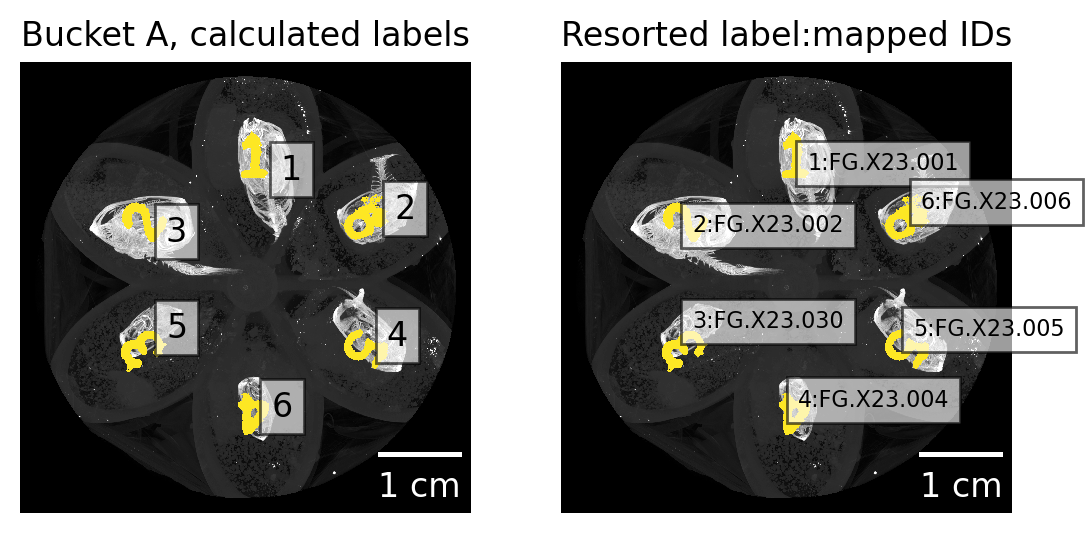

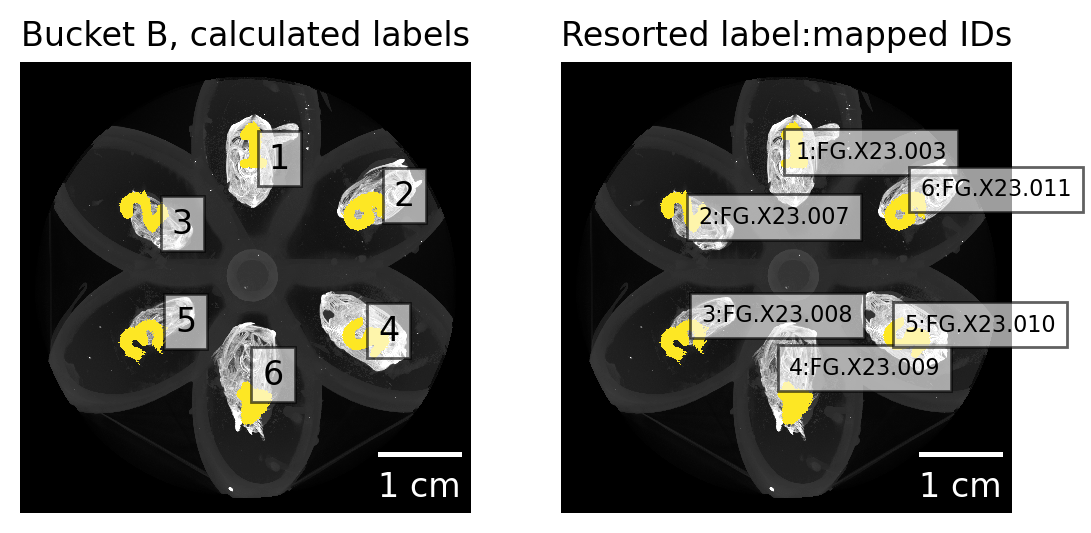

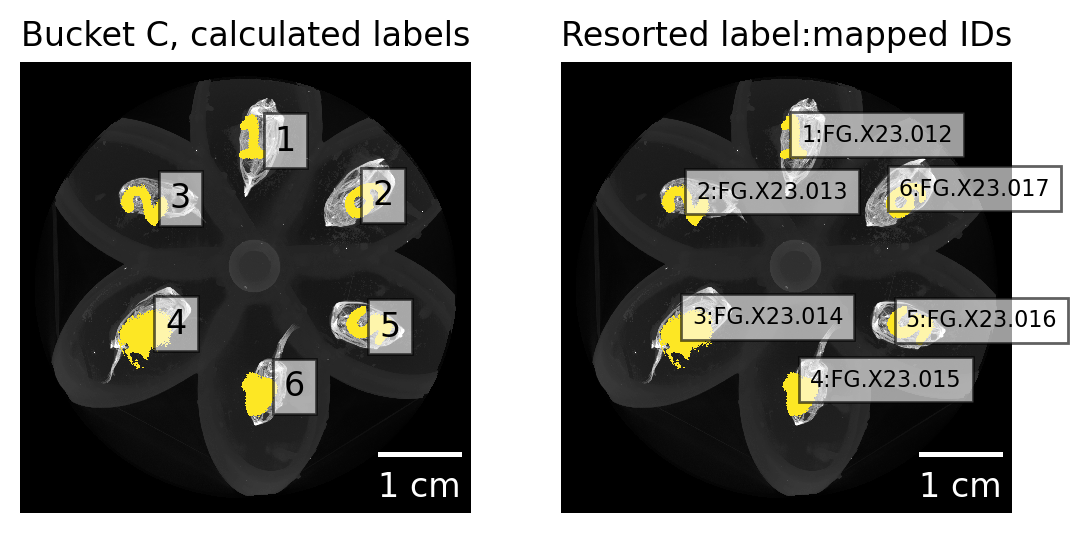

In [38]:
for i in range(len(Data)):
    doublecheck_fish_position(i)

In [39]:
def regionextractor(whichscan, buffer=50, verbose=True):
    os.makedirs(Data.Folder[whichscan] + '_regions', exist_ok=True)
    for c, region in tqdm(enumerate(Data['Regions_Ordered'][whichscan]),
                          total=len(Data['Regions_Ordered'][whichscan]),
                          desc='Writing cropped regions to .zarr files'):
        outputfilename = os.path.join(Data.Folder[whichscan] + '_regions', 'region_%s_%s.zarr' % (str(c+1),
                                                                                                  Data['FishID'][whichscan][c]))
        if not os.path.exists(outputfilename):
            # Crop current region out of reconstructions stack, drop RGB axis and rechunk, making for even more efficient access
            currentregion = Reconstructions[whichscan][:,region.bbox[0]-buffer:region.bbox[2]+buffer,region.bbox[1]-buffer:region.bbox[3]+buffer][:,:,:,0].rechunk('auto')
            print('Writing to %s. This takes a while.' % outputfilename[len(Root)+1:])
            dask.array.to_zarr(currentregion, outputfilename)
        if verbose:
            # Read written file back in, so we can profit from the rechunking
            currentregion = dask.array.from_zarr(outputfilename)
            plt.subplot(2,6,c+1)
            plt.imshow(Data['MIP_Anteroposterior'][whichscan][region.bbox[0]-buffer:region.bbox[2]+buffer,region.bbox[1]-buffer:region.bbox[3]+buffer])
            plt.imshow(numpy.ma.masked_equal(Data['VialLabels'][whichscan][region.bbox[0]-buffer:region.bbox[2]+buffer,region.bbox[1]-buffer:region.bbox[3]+buffer],
                                             False),
                       cmap='viridis_r')
            plt.gca().add_artist(ScaleBar(Data['Voxelsize'][whichscan], 'um'))
            plt.title('%s:Cut original' % str(c + 1))
            plt.axis('off')
            # plt.subplot(6, 2, (2 * c ) + 2)
            plt.subplot(2,6,c+1+6)  
            # Recalculate MIP for double-checking
            plt.imshow(currentregion.max(axis=0))
            plt.gca().add_artist(ScaleBar(Data['Voxelsize'][whichscan], 'um'))
            plt.title(Data['FishID'][whichscan][c])
            plt.axis('off')
    if verbose:
        plt.savefig('%s.%s.Regions.png' % (os.path.join(os.path.dirname(Data['Folder'][whichscan] + '_regions'), Data.Sample[whichscan]), Data.Scan[whichscan]))
        plt.show()
    return()

In [40]:
# Explicitly state the buffer, we want it later for adding the crop region to the regional log files
buffer = 50
for i in range(len(Data)):
    regionextractor(i, buffer=buffer, verbose=False)

Writing cropped regions to .zarr files:   0%|          | 0/6 [00:00<?, ?it/s]

Writing cropped regions to .zarr files:   0%|          | 0/6 [00:00<?, ?it/s]

Writing cropped regions to .zarr files:   0%|          | 0/6 [00:00<?, ?it/s]

In [41]:
# Load overview and labbook image, if present
Data['LabbookImage'] = [dask_image.imread.imread(os.path.join(os.path.dirname(f), '_labbook.jpg')).squeeze() for f in Data['Folder']]
Data['OverviewImage'] = [dask_image.imread.imread(os.path.join(os.path.dirname(f), '_overview.jpg')).squeeze()
                         if os.path.exists(os.path.join(os.path.dirname(f), '_overview.jpg'))
                         else numpy.random.random((2**8,2**8)) for f in Data['Folder']]

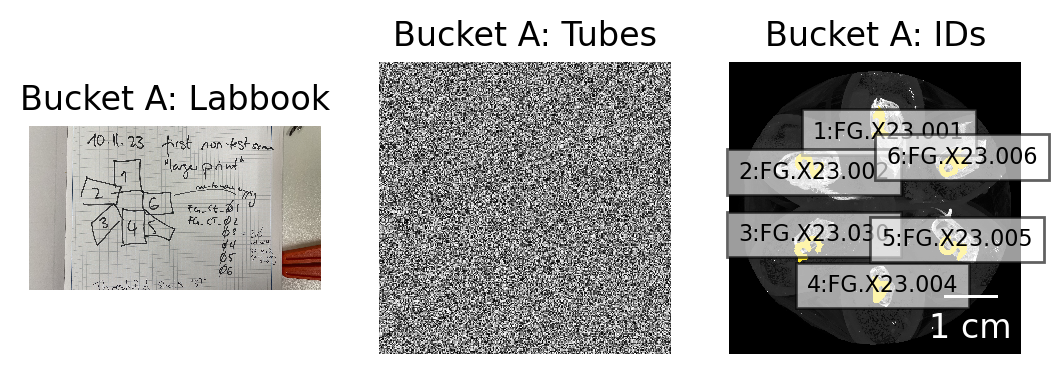

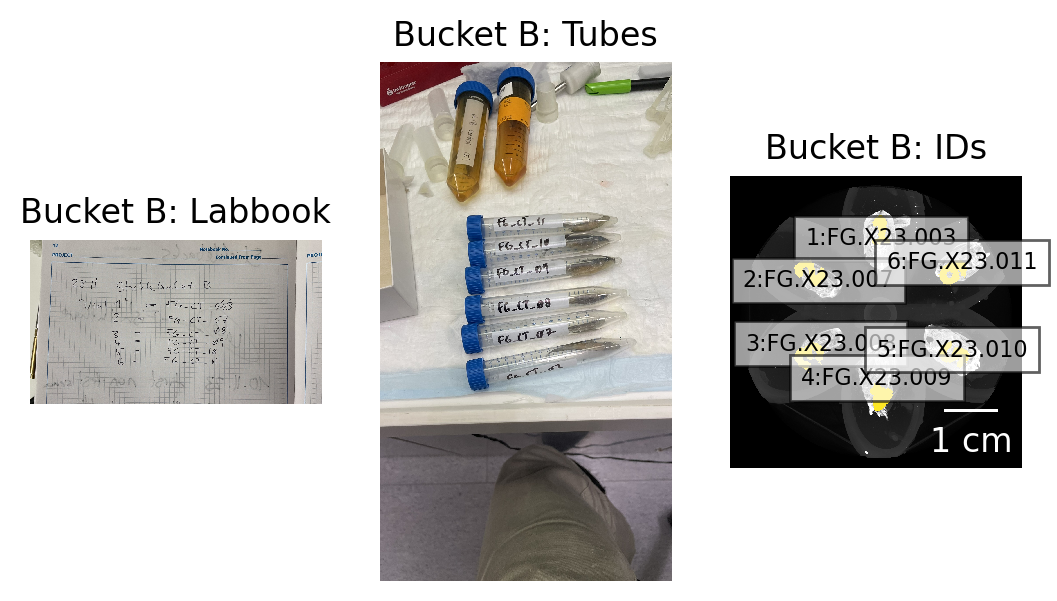

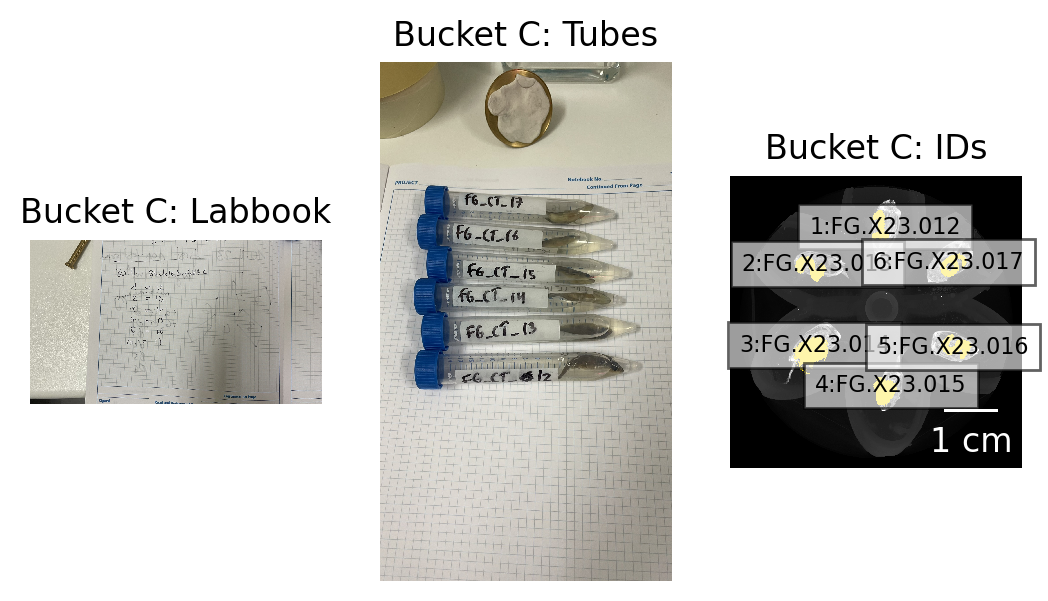

In [42]:
# Show all information we have, to double-check the mapping
for c, row in Data.iterrows():
    plt.subplot(131)
    plt.imshow(row.LabbookImage)
    plt.title('Bucket %s: Labbook' % row.Bucket)
    plt.axis('off')
    plt.subplot(132)
    plt.imshow(row.OverviewImage)
    plt.title('Bucket %s: Tubes' % row.Bucket)
    plt.axis('off')
    plt.subplot(133)
    plt.imshow(Data['MIP_Anteroposterior'][c])
    plt.imshow(numpy.ma.masked_equal(Data['VialLabels'][c], False), cmap='viridis_r')
    for d, region in enumerate(Data['Regions_Ordered'][c]):
        plt.annotate('%s:%s' % (d+1, Data['FishID'][c][d]),                     
                     xy=(region.centroid[1], region.centroid[0]),
                     color='black',
                     ha='center',
                     va='center',
                     fontsize=8,
                     bbox=dict(fc="white", alpha=0.618))
    plt.title('Bucket %s: IDs' % row.Bucket)
    plt.gca().add_artist(ScaleBar(Data['Voxelsize'][c], 'um'))
    plt.axis('off')
    plt.savefig('%s.%s.Mapping.png' % (os.path.join(os.path.dirname(row['Folder']), row.Sample), row.Scan))
    plt.show()

In [43]:
# Read in regions again
RegionZarrFiles = [glob.glob(os.path.join(folder + '_regions', '*.zarr')) for folder in Data['Folder']]
Regions = [[dask.array.from_zarr(f) for f in files] for files in RegionZarrFiles]

In [44]:
# We want to generate log files for the cutout regions
# Aeons ago, we wrote a little wrapper function to log stuff at TOMCAT
# https://github.com/habi/TOMCAT/blob/master/postscan/StackedScanOverlapFinder.py#L104
# The function below is slightly tweaked from there
def myLogger(logfilename, verbose=False):
    import logging
    logger = logging.getLogger(logfilename)
    logger.setLevel(logging.INFO)
    handler = logging.FileHandler(logfilename, 'w')
    logger.addHandler(handler)
    if verbose:
        print('Logging to %s' % logfilename)
    return logger
# Then write to the file with
# logfile = myLogger(Filename))
# logfile.info('Put this into the log file')

In [56]:
# Save out a log file
for c, row in tqdm(Data.iterrows(), total=len(Data), desc='Writing log files for regions'):
    for d, region in tqdm(enumerate(row.Regions),
                            total=len(row.Regions),
                            desc=Data.Folder[c][len(Root)+1:]):
        # Generate output directory
        os.makedirs(os.path.join(row.Folder + '_regions', row['FishID'][d]), exist_ok=True)
        # Generate logfile name
        logfilename = os.path.join(row.Folder + '_regions', row['FishID'][d], row['FishID'][d] + '.log')
        # Delete logfile, if it already exists
        if os.path.exists(logfilename):
            os.remove(logfilename)
        logfile = myLogger(logfilename)
        logfile.info('Scan = %s' % os.path.join(row.Sample, row.Scan))
        logfile.info('Voxel size = %s um' % row.Voxelsize)
        logfile.info('ID = %s' % row['FishID'][d])
        logfile.info('Vial = %s' % str(d + 1))
        logfile.info('Centroid (x,y) in the original stack = %s, %s' % (int(round(region.centroid[1])), int(round(region.centroid[0]))))
        logfile.info('Bounding box (x1:x2, y1:y2) of this region in the original stack = %s:%s, %s:%s' % (region.bbox[1]-buffer, region.bbox[3]+buffer,
                                                                                                          region.bbox[0]-buffer, region.bbox[2]+buffer))

Writing log files for regions:   0%|          | 0/3 [00:00<?, ?it/s]

BucketOfFish_A/17.5um_rec:   0%|          | 0/6 [00:00<?, ?it/s]

BucketOfFish_B/rec:   0%|          | 0/6 [00:00<?, ?it/s]

BucketOfFish_C/rec:   0%|          | 0/6 [00:00<?, ?it/s]

In [57]:
def imsaver(image, filename):
    from joblib import Parallel, delayed
    ''' Function for parallelizing writing out imgages '''
    if not os.path.exists(filename):
        imageio.imwrite(filename, image)

In [58]:
from joblib import Parallel, delayed

In [60]:
# Save out PNG slices 
for c, row in tqdm(Data.iterrows(),
                   total=len(Data),
                   desc='Saving out PNGs for each region of each bucket'):
    for d, zarrfile in tqdm(enumerate(Regions[c]),
                            total=len(Regions[c]),
                            desc=Data.Folder[c][len(Root)+1:]):
        # print(zarrfile.shape)
        # plt.imshow(zarrfile[666])
        # plt.show()
        # Make output directory
        outputdir = os.path.join(row.Folder + '_regions', row['FishID'][d])
        os.makedirs(outputdir, exist_ok=True)
        outputfilenames = [os.path.join(outputdir,
                                        os.path.basename(fn)).replace(Data.Sample[c], Data['FishID'][c][d]) for fn in Data['Filenames Reconstructions'][c]]
        parallelize = True
        if parallelize:
            # Hat tip to Oleksiy for providing a snippet to parallelize the PNG writing 
            # It is paramount that the filenames are sorted though!
            Parallel(n_jobs=-1)(delayed(imsaver)(zarrfile[slice],outputfilenames[slice]) for slice in range(len(outputfilenames)))
        else:
            for slice in tqdm(range(len(outputfilenames)),
                              total=len(outputfilenames),
                              desc='%s' % os.path.splitext(RegionZarrFiles[c][d])[0][len(Root)+1:],
                              leave=False):
                if not os.path.exists(outputfilenames[slice]):
                    imageio.imwrite(outputfilenames[slice], zarrfile[slice].astype('uint8'))

Saving out PNGs for each region of each bucket:   0%|          | 0/3 [00:00<?, ?it/s]

BucketOfFish_A/17.5um_rec:   0%|          | 0/6 [00:00<?, ?it/s]

BucketOfFish_B/rec:   0%|          | 0/6 [00:00<?, ?it/s]

BucketOfFish_C/rec:   0%|          | 0/6 [00:00<?, ?it/s]

In [62]:
STOPHERE==)

SyntaxError: unmatched ')' (3407578235.py, line 1)

In [ ]:
# Minimize .zarr files to only fish-extent

In [61]:
for c, region in enumerate(Regions):
    outfilename = RegionZarrFiles[c].replace('_rec.zarr', '.MIPs.png')
    if not os.path.exists(outfilename):
        for d, direction in enumerate(directions):
            plt.subplot(1, 3 , d+1)
            plt.imshow(region.max(axis=d))
            plt.title('Region %s\n%s MIP' % (c, direction))
            plt.axis('off')
            plt.gca().add_artist(ScaleBar(voxelsize, 'um'))
        plt.savefig(outfilename)
        plt.show()
    else:
        print('MIP already saved to %s' % outfilename)

AttributeError: 'list' object has no attribute 'replace'

In [ ]:
# Calculate the histograms of one of the MIPs
# Caveat: dask.da.histogram returns histogram AND bins, making each histogram a 'nested' list of [h, b]
Histograms = [dask.array.histogram(dask.array.array(region),
                                          bins=2**8,
                                          range=[0, 2**8]) for region in Regions]
# Actually compute the data and put only h into the dataframe, so we can use it below.
# Discard the bins
Histograms = [h.compute() for h, b in Histograms]

In [ ]:
Thresholds = [skimage.filters.threshold_otsu(region[:,:,:,0][region[:,:,:,0]>10].compute()) for region in Regions]

In [ ]:
for c, hist in enumerate(Histograms):
    plt.semilogy(hist,
                 c=seaborn.color_palette()[c])
    plt.axvline(Thresholds[c],
                label='R%s: %s' % (c, Thresholds[c]),
                c=seaborn.color_palette()[c])
plt.legend()
plt.show()

In [ ]:
for c, region in enumerate(Regions):
    outfilename = RegionZarrFiles[c].replace('_rec.zarr', '.MIPsasdfasdfa.png')
    region = region[:,:,:,0].compute()
    if not os.path.exists(outfilename):
        for d, direction in enumerate(directions):
            plt.subplot(1, 3 , d+1)
            plt.imshow((region>Thresholds[c]).max(axis=d))
            plt.title('Region %s\n%s MIP' % (c, direction))
            plt.axis('off')
            plt.gca().add_artist(ScaleBar(voxelsize, 'um'))
        # plt.savefig(outfilename)
        plt.show()
    else:
        print('MIP already saved to %s' % outfilename[len(Root)+1:])

In [ ]:
Thresholds

In [ ]:
labels = skimage.morphology.label(Regions[0][:,:,:,0]>Thresholds[0])

In [ ]:
import zarr

In [ ]:
# Label fish and save out as .zarr
os.makedirs(Data.Folder[whichscan] + '_labeled', exist_ok=True)
for c, region in tqdm(enumerate(Regions), total=len(regions)):
    plt.subplot(1, 6, c+1)
    currentregion = skimage.morphology.label(region[:,:,:,0]>Thresholds[c])
    outputfilename = os.path.join(Data.Folder[whichscan] + '_labeled', 'region_%s_rec_labeled.zarr' % str(c+1))
    if not os.path.exists(outputfilename):
        print('writing to', outputfilename)
        zarr_out_3D_convenient = zarr.save(outputfilename, currentregion)
    else:
        print(outputfilename[len(Root)+1:], 'already exists')
    currentmip = currentregion.max(axis=0)
    plt.imshow(currentmip)
    plt.gca().add_artist(ScaleBar(voxelsize, 'um'))
    plt.title('Region %s' % c)
    plt.axis('off')
plt.show()

In [ ]:
# Read in labels again
LabelZarrFiles = glob.glob(os.path.join(Data.Folder[whichscan] + '_labeled', '*.zarr'))
Labels = [dask.array.from_zarr(file) for file in LabelZarrFiles]

In [ ]:
for c, region in enumerate(Labels):
    outfilename = LabelZarrFiles[c].replace('_rec_labeled.zarr', '.MIPs.labeled.png')
    print(outfilename)
    # region = region[:,:,:,0].compute()
    if not os.path.exists(outfilename):
        for d, direction in enumerate(directions):
            plt.subplot(1, 3 , d+1)
            plt.imshow((region).max(axis=d))
            plt.title('Region %s\n%s MIP' % (c, direction))
            plt.axis('off')
            plt.gca().add_artist(ScaleBar(voxelsize, 'um'))
        plt.savefig(outfilename)
        plt.show()
    else:
        print('MIP overview image already saved to %s' % outfilename[len(Root)+1:])

In [ ]:
for c, region in enumerate(Labels):
    outfilename = LabelZarrFiles[c].replace('_rec_labeled.zarr', '.Summed.labeled.png')
    if not os.path.exists(outfilename):
        for d, direction in enumerate(directions):
            plt.subplot(1, 3 , d+1)
            plt.imshow((region).sum(axis=d))
            plt.title('Region %s\n%s Sum' % (c, direction))
            plt.axis('off')
            plt.gca().add_artist(ScaleBar(voxelsize, 'um'))
        plt.savefig(outfilename)
        plt.show()
    else:
        print('Summed image already saved to %s' % outfilename[len(Root)+1:])

In [ ]:
slice = 333
for c, r in enumerate(Regions):
    plt.subplot(2,3,c+1)
    plt.imshow(r[slice])
    # plt.imshow((r[:,:,:,0]>Thresholds[c])[slice], alpha=0.5, cmap='viridis')
    plt.imshow(skimage.morphology.label(r[:,:,:,0][slice]>Thresholds[c]), alpha=0.5, cmap='viridis')
    plt.title('R%s' % c)
    plt.axis('off')
plt.show()

In [ ]:
Labels[0]

In [ ]:
# Save out PNG slices for later use
for c, zarrfile in tqdm(enumerate(Labels),
                        total=len(Labels),
                        desc=Data.Folder[whichscan][len(Root)+1:]):
    # Make output directory
    os.makedirs(os.path.splitext(LabelZarrFiles[c])[0], exist_ok=True)
    for d, slice in tqdm(enumerate(zarrfile),
                         total=len(zarrfile),
                         desc='Saving to %s' % os.path.splitext(LabelZarrFiles[c])[0][len(Root)+1:],
                         leave=False):
        outfilepath = os.path.join(os.path.splitext(LabelZarrFiles[c])[0],
                                   os.path.basename(Data['Filenames Reconstructions'][whichscan][d])).replace('_rec00', '_region_%s_labeled_rec00' % str(c+1))
        if not os.path.exists(outfilepath):
            # plt.imshow(slice.compute())
            # plt.show()
            # print(type(slice))
            imageio.imwrite(outfilepath, slice.compute().astype('uint8'))

In [ ]:
blobs = skimage.feature.blob_dog(clean)

In [ ]:
blobs

In [ ]:
plt.subplot(121)
plt.imshow(clean)
plt.subplot(122)
plt.imshow(mip)